In [1]:
import numpy as np
#this just changes things from mathematica form to python
from sympy.parsing.mathematica import mathematica  
from sympy import var
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from scipy import integrate
from numba import jit
import scipy

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
plt.rc('font', size=18) 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [3]:
from classy import Class

#Start by specifying the cosmology  - this is some hodge-podge of quijote but now agrees with Pardede et al...
h = 0.695
Omega_b = 0.02224/h**2
Omega_cdm = 0.11542/h**2
Omega_m = Omega_cdm+Omega_b
A_s = 2.20193e-9 
n_s = 0.9632

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc # is also set to 10 later
params = {'output':'mPk,mTk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,#Omega_m-Omega_b,#
             'h':h,
             'n_s':n_s,
             'A_s':A_s,#'n_s':n_s,'sigma8':0.828,#
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo_kevin = Class()
cosmo_kevin.set(params)
cosmo_kevin.compute()

In [4]:
#eline de weerd
h = 0.6766#0.695#0.676611#0.7 #H0/100
Omega_m = 0.3111
Omega_cdm = 0.11933/h**2
Omega_b = 0.02242/h**2#0.157*Omega_m
A_s = 2.20193e-9 
n_s = 0.9665#0.9632#
#a = 1/(1+z)
#H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc # is also set to 10 later
params = {'output':'mPk,mTk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_m-Omega_b,#Omega_cdm,#
             'h':h,
             'n_s':n_s,
             'A_s':A_s,#'n_s':n_s,'sigma8':0.828,#
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo_eline = Class()
cosmo_eline.set(params)
cosmo_eline.compute()

In [5]:
def get_avg_dist(obs_pos):
    """create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)"""
    Nside_theory= 128
    conf_space = np.linspace(0,1000,Nside_theory)
    x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
    conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
    ds = np.where(conf_norm==0,1,conf_norm)
    return 1/np.mean(1/ds**3)

print(get_avg_dist((500,500,200))**(1/3))

255.01426105201142


$$\ddot{F}+\mathcal{H} \dot{f}=\frac{3 H_0^2 \Omega_m}{2 a} (F+D^2)$$
$$\mathcal{H}^2(1+z)^2 F''+(\mathcal{H'}\mathcal{H}(1+z)^2) F'=\frac{3 H_0^2 \Omega_{m,0}}{2 a} (F+D^2)$$

In [6]:
#so lets solve for the second order growth function F ...
from scipy.integrate import odeint
c = 2.99792*10**5 #km/s
#first check with D
def D_test(u,zz): # so variables are F and H and D
    f,fd = u # unpack u vector
    return [fd,(-H_c(zz)*H_cd(zz)*(1+zz)**2 *fd + ((3*(100/c)**2 * Omega_m *(1+zz))/(2))*(f))/(H_c(zz)**2 *(1+zz)**2)]

def F_func(u,zz): # so variables are F and H and D
    f,fd = u # unpack u vector
    D_zz = D_intp(zz)
    return [fd,(-H_c(zz)*H_cd(zz)*(1+zz)**2 *fd + ((3*(100/c)**2 * Omega_m *(1+zz))/(2))*(f+D_zz**2))/(H_c(zz)**2 *(1+zz)**2)]

odeint_zz = np.linspace(20,0.05,int(1e+5))
#set initial params for D
D0 = [D_intp(odeint_zz[0]),dD_dz(odeint_zz[0])]
sol = odeint(D_test,D0,odeint_zz)

#set initial params for F
F0 = [(3/7)*D_intp(odeint_zz[0])**2,(3/7)*2*D_intp(odeint_zz[0])*dD_dz(odeint_zz[0])]
sol1 = odeint(F_func,F0,odeint_zz)

NameError: name 'D_intp' is not defined

In [ ]:
plt.plot(odeint_zz,sol[:,0],color='blue',label='$D(z)$')
plt.plot(odeint_zz,sol[:,1],color='red',label='$D\'(z)$')
plt.plot(odeint_zz,D_intp(odeint_zz),'--',color='blue')
plt.plot(odeint_zz,dD_dz(odeint_zz),'--',color='red')
plt.xscale('log')
#plt.ylim(0,2)
plt.legend()
plt.show()
plt.ylim(0.999,1.001)
plt.plot(odeint_zz,sol[:,0]/D_intp(odeint_zz),color='blue',label='$D(z)$')
plt.plot(odeint_zz,sol[:,1]/dD_dz(odeint_zz),color='red',label='$D\'(z)$')
plt.xscale('log')
plt.ylabel('Error in D(z)')
plt.show()

### In Eds - u= v =1

$$v=\frac{7 K}{3} =\frac{7 F}{3D^2}$$

$$u = \frac{7 C}{3} \equiv \frac{7}{3}\frac{\dot{F}}{2\dot{D}D}$$


In [ ]:
#deivations from Einstein-de-sitter

K = (sol1[:,0]/D_intp(odeint_zz)**2)
C = sol1[:,1]/(2*D_intp(odeint_zz)*dD_dz(odeint_zz))
K_intp = interp1d(odeint_zz,K,kind='cubic')
C_intp = interp1d(odeint_zz,C,kind='cubic')
v = (7/3)*K
u = (7/3)*C

plt.plot(odeint_zz,v,label='7/3 K')
plt.plot(odeint_zz,u,'--',label='7/3 C')
plt.plot(odeint_zz,np.ones_like(odeint_zz),'-.',color ='grey')
#plt.xscale('log')
plt.ylabel('Deviations from Eds')
plt.xlabel('$z$')
plt.legend()
plt.xlim(0,3)
plt.ylim(0.96,1.04)
plt.show()

plt.plot(1/(odeint_zz+1),v,label='7/3 K')
plt.plot(1/(odeint_zz+1),u,'--',label='7/3 C')
#plt.xscale('log')
plt.ylabel('Deviations from Eds')
plt.xlabel('$a$')
plt.legend()

## define all derivatives wrt to comoving distance

$\frac{df}{d ln(d)}=\frac{d d}{d ln(d)}\frac{dz}{dd}\frac{df}{dz}=d \times(1/\frac{dd}{dz})\frac{df}{dz}$

In [ ]:
#Euclid like params - taken from eline de weerd - https://github.com/ElineMaaikedeWeerd/bispectrum_snr/blob/master/doppler_model1_OOversion/snr.py
#table of b_e and Q from doppler paper
euclid_data = np.loadtxt('snr_surveyparams.txt')

#the table from the draft  has columns z, b_e, Q, n_g, V, sigma
z_euclid = euclid_data[:,0]
be_euclid = interp1d(z_euclid, euclid_data[:,1])
Q_euclid = interp1d(z_euclid,  euclid_data[:,2])
ngt_euclid = interp1d(z_euclid,1e-3 * euclid_data[:,3])
vt_euclid = interp1d(z_euclid, 1e9 * euclid_data[:,4])
sigma_euclid = interp1d(z_euclid, euclid_data[:,5])

In [ ]:
#plt.plot(z_euclid,be_euclid(z_euclid))
plt.plot(z_euclid,Q_euclid(z_euclid))
#plt.plot(z_euclid,ngt_euclid(z_euclid))
#plt.plot(z_euclid,vt_euclid(z_euclid))
#plt.plot(z_euclid,sigma_euclid(z_euclid))

dQ_euclid_dz = interp1d(z_euclid,np.gradient(Q_euclid(z_euclid),z_euclid))
plt.plot(z_euclid,dQ_euclid_dz(z_euclid))

In [919]:
baLCDM = cosmo.get_background()
print(baLCDM.keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [2211]:
from scipy.interpolate import interp1d

class CosmologicalFunctions:
    def __init__(self,cosmo):
        """
            take in Class and spit out stuff and create all my functions
        """
        self.cosmo = cosmo
        baLCDM = cosmo.get_background()
        #print(baLCDM.keys())
        f_cl = baLCDM['gr.fac. f']
        D_cl = baLCDM['gr.fac. D']
        z_cl = baLCDM['z']
        H_cl = baLCDM['H [1/Mpc]']
        xi_cl = baLCDM['comov. dist.']
        t_cl = baLCDM['conf. time [Mpc]']
        
        self.z_cl = z_cl#save for later
        self.Om_0 = cosmo.get_current_derived_parameters(['Omega_m'])['Omega_m']
        self.h = cosmo.get_current_derived_parameters(['h'])['h']
        
        #define functions and add in h
        self.H_c = interp1d(z_cl,H_cl*(1/(1+z_cl))/self.h,kind='cubic') # now in h/Mpc!
        self.dH_c = interp1d(z_cl,np.gradient(H_cl*(1/(1+z_cl))/self.h,z_cl),kind='cubic') # derivative wrt z
        self.ddH_c = interp1d(z_cl,np.gradient(self.dH_c(z_cl),z_cl),kind='cubic') # second derivative wrt z
        self.comoving_dist = interp1d(z_cl,xi_cl*self.h,kind='cubic') # just use class background as quick
        self.f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)
        self.D_intp = interp1d(z_cl,D_cl,kind='cubic')
        self.dD_dz = interp1d(z_cl,np.gradient(D_cl,z_cl),kind='cubic')
        self.conf_time = interp1d(z_cl,self.h*t_cl,kind='cubic')#convert between the two
        #misc
        self.c = 2.99792*10**5 #km/s
        self.H0 = 100/self.c #[h/Mpc]
        self.Om = lambda xx: self.Om_0 * (self.H0**2 / self.H_c(xx)**2) * (1+xx)
        
        #define bias stuff
        if False:
            self.b_1 = lambda xx: 1.46 +0*xx
        else:
            self.b_1 = lambda xx: np.sqrt(1+xx)
            
        self.g_2 = lambda xx: 0.524-0.547*self.b_1(xx)+0.046*self.b_1(xx)**2#-(2/7)*(self.b_1(xx)-1)#
        self.b_2 = lambda xx: 0.412 - 2.143*self.b_1(xx) +0.929*self.b_1(xx)**2 + 0.008*self.b_1(xx)**3 + 4/3 * self.g_2(xx)#-0.1*np.sqrt(1+xx)#
        
        if True: # for comparison with eline - euclid like
            self.b_1 = lambda xx: 0.9 + 0.4*xx
            self.b_2 = lambda xx: -0.741-0.125*xx+0.123*xx**2+0.00637*xx**3
            self.g_2 = lambda xx: (0.0409-0.199*xx-0.0166* xx**2 +0.00268* xx**3)/2
            
        self.z_samps = np.linspace(0.05, 10, 10000)#defined over appropiate range for numerical derivs
        
        #get derivs of these redshift dependent functions
        func_deriv_list = self.lnd_derivatives([self.b_1,self.b_2,self.g_2,self.f_intp,self.D_intp])
        self.b1_d,self.b2_d,self.g2_d,self.f_d,self.D_d = func_deriv_list
        func_second_deriv_list = self.lnd_derivatives(func_deriv_list)
        self.b1_dd,self.b2_dd,self.g2_dd,self.f_dd,self.D_dd = func_second_deriv_list
        
        #Euclid like params - taken from eline de weerd - https://github.com/ElineMaaikedeWeerd/bispectrum_snr/blob/master/doppler_model1_OOversion/snr.py
        #table of b_e and Q from doppler paper
        euclid_data = np.loadtxt('snr_surveyparams.txt')

        #the table from the draft  has columns z, b_e, Q, n_g, V, sigma
        if True:
            self.z_euclid = euclid_data[:,0]
            self.be_euclid = interp1d(z_euclid, euclid_data[:,1])
            self.Q_euclid = interp1d(z_euclid,  euclid_data[:,2])
            #self.ngt_euclid = interp1d(z_euclid,1e-3 * euclid_data[:,3])
            #self.vt_euclid = interp1d(z_euclid, 1e9 * euclid_data[:,4])
            #self.sigma_euclid = interp1d(z_euclid, euclid_data[:,5])
        else:
            self.z_euclid = self.z_samps 
            self.be_euclid = lambda xx: 0*xx
            self.Q_euclid = lambda xx:  0*xx + 2/5
        
        if False: # clarkson 2019
            self.b_1 = lambda xx: 1.3 +0*xx
            self.b_2 = lambda xx: -0.74 +0*xx
            self.g_2 = lambda xx: 0.524-0.547*self.b_1(xx)+0.046*self.b_1(xx)**2#-(2/7)*(self.b_1(xx)-1)#
            self.z_euclid = self.z_samps
            self.be_euclid = lambda xx: -4 +0*xx
            self.Q_euclid = lambda xx:  0*xx - 2.5# 0.95#/5
        
    def get_class_powerspectrum(self,kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
        return np.array([self.cosmo.pk_lin(ki, zz) for ki in kk*self.h])*h**3

    def get_pkinfo_z(self,k,z):
        Plin = get_class_powerspectrum(k,0)#just always get present day power spectrum
        Pk = interpolate.interp1d(k,Plin)#get linear power spectrum
        self.Pk = Pk
        Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))
        Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
        return Pk,Pk_d,Pk_dd
        
    def solve_second_order_KC(self):
        c = 2.99792*10**5 #km/s
        def F_func(u,zz): # so variables are F and H and D
            f,fd = u # unpack u vector
            D_zz = self.D_intp(zz)
            return [fd,(-self.H_c(zz)*self.dH_c(zz)*(1+zz)**2 *fd + ((3*(self.H0)**2 * self.Om_0 *(1+zz))/(2))*(f+D_zz**2))/(self.H_c(zz)**2 *(1+zz)**2)]
        
        odeint_zz = np.linspace(20,0.05,int(1e+5))# so z=20 should be pretty much matter dominated

        #set initial params for F
        F0 = [(3/7)*self.D_intp(odeint_zz[0])**2,(3/7)*2*self.D_intp(odeint_zz[0])*self.dD_dz(odeint_zz[0])]
        sol1 = odeint(F_func,F0,odeint_zz)
        K = (sol1[:,0]/self.D_intp(odeint_zz)**2)
        C = sol1[:,1]/(2*self.D_intp(odeint_zz)*self.dD_dz(odeint_zz))
        self.K_intp = interp1d(odeint_zz,K,kind='cubic')
        self.C_intp = interp1d(odeint_zz,C,kind='cubic')
    
    def lnd_derivatives(self,functions_to_differentiate,z_range= [0]):
        """
            calculates derivatives of a list of functions wrt log comoving dist numerically
        """
        
        if len(z_range) == 1:
            z_range= self.z_samps

        # Store first derivatives in a list
        function_derivatives = []

        for func in functions_to_differentiate:
            # Calculate numerical derivatives of the function with respect to ln(d)
            derivative_func = interpolate.interp1d(z_range, np.gradient(func(z_range), np.log(self.comoving_dist(z_range))))
            function_derivatives.append(derivative_func)

        return function_derivatives
    
    def get_params(self,k1,k2,theta,zz):
        """
            return arrays of redshift and k dependent parameters
        """
        self.solve_second_order_KC()#get K and C
        
        k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))#get k3 from triangle condition
        k3 = np.where(k3==0,1e-3,k3)
        
        k = np.logspace(-5, np.log10(k_max), num=1000)
        Pk,Pk_d,Pk_dd = self.get_pkinfo_z(k,0)
        Pk1 = Pk(k1)
        Pk2 = Pk(k2)
        Pk3 = Pk(k3)

        Pkd1 = Pk_d(k1)
        Pkd2 = Pk_d(k2)
        Pkd3 = Pk_d(k3)

        Pkdd1= Pk_dd(k1)
        Pkdd2 = Pk_dd(k2)
        Pkdd3 = Pk_dd(k3)

        #redshift dependendent terms
        d = self.comoving_dist(zz)
        
        K = 3/7
        C = 3/7
        if True:
            K = self.K_intp(zz)
            C = self.C_intp(zz)

        f = self.f_intp(zz)
        D1 = self.D_intp(zz)
        b1 = self.b_1(zz)
        b2 = self.b_2(zz)
        g2 = self.g_2(zz)
        return k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2

    def get_derivs(self,zz):
        #1st deriv
        fd = self.f_d(zz)
        Dd = self.D_d(zz)
        gd2 = self.g2_d(zz)
        bd2 = self.b2_d(zz)
        bd1 = self.b1_d(zz)
        #2nd deriv
        fdd = self.f_dd(zz)
        Ddd = self.D_dd(zz)
        gdd2 = self.g2_dd(zz)
        bdd2 = self.b2_dd(zz)
        bdd1 = self.b1_dd(zz)
        return fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
    
        #get biases
    def get_PNGparams(self,fNL,zz):
        delta_c = 1.686
        bL10 = lambda xx: b_1(xx) - 1
        bL20 = lambda xx: b_2(xx) - (8/21)*bL10(xx)

        bL01 = lambda xx: 2*delta_c*fNL*bL10(xx)
        bL11 = lambda xx: 2*fNL*(delta_c*bL20(xx)-bL10(xx))
        bL02 = lambda xx: 4*fNL**2 * delta_c*(delta_c*bL20(xx)-2*bL10(xx))

        bE01 = bL01
        bE11 = lambda xx: bL01(xx) + bL11(xx)
        bE02 = bL02

        alphak1 = M(k1, 0)
        alphak2 = M(k2, 0)
        alphak3 = M(k3, 0)
        return fNL,1*bE01(zz),1*bE11(zz),1*bE02(zz),alphak1,alphak2,alphak3
    
    def get_beta_funcs(self,zz):
        """
            Function that relies on biases and functions defined above to return beta coefficients
            from paper 1711.01812v4
        """
        #these derivs here are wrt to conformal time so we convert to derivs wrt to z
        #d/dt = d a/dt d/da = a H dz/da d/dz =  -(1+z) H d/dz # everything here is conformal both t and H
        #d^2/d^2 t = (1+z)^2 H^2 d^2/d z^2 + H(1+z)(H+(1+z)H')d/dz
        
        dQ_euclid_dz = interp1d(self.z_euclid,np.gradient(self.Q_euclid(self.z_euclid),self.z_euclid))
        dbe_dz = interp1d(self.z_euclid,np.gradient(self.be_euclid(self.z_euclid),self.z_euclid))
        db1_dz = interp1d(self.z_samps,np.gradient(self.b_1(self.z_samps),self.z_samps))
        
        dH_dt = lambda xx: -(1+xx)*self.H_c(xx)*self.dH_c(xx)
        dH_dt2 = lambda xx: (1+xx)**2 *self.H_c(xx)**2 *self.ddH_c(xx)+self.H_c(xx)*(1+xx)*(self.H_c(xx)+(1+xx)*self.dH_c(xx))*self.dH_c(xx)#should just check with doing it numerically as is easier
        #self.dH22 = interp1d(self.z_cl,np.gradient(dH_dt(self.z_cl),self.conf_time(self.z_cl)))
        self.dH_dt = dH_dt                   
        dQ_dt = lambda xx: -(1+xx)*self.H_c(xx)*dQ_euclid_dz(xx)
        dbe_dt = lambda xx: -(1+xx)*self.H_c(xx)*dbe_dz(xx)#0*xx-1.6*1e-4
        db1_dt = lambda xx: -(1+xx)*self.H_c(xx)*db1_dz(xx)
        self.Q = self.Q_euclid
        self.b_e = self.be_euclid

        partdQ=0
        partdb1=0
        
        #from 1st order petrubation theory
        self.gr1 = lambda xx: xx*0 #self.H_c(xx)*self.f_intp(xx)*(self.b_e(xx)-2*self.Q(xx)-2*(1-self.Q(xx))/(self.comoving_dist(xx)*self.H_c(xx))-dH_dt(xx)/self.H_c(xx)**2)
        self.gr2 = lambda xx:  self.H_c(xx)**2 *(self.f_intp(xx)*(3-self.b_e(xx))+ (3/2)*self.Om(xx)*(2+self.b_e(xx)-self.f_intp(xx)-4*self.Q(xx)-2*self.Q(xx)-2*(1-self.Q(xx))/(self.comoving_dist(xx)*self.H_c(xx))-dH_dt(xx)/self.H_c(xx)**2))
        self.grd1 = self.lnd_derivatives([self.gr1],self.z_euclid)[0]#get derivative for 1st order coef
        
        beta = np.empty(20,dtype=object)
        beta[6] = lambda xx: self.H_c(xx)**2 * ((3 / 2) * self.Om(xx) * (2 - 2 * self.f_intp(xx)+ self.b_e(xx) - 4 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))
        beta[7] = lambda xx: self.H_c(xx)**2 * (self.f_intp(xx)* (3 - self.b_e(xx)))
        beta[8] = lambda xx: self.H_c(xx)**2 * (3 * self.Om(xx) * self.f_intp(xx) * (2 - self.f_intp(xx) - 2 * self.Q(xx)) + self.f_intp(xx)**2 * (4 + self.b_e(xx) - self.b_e(xx)**2 + 4 * self.b_e(xx) * self.Q(xx) - 6 * self.Q(xx) - 4 * self.Q(xx)**2 + 4 * partdQ + 4 * (dQ_dt(xx) / self.H_c(xx)) -(dbe_dt(xx) / self.H_c(xx)) - (2 / (self.comoving_dist(xx)**2 * self.H_c(xx)**2)) * (1 - self.Q(xx) + 2 * self.Q(xx)**2 - 2 * partdQ) - (2 / (self.comoving_dist(xx) * self.H_c(xx))) * (3 - 2 * self.b_e(xx) + 2 * self.b_e(xx) * self.Q(xx) - self.Q(xx) - 4 * self.Q(xx)**2 + ((3 * dH_dt(xx)) / (self.H_c(xx)**2)) * (1 - self.Q(xx)) + 4 * partdQ + 2 * (dQ_dt(xx) / self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2) * (3 - 2 * self.b_e(xx) + 4 * self.Q(xx) + ((3 * dH_dt(xx)) / (self.H_c(xx)**2))) + (dH_dt2(xx) / self.H_c(xx)**3)))
        beta[9] = lambda xx: self.H_c(xx)**2 * ( -(9 / 2) * self.Om(xx) * self.f_intp(xx))
        beta[10] = lambda xx: self.H_c(xx)**2 * (3 * self.Om(xx) * self.f_intp(xx))
        beta[11] = lambda xx: self.H_c(xx)**2 * ( (3/2 ) * self.Om(xx) * (1 + 2 * self.f_intp(xx)/ (3 * self.Om(xx))) + 3 * self.Om(xx) * self.f_intp(xx)- self.f_intp(xx)**2 * (-1 + self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 + self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))
        beta[12] = lambda xx: self.H_c(xx)**2 * ( -3 * self.Om(xx) * (1 + 2 * self.f_intp(xx)/ (3 * self.Om(xx))) - self.f_intp(xx)* ( self.b_1(xx) * (self.f_intp(xx)- 3 + self.b_e(xx)) + (db1_dt(xx) / self.H_c(xx)) ) + (3 / 2) * self.Om(xx) * (self.b_1(xx) * (2 + self.b_e(xx) - 4 * self.Q(xx) - 2 * ((1 - self.Q(xx))/(self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2) ) + db1_dt(xx) /self.H_c(xx) + 2 * (2 - (1 / (self.comoving_dist(xx) * self.H_c(xx))) ) * partdb1 ) )    
        beta[13] = lambda xx: self.H_c(xx)**2 * (( (9 / 4) * self.Om(xx)**2 + (3 / 2) * self.Om(xx) * self.f_intp(xx)* (1 - (2 * self.f_intp(xx)) + 2 * self.b_e(xx) - 6 * self.Q(xx) - ((4 * (1 - self.Q(xx)))/(self.comoving_dist(xx) * self.H_c(xx))) - ((3 * dH_dt(xx)) / self.H_c(xx)**2) ) ) + ( self.f_intp(xx)**2 * (3 - self.b_e(xx)) ) )
        beta[14] = lambda xx: self.H_c(xx) * ( - (3 / 2) * self.Om(xx) * self.b_1(xx))
        beta[15] = lambda xx: self.H_c(xx) * 2 * self.f_intp(xx)**2
        beta[16] = lambda xx: self.H_c(xx) * (self.f_intp(xx)* (self.b_1(xx) * (self.f_intp(xx)+ self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)) + (db1_dt(xx) / self.H_c(xx)) + 2 * (1 - (1 / (self.comoving_dist(xx) * self.H_c(xx)))) * partdb1 ))
        beta[17] = lambda xx: self.H_c(xx) * (- (3 / 2) * self.Om(xx) * self.f_intp(xx))
        beta[18] = lambda xx: self.H_c(xx) * ( (3 / 2) * self.Om(xx) * self.f_intp(xx) - self.f_intp(xx)**2 * (3 - 2 * self.b_e(xx) + 4 * self.Q(xx) + ((4 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) + (3 * dH_dt(xx)/ self.H_c(xx)**2)) )
        beta[19] = lambda xx: self.H_c(xx) * (self.f_intp(xx)* (self.b_e(xx) - 2 * self.Q(xx) - ((2 * (1 - self.Q(xx))) / (self.comoving_dist(xx) * self.H_c(xx))) - (dH_dt(xx)/ self.H_c(xx)**2)))

        self.beta = beta
        
        #get betad - derivatives wrt to ln(d)        # these are limited in range to euclid currently
        betad = np.empty(20,dtype=object)
        betad[14:20] = np.array(self.lnd_derivatives(beta[14:20],self.z_euclid),dtype=object)#14-19

        self.betad = betad
        all_betas = np.concatenate((np.array([self.gr1,self.gr2,self.grd1]),beta[6:],betad[14:20]))
        return [all_betas[i](zz) for i in range(len(all_betas))]


In [2212]:
zz=0.8
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = 2*np.pi/3#np.pi#np.linspace(0,np.pi,200)#

In [2213]:
cosmo_functions = CosmologicalFunctions(cosmo)
params = cosmo_functions.get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
derivs = cosmo_functions.get_derivs(zz)

PNGparams = cosmo_functions.get_PNGparams(1,zz)
betas = cosmo_functions.get_beta_funcs(zz)
gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas

2.3
-5.6


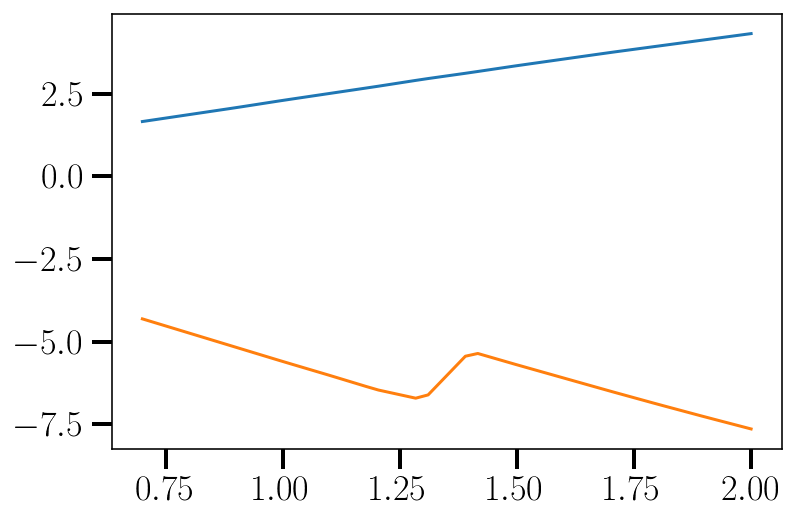

In [2214]:
z_plot = np.linspace(0.7,2)
#plt.plot(z_plot,cosmo_functions.b_1(z_plot))
#plt.plot(z_plot,cosmo_functions.b_2(z_plot))
#plt.plot(z_plot,cosmo_functions.g_2(z_plot))
plt.plot(z_plot,cosmo_functions.Q_euclid(z_plot))
plt.plot(z_plot,cosmo_functions.be_euclid(z_plot))
print(Q_euclid(1))
print(be_euclid(1))

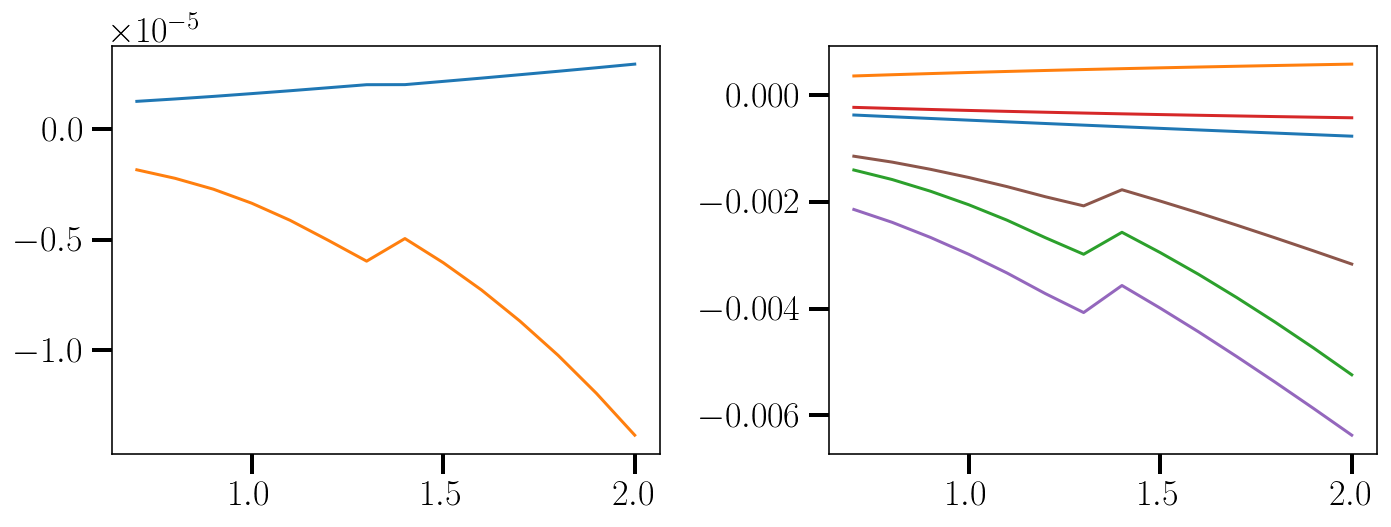

In [2114]:
#plt.plot(z_euclid,gr1)
#plt.plot(z_euclid,cosmo_functions.grd1(z_euclid))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#axs[0].plot(z_euclid,cosmo_functions.beta[13](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[12](z_euclid))
axs[0].plot(z_euclid,cosmo_functions.beta[11](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[10](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[9](z_euclid))
axs[0].plot(z_euclid,cosmo_functions.beta[8](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[7](z_euclid))
#axs[0].plot(z_euclid,cosmo_functions.beta[6](z_euclid))


axs[1].plot(z_euclid,cosmo_functions.beta[14](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[15](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[16](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[17](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[18](z_euclid))
axs[1].plot(z_euclid,cosmo_functions.beta[19](z_euclid))
#axs[1].plot(z_euclid,cosmo_functions.betad[16](z_euclid))

plt.tight_layout()
plt.show()

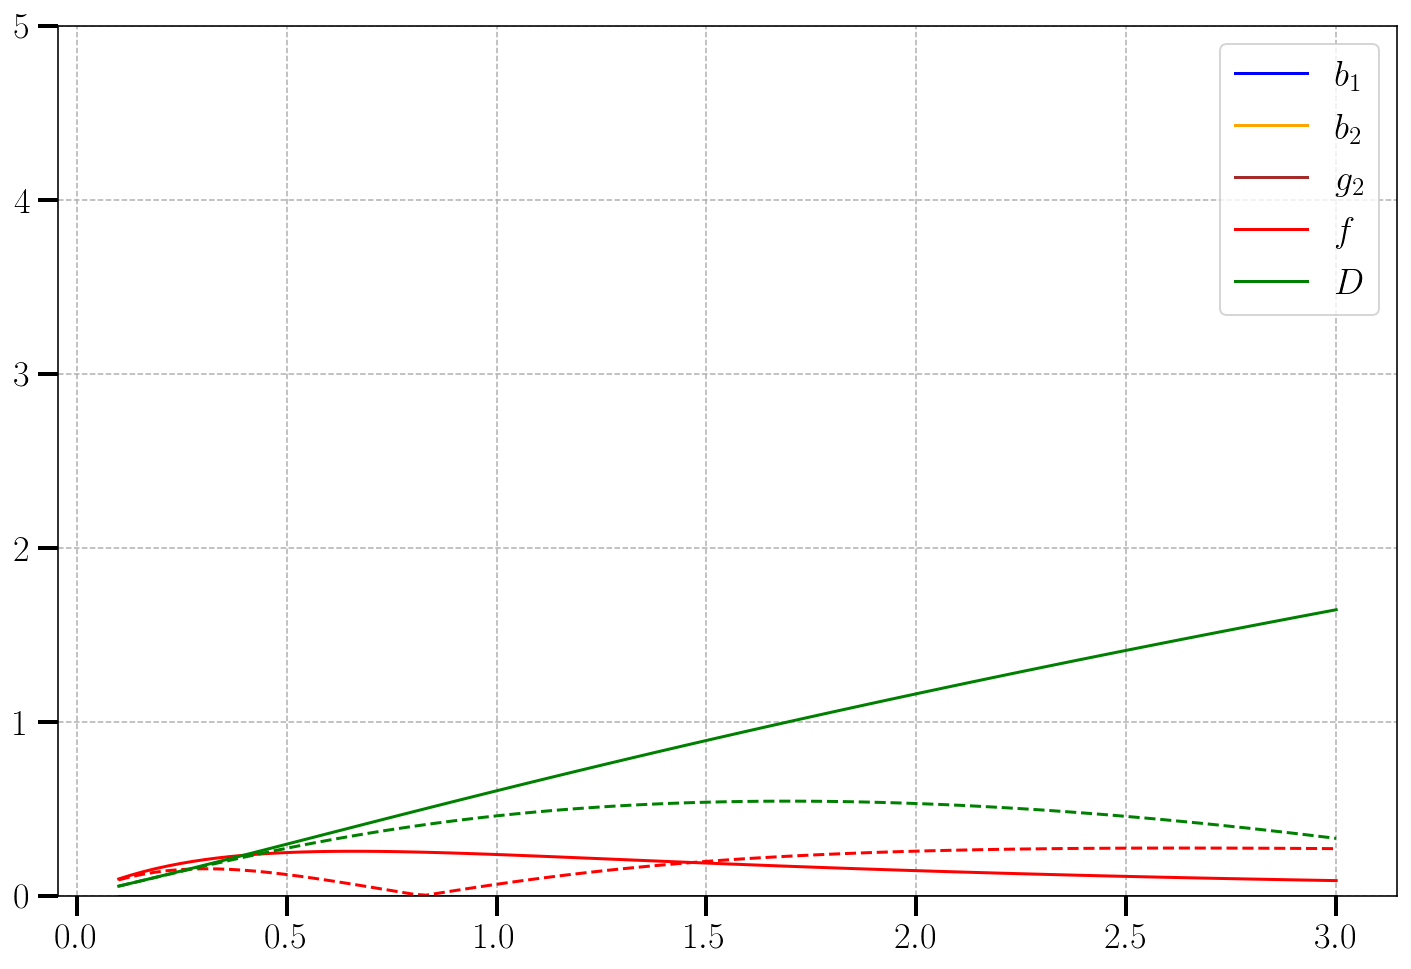

In [1177]:
#plot ratio of derivates of biases to normal term which repersents the rough size of derivative terms to wide-angle terms
plt.figure(figsize=(12,8))
z_plot = np.linspace(0.1,3,100)

plt.plot(z_plot,np.abs(cosmo_functions.b1_d(z_plot)/cosmo_functions.b_1(z_plot)),color='blue',label='$b_1$')
plt.plot(z_plot,np.abs(cosmo_functions.b1_dd(z_plot)/cosmo_functions.b_1(z_plot)),'--',color='blue')

plt.plot(z_plot,np.abs(cosmo_functions.b2_d(z_plot)/cosmo_functions.b_2(z_plot)),color='orange',label='$b_2$')
plt.plot(z_plot,np.abs(cosmo_functions.b2_dd(z_plot)/cosmo_functions.b_2(z_plot)),'--',color='orange')

plt.plot(z_plot,np.abs(cosmo_functions.g2_d(z_plot)/cosmo_functions.g_2(z_plot)),color='brown',label='$g_2$')
plt.plot(z_plot,np.abs(cosmo_functions.g2_dd(z_plot)/cosmo_functions.g_2(z_plot)),'--',color='brown')

plt.plot(z_plot,np.abs(cosmo_functions.f_d(z_plot)/cosmo_functions.f_intp(z_plot)),color='red',label='$f$')
plt.plot(z_plot,np.abs(cosmo_functions.f_dd(z_plot)/cosmo_functions.f_intp(z_plot)),'--',color='red')

plt.plot(z_plot,np.abs(cosmo_functions.D_d(z_plot)/cosmo_functions.D_intp(z_plot)),color='green',label='$D$')
plt.plot(z_plot,np.abs(cosmo_functions.D_dd(z_plot)/cosmo_functions.D_intp(z_plot)),'--',color='green')

plt.grid(ls='--',lw=0.75)
plt.ylim(0,5)
plt.legend()

$$\alpha(k,z)= \frac{2 k^2 c^2 D(z) T(k)}{3 H^2_0 \Omega_m}$$

In [1975]:
def transfer(z_,k_):
    k = cosmo.get_transfer(z_)['k (h/Mpc)']

    normalize = (cosmo.get_transfer(z_)['d_m'])[0]
    tmp = interp1d(k,cosmo.get_transfer(z_)['d_m']/normalize)
    return tmp(k_)

def M(k, z):
    """
        The scaling factor between the primordial scalar power spectrum and 
        the late-time matter power spectrum
    """
    # Rather than calculate this using a transfer function, we divide the linear 
    # matter power spectrum by our model for the primordial one and then take 
    # the square root.
    return np.sqrt( cosmo_functions.D_intp(z)**2 *cosmo_functions.Pk(k) / Pk_phi(k) )

def Pk_phi(k, k0=0.05, units=True):
    """
        Power spectrum of the Bardeen potential Phi in the matter-dominated era.
        k in units of h/Mpc.
    """
    k_pivot = k0/h
    resp = (9.0/25.0) * A_s * (k/k_pivot)**(n_s - 1.0)
    
    if units:
        resp *= 2*np.pi**2.0/k**3.0    #[Mpc/h]^3
        
    return resp

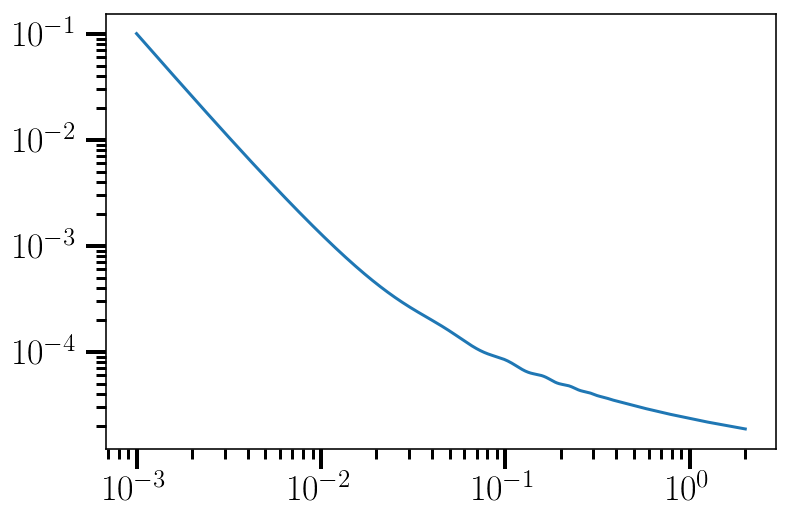

In [1972]:
plt.plot(kk,1/M(kk, 1))
plt.xscale('log')
plt.yscale('log')

## start with expression for each term!

In [2345]:
import sys
sys.path.append('bk_terms/')
from zeroth_order import *
from first_order import *
from wa2_terms import *
from der2_terms import *
from mix_terms import *
from GR import *   
from GRmix import *   

In [2263]:
import json

with open('mathematica_expr/P23l0WAGR.json') as f:
    data = json.load(f)
tmpexp = str(mathematica(data)).replace('I*','1j*').replace('-I*','-1j*').replace('sqrt(','np.sqrt(').replace('pi','np.pi')
print(tmpexp)

-8*D1**4*Pk2*Pk3*ct**7*f**2*k1*k2**3*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 18*beta19*(C - 1)*(9*r + 9*s - 4))/(315*d*k3**6) - 4*D1**4*Pk2*Pk3*ct**6*f*k2**2*(216*C*beta19*f*k1**2*r + 216*C*beta19*f*k1**2*s - 180*C*beta19*f*k1**2 + 648*C*beta19*f*k2**2*r + 648*C*beta19*f*k2**2*s - 288*C*beta19*f*k2**2 + 90*C*f*gr1*k1**2 + 63*K*b1*gr1*k1**2 - 63*b1*gr1*k1**2 - 225*beta14*f*k2**2*r - 225*beta14*f*k2**2*s + 135*beta14*f*k2**2 - 18*beta15*f*k1**2*(9*r + 9*s - 4) + 225*beta16*f*k2**2*r + 225*beta16*f*k2**2*s - 135*beta16*f*k2**2 + 15*beta17*f*k1**2*(79*r + 79*s - 59) - 395*beta18*f*k1**2*r - 395*beta18*f*k1**2*s + 295*beta18*f*k1**2 - 216*beta19*f*k1**2*r - 216*beta19*f*k1**2*s + 180*beta19*f*k1**2 - 486*beta19*f*k2**2*r - 486*beta19*f*k2**2*s + 216*beta19*f*k2**2 + 35*f**2*gr1*k1**2 - 90*f*gr1*k1**2 - 126*g2*gr1*k1**2)/(315*d*k3**6) - 8*D1**4*Pk2*Pk3*ct**5*f**2*k1*k2**3*st**2*(15*beta17*(20*r + 20*s - 13) - 5*beta18*(20*r + 20*s - 13) + 12*beta19*(C - 1)*(9*r + 9*s - 

In [148]:
with open("tmp.txt", "w") as file:
    file.write(str(tmpexp))

In [1886]:
class GR0PNG:
    def l0(params,paramsPNG):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        fNL,bE01,bE11,bE02,alphak1,alphak2,alphak3 = paramsPNG

        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = D1**4*Pk1*Pk2*(420*C*alphak1**2*alphak2**2*b1**2*f*k1**3*k2 - 420*C*alphak1**2*alphak2**2*b1**2*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1**2*alphak2**2*b1**2*f*k1*k2**3 - 42*C*alphak1**2*alphak2**2*b1*f**2*k1**3*k2*cos(4*theta) + 378*C*alphak1**2*alphak2**2*b1*f**2*k1**3*k2 - 504*C*alphak1**2*alphak2**2*b1*f**2*k1**2*k2**2*cos(3*theta) - 42*C*alphak1**2*alphak2**2*b1*f**2*k1*k2**3*cos(4*theta) + 378*C*alphak1**2*alphak2**2*b1*f**2*k1*k2**3 - 36*C*alphak1**2*alphak2**2*f**3*k1**3*k2*cos(4*theta) + 72*C*alphak1**2*alphak2**2*f**3*k1**3*k2 - 126*C*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(3*theta) - 18*C*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(5*theta) - 36*C*alphak1**2*alphak2**2*f**3*k1*k2**3*cos(4*theta) + 72*C*alphak1**2*alphak2**2*f**3*k1*k2**3 + 420*C*alphak1**2*alphak2*b1*bE01*f*k1**3*k2 - 420*C*alphak1**2*alphak2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1**2*alphak2*b1*bE01*f*k1*k2**3 + 252*C*alphak1**2*alphak2*bE01*f**2*k1**3*k2 - 252*C*alphak1**2*alphak2*bE01*f**2*k1**2*k2**2*cos(3*theta) - 42*C*alphak1**2*alphak2*bE01*f**2*k1*k2**3*cos(4*theta) + 126*C*alphak1**2*alphak2*bE01*f**2*k1*k2**3 + 420*C*alphak1*alphak2**2*b1*bE01*f*k1**3*k2 - 420*C*alphak1*alphak2**2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1*alphak2**2*b1*bE01*f*k1*k2**3 - 42*C*alphak1*alphak2**2*bE01*f**2*k1**3*k2*cos(4*theta) + 126*C*alphak1*alphak2**2*bE01*f**2*k1**3*k2 - 252*C*alphak1*alphak2**2*bE01*f**2*k1**2*k2**2*cos(3*theta) + 252*C*alphak1*alphak2**2*bE01*f**2*k1*k2**3 + 420*C*alphak1*alphak2*bE01**2*f*k1**3*k2 - 420*C*alphak1*alphak2*bE01**2*f*k1**2*k2**2*cos(3*theta) + 420*C*alphak1*alphak2*bE01**2*f*k1*k2**3 + 630*K*alphak1**2*alphak2**2*b1**3*k1*k2*k3**2 + 420*K*alphak1**2*alphak2**2*b1**2*f*k1*k2*k3**2 - 21*K*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2*cos(4*theta) + 63*K*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2 + 630*K*alphak1**2*alphak2*b1**2*bE01*k1*k2*k3**2 + 210*K*alphak1**2*alphak2*b1*bE01*f*k1*k2*k3**2 + 630*K*alphak1*alphak2**2*b1**2*bE01*k1*k2*k3**2 + 210*K*alphak1*alphak2**2*b1*bE01*f*k1*k2*k3**2 + 630*K*alphak1*alphak2*b1*bE01**2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1**3*f*k1*k2*k3**2 + 1890*alphak1**2*alphak2**2*b1**3*k1*k2*k3**2 + 1260*alphak1**2*alphak2**2*b1**2*b2*k1*k2*k3**2 + 1176*alphak1**2*alphak2**2*b1**2*f**2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1**2*f*k1**3*k2 + 420*alphak1**2*alphak2**2*b1**2*f*k1**2*k2**2*cos(3*theta) + 840*alphak1**2*alphak2**2*b1**2*f*k1*k2**3 + 1260*alphak1**2*alphak2**2*b1**2*f*k1*k2*k3**2 - 1260*alphak1**2*alphak2**2*b1**2*g2*k1*k2*k3**2 + 840*alphak1**2*alphak2**2*b1*b2*f*k1*k2*k3**2 + 36*alphak1**2*alphak2**2*b1*f**3*k1**2*k3**2*cos(3*theta) + 648*alphak1**2*alphak2**2*b1*f**3*k1*k2*k3**2 + 36*alphak1**2*alphak2**2*b1*f**3*k2**2*k3**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**4*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**3*k2*cos(4*theta) + 966*alphak1**2*alphak2**2*b1*f**2*k1**3*k2 + 588*alphak1**2*alphak2**2*b1*f**2*k1**2*k2**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1**2*k3**2*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k1*k2**3*cos(4*theta) + 966*alphak1**2*alphak2**2*b1*f**2*k1*k2**3 + 21*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2*cos(4*theta) + 273*alphak1**2*alphak2**2*b1*f**2*k1*k2*k3**2 + 42*alphak1**2*alphak2**2*b1*f**2*k2**4*cos(3*theta) + 42*alphak1**2*alphak2**2*b1*f**2*k2**2*k3**2*cos(3*theta) - 840*alphak1**2*alphak2**2*b1*f*g2*k1*k2*k3**2 + 168*alphak1**2*alphak2**2*b2*f**2*k1*k2*k3**2 + 20*alphak1**2*alphak2**2*f**4*k1**2*k3**2*cos(3*theta) + 8*alphak1**2*alphak2**2*f**4*k1*k2*k3**2*cos(4*theta) + 144*alphak1**2*alphak2**2*f**4*k1*k2*k3**2 + 20*alphak1**2*alphak2**2*f**4*k2**2*k3**2*cos(3*theta) + 36*alphak1**2*alphak2**2*f**3*k1**4*cos(3*theta) + 54*alphak1**2*alphak2**2*f**3*k1**3*k2*cos(4*theta) + 306*alphak1**2*alphak2**2*f**3*k1**3*k2 + 270*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(3*theta) + 18*alphak1**2*alphak2**2*f**3*k1**2*k2**2*cos(5*theta) + 54*alphak1**2*alphak2**2*f**3*k1*k2**3*cos(4*theta) + 306*alphak1**2*alphak2**2*f**3*k1*k2**3 + 36*alphak1**2*alphak2**2*f**3*k2**4*cos(3*theta) + 42*alphak1**2*alphak2**2*f**2*g2*k1*k2*k3**2*cos(4*theta) - 126*alphak1**2*alphak2**2*f**2*g2*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1**2*bE01*f*k1*k2*k3**2 + 1890*alphak1**2*alphak2*b1**2*bE01*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1**2*bE11*k1*k2*k3**2 + 1260*alphak1**2*alphak2*b1*b2*bE01*k1*k2*k3**2 + 1176*alphak1**2*alphak2*b1*bE01*f**2*k1*k2*k3**2 + 840*alphak1**2*alphak2*b1*bE01*f*k1**3*k2 + 420*alphak1**2*alphak2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 840*alphak1**2*alphak2*b1*bE01*f*k1*k2**3 + 630*alphak1**2*alphak2*b1*bE01*f*k1*k2*k3**2 - 1260*alphak1**2*alphak2*b1*bE01*g2*k1*k2*k3**2 + 840*alphak1**2*alphak2*b1*bE11*f*k1*k2*k3**2 + 420*alphak1**2*alphak2*b2*bE01*f*k1*k2*k3**2 + 324*alphak1**2*alphak2*bE01*f**3*k1*k2*k3**2 + 36*alphak1**2*alphak2*bE01*f**3*k2**2*k3**2*cos(3*theta) + 504*alphak1**2*alphak2*bE01*f**2*k1**3*k2 + 294*alphak1**2*alphak2*bE01*f**2*k1**2*k2**2*cos(3*theta) + 42*alphak1**2*alphak2*bE01*f**2*k1*k2**3*cos(4*theta) + 462*alphak1**2*alphak2*bE01*f**2*k1*k2**3 + 42*alphak1**2*alphak2*bE01*f**2*k2**4*cos(3*theta) - 42*alphak1**2*alphak2*bE01*f**2*k2**2*k3**2*cos(3*theta) - 420*alphak1**2*alphak2*bE01*f*g2*k1*k2*k3**2 + 168*alphak1**2*alphak2*bE11*f**2*k1*k2*k3**2 + 420*alphak1**2*b1*bE01**2*f*k1*k2*k3**2 + 1260*alphak1**2*b1*bE01*bE11*k1*k2*k3**2 + 252*alphak1**2*bE01**2*f**2*k1*k2*k3**2 + 420*alphak1**2*bE01*bE11*f*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1**2*bE01*f*k1*k2*k3**2 + 1890*alphak1*alphak2**2*b1**2*bE01*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1**2*bE11*k1*k2*k3**2 + 1260*alphak1*alphak2**2*b1*b2*bE01*k1*k2*k3**2 + 1176*alphak1*alphak2**2*b1*bE01*f**2*k1*k2*k3**2 + 840*alphak1*alphak2**2*b1*bE01*f*k1**3*k2 + 420*alphak1*alphak2**2*b1*bE01*f*k1**2*k2**2*cos(3*theta) + 840*alphak1*alphak2**2*b1*bE01*f*k1*k2**3 + 630*alphak1*alphak2**2*b1*bE01*f*k1*k2*k3**2 - 1260*alphak1*alphak2**2*b1*bE01*g2*k1*k2*k3**2 + 840*alphak1*alphak2**2*b1*bE11*f*k1*k2*k3**2 + 420*alphak1*alphak2**2*b2*bE01*f*k1*k2*k3**2 + 36*alphak1*alphak2**2*bE01*f**3*k1**2*k3**2*cos(3*theta) + 324*alphak1*alphak2**2*bE01*f**3*k1*k2*k3**2 + 42*alphak1*alphak2**2*bE01*f**2*k1**4*cos(3*theta) + 42*alphak1*alphak2**2*bE01*f**2*k1**3*k2*cos(4*theta) + 462*alphak1*alphak2**2*bE01*f**2*k1**3*k2 + 294*alphak1*alphak2**2*bE01*f**2*k1**2*k2**2*cos(3*theta) - 42*alphak1*alphak2**2*bE01*f**2*k1**2*k3**2*cos(3*theta) + 504*alphak1*alphak2**2*bE01*f**2*k1*k2**3 - 420*alphak1*alphak2**2*bE01*f*g2*k1*k2*k3**2 + 168*alphak1*alphak2**2*bE11*f**2*k1*k2*k3**2 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k1*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**3*k2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2**3 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**3*k2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2**3 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2*k3**2 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**3*k2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**3 + 2520*alphak1*alphak2*b1**2*bE02*k1*k2*k3**2 + 1680*alphak1*alphak2*b1*bE01**2*f*k1*k2*k3**2 + 1890*alphak1*alphak2*b1*bE01**2*k1*k2*k3**2 + 2520*alphak1*alphak2*b1*bE01*bE11*k1*k2*k3**2 + 1680*alphak1*alphak2*b1*bE02*f*k1*k2*k3**2 + 1260*alphak1*alphak2*b2*bE01**2*k1*k2*k3**2 + 672*alphak1*alphak2*bE01**2*f**2*k1*k2*k3**2 + 840*alphak1*alphak2*bE01**2*f*k1**3*k2 + 420*alphak1*alphak2*bE01**2*f*k1**2*k2**2*cos(3*theta) + 840*alphak1*alphak2*bE01**2*f*k1*k2**3 - 1260*alphak1*alphak2*bE01**2*g2*k1*k2*k3**2 + 840*alphak1*alphak2*bE01*bE11*f*k1*k2*k3**2 + 336*alphak1*alphak2*bE02*f**2*k1*k2*k3**2 + 2520*alphak1*alphak3*b1**2*bE01*fNL*k1*k2*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1**3*k2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1*k2**3 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1*k2*k3**2 + 504*alphak1*alphak3*bE01*f**2*fNL*k1**3*k2 + 336*alphak1*alphak3*bE01*f**2*fNL*k1*k2**3 + 2520*alphak1*b1*bE01*bE02*k1*k2*k3**2 + 420*alphak1*bE01**3*f*k1*k2*k3**2 + 1260*alphak1*bE01**2*bE11*k1*k2*k3**2 + 840*alphak1*bE01*bE02*f*k1*k2*k3**2 + 420*alphak2**2*b1*bE01**2*f*k1*k2*k3**2 + 1260*alphak2**2*b1*bE01*bE11*k1*k2*k3**2 + 252*alphak2**2*bE01**2*f**2*k1*k2*k3**2 + 420*alphak2**2*bE01*bE11*f*k1*k2*k3**2 + 2520*alphak2*alphak3*b1**2*bE01*fNL*k1*k2*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1**3*k2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2**3 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2*k3**2 + 336*alphak2*alphak3*bE01*f**2*fNL*k1**3*k2 + 504*alphak2*alphak3*bE01*f**2*fNL*k1*k2**3 + 2520*alphak2*b1*bE01*bE02*k1*k2*k3**2 + 420*alphak2*bE01**3*f*k1*k2*k3**2 + 1260*alphak2*bE01**2*bE11*k1*k2*k3**2 + 840*alphak2*bE01*bE02*f*k1*k2*k3**2 + 2520*alphak3*b1*bE01**2*fNL*k1*k2*k3**2 + 840*alphak3*bE01**2*f*fNL*k1**3*k2 + 840*alphak3*bE01**2*f*fNL*k1*k2**3 + 2520*bE01**2*bE02*k1*k2*k3**2 - 2*k1*k2*(alphak1**2*alphak2*(alphak2*(315*b1**3*k3**2*(K - 1) - 42*b1**2*(4*f**2*k3**2 - 5*f*(k1**2*(C - 2) + k2**2*(C - 2) + k3**2*(K - 1)) + 15*g2*k3**2) - 3*b1*f*(72*f**2*k3**2 - 7*f*(k1**2*(8*C - 24) + k2**2*(8*C - 24) + k3**2*(K - 5)) + 140*g2*k3**2) - 2*f**2*(32*f**2*k3**2 + f*(90 - 9*C)*(k1**2 + k2**2) + k3**2*(21*b2 + 21*g2))) + 315*b1**2*bE01*k3**2*(K - 1) - 21*b1*bE01*(8*f**2*k3**2 - 5*f*(k1**2*(2*C - 4) + k2**2*(2*C - 4) + k3**2*(K - 1)) + 30*g2*k3**2) - 6*f*(bE01*(18*f**2*k3**2 - 7*f*(k1**2*(3*C - 6) + k2**2*(C - 6)) + 35*g2*k3**2) + 7*bE11*f*k3**2)) + 3*alphak1*(alphak2**2*(105*b1**2*bE01*k3**2*(K - 1) - 7*b1*bE01*(8*f**2*k3**2 - 5*f*(k1**2*(2*C - 4) + k2**2*(2*C - 4) + k3**2*(K - 1)) + 30*g2*k3**2) - 2*f*(bE01*(18*f**2*k3**2 - 7*f*(k1**2*(C - 6) + k2**2*(3*C - 6)) + 35*g2*k3**2) + 7*bE11*f*k3**2)) - alphak2*(7*bE01**2*(8*f**2*k3**2 + f*(20 - 10*C)*(k1**2 + k2**2) + k3**2*(-15*K*b1 + 15*b1 + 30*g2)) + 4*f**2*(alphak3*fNL*(7*b1*(k1**2 + k2**2 + k3**2) + 6*f*(k1**2 + k2**2)) + 7*bE02*k3**2)) - 28*alphak3*bE01*f**2*fNL*k2**2) - 84*alphak2*alphak3*bE01*f**2*fNL*k1**2)*cos(2*theta) + (6*alphak1**2*(alphak2**2*(70*b1**3*k3**2*(f + 3)*(k1**2 + k2**2) + 14*b1**2*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(9*f + 10)) + 5*k2**4 + k2**2*k3**2*(9*f + 10)) + 7*b1*f**2*(11*k1**4 + k1**2*(k2**2*(12*C + 58) + k3**2*(12*f + 5)) + 11*k2**4 + k2**2*k3**2*(12*f + 5)) + 4*f**3*(5*f*k2**2*k3**2 + 6*k1**4 + k1**2*(5*f*k3**2 + k2**2*(6*C + 33)) + 6*k2**4)) + alphak2*bE01*(70*b1**2*k3**2*(2*f*k2**2 + k1**2*(f + 3)) + 14*b1*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(6*f + 5)) + 5*k2**4 + k2**2*k3**2*(12*f - 5)) + f**2*(42*k1**4 + k1**2*(30*f*k3**2 + k2**2*(42*C + 203)) + 35*k2**4 + k2**2*k3**2*(54*f - 35))) + 14*bE01**2*k2**2*k3**2*(5*b1*(f - 3) + f*(3*f - 5))) + 6*alphak1*(alphak2**2*bE01*(70*b1**2*k3**2*(f*(2*k1**2 + k2**2) + 3*k2**2) + 14*b1*f*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(12*f - 5)) + 5*k2**4 + k2**2*k3**2*(6*f + 5)) + f**2*(35*k1**4 + k1**2*(k2**2*(42*C + 203) + k3**2*(54*f - 35)) + 6*k2**2*(5*f*k3**2 + 7*k2**2))) + 2*alphak2*f*(2*alphak3*fNL*k1**2*k2**2*(70*b1**2 + 84*b1*f + 27*f**2) + 7*bE01**2*(5*k1**4 + k1**2*(k2**2*(5*C + 25) + k3**2*(10*b1 + 6*f - 5)) + 5*k2**4 + k2**2*k3**2*(10*b1 + 6*f - 5))) + 14*bE01*k2**2*(4*alphak3*f*fNL*k1**2*(5*b1 + 3*f) + 5*bE01**2*k3**2*(f - 3))) + 84*bE01*k1**2*(alphak2**2*bE01*k3**2*(5*b1*(f - 3) + f*(3*f - 5)) + alphak2*(4*alphak3*f*fNL*k2**2*(5*b1 + 3*f) + 5*bE01**2*k3**2*(f - 3)) + 20*alphak3*bE01*f*fNL*k2**2))*cos(theta))/(1260*alphak1**2*alphak2**2*k1*k2*k3**2)
        perm13 = D1**4*Pk1*Pk3*(-840*C*alphak1**2*alphak3**2*b1**2*f*k1**3*k3**2 - 420*C*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 + 840*C*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 - 336*C*alphak1**2*alphak3**2*b1*f**2*k1**5 - 168*C*alphak1**2*alphak3**2*b1*f**2*k1**4*k2*cos(3*theta) - 42*C*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(4*theta) - 1722*C*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 - 252*C*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) - 168*C*alphak1**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(3*theta) - 252*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 - 42*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(4*theta) + 294*C*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 + 336*C*alphak1**2*alphak3**2*b1*f**2*k1*k3**4 - 216*C*alphak1**2*alphak3**2*f**3*k1**5 - 216*C*alphak1**2*alphak3**2*f**3*k1**4*k2*cos(3*theta) - 108*C*alphak1**2*alphak3**2*f**3*k1**3*k2**2*cos(4*theta) - 1008*C*alphak1**2*alphak3**2*f**3*k1**3*k2**2 + 216*C*alphak1**2*alphak3**2*f**3*k1**3*k3**2 - 342*C*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(3*theta) - 18*C*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(5*theta) + 72*C*alphak1**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(3*theta) - 36*C*alphak1**2*alphak3**2*f**3*k1*k2**4*cos(4*theta) - 144*C*alphak1**2*alphak3**2*f**3*k1*k2**4 + 216*C*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2 - 840*C*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 - 420*C*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 840*C*alphak1**2*alphak3*b1*bE01*f*k1*k3**4 - 336*C*alphak1**2*alphak3*bE01*f**2*k1**3*k3**2 - 168*C*alphak1**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) - 42*C*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(4*theta) - 210*C*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2 + 336*C*alphak1**2*alphak3*bE01*f**2*k1*k3**4 - 840*C*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 - 420*C*alphak1*alphak3**2*b1*bE01*f*k1*k2**2*k3**2 + 840*C*alphak1*alphak3**2*b1*bE01*f*k1*k3**4 - 336*C*alphak1*alphak3**2*bE01*f**2*k1**5 - 168*C*alphak1*alphak3**2*bE01*f**2*k1**4*k2*cos(3*theta) - 42*C*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2*cos(4*theta) - 1722*C*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2 + 336*C*alphak1*alphak3**2*bE01*f**2*k1**3*k3**2 - 252*C*alphak1*alphak3**2*bE01*f**2*k1**2*k2**3*cos(3*theta) - 252*C*alphak1*alphak3**2*bE01*f**2*k1*k2**4 + 504*C*alphak1*alphak3**2*bE01*f**2*k1*k2**2*k3**2 - 840*C*alphak1*alphak3*bE01**2*f*k1**3*k3**2 - 420*C*alphak1*alphak3*bE01**2*f*k1*k2**2*k3**2 + 840*C*alphak1*alphak3*bE01**2*f*k1*k3**4 - 1260*K*alphak1**2*alphak3**2*b1**3*k1**3*k3**2 - 630*K*alphak1**2*alphak3**2*b1**3*k1*k2**2*k3**2 + 1260*K*alphak1**2*alphak3**2*b1**3*k1*k3**4 - 420*K*alphak1**2*alphak3**2*b1**2*f*k1**5 - 1470*K*alphak1**2*alphak3**2*b1**2*f*k1**3*k2**2 - 210*K*alphak1**2*alphak3**2*b1**2*f*k1**2*k2**3*cos(3*theta) - 210*K*alphak1**2*alphak3**2*b1**2*f*k1*k2**4 + 210*K*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 + 420*K*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 - 252*K*alphak1**2*alphak3**2*b1*f**2*k1**5 - 798*K*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 + 252*K*alphak1**2*alphak3**2*b1*f**2*k1**3*k3**2 - 210*K*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) - 21*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**4*cos(4*theta) - 105*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 + 168*K*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 - 1260*K*alphak1**2*alphak3*b1**2*bE01*k1**3*k3**2 - 630*K*alphak1**2*alphak3*b1**2*bE01*k1*k2**2*k3**2 + 1260*K*alphak1**2*alphak3*b1**2*bE01*k1*k3**4 - 420*K*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 - 210*K*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 420*K*alphak1**2*alphak3*b1*bE01*f*k1*k3**4 - 1260*K*alphak1*alphak3**2*b1**2*bE01*k1**3*k3**2 - 630*K*alphak1*alphak3**2*b1**2*bE01*k1*k2**2*k3**2 + 1260*K*alphak1*alphak3**2*b1**2*bE01*k1*k3**4 - 420*K*alphak1*alphak3**2*b1*bE01*f*k1**5 - 1470*K*alphak1*alphak3**2*b1*bE01*f*k1**3*k2**2 + 420*K*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 - 210*K*alphak1*alphak3**2*b1*bE01*f*k1**2*k2**3*cos(3*theta) - 210*K*alphak1*alphak3**2*b1*bE01*f*k1*k2**4 + 420*K*alphak1*alphak3**2*b1*bE01*f*k1*k2**2*k3**2 - 1260*K*alphak1*alphak3*b1*bE01**2*k1**3*k3**2 - 630*K*alphak1*alphak3*b1*bE01**2*k1*k2**2*k3**2 + 1260*K*alphak1*alphak3*b1*bE01**2*k1*k3**4 + 420*alphak1**2*alphak3**2*b1**3*f*k1*k2**2*k3**2 + 630*alphak1**2*alphak3**2*b1**3*k1*k2**2*k3**2 + 1260*alphak1**2*alphak3**2*b1**2*b2*k1*k3**4 + 504*alphak1**2*alphak3**2*b1**2*f**2*k1**3*k2**2 + 252*alphak1**2*alphak3**2*b1**2*f**2*k1*k2**4 - 336*alphak1**2*alphak3**2*b1**2*f**2*k1*k2**2*k3**2 + 630*alphak1**2*alphak3**2*b1**2*f*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1**2*f*k1**3*k3**2 + 210*alphak1**2*alphak3**2*b1**2*f*k1**2*k2**3*cos(3*theta) + 210*alphak1**2*alphak3**2*b1**2*f*k1*k2**4 + 210*alphak1**2*alphak3**2*b1**2*f*k1*k2**2*k3**2 - 420*alphak1**2*alphak3**2*b1**2*f*k1*k3**4 + 2520*alphak1**2*alphak3**2*b1**2*g2*k1**3*k3**2 + 1260*alphak1**2*alphak3**2*b1**2*g2*k1*k2**2*k3**2 - 2520*alphak1**2*alphak3**2*b1**2*g2*k1*k3**4 + 420*alphak1**2*alphak3**2*b1*b2*f*k1**3*k3**2 + 420*alphak1**2*alphak3**2*b1*b2*f*k1*k2**2*k3**2 + 420*alphak1**2*alphak3**2*b1*b2*f*k1*k3**4 + 216*alphak1**2*alphak3**2*b1*f**3*k1**3*k2**2 - 216*alphak1**2*alphak3**2*b1*f**3*k1*k2**4 - 324*alphak1**2*alphak3**2*b1*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3**2*b1*f**3*k2**3*k3**2*cos(3*theta) + 168*alphak1**2*alphak3**2*b1*f**2*k1**5 + 126*alphak1**2*alphak3**2*b1*f**2*k1**4*k2*cos(3*theta) + 42*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(4*theta) + 1596*alphak1**2*alphak3**2*b1*f**2*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(3*theta) + 84*alphak1**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(3*theta) + 21*alphak1**2*alphak3**2*b1*f**2*k1*k2**4*cos(4*theta) + 357*alphak1**2*alphak3**2*b1*f**2*k1*k2**4 + 42*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(4*theta) - 546*alphak1**2*alphak3**2*b1*f**2*k1*k2**2*k3**2 - 168*alphak1**2*alphak3**2*b1*f**2*k1*k3**4 - 42*alphak1**2*alphak3**2*b1*f**2*k2**3*k3**2*cos(3*theta) - 42*alphak1**2*alphak3**2*b1*f**2*k2*k3**4*cos(3*theta) + 840*alphak1**2*alphak3**2*b1*f*g2*k1**5 + 2940*alphak1**2*alphak3**2*b1*f*g2*k1**3*k2**2 + 420*alphak1**2*alphak3**2*b1*f*g2*k1**2*k2**3*cos(3*theta) + 420*alphak1**2*alphak3**2*b1*f*g2*k1*k2**4 - 420*alphak1**2*alphak3**2*b1*f*g2*k1*k2**2*k3**2 - 840*alphak1**2*alphak3**2*b1*f*g2*k1*k3**4 + 252*alphak1**2*alphak3**2*b2*f**2*k1**3*k3**2 + 168*alphak1**2*alphak3**2*b2*f**2*k1*k2**2*k3**2 - 80*alphak1**2*alphak3**2*f**4*k1**3*k2**2 - 60*alphak1**2*alphak3**2*f**4*k1**2*k2**3*cos(3*theta) - 12*alphak1**2*alphak3**2*f**4*k1*k2**4*cos(4*theta) - 216*alphak1**2*alphak3**2*f**4*k1*k2**4 - 20*alphak1**2*alphak3**2*f**4*k2**5*cos(3*theta) + 108*alphak1**2*alphak3**2*f**3*k1**5 + 144*alphak1**2*alphak3**2*f**3*k1**4*k2*cos(3*theta) + 90*alphak1**2*alphak3**2*f**3*k1**3*k2**2*cos(4*theta) + 738*alphak1**2*alphak3**2*f**3*k1**3*k2**2 - 108*alphak1**2*alphak3**2*f**3*k1**3*k3**2 + 306*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(3*theta) + 18*alphak1**2*alphak3**2*f**3*k1**2*k2**3*cos(5*theta) - 72*alphak1**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(3*theta) + 36*alphak1**2*alphak3**2*f**3*k1*k2**4*cos(4*theta) + 144*alphak1**2*alphak3**2*f**3*k1*k2**4 - 18*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(4*theta) - 270*alphak1**2*alphak3**2*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3**2*f**3*k2**3*k3**2*cos(3*theta) + 504*alphak1**2*alphak3**2*f**2*g2*k1**5 + 1596*alphak1**2*alphak3**2*f**2*g2*k1**3*k2**2 - 504*alphak1**2*alphak3**2*f**2*g2*k1**3*k3**2 + 420*alphak1**2*alphak3**2*f**2*g2*k1**2*k2**3*cos(3*theta) + 42*alphak1**2*alphak3**2*f**2*g2*k1*k2**4*cos(4*theta) + 210*alphak1**2*alphak3**2*f**2*g2*k1*k2**4 - 336*alphak1**2*alphak3**2*f**2*g2*k1*k2**2*k3**2 + 420*alphak1**2*alphak3*b1**2*bE01*f*k1*k2**2*k3**2 + 630*alphak1**2*alphak3*b1**2*bE01*k1*k2**2*k3**2 + 1260*alphak1**2*alphak3*b1**2*bE01*k1*k3**4 + 1260*alphak1**2*alphak3*b1**2*bE11*k1*k3**4 + 1260*alphak1**2*alphak3*b1*b2*bE01*k1*k3**4 - 336*alphak1**2*alphak3*b1*bE01*f**2*k1*k2**2*k3**2 + 840*alphak1**2*alphak3*b1*bE01*f*k1**3*k3**2 + 1470*alphak1**2*alphak3*b1*bE01*f*k1*k2**2*k3**2 + 2520*alphak1**2*alphak3*b1*bE01*g2*k1**3*k3**2 + 1260*alphak1**2*alphak3*b1*bE01*g2*k1*k2**2*k3**2 - 2520*alphak1**2*alphak3*b1*bE01*g2*k1*k3**4 + 420*alphak1**2*alphak3*b1*bE11*f*k1**3*k3**2 + 420*alphak1**2*alphak3*b1*bE11*f*k1*k2**2*k3**2 + 420*alphak1**2*alphak3*b1*bE11*f*k1*k3**4 + 420*alphak1**2*alphak3*b2*bE01*f*k1*k3**4 - 324*alphak1**2*alphak3*bE01*f**3*k1*k2**2*k3**2 - 36*alphak1**2*alphak3*bE01*f**3*k2**3*k3**2*cos(3*theta) + 420*alphak1**2*alphak3*bE01*f**2*k1**3*k3**2 + 126*alphak1**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) + 42*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(4*theta) + 630*alphak1**2*alphak3*bE01*f**2*k1*k2**2*k3**2 - 168*alphak1**2*alphak3*bE01*f**2*k1*k3**4 + 42*alphak1**2*alphak3*bE01*f**2*k2**3*k3**2*cos(3*theta) - 42*alphak1**2*alphak3*bE01*f**2*k2*k3**4*cos(3*theta) + 840*alphak1**2*alphak3*bE01*f*g2*k1**3*k3**2 + 420*alphak1**2*alphak3*bE01*f*g2*k1*k2**2*k3**2 - 840*alphak1**2*alphak3*bE01*f*g2*k1*k3**4 + 252*alphak1**2*alphak3*bE11*f**2*k1**3*k3**2 + 168*alphak1**2*alphak3*bE11*f**2*k1*k2**2*k3**2 + 1260*alphak1**2*b1*bE01**2*k1*k3**4 + 1260*alphak1**2*b1*bE01*bE11*k1*k3**4 + 420*alphak1**2*bE01**2*f*k1*k3**4 + 420*alphak1**2*bE01*bE11*f*k1*k3**4 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k1*k3**4 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**3*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k2**2*k3**2 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k1*k3**4 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**3*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k2**2*k3**2 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k1*k3**4 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**3*k3**2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2*k3**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**2*k3**2 + 2520*alphak1*alphak2*b1**2*bE01*fNL*k1*k3**4 + 1680*alphak1*alphak2*b1*bE01*f*fNL*k1*k3**4 + 336*alphak1*alphak2*bE01*f**2*fNL*k1*k3**4 + 840*alphak1*alphak3**2*b1**2*bE01*f*k1*k2**2*k3**2 + 1260*alphak1*alphak3**2*b1**2*bE01*k1**3*k3**2 + 630*alphak1*alphak3**2*b1**2*bE01*k1*k2**2*k3**2 + 1260*alphak1*alphak3**2*b1**2*bE11*k1*k3**4 + 1260*alphak1*alphak3**2*b1*b2*bE01*k1*k3**4 + 1008*alphak1*alphak3**2*b1*bE01*f**2*k1**3*k2**2 + 504*alphak1*alphak3**2*b1*bE01*f**2*k1*k2**4 - 336*alphak1*alphak3**2*b1*bE01*f**2*k1*k2**2*k3**2 + 420*alphak1*alphak3**2*b1*bE01*f*k1**5 + 1470*alphak1*alphak3**2*b1*bE01*f*k1**3*k2**2 + 840*alphak1*alphak3**2*b1*bE01*f*k1**3*k3**2 + 210*alphak1*alphak3**2*b1*bE01*f*k1**2*k2**3*cos(3*theta) + 210*alphak1*alphak3**2*b1*bE01*f*k1*k2**4 - 420*alphak1*alphak3**2*b1*bE01*f*k1*k3**4 + 2520*alphak1*alphak3**2*b1*bE01*g2*k1**3*k3**2 + 1260*alphak1*alphak3**2*b1*bE01*g2*k1*k2**2*k3**2 - 2520*alphak1*alphak3**2*b1*bE01*g2*k1*k3**4 + 420*alphak1*alphak3**2*b1*bE11*f*k1**3*k3**2 + 420*alphak1*alphak3**2*b1*bE11*f*k1*k2**2*k3**2 + 420*alphak1*alphak3**2*b1*bE11*f*k1*k3**4 + 420*alphak1*alphak3**2*b2*bE01*f*k1**3*k3**2 + 420*alphak1*alphak3**2*b2*bE01*f*k1*k2**2*k3**2 + 216*alphak1*alphak3**2*bE01*f**3*k1**3*k2**2 - 216*alphak1*alphak3**2*bE01*f**3*k1*k2**4 + 420*alphak1*alphak3**2*bE01*f**2*k1**5 + 126*alphak1*alphak3**2*bE01*f**2*k1**4*k2*cos(3*theta) + 42*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2*cos(4*theta) + 1638*alphak1*alphak3**2*bE01*f**2*k1**3*k2**2 - 168*alphak1*alphak3**2*bE01*f**2*k1**3*k3**2 + 294*alphak1*alphak3**2*bE01*f**2*k1**2*k2**3*cos(3*theta) - 42*alphak1*alphak3**2*bE01*f**2*k1**2*k2*k3**2*cos(3*theta) + 252*alphak1*alphak3**2*bE01*f**2*k1*k2**4 - 504*alphak1*alphak3**2*bE01*f**2*k1*k2**2*k3**2 + 840*alphak1*alphak3**2*bE01*f*g2*k1**5 + 2940*alphak1*alphak3**2*bE01*f*g2*k1**3*k2**2 - 840*alphak1*alphak3**2*bE01*f*g2*k1**3*k3**2 + 420*alphak1*alphak3**2*bE01*f*g2*k1**2*k2**3*cos(3*theta) + 420*alphak1*alphak3**2*bE01*f*g2*k1*k2**4 - 840*alphak1*alphak3**2*bE01*f*g2*k1*k2**2*k3**2 + 252*alphak1*alphak3**2*bE11*f**2*k1**3*k3**2 + 168*alphak1*alphak3**2*bE11*f**2*k1*k2**2*k3**2 + 2520*alphak1*alphak3*b1**2*bE02*k1*k3**4 + 840*alphak1*alphak3*b1*bE01**2*f*k1*k2**2*k3**2 + 1260*alphak1*alphak3*b1*bE01**2*k1**3*k3**2 + 630*alphak1*alphak3*b1*bE01**2*k1*k2**2*k3**2 + 1260*alphak1*alphak3*b1*bE01**2*k1*k3**4 + 2520*alphak1*alphak3*b1*bE01*bE11*k1*k3**4 + 840*alphak1*alphak3*b1*bE02*f*k1**3*k3**2 + 840*alphak1*alphak3*b1*bE02*f*k1*k2**2*k3**2 + 840*alphak1*alphak3*b1*bE02*f*k1*k3**4 + 1260*alphak1*alphak3*b2*bE01**2*k1*k3**4 - 336*alphak1*alphak3*bE01**2*f**2*k1*k2**2*k3**2 + 1260*alphak1*alphak3*bE01**2*f*k1**3*k3**2 + 1260*alphak1*alphak3*bE01**2*f*k1*k2**2*k3**2 - 420*alphak1*alphak3*bE01**2*f*k1*k3**4 + 2520*alphak1*alphak3*bE01**2*g2*k1**3*k3**2 + 1260*alphak1*alphak3*bE01**2*g2*k1*k2**2*k3**2 - 2520*alphak1*alphak3*bE01**2*g2*k1*k3**4 + 420*alphak1*alphak3*bE01*bE11*f*k1**3*k3**2 + 420*alphak1*alphak3*bE01*bE11*f*k1*k2**2*k3**2 + 420*alphak1*alphak3*bE01*bE11*f*k1*k3**4 + 504*alphak1*alphak3*bE02*f**2*k1**3*k3**2 + 336*alphak1*alphak3*bE02*f**2*k1*k2**2*k3**2 + 2520*alphak1*b1*bE01*bE02*k1*k3**4 + 1260*alphak1*bE01**3*k1*k3**4 + 1260*alphak1*bE01**2*bE11*k1*k3**4 + 840*alphak1*bE01*bE02*f*k1*k3**4 + 2520*alphak2*alphak3*b1**2*bE01*fNL*k1*k3**4 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1**3*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k2**2*k3**2 + 840*alphak2*alphak3*b1*bE01*f*fNL*k1*k3**4 + 336*alphak2*alphak3*bE01*f**2*fNL*k1**3*k3**2 + 504*alphak2*alphak3*bE01*f**2*fNL*k1*k2**2*k3**2 + 2520*alphak2*b1*bE01**2*fNL*k1*k3**4 + 840*alphak2*bE01**2*f*fNL*k1*k3**4 + 420*alphak3**2*b1*bE01**2*f*k1*k2**2*k3**2 + 1260*alphak3**2*b1*bE01**2*k1**3*k3**2 + 1260*alphak3**2*b1*bE01*bE11*k1*k3**4 + 504*alphak3**2*bE01**2*f**2*k1**3*k2**2 + 252*alphak3**2*bE01**2*f**2*k1*k2**4 + 420*alphak3**2*bE01**2*f*k1**5 + 840*alphak3**2*bE01**2*f*k1**3*k2**2 + 420*alphak3**2*bE01*bE11*f*k1**3*k3**2 + 420*alphak3**2*bE01*bE11*f*k1*k2**2*k3**2 + 2520*alphak3*b1*bE01*bE02*k1*k3**4 + 420*alphak3*bE01**3*f*k1*k2**2*k3**2 + 1260*alphak3*bE01**3*k1**3*k3**2 + 1260*alphak3*bE01**2*bE11*k1*k3**4 + 840*alphak3*bE01*bE02*f*k1**3*k3**2 + 840*alphak3*bE01*bE02*f*k1*k2**2*k3**2 + 2520*bE01**2*bE02*k1*k3**4 - 6*k1*(alphak1**2*alphak3*(alphak3*(105*b1**3*k2**2*k3**2*(K - 1) + 7*b1**2*k2**2*(f**2*(-6*k1**2 + 4*k3**2) + 5*f*(k1**2*(5*K - 3) + k2**2*(K - 1) + k3**2*(2*C + K - 1)) - 30*g2*k3**2) + b1*f*(12*f**2*k2**2*(-2*k1**2 + 2*k2**2 + 3*k3**2) + 7*f*(k1**4*(4*C - 2) + k1**2*k2**2*(30*C + 17*K - 33) + k2**4*(6*C + 3*K - 9) + k2**2*k3**2*(6*C - 2*K + 6) + k3**4*(2 - 4*C)) - 70*g2*k2**2*(5*k1**2 + k2**2 + k3**2)) + 2*f**2*(f**2*(5*k1**2*k2**2 + 16*k2**4) + 3*f*(k1**4*(4*C - 2) + k1**2*(k2**2*(29*C - 22) + k3**2*(2 - 4*C)) + k2**4*(5*C - 5) + k2**2*k3**2*(7 - 4*C)) - 7*k2**2*(b2*k3**2 + g2*(17*k1**2 + 3*k2**2 - 2*k3**2)))) + k3**2*(bE01*(105*b1*k2**2*(b1*(K - 1) - 2*g2) + 36*f**3*k2**2 + 14*f**2*(k1**2*(2*C - 1) + k2**2*(3*C + 2*b1 - 7) + k3**2*(1 - 2*C)) + 35*f*k2**2*(b1*(2*C + K - 5) - 2*g2)) - 14*bE11*f**2*k2**2)) - alphak1*(28*alphak2*bE01*f**2*fNL*k3**4 + alphak3**2*(bE01*(-105*b1*k2**2*k3**2*(b1*(K - 1) - 2*g2) + 24*f**3*k2**2*(k1**2 - k2**2) - 14*f**2*(k1**4*(2*C - 1) + k1**2*(k2**2*(15*C - 6*b1 - 16) + k3**2*(1 - 2*C)) + k2**4*(3*C - 3) + k2**2*k3**2*(2*b1 + 3)) - 35*f*k2**2*(b1*(2*C*k3**2 + k1**2*(5*K - 5) + k2**2*(K - 1)) - 2*g2*(5*k1**2 + k2**2))) + 14*bE11*f**2*k2**2*k3**2) + alphak3*k3**2*(4*alphak2*f**2*fNL*(7*b1*(k1**2 + k2**2 + k3**2) + 6*f*(k1**2 + k2**2)) + k2**2*(-105*b1*bE01**2*(K - 1) - 14*bE01**2*(2*f**2 + f*(5*C - 10) - 15*g2) + 28*bE02*f**2))) - 14*alphak3*bE01*f*k1**2*(2*alphak2*f*fNL*k3**2 + alphak3*bE01*k2**2*(3*f + 5)))*cos(2*theta) + 6*k2*(alphak1**2*(alphak3**2*(70*b1**3*(k1**2*k3**2*(-6*K + f + 3) - k3**4*(f + 3)) + 7*b1**2*(6*f**2*(k1**4 + 3*k1**2*k2**2 - k3**2*(2*k2**2 + k3**2)) - 5*f*(k1**4*(8*K - 2) + k1**2*(k2**2*(7*K - 5) + k3**2*(8*C - 6)) + 2*k3**2*(k2**2 + 2*k3**2)) + 120*g2*k1**2*k3**2) + b1*f*(6*f**2*(5*k1**4 - 5*k1**2*k3**2 - 5*k2**4 - 9*k2**2*k3**2) - 7*f*(k1**4*(44*C + 24*K - 33) + k1**2*(k2**2*(42*C + 19*K - 50) - k3**2*(4*C + 12*K - 8)) + 11*k2**2*k3**2 + 5*k3**4) + 70*k1**2*(2*b2*k3**2 + 8*g2*k1**2 + 7*g2*k2**2)) + 2*f**2*(-10*f**2*(3*k1**2*k2**2 + k2**4) - 3*f*(k1**4*(34*C - 21) + k1**2*(k2**2*(30*C - 26) + k3**2*(13 - 18*C)) + 4*k2**2*k3**2) + 7*k1**2*(6*b2*k3**2 + g2*(24*k1**2 + 19*k2**2 - 12*k3**2)))) + alphak3*k3**2*(70*b1**2*bE01*(-2*f*k3**2 + k1**2*(-6*K + f + 3)) - 14*b1*(bE01*(6*f**2*(k2**2 + k3**2) + 5*f*(k1**2*(4*C + 2*K - 7) - k2**2 + k3**2) - 60*g2*k1**2) - 10*bE11*f*k1**2) + f*(bE01*(-6*f**2*(5*k1**2 + 9*k2**2) - 7*f*(k1**2*(20*C - 33) - 5*k2**2 + 5*k3**2) + 280*g2*k1**2) + 84*bE11*f*k1**2)) + 14*bE01**2*k3**4*(-5*b1*(f - 3) + f*(5 - 3*f))) + alphak1*(alphak3**2*(-70*b1**2*bE01*k3**2*(k1**2*(6*K - 2*f - 6) + k3**2*(f + 3)) + 7*b1*(bE01*(12*f**2*(k1**4 + 3*k1**2*k2**2 - k2**2*k3**2) - 5*f*(k1**4*(8*K - 8) + k1**2*(k2**2*(7*K - 7) + k3**2*(8*C - 4*K - 6)) + 2*k3**2*(k2**2 + k3**2)) + 120*g2*k1**2*k3**2) + 20*bE11*f*k1**2*k3**2) + f*(bE01*(30*f**2*(k1**4 - k2**4) - 7*f*(k1**4*(44*C - 45) + k1**2*(k2**2*(42*C - 41) + k3**2*(17 - 24*C)) + 6*k2**2*k3**2) + 70*k1**2*(2*b2*k3**2 + g2*(8*k1**2 + 7*k2**2 - 4*k3**2))) + 84*bE11*f*k1**2*k3**2)) + 2*alphak3*k3**2*(140*alphak2*b1**2*f*fNL*k1**2 + 14*b1*(5*bE01**2*(-f*k3**2 + k1**2*(-3*K + f + 3)) + 2*f*k1**2*(6*alphak2*f*fNL + 5*bE02)) - 7*bE01**2*(6*f**2*k2**2 + 5*f*(k1**2*(4*C - 7) - k2**2 + k3**2) - 60*g2*k1**2) + 70*bE01*bE11*f*k1**2 + 6*f**2*k1**2*(9*alphak2*f*fNL + 14*bE02)) - 70*bE01**3*k3**4*(f - 3)) + 14*alphak3*bE01*k1**2*(alphak3*(bE01*(15*b1*k3**2 + 3*f**2*(k1**2 + 3*k2**2) + 5*f*(b1*k3**2 + 3*k1**2 + k2**2)) + 10*bE11*f*k3**2) + k3**2*(5*bE01**2*(f + 3) + 4*f*(5*alphak2*b1*fNL + 3*alphak2*f*fNL + 5*bE02))))*cos(theta))/(1260*alphak1**2*alphak3**2*k1*k3**4)
        perm23 = D1**4*Pk2*Pk3*(-420*C*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 - 840*C*alphak2**2*alphak3**2*b1**2*f*k2**3*k3**2 + 840*C*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 - 252*C*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 - 252*C*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 42*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(4*theta) - 1722*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 - 42*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(4*theta) + 294*C*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 - 168*C*alphak2**2*alphak3**2*b1*f**2*k1*k2**4*cos(3*theta) - 168*C*alphak2**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(3*theta) - 336*C*alphak2**2*alphak3**2*b1*f**2*k2**5 + 336*C*alphak2**2*alphak3**2*b1*f**2*k2*k3**4 - 36*C*alphak2**2*alphak3**2*f**3*k1**4*k2*cos(4*theta) - 144*C*alphak2**2*alphak3**2*f**3*k1**4*k2 - 342*C*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(3*theta) - 18*C*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(5*theta) - 108*C*alphak2**2*alphak3**2*f**3*k1**2*k2**3*cos(4*theta) - 1008*C*alphak2**2*alphak3**2*f**3*k1**2*k2**3 + 216*C*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2 - 216*C*alphak2**2*alphak3**2*f**3*k1*k2**4*cos(3*theta) + 72*C*alphak2**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(3*theta) - 216*C*alphak2**2*alphak3**2*f**3*k2**5 + 216*C*alphak2**2*alphak3**2*f**3*k2**3*k3**2 - 420*C*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 - 840*C*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 840*C*alphak2**2*alphak3*b1*bE01*f*k2*k3**4 - 42*C*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(4*theta) - 210*C*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2 - 168*C*alphak2**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) - 336*C*alphak2**2*alphak3*bE01*f**2*k2**3*k3**2 + 336*C*alphak2**2*alphak3*bE01*f**2*k2*k3**4 - 420*C*alphak2*alphak3**2*b1*bE01*f*k1**2*k2*k3**2 - 840*C*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 + 840*C*alphak2*alphak3**2*b1*bE01*f*k2*k3**4 - 252*C*alphak2*alphak3**2*bE01*f**2*k1**4*k2 - 252*C*alphak2*alphak3**2*bE01*f**2*k1**3*k2**2*cos(3*theta) - 42*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3*cos(4*theta) - 1722*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3 + 504*C*alphak2*alphak3**2*bE01*f**2*k1**2*k2*k3**2 - 168*C*alphak2*alphak3**2*bE01*f**2*k1*k2**4*cos(3*theta) - 336*C*alphak2*alphak3**2*bE01*f**2*k2**5 + 336*C*alphak2*alphak3**2*bE01*f**2*k2**3*k3**2 - 420*C*alphak2*alphak3*bE01**2*f*k1**2*k2*k3**2 - 840*C*alphak2*alphak3*bE01**2*f*k2**3*k3**2 + 840*C*alphak2*alphak3*bE01**2*f*k2*k3**4 - 630*K*alphak2**2*alphak3**2*b1**3*k1**2*k2*k3**2 - 1260*K*alphak2**2*alphak3**2*b1**3*k2**3*k3**2 + 1260*K*alphak2**2*alphak3**2*b1**3*k2*k3**4 - 210*K*alphak2**2*alphak3**2*b1**2*f*k1**4*k2 - 210*K*alphak2**2*alphak3**2*b1**2*f*k1**3*k2**2*cos(3*theta) - 1470*K*alphak2**2*alphak3**2*b1**2*f*k1**2*k2**3 + 210*K*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 - 420*K*alphak2**2*alphak3**2*b1**2*f*k2**5 + 420*K*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 - 21*K*alphak2**2*alphak3**2*b1*f**2*k1**4*k2*cos(4*theta) - 105*K*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 - 210*K*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 798*K*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 + 168*K*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 - 252*K*alphak2**2*alphak3**2*b1*f**2*k2**5 + 252*K*alphak2**2*alphak3**2*b1*f**2*k2**3*k3**2 - 630*K*alphak2**2*alphak3*b1**2*bE01*k1**2*k2*k3**2 - 1260*K*alphak2**2*alphak3*b1**2*bE01*k2**3*k3**2 + 1260*K*alphak2**2*alphak3*b1**2*bE01*k2*k3**4 - 210*K*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 - 420*K*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 420*K*alphak2**2*alphak3*b1*bE01*f*k2*k3**4 - 630*K*alphak2*alphak3**2*b1**2*bE01*k1**2*k2*k3**2 - 1260*K*alphak2*alphak3**2*b1**2*bE01*k2**3*k3**2 + 1260*K*alphak2*alphak3**2*b1**2*bE01*k2*k3**4 - 210*K*alphak2*alphak3**2*b1*bE01*f*k1**4*k2 - 210*K*alphak2*alphak3**2*b1*bE01*f*k1**3*k2**2*cos(3*theta) - 1470*K*alphak2*alphak3**2*b1*bE01*f*k1**2*k2**3 + 420*K*alphak2*alphak3**2*b1*bE01*f*k1**2*k2*k3**2 - 420*K*alphak2*alphak3**2*b1*bE01*f*k2**5 + 420*K*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 - 630*K*alphak2*alphak3*b1*bE01**2*k1**2*k2*k3**2 - 1260*K*alphak2*alphak3*b1*bE01**2*k2**3*k3**2 + 1260*K*alphak2*alphak3*b1*bE01**2*k2*k3**4 + 2520*alphak1*alphak2*alphak3*b1**3*fNL*k2*k3**4 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1**2*f*fNL*k2**3*k3**2 + 1680*alphak1*alphak2*alphak3*b1**2*f*fNL*k2*k3**4 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak2*alphak3*b1*f**2*fNL*k2**3*k3**2 + 336*alphak1*alphak2*alphak3*b1*f**2*fNL*k2*k3**4 + 216*alphak1*alphak2*alphak3*f**3*fNL*k1**2*k2*k3**2 + 72*alphak1*alphak2*alphak3*f**3*fNL*k1*k2**2*k3**2*cos(3*theta) + 216*alphak1*alphak2*alphak3*f**3*fNL*k2**3*k3**2 + 2520*alphak1*alphak2*b1**2*bE01*fNL*k2*k3**4 + 1680*alphak1*alphak2*b1*bE01*f*fNL*k2*k3**4 + 336*alphak1*alphak2*bE01*f**2*fNL*k2*k3**4 + 2520*alphak1*alphak3*b1**2*bE01*fNL*k2*k3**4 + 840*alphak1*alphak3*b1*bE01*f*fNL*k1**2*k2*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k2**3*k3**2 + 840*alphak1*alphak3*b1*bE01*f*fNL*k2*k3**4 + 504*alphak1*alphak3*bE01*f**2*fNL*k1**2*k2*k3**2 + 336*alphak1*alphak3*bE01*f**2*fNL*k2**3*k3**2 + 2520*alphak1*b1*bE01**2*fNL*k2*k3**4 + 840*alphak1*bE01**2*f*fNL*k2*k3**4 + 420*alphak2**2*alphak3**2*b1**3*f*k1**2*k2*k3**2 + 630*alphak2**2*alphak3**2*b1**3*k1**2*k2*k3**2 + 1260*alphak2**2*alphak3**2*b1**2*b2*k2*k3**4 + 252*alphak2**2*alphak3**2*b1**2*f**2*k1**4*k2 + 504*alphak2**2*alphak3**2*b1**2*f**2*k1**2*k2**3 - 336*alphak2**2*alphak3**2*b1**2*f**2*k1**2*k2*k3**2 + 210*alphak2**2*alphak3**2*b1**2*f*k1**4*k2 + 210*alphak2**2*alphak3**2*b1**2*f*k1**3*k2**2*cos(3*theta) + 630*alphak2**2*alphak3**2*b1**2*f*k1**2*k2**3 + 210*alphak2**2*alphak3**2*b1**2*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3**2*b1**2*f*k2**3*k3**2 - 420*alphak2**2*alphak3**2*b1**2*f*k2*k3**4 + 1260*alphak2**2*alphak3**2*b1**2*g2*k1**2*k2*k3**2 + 2520*alphak2**2*alphak3**2*b1**2*g2*k2**3*k3**2 - 2520*alphak2**2*alphak3**2*b1**2*g2*k2*k3**4 + 420*alphak2**2*alphak3**2*b1*b2*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3**2*b1*b2*f*k2**3*k3**2 + 420*alphak2**2*alphak3**2*b1*b2*f*k2*k3**4 - 216*alphak2**2*alphak3**2*b1*f**3*k1**4*k2 - 36*alphak2**2*alphak3**2*b1*f**3*k1**3*k3**2*cos(3*theta) + 216*alphak2**2*alphak3**2*b1*f**3*k1**2*k2**3 - 324*alphak2**2*alphak3**2*b1*f**3*k1**2*k2*k3**2 + 21*alphak2**2*alphak3**2*b1*f**2*k1**4*k2*cos(4*theta) + 357*alphak2**2*alphak3**2*b1*f**2*k1**4*k2 + 420*alphak2**2*alphak3**2*b1*f**2*k1**3*k2**2*cos(3*theta) - 42*alphak2**2*alphak3**2*b1*f**2*k1**3*k3**2*cos(3*theta) + 42*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3*cos(4*theta) + 1596*alphak2**2*alphak3**2*b1*f**2*k1**2*k2**3 + 42*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2*cos(4*theta) - 546*alphak2**2*alphak3**2*b1*f**2*k1**2*k2*k3**2 + 126*alphak2**2*alphak3**2*b1*f**2*k1*k2**4*cos(3*theta) + 84*alphak2**2*alphak3**2*b1*f**2*k1*k2**2*k3**2*cos(3*theta) - 42*alphak2**2*alphak3**2*b1*f**2*k1*k3**4*cos(3*theta) + 168*alphak2**2*alphak3**2*b1*f**2*k2**5 - 168*alphak2**2*alphak3**2*b1*f**2*k2*k3**4 + 420*alphak2**2*alphak3**2*b1*f*g2*k1**4*k2 + 420*alphak2**2*alphak3**2*b1*f*g2*k1**3*k2**2*cos(3*theta) + 2940*alphak2**2*alphak3**2*b1*f*g2*k1**2*k2**3 - 420*alphak2**2*alphak3**2*b1*f*g2*k1**2*k2*k3**2 + 840*alphak2**2*alphak3**2*b1*f*g2*k2**5 - 840*alphak2**2*alphak3**2*b1*f*g2*k2*k3**4 + 168*alphak2**2*alphak3**2*b2*f**2*k1**2*k2*k3**2 + 252*alphak2**2*alphak3**2*b2*f**2*k2**3*k3**2 - 20*alphak2**2*alphak3**2*f**4*k1**5*cos(3*theta) - 12*alphak2**2*alphak3**2*f**4*k1**4*k2*cos(4*theta) - 216*alphak2**2*alphak3**2*f**4*k1**4*k2 - 60*alphak2**2*alphak3**2*f**4*k1**3*k2**2*cos(3*theta) - 80*alphak2**2*alphak3**2*f**4*k1**2*k2**3 + 36*alphak2**2*alphak3**2*f**3*k1**4*k2*cos(4*theta) + 144*alphak2**2*alphak3**2*f**3*k1**4*k2 + 306*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(3*theta) + 18*alphak2**2*alphak3**2*f**3*k1**3*k2**2*cos(5*theta) - 36*alphak2**2*alphak3**2*f**3*k1**3*k3**2*cos(3*theta) + 90*alphak2**2*alphak3**2*f**3*k1**2*k2**3*cos(4*theta) + 738*alphak2**2*alphak3**2*f**3*k1**2*k2**3 - 18*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2*cos(4*theta) - 270*alphak2**2*alphak3**2*f**3*k1**2*k2*k3**2 + 144*alphak2**2*alphak3**2*f**3*k1*k2**4*cos(3*theta) - 72*alphak2**2*alphak3**2*f**3*k1*k2**2*k3**2*cos(3*theta) + 108*alphak2**2*alphak3**2*f**3*k2**5 - 108*alphak2**2*alphak3**2*f**3*k2**3*k3**2 + 42*alphak2**2*alphak3**2*f**2*g2*k1**4*k2*cos(4*theta) + 210*alphak2**2*alphak3**2*f**2*g2*k1**4*k2 + 420*alphak2**2*alphak3**2*f**2*g2*k1**3*k2**2*cos(3*theta) + 1596*alphak2**2*alphak3**2*f**2*g2*k1**2*k2**3 - 336*alphak2**2*alphak3**2*f**2*g2*k1**2*k2*k3**2 + 504*alphak2**2*alphak3**2*f**2*g2*k2**5 - 504*alphak2**2*alphak3**2*f**2*g2*k2**3*k3**2 + 420*alphak2**2*alphak3*b1**2*bE01*f*k1**2*k2*k3**2 + 630*alphak2**2*alphak3*b1**2*bE01*k1**2*k2*k3**2 + 1260*alphak2**2*alphak3*b1**2*bE01*k2*k3**4 + 1260*alphak2**2*alphak3*b1**2*bE11*k2*k3**4 + 1260*alphak2**2*alphak3*b1*b2*bE01*k2*k3**4 - 336*alphak2**2*alphak3*b1*bE01*f**2*k1**2*k2*k3**2 + 1470*alphak2**2*alphak3*b1*bE01*f*k1**2*k2*k3**2 + 840*alphak2**2*alphak3*b1*bE01*f*k2**3*k3**2 + 1260*alphak2**2*alphak3*b1*bE01*g2*k1**2*k2*k3**2 + 2520*alphak2**2*alphak3*b1*bE01*g2*k2**3*k3**2 - 2520*alphak2**2*alphak3*b1*bE01*g2*k2*k3**4 + 420*alphak2**2*alphak3*b1*bE11*f*k1**2*k2*k3**2 + 420*alphak2**2*alphak3*b1*bE11*f*k2**3*k3**2 + 420*alphak2**2*alphak3*b1*bE11*f*k2*k3**4 + 420*alphak2**2*alphak3*b2*bE01*f*k2*k3**4 - 36*alphak2**2*alphak3*bE01*f**3*k1**3*k3**2*cos(3*theta) - 324*alphak2**2*alphak3*bE01*f**3*k1**2*k2*k3**2 + 42*alphak2**2*alphak3*bE01*f**2*k1**3*k3**2*cos(3*theta) + 42*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2*cos(4*theta) + 630*alphak2**2*alphak3*bE01*f**2*k1**2*k2*k3**2 + 126*alphak2**2*alphak3*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) - 42*alphak2**2*alphak3*bE01*f**2*k1*k3**4*cos(3*theta) + 420*alphak2**2*alphak3*bE01*f**2*k2**3*k3**2 - 168*alphak2**2*alphak3*bE01*f**2*k2*k3**4 + 420*alphak2**2*alphak3*bE01*f*g2*k1**2*k2*k3**2 + 840*alphak2**2*alphak3*bE01*f*g2*k2**3*k3**2 - 840*alphak2**2*alphak3*bE01*f*g2*k2*k3**4 + 168*alphak2**2*alphak3*bE11*f**2*k1**2*k2*k3**2 + 252*alphak2**2*alphak3*bE11*f**2*k2**3*k3**2 + 1260*alphak2**2*b1*bE01**2*k2*k3**4 + 1260*alphak2**2*b1*bE01*bE11*k2*k3**4 + 420*alphak2**2*bE01**2*f*k2*k3**4 + 420*alphak2**2*bE01*bE11*f*k2*k3**4 + 840*alphak2*alphak3**2*b1**2*bE01*f*k1**2*k2*k3**2 + 630*alphak2*alphak3**2*b1**2*bE01*k1**2*k2*k3**2 + 1260*alphak2*alphak3**2*b1**2*bE01*k2**3*k3**2 + 1260*alphak2*alphak3**2*b1**2*bE11*k2*k3**4 + 1260*alphak2*alphak3**2*b1*b2*bE01*k2*k3**4 + 504*alphak2*alphak3**2*b1*bE01*f**2*k1**4*k2 + 1008*alphak2*alphak3**2*b1*bE01*f**2*k1**2*k2**3 - 336*alphak2*alphak3**2*b1*bE01*f**2*k1**2*k2*k3**2 + 210*alphak2*alphak3**2*b1*bE01*f*k1**4*k2 + 210*alphak2*alphak3**2*b1*bE01*f*k1**3*k2**2*cos(3*theta) + 1470*alphak2*alphak3**2*b1*bE01*f*k1**2*k2**3 + 420*alphak2*alphak3**2*b1*bE01*f*k2**5 + 840*alphak2*alphak3**2*b1*bE01*f*k2**3*k3**2 - 420*alphak2*alphak3**2*b1*bE01*f*k2*k3**4 + 1260*alphak2*alphak3**2*b1*bE01*g2*k1**2*k2*k3**2 + 2520*alphak2*alphak3**2*b1*bE01*g2*k2**3*k3**2 - 2520*alphak2*alphak3**2*b1*bE01*g2*k2*k3**4 + 420*alphak2*alphak3**2*b1*bE11*f*k1**2*k2*k3**2 + 420*alphak2*alphak3**2*b1*bE11*f*k2**3*k3**2 + 420*alphak2*alphak3**2*b1*bE11*f*k2*k3**4 + 420*alphak2*alphak3**2*b2*bE01*f*k1**2*k2*k3**2 + 420*alphak2*alphak3**2*b2*bE01*f*k2**3*k3**2 - 216*alphak2*alphak3**2*bE01*f**3*k1**4*k2 + 216*alphak2*alphak3**2*bE01*f**3*k1**2*k2**3 + 252*alphak2*alphak3**2*bE01*f**2*k1**4*k2 + 294*alphak2*alphak3**2*bE01*f**2*k1**3*k2**2*cos(3*theta) + 42*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3*cos(4*theta) + 1638*alphak2*alphak3**2*bE01*f**2*k1**2*k2**3 - 504*alphak2*alphak3**2*bE01*f**2*k1**2*k2*k3**2 + 126*alphak2*alphak3**2*bE01*f**2*k1*k2**4*cos(3*theta) - 42*alphak2*alphak3**2*bE01*f**2*k1*k2**2*k3**2*cos(3*theta) + 420*alphak2*alphak3**2*bE01*f**2*k2**5 - 168*alphak2*alphak3**2*bE01*f**2*k2**3*k3**2 + 420*alphak2*alphak3**2*bE01*f*g2*k1**4*k2 + 420*alphak2*alphak3**2*bE01*f*g2*k1**3*k2**2*cos(3*theta) + 2940*alphak2*alphak3**2*bE01*f*g2*k1**2*k2**3 - 840*alphak2*alphak3**2*bE01*f*g2*k1**2*k2*k3**2 + 840*alphak2*alphak3**2*bE01*f*g2*k2**5 - 840*alphak2*alphak3**2*bE01*f*g2*k2**3*k3**2 + 168*alphak2*alphak3**2*bE11*f**2*k1**2*k2*k3**2 + 252*alphak2*alphak3**2*bE11*f**2*k2**3*k3**2 + 2520*alphak2*alphak3*b1**2*bE02*k2*k3**4 + 840*alphak2*alphak3*b1*bE01**2*f*k1**2*k2*k3**2 + 630*alphak2*alphak3*b1*bE01**2*k1**2*k2*k3**2 + 1260*alphak2*alphak3*b1*bE01**2*k2**3*k3**2 + 1260*alphak2*alphak3*b1*bE01**2*k2*k3**4 + 2520*alphak2*alphak3*b1*bE01*bE11*k2*k3**4 + 840*alphak2*alphak3*b1*bE02*f*k1**2*k2*k3**2 + 840*alphak2*alphak3*b1*bE02*f*k2**3*k3**2 + 840*alphak2*alphak3*b1*bE02*f*k2*k3**4 + 1260*alphak2*alphak3*b2*bE01**2*k2*k3**4 - 336*alphak2*alphak3*bE01**2*f**2*k1**2*k2*k3**2 + 1260*alphak2*alphak3*bE01**2*f*k1**2*k2*k3**2 + 1260*alphak2*alphak3*bE01**2*f*k2**3*k3**2 - 420*alphak2*alphak3*bE01**2*f*k2*k3**4 + 1260*alphak2*alphak3*bE01**2*g2*k1**2*k2*k3**2 + 2520*alphak2*alphak3*bE01**2*g2*k2**3*k3**2 - 2520*alphak2*alphak3*bE01**2*g2*k2*k3**4 + 420*alphak2*alphak3*bE01*bE11*f*k1**2*k2*k3**2 + 420*alphak2*alphak3*bE01*bE11*f*k2**3*k3**2 + 420*alphak2*alphak3*bE01*bE11*f*k2*k3**4 + 336*alphak2*alphak3*bE02*f**2*k1**2*k2*k3**2 + 504*alphak2*alphak3*bE02*f**2*k2**3*k3**2 + 2520*alphak2*b1*bE01*bE02*k2*k3**4 + 1260*alphak2*bE01**3*k2*k3**4 + 1260*alphak2*bE01**2*bE11*k2*k3**4 + 840*alphak2*bE01*bE02*f*k2*k3**4 + 420*alphak3**2*b1*bE01**2*f*k1**2*k2*k3**2 + 1260*alphak3**2*b1*bE01**2*k2**3*k3**2 + 1260*alphak3**2*b1*bE01*bE11*k2*k3**4 + 252*alphak3**2*bE01**2*f**2*k1**4*k2 + 504*alphak3**2*bE01**2*f**2*k1**2*k2**3 + 840*alphak3**2*bE01**2*f*k1**2*k2**3 + 420*alphak3**2*bE01**2*f*k2**5 + 420*alphak3**2*bE01*bE11*f*k1**2*k2*k3**2 + 420*alphak3**2*bE01*bE11*f*k2**3*k3**2 + 2520*alphak3*b1*bE01*bE02*k2*k3**4 + 420*alphak3*bE01**3*f*k1**2*k2*k3**2 + 1260*alphak3*bE01**3*k2**3*k3**2 + 1260*alphak3*bE01**2*bE11*k2*k3**4 + 840*alphak3*bE01*bE02*f*k1**2*k2*k3**2 + 840*alphak3*bE01*bE02*f*k2**3*k3**2 + 2520*bE01**2*bE02*k2*k3**4 + 6*k1*(alphak2**2*(alphak3**2*(-70*b1**3*k3**2*(-k2**2*(-6*K + f + 3) + k3**2*(f + 3)) + 7*b1**2*(6*f**2*(k1**2*(3*k2**2 - 2*k3**2) + k2**4 - k3**4) - 5*f*(k1**2*(k2**2*(7*K - 5) + 2*k3**2) + k2**4*(8*K - 2) + k2**2*k3**2*(8*C - 6) + 4*k3**4) + 120*g2*k2**2*k3**2) - b1*f*(6*f**2*(5*k1**4 + 9*k1**2*k3**2 - 5*k2**4 + 5*k2**2*k3**2) + 7*f*(k1**2*(k2**2*(42*C + 19*K - 50) + 11*k3**2) + k2**4*(44*C + 24*K - 33) - k2**2*k3**2*(4*C + 12*K - 8) + 5*k3**4) - 70*k2**2*(2*b2*k3**2 + 7*g2*k1**2 + 8*g2*k2**2)) - 2*f**2*(10*f**2*(k1**4 + 3*k1**2*k2**2) + 3*f*(k1**2*(k2**2*(30*C - 26) + 4*k3**2) + k2**4*(34*C - 21) + k2**2*k3**2*(13 - 18*C)) - 7*k2**2*(6*b2*k3**2 + g2*(19*k1**2 + 24*k2**2 - 12*k3**2)))) + alphak3*k3**2*(70*b1**2*bE01*(-2*f*k3**2 + k2**2*(-6*K + f + 3)) - 14*b1*(bE01*(6*f**2*(k1**2 + k3**2) - 5*f*(k1**2 + k2**2*(-4*C - 2*K + 7) - k3**2) - 60*g2*k2**2) - 10*bE11*f*k2**2) + f*(bE01*(-6*f**2*(9*k1**2 + 5*k2**2) + 7*f*(5*k1**2 + k2**2*(33 - 20*C) - 5*k3**2) + 280*g2*k2**2) + 84*bE11*f*k2**2)) + 14*bE01**2*k3**4*(-5*b1*(f - 3) + f*(5 - 3*f))) + alphak2*(alphak3**2*(bE01*(-210*b1*k3**2*(b1*(k2**2*(2*K - 2) + k3**2) - 4*g2*k2**2) - 30*f**3*(k1**4 - k2**4) + 7*f**2*(k1**2*(k2**2*(-42*C + 36*b1 + 41) - k3**2*(12*b1 + 6)) + k2**4*(-44*C + 12*b1 + 45) + k2**2*k3**2*(24*C - 17)) + 35*f*(b1**2*(4*k2**2*k3**2 - 2*k3**4) + b1*(k1**2*(k2**2*(7 - 7*K) - 2*k3**2) + k2**4*(8 - 8*K) + k2**2*k3**2*(-8*C + 4*K + 6) - 2*k3**4) + 2*k2**2*(2*b2*k3**2 + g2*(7*k1**2 + 8*k2**2 - 4*k3**2)))) + 28*bE11*f*k2**2*k3**2*(5*b1 + 3*f)) + 2*alphak3*k3**2*(-7*bE01**2*(6*f**2*k1**2 - 5*f*(k1**2 + k2**2*(-4*C + 2*b1 + 7) - k3**2*(2*b1 + 1)) - k2**2*(-30*K*b1 + 30*b1 + 60*g2)) + 70*bE01*bE11*f*k2**2 + 2*f*k2**2*(70*alphak1*b1**2*fNL + 84*alphak1*b1*f*fNL + 27*alphak1*f**2*fNL + 70*b1*bE02 + 42*bE02*f)) - 70*bE01**3*k3**4*(f - 3)) + 14*alphak3*bE01*k2**2*(alphak3*(bE01*(15*b1*k3**2 + 3*f**2*(3*k1**2 + k2**2) + 5*f*(b1*k3**2 + k1**2 + 3*k2**2)) + 10*bE11*f*k3**2) + k3**2*(5*bE01**2*(f + 3) + 4*f*(5*alphak1*b1*fNL + 3*alphak1*f*fNL + 5*bE02))))*cos(theta) - 6*k2*(alphak2**2*alphak3*(alphak3*(105*b1**3*k1**2*k3**2*(K - 1) + 7*b1**2*k1**2*(f**2*(-6*k2**2 + 4*k3**2) + 5*f*(k1**2*(K - 1) + k2**2*(5*K - 3) + k3**2*(2*C + K - 1)) - 30*g2*k3**2) + b1*f*(12*f**2*k1**2*(2*k1**2 - 2*k2**2 + 3*k3**2) + 7*f*(k1**4*(6*C + 3*K - 9) + k1**2*(k2**2*(30*C + 17*K - 33) + k3**2*(6*C - 2*K + 6)) + (4*C - 2)*(k2**4 - k3**4)) - 70*g2*k1**2*(k1**2 + 5*k2**2 + k3**2)) + 2*f**2*(f**2*(16*k1**4 + 5*k1**2*k2**2) + 3*f*(k1**4*(5*C - 5) + k1**2*(k2**2*(29*C - 22) + k3**2*(7 - 4*C)) + k2**2*(4*C - 2)*(k2**2 - k3**2)) - 7*k1**2*(b2*k3**2 + g2*(3*k1**2 + 17*k2**2 - 2*k3**2)))) + k3**2*(105*b1**2*bE01*k1**2*(K - 1) + 7*b1*bE01*k1**2*(4*f**2 + 5*f*(2*C + K - 5) - 30*g2) + 2*f*(bE01*(18*f**2*k1**2 + 7*f*(k1**2*(3*C - 7) + (2*C - 1)*(k2**2 - k3**2)) - 35*g2*k1**2) - 7*bE11*f*k1**2))) + alphak2*(-28*alphak1*bE01*f**2*fNL*k3**4 + alphak3**2*(105*b1**2*bE01*k1**2*k3**2*(K - 1) + 7*b1*bE01*k1**2*(4*f**2*(-3*k2**2 + k3**2) + 5*f*(2*C*k3**2 + k1**2*(K - 1) + k2**2*(5*K - 5)) - 30*g2*k3**2) + 2*f*(bE01*(12*f**2*(k1**4 - k1**2*k2**2) + 7*f*(k1**4*(3*C - 3) + k1**2*(k2**2*(15*C - 16) + 3*k3**2) + k2**2*(2*C - 1)*(k2**2 - k3**2)) - 35*g2*k1**2*(k1**2 + 5*k2**2)) - 7*bE11*f*k1**2*k3**2)) - alphak3*k3**2*(-7*b1*(-4*alphak1*f**2*fNL*(k1**2 + k2**2 + k3**2) + 15*bE01**2*k1**2*(K - 1)) - 14*bE01**2*k1**2*(2*f**2 + f*(5*C - 10) - 15*g2) + 4*f**2*(6*alphak1*f*fNL*(k1**2 + k2**2) + 7*bE02*k1**2))) - 14*alphak3*bE01*f*k2**2*(2*alphak1*f*fNL*k3**2 + alphak3*bE01*k1**2*(3*f + 5)))*cos(2*theta))/(1260*alphak2**2*alphak3**2*k2*k3**4)
        return perm12+perm13+perm23
    
    def l2(params,paramsPNG):
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        fNL,bE01,bE11,bE02,alphak1,alphak2,alphak3 = paramsPNG
        
        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = 1
        perm13 = 1
        perm23 = 1
        return perm12+perm13+perm23

In [1400]:
class GR1_test:
    def l1(params,betas):WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        gr1,gr2,grd1,beta6,beta7,beta8,beta9,beta10,beta11,beta12,beta13,beta14,beta15,beta16,beta17,beta18,beta19,betad14,betad15,betad16,betad17,betad18,betad19 = betas

        cos = lambda x: np.cos(x)
        sin = lambda x: np.sin(x)
        
        perm12 = 1j*D1**4*Pk1*Pk2*(-420*C*b1**2*beta19*k1**3*k2**2 + 210*C*b1**2*beta19*k1**2*k2**3*cos(3*theta) + 42*C*b1*beta19*f*k1**3*k2**2*cos(4*theta) - 378*C*b1*beta19*f*k1**3*k2**2 + 252*C*b1*beta19*f*k1**2*k2**3*cos(3*theta) - 126*C*b1*f*gr1*k1**4*k2*cos(3*theta) - 84*C*b1*f*gr1*k1**3*k2**2*cos(4*theta) + 504*C*b1*f*gr1*k1**3*k2**2 - 378*C*b1*f*gr1*k1**2*k2**3*cos(3*theta) - 42*C*b1*f*gr1*k1*k2**4*cos(4*theta) + 126*C*b1*f*gr1*k1*k2**4 + 36*C*beta19*f**2*k1**3*k2**2*cos(4*theta) - 72*C*beta19*f**2*k1**3*k2**2 + 63*C*beta19*f**2*k1**2*k2**3*cos(3*theta) + 9*C*beta19*f**2*k1**2*k2**3*cos(5*theta) - 90*C*f**2*gr1*k1**4*k2*cos(3*theta) - 108*C*f**2*gr1*k1**3*k2**2*cos(4*theta) + 216*C*f**2*gr1*k1**3*k2**2 - 189*C*f**2*gr1*k1**2*k2**3*cos(3*theta) - 27*C*f**2*gr1*k1**2*k2**3*cos(5*theta) - 36*C*f**2*gr1*k1*k2**4*cos(4*theta) + 72*C*f**2*gr1*k1*k2**4 - 105*K*b1**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 210*K*b1**2*gr1*k1*k2**2*k3**2 - 63*K*b1*f*gr1*k1**2*k2*k3**2*cos(3*theta) - 21*K*b1*f*gr1*k1*k2**2*k3**2*cos(4*theta) + 63*K*b1*f*gr1*k1*k2**2*k3**2 + 840*b1**2*beta14*k1**3*k3**2 + 420*b1**2*beta15*k1*k2**2*k3**2 + 840*b1**2*beta16*k1*k2**2*k3**2 + 504*b1**2*beta17*k1**3*k3**2 + 336*b1**2*beta18*k1*k2**2*k3**2 - 630*b1**2*beta19*k1**3*k2**2 - 210*b1**2*beta19*k1**2*k2**3*cos(3*theta) - 210*b1**2*beta19*k1*k2**4 + 168*b1**2*f*gr1*k1**3*k3**2 + 588*b1**2*f*gr1*k1*k2**2*k3**2 + 210*b1**2*gr1*k1**3*k3**2 + 105*b1**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 840*b1**2*gr1*k1*k2**2*k3**2 + 420*b1*b2*gr1*k1*k2**2*k3**2 + 840*b1*beta14*f*k1**3*k3**2 + 84*b1*beta15*f*k1**2*k2*k3**2*cos(3*theta) + 504*b1*beta15*f*k1*k2**2*k3**2 + 840*b1*beta16*f*k1*k2**2*k3**2 + 576*b1*beta17*f*k1**3*k3**2 + 36*b1*beta17*f*k2**3*k3**2*cos(3*theta) + 36*b1*beta18*f*k1**2*k2*k3**2*cos(3*theta) + 432*b1*beta18*f*k1*k2**2*k3**2 - 42*b1*beta19*f*k1**4*k2*cos(3*theta) - 42*b1*beta19*f*k1**3*k2**2*cos(4*theta) - 714*b1*beta19*f*k1**3*k2**2 - 294*b1*beta19*f*k1**2*k2**3*cos(3*theta) - 252*b1*beta19*f*k1*k2**4 + 216*b1*f**2*gr1*k1**3*k3**2 + 72*b1*f**2*gr1*k1**2*k2*k3**2*cos(3*theta) + 648*b1*f**2*gr1*k1*k2**2*k3**2 + 36*b1*f**2*gr1*k2**3*k3**2*cos(3*theta) + 126*b1*f*gr1*k1**5 + 210*b1*f*gr1*k1**4*k2*cos(3*theta) + 84*b1*f*gr1*k1**3*k2**2*cos(4*theta) + 1176*b1*f*gr1*k1**3*k2**2 + 126*b1*f*gr1*k1**3*k3**2 + 504*b1*f*gr1*k1**2*k2**3*cos(3*theta) + 105*b1*f*gr1*k1**2*k2*k3**2*cos(3*theta) + 42*b1*f*gr1*k1*k2**4*cos(4*theta) + 588*b1*f*gr1*k1*k2**4 + 21*b1*f*gr1*k1*k2**2*k3**2*cos(4*theta) + 399*b1*f*gr1*k1*k2**2*k3**2 + 42*b1*f*gr1*k2**5*cos(3*theta) + 42*b1*f*gr1*k2**3*k3**2*cos(3*theta) + 210*b1*g2*gr1*k1**2*k2*k3**2*cos(3*theta) - 420*b1*g2*gr1*k1*k2**2*k3**2 + 168*b2*f*gr1*k1*k2**2*k3**2 + 216*beta14*f**2*k1**3*k3**2 + 36*beta14*f**2*k2**3*k3**2*cos(3*theta) + 72*beta15*f**2*k1**2*k2*k3**2*cos(3*theta) + 18*beta15*f**2*k1*k2**2*k3**2*cos(4*theta) + 162*beta15*f**2*k1*k2**2*k3**2 + 36*beta16*f**2*k1**2*k2*k3**2*cos(3*theta) + 216*beta16*f**2*k1*k2**2*k3**2 + 160*beta17*f**2*k1**3*k3**2 + 40*beta17*f**2*k2**3*k3**2*cos(3*theta) + 40*beta18*f**2*k1**2*k2*k3**2*cos(3*theta) + 8*beta18*f**2*k1*k2**2*k3**2*cos(4*theta) + 144*beta18*f**2*k1*k2**2*k3**2 - 36*beta19*f**2*k1**4*k2*cos(3*theta) - 45*beta19*f**2*k1**3*k2**2*cos(4*theta) - 225*beta19*f**2*k1**3*k2**2 - 135*beta19*f**2*k1**2*k2**3*cos(3*theta) - 9*beta19*f**2*k1**2*k2**3*cos(5*theta) - 9*beta19*f**2*k1*k2**4*cos(4*theta) - 81*beta19*f**2*k1*k2**4 + 80*f**3*gr1*k1**3*k3**2 + 60*f**3*gr1*k1**2*k2*k3**2*cos(3*theta) + 12*f**3*gr1*k1*k2**2*k3**2*cos(4*theta) + 216*f**3*gr1*k1*k2**2*k3**2 + 20*f**3*gr1*k2**3*k3**2*cos(3*theta) + 90*f**2*gr1*k1**5 + 198*f**2*gr1*k1**4*k2*cos(3*theta) + 135*f**2*gr1*k1**3*k2**2*cos(4*theta) + 765*f**2*gr1*k1**3*k2**2 + 441*f**2*gr1*k1**2*k2**3*cos(3*theta) + 27*f**2*gr1*k1**2*k2**3*cos(5*theta) + 63*f**2*gr1*k1*k2**4*cos(4*theta) + 387*f**2*gr1*k1*k2**4 + 36*f**2*gr1*k2**5*cos(3*theta) + 126*f*g2*gr1*k1**2*k2*k3**2*cos(3*theta) + 42*f*g2*gr1*k1*k2**2*k3**2*cos(4*theta) - 126*f*g2*gr1*k1*k2**2*k3**2 + 2*k1*(21*b1**2*(-5*beta19*k2**2*(k1**2*(3 - 2*C) + k2**2) + k3**2*(gr1*k1**2*(2*f + 5) + gr1*k2**2*(-5*K + 4*f + 10) + k2**2*(10*beta15 + 4*beta18))) + 3*b1*(24*f**2*gr1*k3**2*(k1**2 + 3*k2**2) + f*(-14*beta19*k2**2*(k1**2*(9 - 4*C) + 3*k2**2) + 7*gr1*(3*k1**4 + k1**2*(k2**2*(30 - 10*C) + 3*k3**2) + k2**4*(15 - 2*C) - k2**2*k3**2*(K - 8)) + k3**2*(28*beta14*k1**2 + 24*beta17*k1**2 + 4*k2**2*(21*beta15 + 7*beta16 + 12*beta18))) + 70*g2*gr1*k2**2*k3**2) + f*(6*f**2*gr1*k3**2*(5*k1**2 + 16*k2**2) + f*(-9*beta19*k2**2*(k1**2*(15 - 2*C) + 5*k2**2) + 9*gr1*(5*k1**4 + k1**2*k2**2*(50 - 6*C) + k2**4*(25 - 2*C)) + k3**2*(72*beta14*k1**2 + 60*beta17*k1**2 + 2*k2**2*(45*beta15 + 36*beta16 + 32*beta18))) + gr1*k2**2*k3**2*(42*b2 + 42*g2)))*cos(2*theta) + 3*k2*(-7*b1**2*(10*beta19*(2*k1**4 + k1**2*k2**2*(C + 5)) - k3**2*(5*K*gr1*k1**2 + 40*beta14*k2**2 + 40*beta15*k1**2 + 40*beta16*k1**2 + 24*beta17*k2**2 + 24*beta18*k1**2 + 36*f*gr1*k1**2 + 12*f*gr1*k2**2 + 55*gr1*k1**2 + 20*gr1*k2**2)) + b1*(-14*beta19*f*k1**2*(11*k1**2 + k2**2*(6*C + 29)) + 12*f**2*gr1*k3**2*(28*k1**2 + 9*k2**2) + 7*f*gr1*(k1**4*(6*C + 50) + k1**2*(k2**2*(18*C + 96) + k3**2*(3*K + 31)) + 10*k2**2*(k2**2 + k3**2)) + 4*f*k3**2*(84*beta14*k2**2 + 77*beta15*k1**2 + 84*beta16*k1**2 + 57*beta17*k2**2 + 57*beta18*k1**2) + gr1*k1**2*k3**2*(140*b2 - 70*g2)) + 2*f*(-6*beta19*f*k1**2*(4*k1**2 + k2**2*(2*C + 11)) + 20*f**2*gr1*k3**2*(3*k1**2 + k2**2) + 3*f*gr1*(k1**4*(5*C + 39) + k1**2*k2**2*(12*C + 74) + 8*k2**4) + 2*f*k3**2*(27*beta14*k2**2 + 24*beta15*k1**2 + 27*beta16*k1**2 + 20*beta17*k2**2 + 20*beta18*k1**2) + gr1*k1**2*k3**2*(42*b2 - 21*g2)))*cos(theta))/(420*k1**2*k2**2*k3**2)
        perm13 = -1j*D1**4*Pk1*Pk3*(k2*(f*k1*k2**2*(36*C*f*gr1*k1**2 + 36*C*f*gr1*k2**2 + 21*b1*(4*beta19*k1**2*(C - 1) + gr1*(k1**2*(2 - 2*C) + k2**2*(K - 1) + k3**2*(2*C - 2))) - 18*beta15*f*k2**2 + 40*beta17*f*k2**2 - 8*beta18*f*k2**2 + 9*beta19*f*(k1**2*(12*C - 11) + k3**2) + 8*f**2*gr1*k2**2 - 27*f*gr1*k1**2 - 36*f*gr1*k2**2 + 9*f*gr1*k3**2 - 42*g2*gr1*k2**2)*cos(4*theta) + 2*k1*(21*b1**2*(gr1*k2**2*(k1**2*(-15*K + 4*f + 10) + k3**2*(5*K - 4*f - 10)) + k3**2*(5*beta19*(k1**2*(4*C - 3) + k3**2) + k2**2*(-10*beta15 + 12*beta17 - 4*beta18))) + 3*b1*(7*beta19*f*(k1**4*(20*C - 13) + k1**2*(k2**2*(24*C - 21) + k3**2*(4*C - 2)) + 3*k3**2*(k2**2 + k3**2)) - 24*f**2*gr1*k2**2*(k1**2 + k2**2 - k3**2) - 7*f*gr1*(k1**4*(4*C - 2) + 2*k1**2*(k2**2*(9*C - 4*K - 6) + k3**2*(2 - 4*C)) - k2**4*(3*K - 3) + k2**2*k3**2*(-6*C + 2*K + 6) + k3**4*(4*C - 2)) - 2*f*k2**2*(14*beta14*(k1**2 - 3*k3**2) + 7*beta15*(7*k1**2 + 3*k2**2 + 3*k3**2) - 14*beta16*(3*k1**2 - k3**2) - 12*beta17*(9*k1**2 + 5*k2**2 + 3*k3**2) + 12*beta18*(3*k1**2 + k2**2 + k3**2)) + 70*g2*gr1*k2**2*(3*k1**2 - k3**2)) + f*(9*beta19*f*(k1**4*(36*C - 23) + k1**2*(k2**2*(40*C - 35) + k3**2*(13 - 16*C)) + 5*k2**2*k3**2) + k2**2*(252*C*f*gr1*k1**2 + 90*C*f*gr1*k2**2 - 72*C*f*gr1*k3**2 - 42*b2*gr1*k3**2 - 72*beta14*f*(k1**2 - 3*k3**2) - 18*beta15*f*(13*k1**2 + 5*k2**2) + 216*beta16*f*k1**2 - 72*beta16*f*k3**2 + 540*beta17*f*k1**2 + 320*beta17*f*k2**2 - 180*beta18*f*k1**2 - 64*beta18*f*k2**2 + 64*f**2*gr1*k2**2 - 171*f*gr1*k1**2 - 90*f*gr1*k2**2 + 81*f*gr1*k3**2 - 336*g2*gr1*k1**2 - 126*g2*gr1*k2**2 + 84*g2*gr1*k3**2)))*cos(2*theta) - 3*k1*(14*b1**2*(gr1*(5*K*(2*k1**4 + k1**2*(3*k2**2 - 4*k3**2) - k2**2*k3**2 + 2*k3**4) + k2**2*(-8*f - 10)*(k1**2 - k3**2)) + k3**2*(-20*C*beta19*k1**2 + 20*beta14*(k1**2 - k3**2) + 10*beta15*k2**2 - 20*beta16*k1**2 + 20*beta16*k3**2 - 24*beta17*k2**2 + 8*beta18*k2**2 + 15*beta19*k1**2 - 5*beta19*k3**2)) + b1*(-392*C*beta19*f*k1**4 - 308*C*beta19*f*k1**2*k2**2 + 56*C*beta19*f*k1**2*k3**2 + 112*C*f*gr1*k1**4 + 238*C*f*gr1*k1**2*k2**2 - 224*C*f*gr1*k1**2*k3**2 - 70*C*f*gr1*k2**2*k3**2 + 112*C*f*gr1*k3**4 - 140*K*f*gr1*k1**2*k2**2 - 35*K*f*gr1*k2**4 + 56*K*f*gr1*k2**2*k3**2 - 140*b2*gr1*k1**2*k3**2 + 140*b2*gr1*k3**4 + 56*beta14*f*(3*k1**4 + 2*k1**2*k2**2 - 6*k2**2*k3**2 - 3*k3**4) + 308*beta15*f*k1**2*k2**2 + 84*beta15*f*k2**4 + 84*beta15*f*k2**2*k3**2 - 56*beta16*f*(3*k1**4 + 6*k1**2*k2**2 - 2*k2**2*k3**2 - 3*k3**4) - 648*beta17*f*k1**2*k2**2 - 360*beta17*f*k2**4 - 216*beta17*f*k2**2*k3**2 + 216*beta18*f*k1**2*k2**2 + 72*beta18*f*k2**4 + 72*beta18*f*k2**2*k3**2 + 238*beta19*f*k1**4 + 266*beta19*f*k1**2*k2**2 - 28*beta19*f*k1**2*k3**2 - 42*beta19*f*k2**2*k3**2 - 42*beta19*f*k3**4 + 72*f**2*gr1*k1**2*k2**2 + 72*f**2*gr1*k2**4 - 72*f**2*gr1*k2**2*k3**2 - 56*f*gr1*k1**4 - 154*f*gr1*k1**2*k2**2 + 112*f*gr1*k1**2*k3**2 + 35*f*gr1*k2**4 + 70*f*gr1*k2**2*k3**2 - 56*f*gr1*k3**4 - 280*g2*gr1*k1**4 - 420*g2*gr1*k1**2*k2**2 + 560*g2*gr1*k1**2*k3**2 + 140*g2*gr1*k2**2*k3**2 - 280*g2*gr1*k3**4) - f**2*k1*k2**3*(3*C - 3)*(beta19 + gr1)*cos(5*theta) + f*(-264*C*beta19*f*k1**4 - 204*C*beta19*f*k1**2*k2**2 + 144*C*beta19*f*k1**2*k3**2 - 180*C*f*gr1*k1**2*k2**2 - 48*C*f*gr1*k2**4 + 72*C*f*gr1*k2**2*k3**2 + 56*b2*gr1*k2**2*k3**2 + 24*beta14*f*(5*k1**4 + k1**2*(3*k2**2 - 5*k3**2) - 9*k2**2*k3**2) + 204*beta15*f*k1**2*k2**2 + 54*beta15*f*k2**4 - 24*beta16*f*(5*k1**4 + k1**2*(9*k2**2 - 5*k3**2) - 3*k2**2*k3**2) - 480*beta17*f*k1**2*k2**2 - 240*beta17*f*k2**4 + 160*beta18*f*k1**2*k2**2 + 48*beta18*f*k2**4 + 162*beta19*f*k1**4 + 177*beta19*f*k1**2*k2**2 - 102*beta19*f*k1**2*k3**2 - 27*beta19*f*k2**2*k3**2 - 48*f**2*gr1*k2**4 + 117*f*gr1*k1**2*k2**2 + 48*f*gr1*k2**4 - 63*f*gr1*k2**2*k3**2 + 280*g2*gr1*k1**2*k2**2 + 70*g2*gr1*k2**4 - 112*g2*gr1*k2**2*k3**2)) + k2*(-105*b1**2*k1**2*(-2*beta19*k3**2*(C - 1) + gr1*k2**2*(K - 1)) + 3*b1*(14*beta19*f*k1**2*(k1**2*(11*C - 9) + k2**2*(3*C - 3) + k3**2*(3*C - 1)) + 12*f**2*gr1*k2**2*(-2*k1**2 + k3**2) - 7*f*gr1*(k1**4*(8*C - 6) + k1**2*(k2**2*(6*C - 7*K - 1) - k3**2*(8*C - 8)) - 2*k3**2*(k2**2 + k3**2)) + 4*f*k2**2*(-14*beta15*k1**2 + 3*beta17*(10*k1**2 + k3**2) - 9*beta18*k1**2) + 70*g2*gr1*k1**2*k2**2) + f*(9*beta19*f*k1**2*(k1**2*(46*C - 36) + k2**2*(11*C - 11) + k3**2*(10 - 4*C)) + 20*f**2*gr1*k2**2*(k1**2 + k2**2) + 9*f*gr1*(k1**4*(4*C - 2) + k1**2*(k2**2*(27*C - 23) + k3**2*(2 - 4*C)) + 4*k2**2*k3**2) + 4*f*k2**2*(9*beta14*k3**2 - 45*beta15*k1**2 + 9*beta16*k1**2 + 100*beta17*k1**2 + 10*beta17*k2**2 - 30*beta18*k1**2) - 294*g2*gr1*k1**2*k2**2))*cos(3*theta)) + (21*b1**2*(gr1*k2**2*(k1**4*(-60*K + 12*f + 20) + k1**2*(k2**2*(-15*K + 12*f + 15) - k3**2*(-60*K + 24*f + 40)) + k3**4*(12*f + 20)) + 2*k3**2*(5*beta19*k1**2*(k1**2*(4*C - 2) + k2**2*(3*C - 3) + k3**2*(2 - 4*C)) + 4*k2**2*(5*beta14*k3**2 - 5*beta15*k1**2 + 5*beta16*k1**2 + 9*beta17*k1**2 + 3*beta17*k2**2 - 3*beta18*k1**2))) + 3*b1*(14*beta19*f*k1**2*(k1**4*(12*C - 6) + k1**2*k2**2*(61*C - 45) + k2**4*(9*C - 9) + k2**2*k3**2*(7 - 3*C) + k3**4*(6 - 12*C)) + k2**2*(-448*C*f*gr1*k1**4 - 126*C*f*gr1*k1**2*k2**2 + 448*C*f*gr1*k1**2*k3**2 + 84*K*f*gr1*k1**4 + 203*K*f*gr1*k1**2*k2**2 - 84*K*f*gr1*k1**2*k3**2 + 140*b2*gr1*k1**2*k3**2 - 168*beta14*f*(2*k1**4 - 3*k1**2*k3**2 - k3**2*(k2**2 + k3**2)) - 56*beta15*f*k1**2*(3*k1**2 + 8*k2**2 + 3*k3**2) + 504*beta16*f*k1**4 + 168*beta16*f*k1**2*k2**2 - 168*beta16*f*k1**2*k3**2 + 360*beta17*f*k1**4 + 1080*beta17*f*k1**2*k2**2 + 360*beta17*f*k1**2*k3**2 + 120*beta17*f*k2**4 + 108*beta17*f*k2**2*k3**2 - 120*beta18*f*k1**4 - 324*beta18*f*k1**2*k2**2 - 120*beta18*f*k1**2*k3**2 - 216*f**2*gr1*k1**2*k2**2 + 108*f**2*gr1*k2**2*k3**2 + 294*f*gr1*k1**4 - 7*f*gr1*k1**2*k2**2 - 364*f*gr1*k1**2*k3**2 + 70*f*gr1*k2**2*k3**2 + 70*f*gr1*k3**4 + 840*g2*gr1*k1**4 + 210*g2*gr1*k1**2*k2**2 - 840*g2*gr1*k1**2*k3**2)) + 2*f*(9*beta19*f*k1**2*(k1**4*(20*C - 10) + k1**2*(k2**2*(97*C - 72) + k3**2*(10 - 20*C)) + k2**4*(14*C - 14) + k2**2*k3**2*(25 - 18*C)) + k2**2*(162*C*f*gr1*k1**4 + 414*C*f*gr1*k1**2*k2**2 - 162*C*f*gr1*k1**2*k3**2 - 126*b2*gr1*k1**2*k3**2 - 18*beta14*f*(20*k1**4 - 30*k1**2*k3**2 - 9*k2**2*k3**2) - 90*beta15*f*k1**2*(2*k1**2 + 5*k2**2) + 540*beta16*f*k1**4 + 162*beta16*f*k1**2*k2**2 - 360*beta16*f*k1**2*k3**2 + 420*beta17*f*k1**4 + 1200*beta17*f*k1**2*k2**2 + 120*beta17*f*k2**4 - 140*beta18*f*k1**4 - 360*beta18*f*k1**2*k2**2 + 60*f**2*gr1*k1**2*k2**2 + 60*f**2*gr1*k2**4 - 81*f*gr1*k1**4 - 342*f*gr1*k1**2*k2**2 + 81*f*gr1*k1**2*k3**2 + 72*f*gr1*k2**2*k3**2 - 252*g2*gr1*k1**4 - 609*g2*gr1*k1**2*k2**2 + 252*g2*gr1*k1**2*k3**2)))*cos(theta))/(420*k1**2*k2*k3**4)
        perm23 = -1j*D1**4*Pk2*Pk3*(420*C*b1**2*beta19*k1**2*k2**2*k3**2 + 840*C*b1**2*beta19*k2**4*k3**2 - 840*C*b1**2*beta19*k2**2*k3**4 + 252*C*b1*beta19*f*k1**4*k2**2 + 252*C*b1*beta19*f*k1**3*k2**3*cos(3*theta) + 42*C*b1*beta19*f*k1**2*k2**4*cos(4*theta) + 1722*C*b1*beta19*f*k1**2*k2**4 + 42*C*b1*beta19*f*k1**2*k2**2*k3**2*cos(4*theta) - 294*C*b1*beta19*f*k1**2*k2**2*k3**2 + 168*C*b1*beta19*f*k1*k2**5*cos(3*theta) + 168*C*b1*beta19*f*k1*k2**3*k3**2*cos(3*theta) + 336*C*b1*beta19*f*k2**6 - 336*C*b1*beta19*f*k2**2*k3**4 - 252*C*b1*f*gr1*k1**4*k2**2 - 126*C*b1*f*gr1*k1**3*k2**3*cos(3*theta) + 126*C*b1*f*gr1*k1**3*k2*k3**2*cos(3*theta) - 1008*C*b1*f*gr1*k1**2*k2**4 + 1008*C*b1*f*gr1*k1**2*k2**2*k3**2 + 36*C*beta19*f**2*k1**4*k2**2*cos(4*theta) + 144*C*beta19*f**2*k1**4*k2**2 + 342*C*beta19*f**2*k1**3*k2**3*cos(3*theta) + 18*C*beta19*f**2*k1**3*k2**3*cos(5*theta) + 108*C*beta19*f**2*k1**2*k2**4*cos(4*theta) + 1008*C*beta19*f**2*k1**2*k2**4 - 216*C*beta19*f**2*k1**2*k2**2*k3**2 + 216*C*beta19*f**2*k1*k2**5*cos(3*theta) - 72*C*beta19*f**2*k1*k2**3*k3**2*cos(3*theta) + 216*C*beta19*f**2*k2**6 - 216*C*beta19*f**2*k2**4*k3**2 + 90*C*f**2*gr1*k1**5*k2*cos(3*theta) + 36*C*f**2*gr1*k1**4*k2**2*cos(4*theta) + 504*C*f**2*gr1*k1**4*k2**2 + 144*C*f**2*gr1*k1**3*k2**3*cos(3*theta) + 216*C*f**2*gr1*k1**2*k2**4 - 216*C*f**2*gr1*k1**2*k2**2*k3**2 - 210*K*b1**2*gr1*k1**4*k2**2 - 105*K*b1**2*gr1*k1**3*k2**3*cos(3*theta) + 105*K*b1**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 840*K*b1**2*gr1*k1**2*k2**4 + 840*K*b1**2*gr1*k1**2*k2**2*k3**2 + 63*K*b1*f*gr1*k1**5*k2*cos(3*theta) + 21*K*b1*f*gr1*k1**4*k2**2*cos(4*theta) + 357*K*b1*f*gr1*k1**4*k2**2 + 84*K*b1*f*gr1*k1**3*k2**3*cos(3*theta) + 168*K*b1*f*gr1*k1**2*k2**4 - 168*K*b1*f*gr1*k1**2*k2**2*k3**2 + 840*b1**2*beta14*k1**2*k3**4 - 840*b1**2*beta15*k1**2*k2**2*k3**2 + 840*b1**2*beta16*k1**2*k2**2*k3**2 + 504*b1**2*beta17*k1**4*k3**2 + 1008*b1**2*beta17*k1**2*k2**2*k3**2 - 336*b1**2*beta18*k1**2*k2**2*k3**2 - 420*b1**2*beta19*k1**2*k2**2*k3**2 - 420*b1**2*beta19*k2**4*k3**2 + 420*b1**2*beta19*k2**2*k3**4 + 252*b1**2*f*gr1*k1**4*k2**2 + 168*b1**2*f*gr1*k1**2*k2**4 - 336*b1**2*f*gr1*k1**2*k2**2*k3**2 + 168*b1**2*f*gr1*k1**2*k3**4 + 210*b1**2*gr1*k1**4*k2**2 + 105*b1**2*gr1*k1**3*k2**3*cos(3*theta) - 105*b1**2*gr1*k1**3*k2*k3**2*cos(3*theta) + 210*b1**2*gr1*k1**2*k2**4 - 420*b1**2*gr1*k1**2*k2**2*k3**2 + 210*b1**2*gr1*k1**2*k3**4 + 420*b1*b2*gr1*k1**2*k2**2*k3**2 + 504*b1*beta14*f*k1**4*k3**2 - 672*b1*beta14*f*k1**2*k2**4 + 1008*b1*beta14*f*k1**2*k2**2*k3**2 + 336*b1*beta14*f*k1**2*k3**4 - 1008*b1*beta15*f*k1**4*k2**2 - 84*b1*beta15*f*k1**3*k2**3*cos(3*theta) - 84*b1*beta15*f*k1**3*k2*k3**2*cos(3*theta) - 336*b1*beta15*f*k1**2*k2**4 - 336*b1*beta15*f*k1**2*k2**2*k3**2 + 504*b1*beta16*f*k1**4*k2**2 + 1008*b1*beta16*f*k1**2*k2**4 - 336*b1*beta16*f*k1**2*k2**2*k3**2 + 360*b1*beta17*f*k1**6 + 2160*b1*beta17*f*k1**4*k2**2 + 216*b1*beta17*f*k1**4*k3**2 + 324*b1*beta17*f*k1**3*k2**3*cos(3*theta) + 108*b1*beta17*f*k1**3*k2*k3**2*cos(3*theta) + 648*b1*beta17*f*k1**2*k2**4 + 648*b1*beta17*f*k1**2*k2**2*k3**2 - 648*b1*beta18*f*k1**4*k2**2 - 108*b1*beta18*f*k1**3*k2**3*cos(3*theta) - 36*b1*beta18*f*k1**3*k2*k3**2*cos(3*theta) - 216*b1*beta18*f*k1**2*k2**4 - 216*b1*beta18*f*k1**2*k2**2*k3**2 - 252*b1*beta19*f*k1**4*k2**2 - 252*b1*beta19*f*k1**3*k2**3*cos(3*theta) - 42*b1*beta19*f*k1**2*k2**4*cos(4*theta) - 1218*b1*beta19*f*k1**2*k2**4 - 42*b1*beta19*f*k1**2*k2**2*k3**2*cos(4*theta) + 294*b1*beta19*f*k1**2*k2**2*k3**2 - 126*b1*beta19*f*k1*k2**5*cos(3*theta) - 84*b1*beta19*f*k1*k2**3*k3**2*cos(3*theta) + 42*b1*beta19*f*k1*k2*k3**4*cos(3*theta) - 168*b1*beta19*f*k2**6 + 168*b1*beta19*f*k2**2*k3**4 - 432*b1*f**2*gr1*k1**4*k2**2 + 216*b1*f**2*gr1*k1**4*k3**2 - 36*b1*f**2*gr1*k1**3*k2**3*cos(3*theta) + 36*b1*f**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 63*b1*f*gr1*k1**5*k2*cos(3*theta) - 21*b1*f*gr1*k1**4*k2**2*cos(4*theta) + 21*b1*f*gr1*k1**4*k2**2 + 126*b1*f*gr1*k1**4*k3**2 + 84*b1*f*gr1*k1**3*k2**3*cos(3*theta) - 84*b1*f*gr1*k1**3*k2*k3**2*cos(3*theta) + 630*b1*f*gr1*k1**2*k2**4 - 756*b1*f*gr1*k1**2*k2**2*k3**2 + 126*b1*f*gr1*k1**2*k3**4 + 420*b1*g2*gr1*k1**4*k2**2 + 210*b1*g2*gr1*k1**3*k2**3*cos(3*theta) - 210*b1*g2*gr1*k1**3*k2*k3**2*cos(3*theta) + 1680*b1*g2*gr1*k1**2*k2**4 - 1680*b1*g2*gr1*k1**2*k2**2*k3**2 - 168*b2*f*gr1*k1**2*k2**2*k3**2 + 216*beta14*f**2*k1**4*k3**2 - 36*beta14*f**2*k1**3*k2**3*cos(3*theta) + 108*beta14*f**2*k1**3*k2*k3**2*cos(3*theta) - 432*beta14*f**2*k1**2*k2**4 + 648*beta14*f**2*k1**2*k2**2*k3**2 - 72*beta15*f**2*k1**5*k2*cos(3*theta) - 36*beta15*f**2*k1**4*k2**2*cos(4*theta) - 540*beta15*f**2*k1**4*k2**2 - 144*beta15*f**2*k1**3*k2**3*cos(3*theta) - 216*beta15*f**2*k1**2*k2**4 + 216*beta16*f**2*k1**4*k2**2 + 108*beta16*f**2*k1**3*k2**3*cos(3*theta) - 36*beta16*f**2*k1**3*k2*k3**2*cos(3*theta) + 648*beta16*f**2*k1**2*k2**4 - 432*beta16*f**2*k1**2*k2**2*k3**2 + 160*beta17*f**2*k1**6 + 200*beta17*f**2*k1**5*k2*cos(3*theta) + 80*beta17*f**2*k1**4*k2**2*cos(4*theta) + 1440*beta17*f**2*k1**4*k2**2 + 360*beta17*f**2*k1**3*k2**3*cos(3*theta) + 480*beta17*f**2*k1**2*k2**4 - 40*beta18*f**2*k1**5*k2*cos(3*theta) - 24*beta18*f**2*k1**4*k2**2*cos(4*theta) - 432*beta18*f**2*k1**4*k2**2 - 120*beta18*f**2*k1**3*k2**3*cos(3*theta) - 160*beta18*f**2*k1**2*k2**4 - 36*beta19*f**2*k1**4*k2**2*cos(4*theta) - 144*beta19*f**2*k1**4*k2**2 - 306*beta19*f**2*k1**3*k2**3*cos(3*theta) - 18*beta19*f**2*k1**3*k2**3*cos(5*theta) + 36*beta19*f**2*k1**3*k2*k3**2*cos(3*theta) - 90*beta19*f**2*k1**2*k2**4*cos(4*theta) - 738*beta19*f**2*k1**2*k2**4 + 18*beta19*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 270*beta19*f**2*k1**2*k2**2*k3**2 - 144*beta19*f**2*k1*k2**5*cos(3*theta) + 72*beta19*f**2*k1*k2**3*k3**2*cos(3*theta) - 108*beta19*f**2*k2**6 + 108*beta19*f**2*k2**4*k3**2 + 80*f**3*gr1*k1**6 + 40*f**3*gr1*k1**5*k2*cos(3*theta) + 4*f**3*gr1*k1**4*k2**2*cos(4*theta) + 72*f**3*gr1*k1**4*k2**2 - 90*f**2*gr1*k1**5*k2*cos(3*theta) - 36*f**2*gr1*k1**4*k2**2*cos(4*theta) - 414*f**2*gr1*k1**4*k2**2 + 90*f**2*gr1*k1**4*k3**2 - 108*f**2*gr1*k1**3*k2**3*cos(3*theta) + 36*f**2*gr1*k1**3*k2*k3**2*cos(3*theta) - 108*f**2*gr1*k1**2*k2**4 + 108*f**2*gr1*k1**2*k2**2*k3**2 - 126*f*g2*gr1*k1**5*k2*cos(3*theta) - 42*f*g2*gr1*k1**4*k2**2*cos(4*theta) - 714*f*g2*gr1*k1**4*k2**2 - 168*f*g2*gr1*k1**3*k2**3*cos(3*theta) - 336*f*g2*gr1*k1**2*k2**4 + 336*f*g2*gr1*k1**2*k2**2*k3**2 - 3*k1*k2*(-7*b1**2*(-20*K*gr1*(k2**2 - k3**2)**2 + gr1*k1**2*(k2**2*(-55*K + 24*f + 35) + k3**2*(15*K - 24*f - 35)) + 4*k3**2*(20*C*beta19*k2**2 - 10*beta14*k2**2 + 10*beta14*k3**2 - 10*beta15*k1**2 + 10*beta16*k2**2 - 10*beta16*k3**2 + 18*beta17*k1**2 - 6*beta18*k1**2 - 15*beta19*k2**2 + 5*beta19*k3**2)) + b1*(-588*C*beta19*f*k1**2*k2**2 - 616*C*beta19*f*k2**4 + 56*C*beta19*f*k2**2*k3**2 + 462*C*f*gr1*k1**2*k2**2 - 126*C*f*gr1*k1**2*k3**2 + 168*C*f*gr1*k2**4 - 336*C*f*gr1*k2**2*k3**2 + 168*C*f*gr1*k3**4 - 63*K*f*gr1*k1**4 - 224*K*f*gr1*k1**2*k2**2 + 84*K*f*gr1*k1**2*k3**2 - 140*b2*gr1*k2**2*k3**2 + 140*b2*gr1*k3**4 + 168*beta14*f*k1**2*k2**2 - 504*beta14*f*k1**2*k3**2 + 168*beta14*f*k2**4 - 168*beta14*f*k3**4 + 28*beta15*f*k1**2*(6*k1**2 + 17*k2**2 + 5*k3**2) - 504*beta16*f*k1**2*k2**2 + 168*beta16*f*k1**2*k3**2 - 168*beta16*f*k2**4 + 168*beta16*f*k3**4 - 12*beta17*f*k1**2*(50*k1**2 + 81*k2**2 + 27*k3**2) + 120*beta18*f*k1**4 + 324*beta18*f*k1**2*k2**2 + 108*beta18*f*k1**2*k3**2 + 504*beta19*f*k1**2*k2**2 - 84*beta19*f*k1**2*k3**2 + 378*beta19*f*k2**4 - 28*beta19*f*k2**2*k3**2 - 70*beta19*f*k3**4 + 120*f**2*gr1*k1**4 + 108*f**2*gr1*k1**2*k2**2 - 108*f**2*gr1*k1**2*k3**2 + 63*f*gr1*k1**4 - 308*f*gr1*k1**2*k2**2 + 140*f*gr1*k1**2*k3**2 - 84*f*gr1*k2**4 + 168*f*gr1*k2**2*k3**2 - 84*f*gr1*k3**4 - 770*g2*gr1*k1**2*k2**2 + 210*g2*gr1*k1**2*k3**2 - 280*g2*gr1*k2**4 + 560*g2*gr1*k2**2*k3**2 - 280*g2*gr1*k3**4) + 2*f*(-180*C*beta19*f*k1**2*k2**2 - 204*C*beta19*f*k2**4 + 108*C*beta19*f*k2**2*k3**2 - 45*C*f*gr1*k1**4 - 156*C*f*gr1*k1**2*k2**2 + 60*C*f*gr1*k1**2*k3**2 + 42*b2*gr1*k1**2*k3**2 + 54*beta14*f*k1**2*k2**2 - 162*beta14*f*k1**2*k3**2 + 60*beta14*f*k2**4 - 60*beta14*f*k2**2*k3**2 + 12*beta15*f*k1**2*(4*k1**2 + 13*k2**2) - 162*beta16*f*k1**2*k2**2 + 54*beta16*f*k1**2*k3**2 - 60*beta16*f*k2**4 + 60*beta16*f*k2**2*k3**2 - 40*beta17*f*k1**2*(5*k1**2 + 9*k2**2) + 40*beta18*f*k1**4 + 120*beta18*f*k1**2*k2**2 + 156*beta19*f*k1**2*k2**2 - 24*beta19*f*k1**2*k3**2 + 126*beta19*f*k2**4 - 78*beta19*f*k2**2*k3**2 - 40*f**2*gr1*k1**4 + 45*f*gr1*k1**4 + 102*f*gr1*k1**2*k2**2 - 54*f*gr1*k1**2*k3**2 + 63*g2*gr1*k1**4 + 224*g2*gr1*k1**2*k2**2 - 84*g2*gr1*k1**2*k3**2))*cos(theta) + (-42*b1*k1**2*(5*b1*gr1*(k1**2*k2**2*(K - 1) + (k2**2 - k3**2)*(k2**2*(2*K - 1) + k3**2)) + 2*b1*k2**2*k3**2*(2*beta18 - 5*beta19*(C - 1)) - 10*g2*gr1*k2**2*(k1**2 + 2*k2**2 - 2*k3**2)) + 8*beta17*k1**2*(63*b1**2*k2**2*k3**2 + 18*b1*f*(k1**2*(10*k2**2 + k3**2) + 3*k2**2*(k2**2 + k3**2)) + 5*f**2*(3*k1**4 + 32*k1**2*k2**2 + 9*k2**4)) + 2*f**3*gr1*(30*k1**6 + 32*k1**4*k2**2) - 6*f**2*(-30*C*beta19*k1**4*k2**2 - 174*C*beta19*k1**2*k2**4 + 24*C*beta19*k1**2*k2**2*k3**2 - 24*C*beta19*k2**6 + 24*C*beta19*k2**4*k3**2 - 90*C*gr1*k1**4*k2**2 - 24*C*gr1*k1**2*k2**4 + 24*C*gr1*k1**2*k2**2*k3**2 + 48*b1*gr1*k1**4*k2**2 - 24*b1*gr1*k1**4*k3**2 - 24*beta14*k1**4*k3**2 + 48*beta14*k1**2*k2**4 - 72*beta14*k1**2*k2**2*k3**2 + 12*beta15*(7*k1**4*k2**2 + 2*k1**2*k2**4) - 24*beta16*k1**2*k2**2*(k1**2 + 3*k2**2 - 2*k3**2) + 64*beta18*k1**4*k2**2 + 20*beta18*k1**2*k2**4 + 30*beta19*k1**4*k2**2 + 132*beta19*k1**2*k2**4 - 42*beta19*k1**2*k2**2*k3**2 + 12*beta19*k2**6 - 12*beta19*k2**4*k3**2 + 75*gr1*k1**4*k2**2 - 15*gr1*k1**4*k3**2 + 12*gr1*k1**2*k2**4 - 12*gr1*k1**2*k2**2*k3**2) + 6*f*(14*b1**2*gr1*k1**2*(k2**2 - k3**2)**2 - b1*(28*beta15*k1**2*k2**2*(3*k1**2 + k2**2 + k3**2) + 24*beta18*k1**2*k2**2*(3*k1**2 + k2**2 + k3**2) - 14*beta19*k2**2*(k1**4*(3*C - 3) + 3*k1**2*(C*k3**2 + k2**2*(5*C - 4)) + (2*C - 1)*(k2**4 - k3**4)) - 7*k1**2*(-6*C*gr1*k2**2*(k1**2 + 2*k2**2 - 2*k3**2) + K*gr1*k2**2*(9*k1**2 + 2*k2**2 - 2*k3**2) + 4*beta14*(-2*k2**4 + 3*k2**2*k3**2 + k3**4) + 4*beta16*k2**2*(3*k2**2 - k3**2) + 3*gr1*(k1**2*k3**2 + 3*k2**4 - 4*k2**2*k3**2 + k3**4))) - 14*gr1*k1**2*k2**2*(b2*k3**2 + g2*(9*k1**2 + 2*k2**2 - 2*k3**2))))*cos(2*theta))/(420*k1*k2**2*k3**4)
        return perm12+perm13+perm23

In [19]:
def bk_real(k1,k2,theta):
    """Real space bispectrum"""
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    return (k1*k2*(19*Pk1*Pk2*k1**2 + 2*Pk1*Pk2*k1*k2*np.cos(3*theta) + 19*Pk1*Pk2*k2**2 - 2*Pk1*Pk3*k2**2 - 2*Pk2*Pk3*k1**2 + (Pk1*k2**2*(9*Pk2 - 5*Pk3) + Pk2*k1**2*(9*Pk1 - 5*Pk3))*np.cos(2*theta)) + (40*Pk1*Pk2*k1**2*k2**2 + 7*Pk1*k2**4*(Pk2 - Pk3) + 7*Pk2*k1**4*(Pk1 - Pk3))*np.cos(theta))/(7*k1*k2*(k1**2 + 2*k1*k2*np.cos(theta) + k2**2))


In [1136]:
#we can include fog with numerical integration
#ok so we have the sum of the 3 permutations for the 1st order terms
def bk_wa_dfog(l,k1,k2,theta,zz,sigma,r,s,c=0):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    
    args = f,b1,b2,g2,fd,bd1,bd2,gd2
    
    def integrand(phi,mu):
        mu2 = mu*np.cos(theta) + np.sin(theta) *(1 - mu**2)**(1/2) *np.cos(phi)
        mu3 = -(k1/k3)*mu -(k2/k3)*mu2
        
        full_args = phi,mu,mu2,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,k1,k2,k3,theta,r,s,c,args#all arguments needed for the expressions
        
        expression = WA_perm_12(*full_args)+WA_perm_13(*full_args)+WA_perm_23(*full_args)
        legendre = scipy.special.eval_legendre(l, mu)
        dfog = np.exp(-((k1* mu)**2 +(k2* mu2)**2+(k3* mu3)**2)*sigma**2)
        return (2*l+1)*legendre*expression/(4*np.pi)
    
    result, error = integrate.nquad(integrand, [[0, 2*np.pi], [-1, 1]],opts={'epsabs': 1e-2, 'epsrel': 1e-2})            
    return result,error

bk_wa_dfog=np.vectorize(bk_wa_dfog)

In [2077]:
print(h**6)

0.09045838216900003


In [2249]:
#for clarkson

k1=0.01/h#np.linspace(0.01,0.1)#
k2=k1
theta = np.linspace(0,np.pi,200)                   #2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
zz=1
cosmo_functions = CosmologicalFunctions(cosmo_clark)
params = cosmo_functions.get_params(k1,k2,theta,zz)
#derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
#PNGparams = cosmo_functions.get_PNGparams(100,zz)

(100000000.0, 100000000000.0)

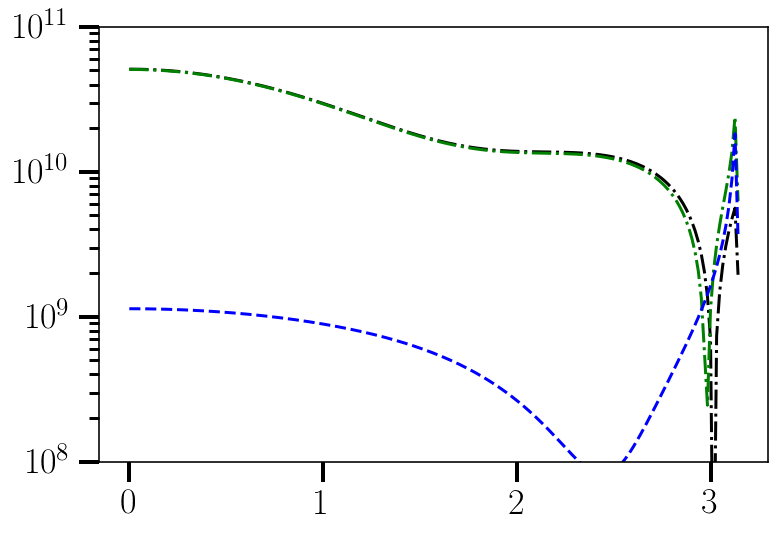

In [2250]:
plt.plot(theta,3.5*np.abs(GR0.l0(params))/h**6,'-.',label='GR',color='black')
plt.plot(theta,3.5*np.abs(GR2.l0(params,betas)+GR0.l0(params))/h**6,'-.',label='GR',color='green')
plt.plot(theta,2*np.abs(GR1.l1(params,betas).imag)/h**6,'--',label='Wide-angle',color='blue')
plt.yscale('log')
plt.ylim(1e+8,1e+11)

In [2215]:
#lets plot reduced - so get denominator
def part_reduced(params):
    k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params    
    
    return D1**4 *(b1**2 + 2*b1*f/3 + (f**2)/5)**2 *(Pk1 * Pk2 + Pk1 * Pk3 + Pk2 * Pk3)

In [2216]:
print(np.sqrt(4*np.pi/3))

2.046653415892977


In [2217]:
print(np.sqrt(4*np.pi))

3.5449077018110318


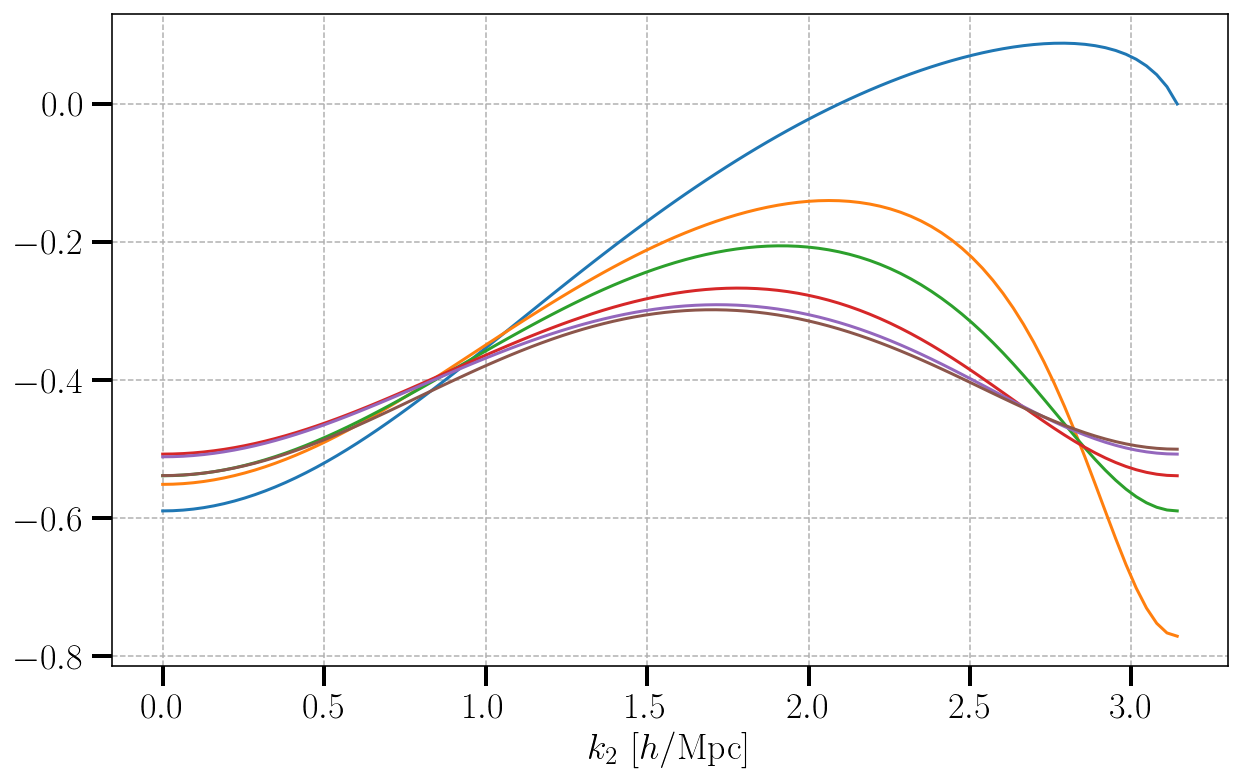

In [2251]:
#compare eline
cosmo_functions = CosmologicalFunctions(cosmo_eline)
zz=1
plt.figure(figsize=(10,6))
#k1 = np.linspace(0.01,0.5,1000)
#k3 = k1/26
#k2= k1

#k3 = np.linspace(0.0001,0.5,1000)
#k1 = 0.5001*k3;k2=k1

k1= 0.01/h
for i in [1,1.5,2,3,4,4.5]:
    k2= k1*i
    theta = np.linspace(0,np.pi,100)

    #theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
    #print(theta*180/np.pi)
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    params = cosmo_functions.get_params(k1,k2,theta,zz)
    derivs = cosmo_functions.get_derivs(zz)
    betas = cosmo_functions.get_beta_funcs(zz)

    #plt.plot(theta,3.5*(GR0.l0(params)+GR2.l0(params,betas))/part_reduced(params))
    #plt.plot(theta,np.sqrt((4*np.pi)/5)*(GR0.l2(params)+GR2.l2(params,betas))/part_reduced(params))

    #plt.plot(theta,np.sqrt((4*np.pi)/3)*GR1.l1(params,betas).imag/part_reduced(params)/h,'--')
    plt.plot(theta,np.sqrt((4*np.pi)/3)*GR1_test.l1(params,betas).imag/part_reduced(params)/h)

plt.xlabel('$ k_2 \,\,[h/\mathrm{Mpc}]$')
#plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
#plt.ylim(-0.169,0.019)
#plt.plot(k3,np.zeros_like(k3),'--', color='black')
#plt.yscale('log')
#plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.show()


In [2228]:
np.sqrt((4*np.pi)/3)

2.046653415892977

In [2118]:
k1=np.linspace(0.01,0.1)#0.08#
k2=k1
theta = 2*np.pi/3#np.linspace(0,np.pi,200)#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

In [2119]:
#for sciccimarro comparison...
zz=0.7
d = comoving_dist(zz)
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
derivs = cosmo_functions.get_derivs(zz)
fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
betas = cosmo_functions.get_beta_funcs(zz)

#D1=1
#K=3/7
#C=3/7

#Dd =0#fd=0
#bd1=0
#bd2=0
#fd=0
#gd2=0
derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)
derivs1 = fd,0,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs2 = 0,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs3 = fd,Dd,0,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs4 = fd,Dd,gd2,0,bd1,fdd,Ddd,gdd2,bdd2,bdd1
derivs5 = fd,Dd,gd2,bd2,0,fdd,Ddd,gdd2,bdd2,bdd1
gamma2= g2


In [2120]:
print(fd/f)
print(Dd/D1)
print(bd1/b1)
print(bd2/b2)
print(gd2/g2)

0.2817503051470079
-0.4018908391234152
0.2520313229420924
0.08771097265463919
1.2642367354506308


In [2121]:
%%time
test = Der2.l2(params,derivs,0,0)

CPU times: user 1.21 s, sys: 6.19 ms, total: 1.21 s
Wall time: 1.21 s


In [2346]:
zz=1

k1 = np.linspace(0.05,0.1)
k3 = k1
k2= 0.005
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
#k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

cosmo_functions = CosmologicalFunctions(cosmo_kevin)
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
PNGparams = cosmo_functions.get_PNGparams(100,zz)


k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
params =k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,3/7,3/7,f,D1,b1,b2,g2

In [2347]:
#plt.plot(k1,GR0.l0(params,PNGparams))
#plt.plot(k1,GR0PNG.l0(params,PNGparams))
#plt.plot(k1,GR0PNG1.l0(params,PNGparams))

In [2349]:
#so lets plot monopole...
plt.figure(figsize=(10,6))
r=0;s=0
WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)
totalwa = WA2.l0(params,r,s)+Der2.l0(params,derivs,r,s)+Mix.l0(params,derivs,r,s)+WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)
total = WA2.l0(params,r,s)+Der2.l0(params,derivs,r,s)+Mix.l0(params,derivs,r,s)+WAGR.l0(params,betas,r,s)+DerGR.l0(params,derivs,betas,r,s)+GR2.l0(params,betas)
#plt.plot(k3,GR2.l0(params,betas)/GR0.l0(params),'-.',label='GR',color='green')
#plt.plot(k3,WA2.l0(params,r,s)/GR0.l0(params),'--',label='Wide-angle',color='blue')
#plt.plot(k3,Der2.l0(params,derivs,r,s)/GR0.l0(params),'--',label='redshift derivative',color='red')
#plt.plot(k3,Mix.l0(params,derivs,r,s)/GR0.l0(params),'-.',label='Mixed',color='orange')

#plt.plot(k3,WAGR.l0(params,betas,r,s)/GR0.l0(params),'--',label='Wide-angle',color='purple')
#plt.plot(k3,DerGR.l0(params,derivs,betas,r,s)/GR0.l0(params),'--',label='Wide-angle',color='lime')

for i in [0.1,0.5,1]:
    PNGparams = cosmo_functions.get_PNGparams(i,zz)
    plt.plot(k3,(GR0PNG.l0(params,PNGparams)-GR0.l0(params))/GR0.l0(params),'--',color='grey')
    #plt.plot(k3,(GR0PNGtest.l0(params,PNGparams)-GR0.l0(params))/GR0.l0(params),'--',color='lime')


plt.plot(k3,totalwa/GR0.l0(params),'--',label='Total',color='black')
plt.plot(k3,total/GR0.l0(params),label='Total',color='black')
plt.xlabel('$ k_1=k_3 \,\,[h/\mathrm{Mpc}]$')
#plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
#plt.plot(k3,np.zeros_like(k3),'--', color='black')
#plt.ylim(0,0.00)
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()

NameError: name 'np' is not defined

<Figure size 720x432 with 0 Axes>

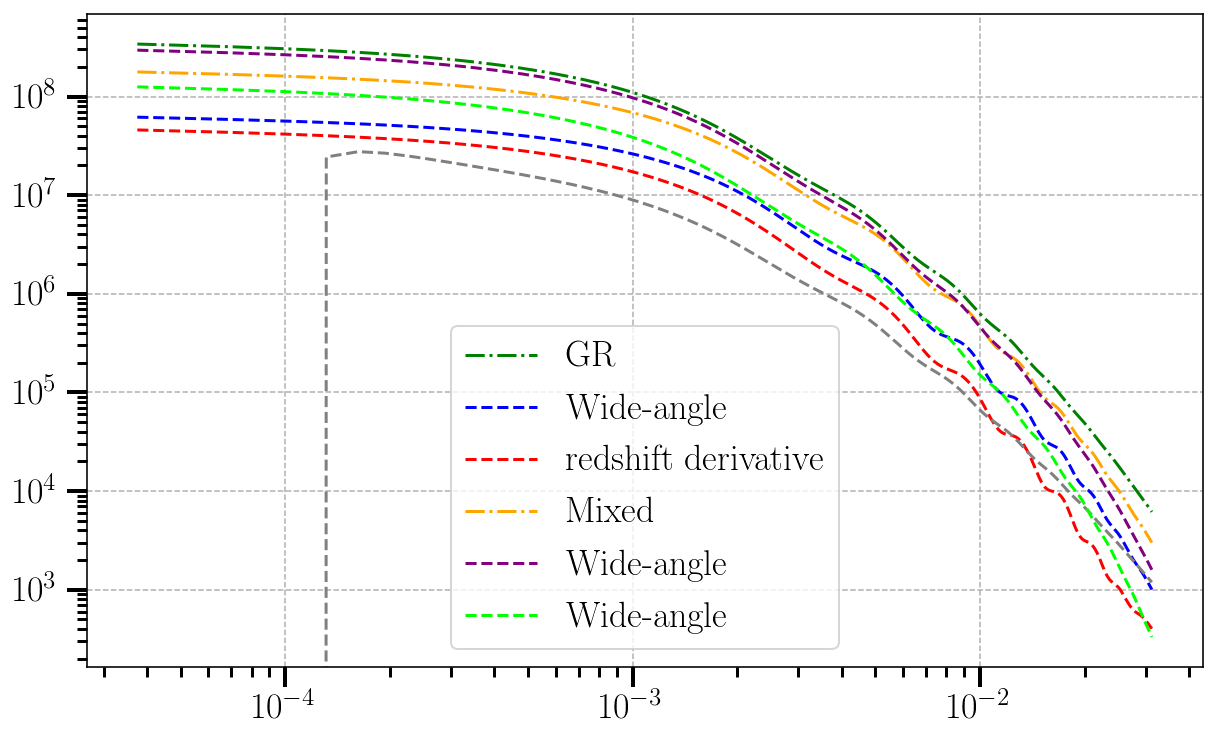

In [2275]:
#test GR:
zz=1
k1 = np.linspace(0.0006,0.5,1000)
k3 = k1/16
k2= k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
#k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)
PNGparams = cosmo_functions.get_PNGparams(1,zz)

plt.figure(figsize=(10,6))
r=0;s=0
plt.plot(k3,np.abs(GR2.l0(params,betas)),'-.',label='GR',color='green')
plt.plot(k3,np.abs(WA2.l0(params,r,s)),'--',label='Wide-angle',color='blue')
plt.plot(k3,np.abs(Der2.l0(params,derivs,r,s)),'--',label='redshift derivative',color='red')
plt.plot(k3,np.abs(Mix.l0(params,derivs,r,s)),'-.',label='Mixed',color='orange')
#plt.plot(k3,(GR0PNG.l0(params,PNGparams)-GR0.l0(params)),'--',color='grey')
plt.plot(k3,np.abs(WAGR.l0(params,betas,r,s)),'--',label='Wide-angle',color='purple')
plt.plot(k3,np.abs(DerGR.l0(params,derivs,betas,r,s)),'--',label='Wide-angle',color='lime')

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)
plt.legend()
plt.show()

Text(0, 0.5, '$  \\,\\,[\\mathrm{Mpc}/h]^3$')

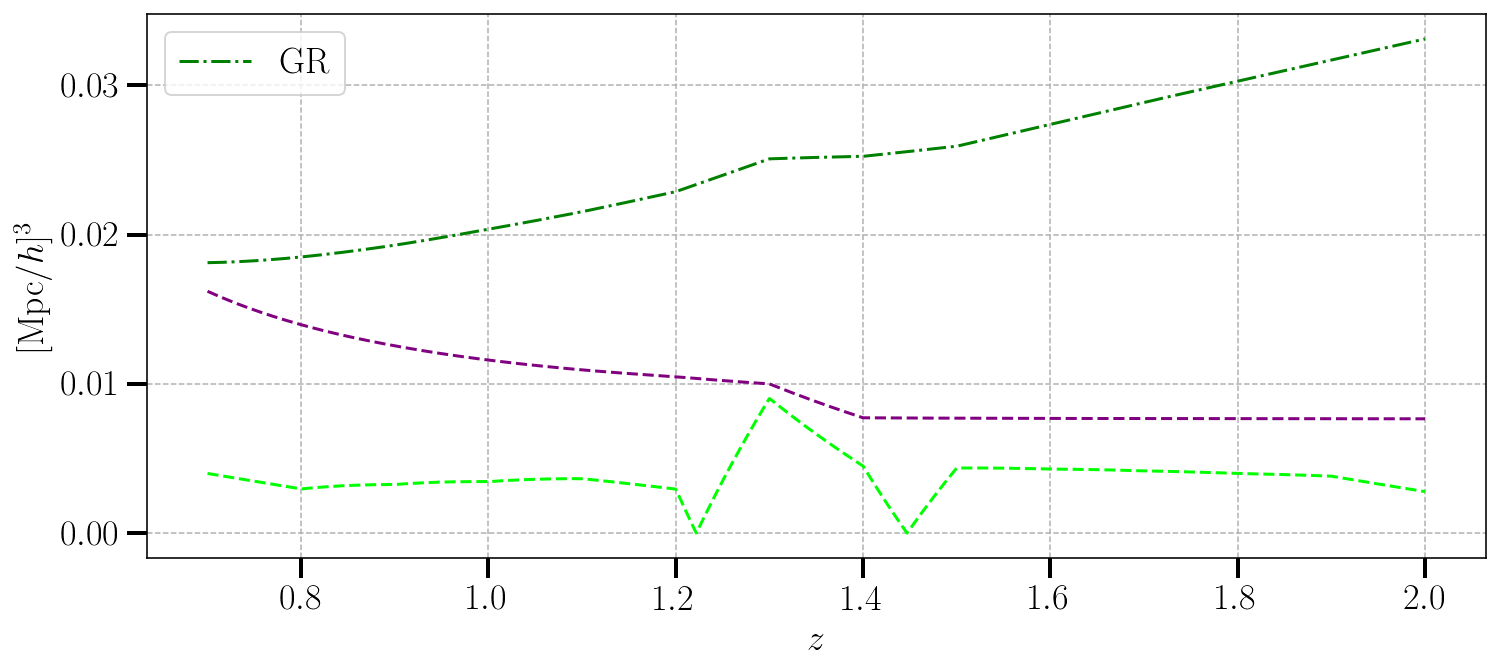

In [2337]:
plt.figure(figsize=(12,5))

#plt.xlim(0,1)
z_plot = np.linspace(0.7,2,1000)

k1 = 0.02
k2= k1
k3=k1/2
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))

params = cosmo_functions.get_params(k1,k2,theta,z_plot)
derivs = cosmo_functions.get_derivs(z_plot)
betas = cosmo_functions.get_beta_funcs(z_plot)
PNGparams = cosmo_functions.get_PNGparams(1,z_plot)

r=0;s=0
norm = GR0.l0(params)
if True:
    plt.plot(z_plot,np.abs(GR2.l0(params,betas)/norm),'-.',label='GR',color='green')
    #plt.plot(z_plot,np.abs(WA2.l0(params,r,s)/norm),'--',label='Wide-angle',color='blue')
    #plt.plot(z_plot,np.abs(Der2.l0(params,derivs,r,s)/norm),'--',label='redshift derivative',color='red')
    #plt.plot(z_plot,np.abs(Mix.l0(params,derivs,r,s)/norm),'-.',label='Mixed',color='orange')
    #plt.plot(z_plot,np.abs(GR0PNG.l0(params,PNGparams)-GR0.l0(params))/norm,'--',color='grey')
    plt.plot(z_plot,np.abs(WAGR.l0(params,betas,r,s)/norm),'--',label='',color='purple')
    plt.plot(z_plot,np.abs(DerGR.l0(params,derivs,betas,r,s)/norm),'--',label='',color='lime')
else:
    plt.plot(z_plot,np.abs(GR1.l1(params,betas)/norm),'-.',label='GR',color='green')
    plt.plot(z_plot,np.abs(WA1.l1(params,r,s)/norm),'--',label='Wide-angle',color='blue')
    plt.plot(z_plot,np.abs(Der1.l1(params,derivs,r,s)/norm),'--',label='redshift derivative',color='red')

#plt.yscale('log')
plt.legend()
plt.xlabel('$z$')
plt.grid(ls='--',lw=0.75)
plt.ylabel('$  \,\,[\mathrm{Mpc}/h]^3$')

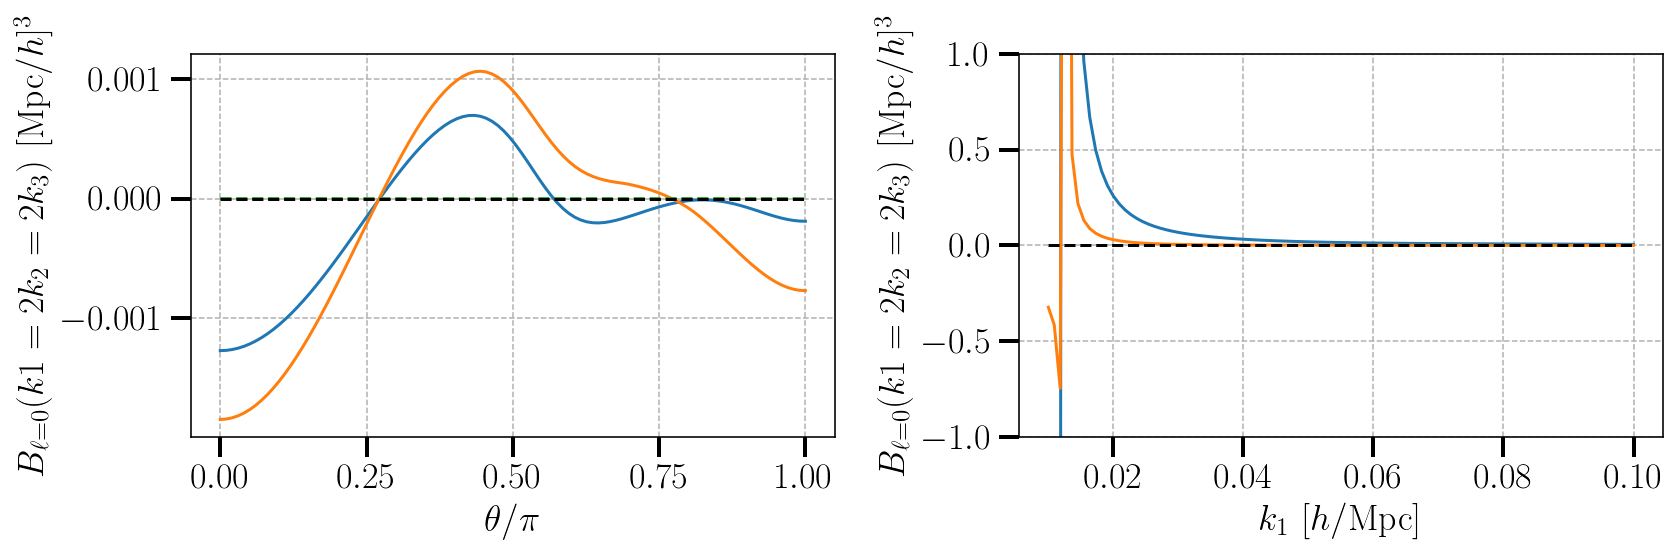

In [2176]:
#for quadrupole

# Create a figure and a gridspec
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 2, width_ratios=[4,4])

# Create subplots using the gridspec
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

zz=2;k1=0.04;k2=k1/2
theta = np.linspace(0,np.pi,100)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)

r=0;s=0
comb = WA2.l2(params,r,s)+Der2.l2(params,derivs,r,s)+Mix.l2(params,derivs,r,s)

# Plot on each subplot
ax1.plot(theta/np.pi,WA2.l2(params,r,s)/GR0.l2(params,r,s))
ax1.plot(theta/np.pi,comb/GR0.l2(params,r,s))
ax1.plot(theta/np.pi,GR2.l2(params,betas)/GR0.l2(params),'--')
ax1.set_xlabel(r'$ \theta /\pi$')
ax1.set_ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
ax1.plot(theta/np.pi,np.zeros_like(theta),'--', color='black')
ax1.grid(ls='--',lw=0.75)

#zz=0.8
k1=np.linspace(0.01,0.1,100);k2=k1;k3=0.1*k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)

#r=0;s=0
comb = WA2.l2(params,r,s)+Der2.l2(params,derivs,r,s)+Mix.l2(params,derivs,r,s)

# Plot on each subplot
ax2.plot(k1,WA2.l2(params,r,s)/GR0.l2(params,r,s))
ax2.plot(k1,comb/GR0.l2(params,r,s))
ax2.set_xlabel(r'$ k_1 \,\, [h/\mathrm{Mpc}]$')
ax2.set_ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
ax2.plot(k1,np.zeros_like(k1),'--', color='black')
ax2.set_ylim(-1,1)
ax2.grid(ls='--',lw=0.75)

plt.tight_layout()
plt.show()

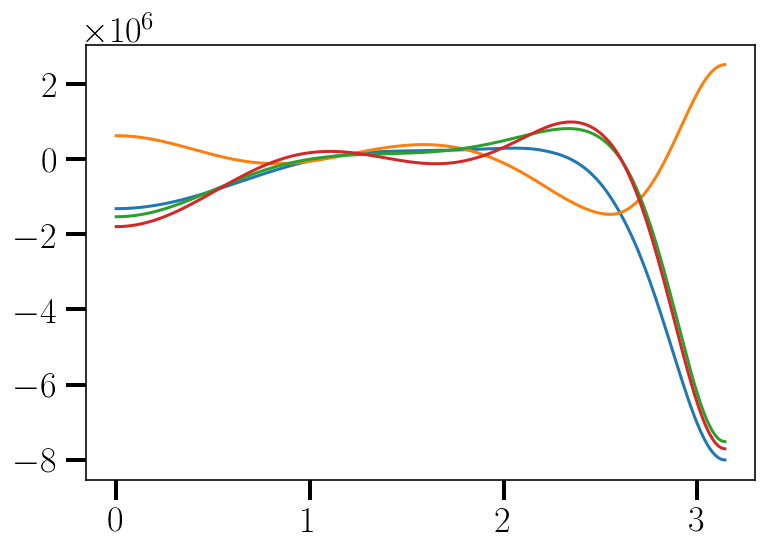

In [833]:
#plt.plot(theta,WA1mid.imag)
#plt.plot(theta,Der1mid.imag)
#plt.plot(theta,WA2.l2(params,1,0))
plt.plot(theta,Der2.l2(params,derivs,0,0))
plt.plot(theta,Der2.l2(params,derivs1,0,0))
plt.plot(theta,Der2.l2(params,derivs2,0,0))
#plt.plot(theta,Der2.l2(params,derivs3,0,0))
#plt.plot(theta,Der2.l2(params,derivs4,0,0))
plt.plot(theta,Der2.l2(params,derivs5,0,0))
#plt.plot(theta,Mix.l2(params,derivs,0,0))
#plt.plot(theta,Der2.l2(params,derivs,1,0)+Mix.l2(params,derivs,1,0)+WA2.l2(params,1,0),'--')
#plt.plot(theta,WA1.l1(params,0,0).imag)
#plt.plot(theta,WA2.l0(params,1,0))
#plt.plot(theta,WA2.l0(params,0,1))
#plt.plot(theta,WA2.l0(params,1/3,1/3),'--')



In [2284]:
#for sciccimarro comparison...
zz=1
k1=0.04#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

params = cosmo_functions.get_params(k1,k2,theta,zz)
derivs = cosmo_functions.get_derivs(zz)
betas = cosmo_functions.get_beta_funcs(zz)


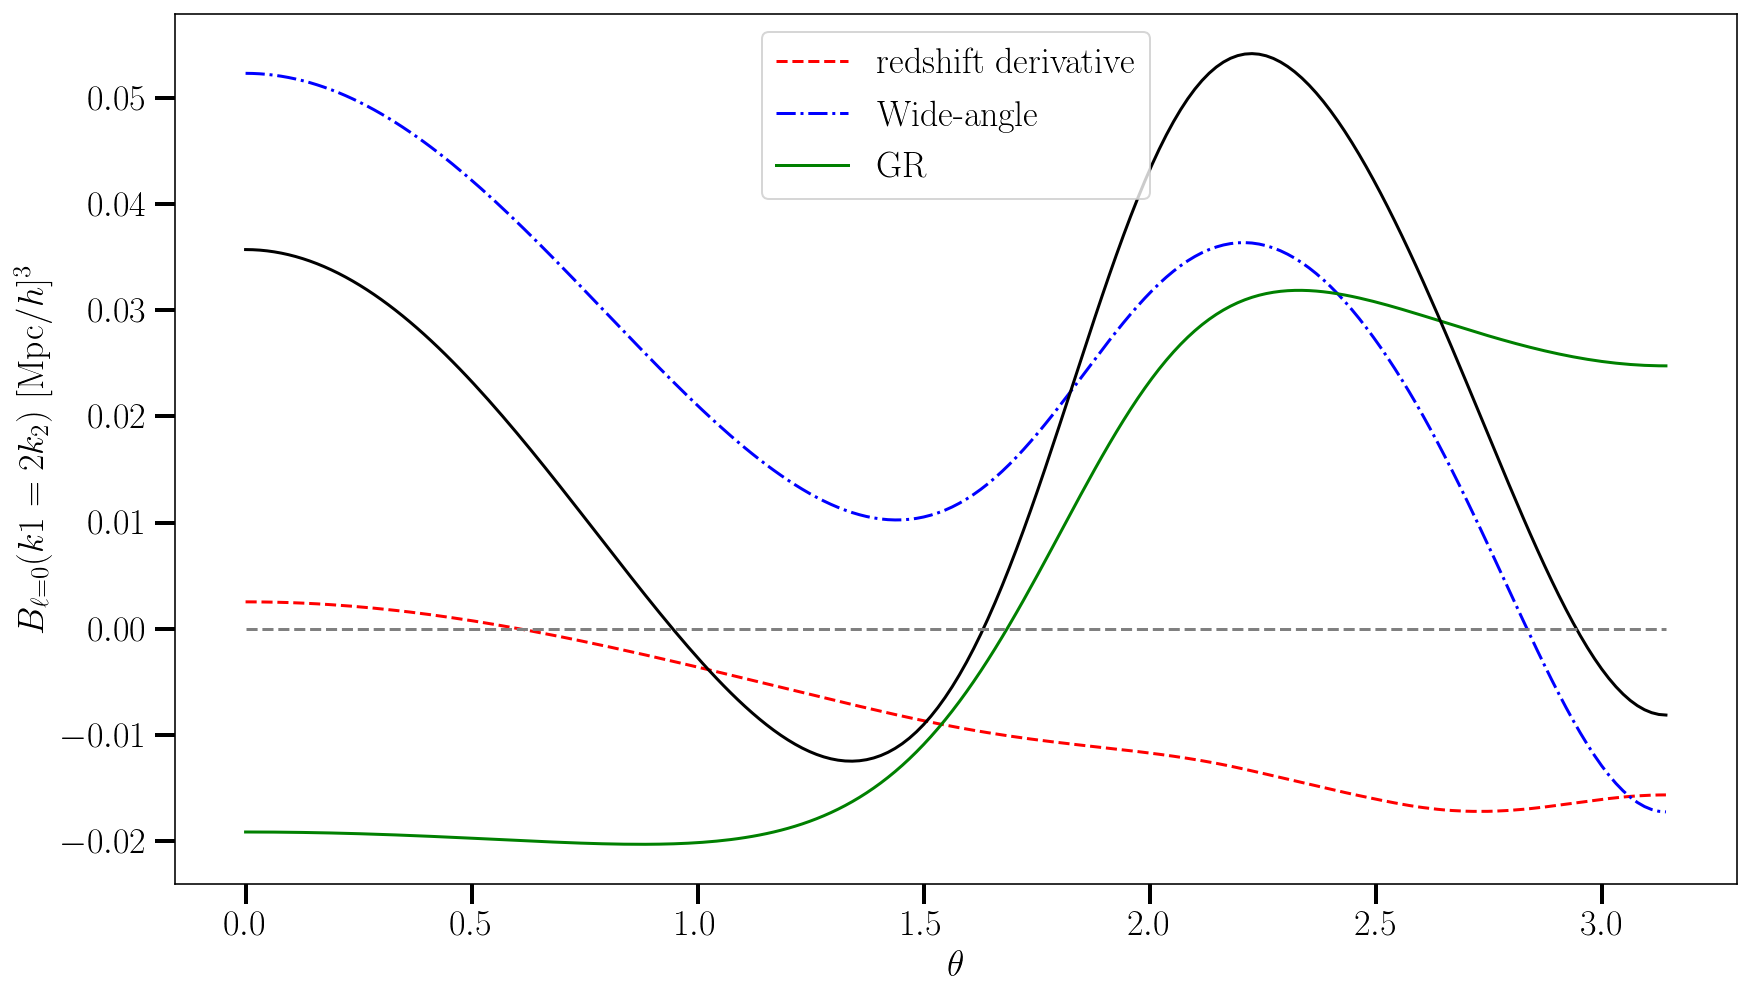

In [2286]:
plt.figure(figsize=(14,8))
r=0;s=0
#plt.plot(theta,bk_terms.WA1.l1(params,0,0).imag,alpha=0.4,color='blue')
#plt.plot(theta,bk_terms.Der1.l1(params,derivs,0,0).imag,'-.',alpha=0.4,color='blue')
#plt.plot(theta,WA1.l1(params,1,0).imag,alpha=0.4,color='red')
#plt.plot(theta,Der1.l1(params,derivs,1,0).imag,'-.',alpha=0.4,color='red')
#plt.plot(theta,WA1.l1(params,0,1).imag,alpha=0.4,color='green')
#plt.plot(theta,Der1.l1(params,derivs,0,1).imag,'-.',alpha=0.4,color='green')
#plt.plot(theta,WA1.l1(params,1/3,1/3).imag,color='black')
#plt.plot(theta,Der1.l1(params,derivs,1/3,1/3).imag,'-.',color='black')
#plt.plot(theta,WA1.l1(params,0,1).imag+Der1.l1(params,derivs,1/3,1/3).imag,'--',color='black')

plt.plot(theta,(Der1.l1(params,derivs,r,s).imag)/GR0.l0(params),'--',color='red',label='redshift derivative')
plt.plot(theta,WA1.l1(params,r,s).imag/GR0.l0(params),'-.',color='blue',label='Wide-angle')
plt.plot(theta,GR1.l1(params,betas).imag/GR0.l0(params),'-',color='green',label='GR')


plt.plot(theta,(WA1.l1(params,r,s).imag+GR1.l1(params,betas).imag+Der1.l1(params,derivs,r,s).imag)/GR0.l0(params),'-',color='black')
plt.plot(theta,np.zeros_like(theta),'--',color='grey')
plt.xlabel(r'$ \theta $')
plt.ylabel('$ B_{\ell=0}(k1= 2 k_2) \,\,[\mathrm{Mpc}/h]^3$')
plt.legend()
#plt.xlim(1.5,2)
#plt.plot(theta,testoldder/d)
#plt.plot(theta,testold.real/(d),'-.',color='black')
#plt.plot(theta,testold.real/(d),'-.',color='grey')

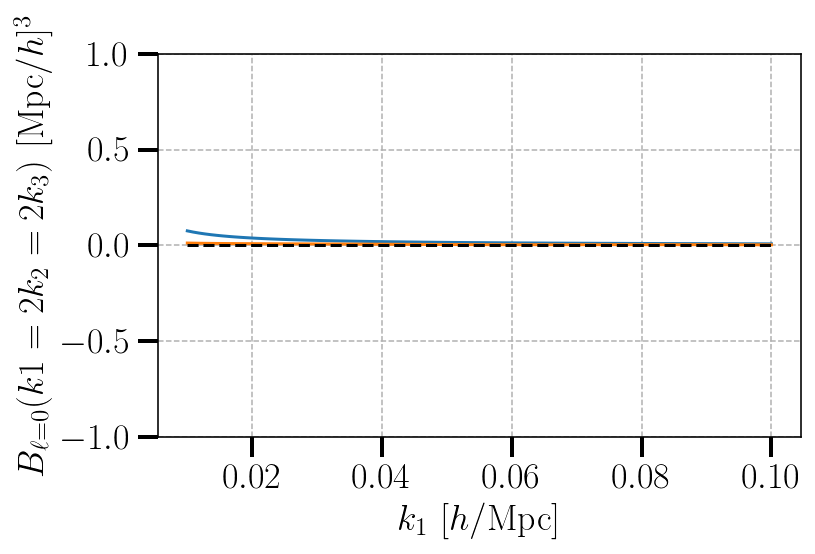

In [1721]:
#zz=0.8
k1=np.linspace(0.01,0.1,100);k2=k1;k3=k1
theta = np.arccos((k3**2 - k1**2 - k2**2)/(2*k1*k2))
derivs = get_derivs(zz)
params = get_params(k1,k2,theta,zz)

r=0;s=0
comb = WA1.l1(params,r,s)+Der1.l1(params,derivs,r,s)

# Plot on each subplot
plt.plot(k1,WA1.l1(params,r,s).imag/GR0.l2(params,r,s))
plt.plot(k1,comb.imag/GR0.l0(params,r,s))
plt.xlabel(r'$ k_1 \,\, [h/\mathrm{Mpc}]$')
plt.ylabel('$ B_{\ell=0}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
plt.plot(k1,np.zeros_like(k1),'--', color='black')
plt.ylim(-1,1)
plt.grid(ls='--',lw=0.75)

plt.tight_layout()
plt.show()

In [579]:
def bk_dipo(k1,k2,theta,zz,r=1/3,s=1/3,c=0): 
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    k3 = np.where(k3==0,1e-3,k3)
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    I = 1j
    def csc(x):
        x = np.where(x==0,1e-4,x)#aviod zero errors here
        return 1/np.sin(x)
    
    #redshift dependendent terms
    f= f_intp(zz)
    b1 = b_1(zz)
    b2 = b_2(zz)
    g2 = g_2(zz)
    #deriv
    fd = f_d(zz)
    gd2 = g2_d(zz)
    bd2 = b2_d(zz)
    bd1 = b1_d(zz)
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #@jit(nopython=True)
    def contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3):
        """So we have collated alll terms for each permutation - these epression are 1st order abut include all derivate terms"""
        bk_12 =  (-44*f**2*k1*k2**2*(2*c*fd*(4*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**2*(3*Pk2*k2**2*(4*r + 3*s - 3) + 4*Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + Pk2*Pkd1*k1*k2**2*k3**2*(-3*r - 3*s + 2)) + f*(8*Pk1*Pk2*k2**2*k3**2*(3*r + 3*s - 5) + Pk1*k1**2*(6*Pk2*k2**2*(3*s - 2) - 4*Pk2*k3**2*(3*r + 8) + Pkd2*k2*k3**2*(3*r + 8)) - 2*Pk2*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 5)))*np.cos(6*theta) - f*k2*(693*Pk1*c*fd*g2*k1**2*k3**4*(-4*Pk2 + Pkd2*k2) + 66*b1*k1**2*(3*c*fd*(2*Pk1*k1**2*(6*Pk2*k2**2*(4*r + 2*s - 3) + 4*Pk2*k3**2*(2*r - 1) + Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*(4*Pk2*k2**4*(2*r + 2*s - 1) + 16*Pk2*k2**2*k3**2*(r + s - 1) - 4*Pk2*k3**4 + Pkd2*k2*k3**4) - 8*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1)) + 2*f*(2*Pk1*k1**2*(10*Pk2*k2**2*(2*s - 1) - 4*Pk2*k3**2*(r + 3) + Pkd2*k2*k3**2*(r + 3)) + Pk1*(4*Pk2*k2**4*(s + 3) + 4*Pk2*k2**2*k3**2*(8*r + 9*s - 9) - 4*Pk2*k3**4*(r + 3) + 2*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(r + 3)) - 18*Pk2*Pkd1*k1*k2**2*k3**2*(r + s - 1))) + 14*f**3*k3**4*(20*Pk1*Pk2*k2**2*(3*r + 3*s - 5) - 4*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(2*r + 5) - 5*Pk2*Pkd1*k1*k2**2*(3*r + 3*s - 5)) + f**2*(56*Pk1*Pk2*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5)) + 11*Pk1*k1**4*(18*Pk2*k2**2*(31*s - 18) - 4*Pk2*k3**2*(69*r + 136) + Pkd2*k2*k3**2*(69*r + 136)) + Pk1*k1**2*(560*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(111*s - 34) + 66*Pk2*k2**2*k3**2*(71*r + 46*s - 202) + 140*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(69*r + 64)) - 22*Pk2*Pkd1*k1**3*k2**2*k3**2*(105*r + 105*s - 127) - 14*Pk2*Pkd1*k1*k2**2*k3**2*(5*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 5))) + 11*f*(-42*Pk1*g2*k1**2*k3**4*(4*Pk2 - Pkd2*k2)*(r + 3) + 2*c*fd*(28*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(81*Pk2*k2**2*(4*r + 3*s - 3) + 68*Pk2*k3**2*(r - 1) - 17*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(41*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(61*r + 51*s - 44) - 17*Pkd2*k2*k3**2*(r - 1)) - 47*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 7*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)) + 9*c*k1**2*(Pk1*(8*Pk2*bd2*k2**4*(r + s - 1) + 7*gd2*k3**4*r*(4*Pk2 - Pkd2*k2)) + 2*bd1*(4*Pk1*Pk2*k2**4*(r - 1) + 4*Pk1*Pk2*k3**2*r*(-2*k1**2 + k3**2) - 2*Pk1*Pkd2*k2**3*k3**2*(r - 1) - Pk1*Pkd2*k2*k3**2*r*(-2*k1**2 + k3**2) + 4*Pk2*k2**2*(3*Pk1*k1**2*s + k3**2*(Pk1*(3*r + 2*s - 1) - Pkd1*k1*(r + s)))))))*np.cos(5*theta) - k1*(924*b1**2*k2**2*(c*fd*(2*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 4*Pk1*k1**2*(3*Pk2*k2**2*(2*r + s - 1) + 2*Pk2*k3**2*r - Pkd2*k2*k3**2*r) - Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1)) + f*(6*Pk1*Pk2*k3**2*(2*k2**2 + k3**2)*(r + s - 1) + 2*Pk1*k1**2*(8*Pk2*k2**2*(s - 1) - 2*Pk2*k3**2*r + Pkd2*k2*k3**2*r) - 3*Pk2*Pkd1*k1*k3**2*(2*k2**2 + k3**2)*(r + s - 1))) + 11*b1*(294*Pk2*c*fd*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + 14*f**3*k3**4*(-Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(3*r + 8) + Pk1*k2**2*(Pk2*(30*r + 36*s - 52) + Pkd2*k2*(3*r + 4)) - 2*Pk2*Pkd1*k1*k2**2*(9*r + 9*s - 11)) + 2*f**2*(3*Pk1*k1**4*(2*Pk2*k2**2*(114*s - 43) - 28*Pk2*k3**2*(r + 3) + 7*Pkd2*k2*k3**2*(r + 3)) + Pk1*k1**2*(6*Pk2*k2**4*(313*s - 118) + 6*Pk2*k2**2*k3**2*(26*r - 20*s - 145) + 28*Pk2*k3**4*(8*c*fd*r - 4*c*fd - 3*r - 9) + 3*Pkd2*k2**3*k3**2*(134*r + 5) + 7*Pkd2*k2*k3**4*(-8*c*fd*r + 4*c*fd + 3*r + 9)) + Pk1*k2**2*(42*Pk2*k2**4*(s + 3) + 18*Pk2*k2**2*k3**2*(53*r + 53*s - 77) + 2*Pk2*k3**4*(14*c*fd*(11*r + 9*s - 9) + 15*r + 36*s - 207) + 21*Pkd2*k2**3*k3**2*r + 7*Pkd2*k2*k3**4*(-4*c*fd*r + 2*c*fd + 3*r + 9)) - 321*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(537*r + 537*s - 513) + 2*k3**2*(7*c*fd*(9*r + 9*s - 8) + 33*r + 33*s - 27))) + 3*f*(294*Pk2*g2*k2**2*k3**4*(2*Pk1 - Pkd1*k1)*(r + s - 1) + c*fd*(3*Pk1*k1**4*(74*Pk2*k2**2*(4*r + 2*s - 3) + 28*Pk2*k3**2*(2*r - 1) + 7*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(12*Pk2*k2**4*(193*r + 124*s - 131) - 2*Pk2*k2**2*k3**2*(70*r + 64*s - 67) - 84*Pk2*k3**4 + 117*Pkd2*k2**3*k3**2*(1 - 2*r) + 21*Pkd2*k2*k3**4) + Pk1*k2**2*(42*Pk2*k2**4*(2*r + 2*s - 1) + 8*Pk2*k2**2*k3**2*(53*r + 53*s - 49) + 2*Pk2*k3**4*(16*r + 16*s - 29) + 21*Pkd2*k2*k3**4) - 180*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 12*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(23*r + 23*s - 19) + 2*k3**2*(2*r + 2*s - 1))) + 14*c*k2**2*(Pk2*(4*bd2*k2**2*(6*Pk1*k1**2 + 2*Pk1*k3**2 - Pkd1*k1*k3**2) + 7*gd2*k3**4*(2*Pk1 - Pkd1*k1))*(r + s - 1) + 2*bd1*(2*Pk1*Pk2*k3**2*(2*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 4*Pk1*k1**2*(3*Pk2*k2**2*(r + s - 1) - 2*Pk2*k3**2 + Pkd2*k2*k3**2) + Pk2*Pkd1*k1*k3**2*(-2*k2**2*(r + s) + k3**2*(-2*r - 2*s + 1)))))) + f*(462*Pk2*c*g2*k2**2*k3**4*(7*bd1*(2*Pk1 - Pkd1*k1)*(r + s) + 2*fd*(2*Pk1 - 3*Pkd1*k1)*(2*r + 2*s - 1)) + 14*f**3*k3**4*(-5*Pk1*k1**2*(4*Pk2 - Pkd2*k2)*(7*r + 12) + Pk1*k2**2*(8*Pk2*(34*r + 24*s - 81) + Pkd2*k2*(35*r + 16)) - 8*Pk2*Pkd1*k1*k2**2*(17*r + 17*s - 21)) + 2*f**2*(22*Pk1*k1**4*(3*Pk2*k2**2*(99*s - 43) - 28*Pk2*k3**2*(3*r + 5) + 7*Pkd2*k2*k3**2*(3*r + 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 22*Pk2*k2**4*(645*s - 278) - 11*Pk2*k2**2*k3**2*(3*r + 345*s + 1582) + 210*Pkd2*c*fd*k2*k3**4*(1 - 2*r) + 11*Pkd2*k2**3*k3**2*(318*r + 125)) + Pk1*k2**2*(14*Pk2*c*k3**4*(22*bd1*(5*r + 3*s - 2) + fd*(138*r + 128*s - 101)) + 33*Pk2*k2**2*k3**2*(221*r + 151*s - 490) - 14*Pkd2*c*k2*k3**4*(11*bd1 + 15*fd)*(2*r - 1) + 77*Pkd2*k2**3*k3**2*(6*r + 1) + 154*k2**4*(6*Pk2*s + Pk2)) - 55*Pk2*Pkd1*k1**3*k2**2*k3**2*(51*r + 51*s - 49) - Pk2*Pkd1*k1*k2**2*k3**2*(14*c*k3**2*(11*bd1*(3*r + 3*s - 1) + 30*fd*(4*r + 4*s - 3)) + 11*k2**2*(327*r + 327*s - 365))) + 11*f*(42*Pk2*g2*k2**2*k3**4*(12*Pk1*(r + s - 4) - 11*Pkd1*k1*(r + s) + 9*Pkd1*k1) + c*(6*Pk2*k2**2*(bd2*k2**2*(165*Pk1*k1**2 + 21*Pk1*k2**2 + 16*Pk1*k3**2 - 24*Pkd1*k1*k3**2) + 14*gd2*k3**4*(2*Pk1 - 3*Pkd1*k1))*(r + s - 1) + 3*bd1*(3*Pk1*k1**4*(74*Pk2*k2**2*s + 7*k3**2*r*(-4*Pk2 + Pkd2*k2)) + Pk1*k1**2*(6*Pk2*k2**4*(55*r + 69*s - 55) + 2*Pk2*k2**2*k3**2*(88*r - 32*s - 117) + 84*Pk2*k3**4*r + 117*Pkd2*k2**3*k3**2 - 21*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(r - 1) + 180*Pk2*k2**2*k3**2*(r + s) + 2*Pk2*k3**4*(29*r + 8*s - 8) - 21*Pkd2*k2**3*k3**2*(r - 1) - 21*Pkd2*k2*k3**4*r) - 90*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(15*k2**2*(r + s) + 4*k3**2*(r + s - 1))) + 2*fd*(5*Pk1*k1**4*(66*Pk2*k2**2*(4*r + 3*s - 3) + 28*Pk2*k3**2*(r - 1) - 7*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(784*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-513*r - 615*s + 308) - 238*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(70*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(383*r + 453*s - 232) - 35*Pkd2*k2*k3**2*(r - 1)) - 130*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 154*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(4*theta) - 2*k1*(1617*b1**3*k3**4*(-2*c*fd*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) + Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(Pk1*Pkd2*k2**3*r + Pk1*k1**2*r*(-2*Pk2 + Pkd2*k2) - 6*Pk2*Pkd1*k1*k2**2*(r + s - 1))) - 231*b1**2*(c*(fd*(-3*Pk1*k1**4*(58*Pk2*k2**2*(2*r + s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-384*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(150*r + 89*s - 89) + 42*Pk2*k3**4*r + 114*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 14*Pk2*k2**2*k3**2*(7*r + s - 1) + 2*Pk2*k3**4*(29*r + 8*s - 21) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(11*r + 11*s - 8))) + 5*k3**4*(Pk2*Pkd1*k1*k2**2*(4*bd2 + 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k2**3*(r - 1) - 7*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + 4*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)))) + f**2*k3**4*(Pk1*k1**2*(4*Pk2*(9*r + 10) + Pkd2*k2*(4 - 45*r)) + Pk1*k2**2*(12*Pk2*(-5*r + 4*s + 4) + Pkd2*k2*(4 - 45*r)) + 4*Pk2*Pkd1*k1*k2**2*(31*r + 31*s - 30)) + 2*f*(2*Pk1*k1**4*(-58*Pk2*k2**2*(s - 1) + 14*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-256*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(14*r + 157*s - 157) + Pk2*k3**4*(-14*bd1*c*(r - 1) - 30*c*fd*r + 3*c*fd - 7*r + 35) - 66*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) - 7*Pk2*k2**2*k3**2*(10*r - 3*s + 3) + Pk2*k3**4*(c*fd*(52*r + 16*s - 23) - 39*r + 24*s + 63) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(4*r - 1) - 28*r + 14)) + 44*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(62*k2**2*(r + s - 1) + k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 60*c*fd + 46) - k3**2*(54*c*fd + c*(7*bd1 + 7*bd2) + 38)))) - 11*b1*(-980*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r + 280*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 3892*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 2184*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 17388*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 11736*Pk1*Pk2*c*f*fd*k1**4*k2**2 - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2*r + 126*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 35856*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 23904*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 19152*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 12474*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 126*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 3780*Pk1*Pk2*c*f*fd*k2**6*r + 2520*Pk1*Pk2*c*f*fd*k2**6 + 5004*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 2628*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 528*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 768*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r - 1176*Pk1*Pk2*c*f*gd2*k2**2*k3**4 + 1176*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 462*Pk1*Pk2*f**3*k1**2*k3**4*r + 1568*Pk1*Pk2*f**3*k1**2*k3**4 - 840*Pk1*Pk2*f**3*k2**2*k3**4*r + 2464*Pk1*Pk2*f**3*k2**2*k3**4 + 4320*Pk1*Pk2*f**2*k1**4*k2**2 + 798*Pk1*Pk2*f**2*k1**4*k3**2*r + 1134*Pk1*Pk2*f**2*k1**4*k3**2 + 9360*Pk1*Pk2*f**2*k1**2*k2**4 - 204*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 108*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 210*Pk1*Pk2*f**2*k1**2*k3**4*r + 1134*Pk1*Pk2*f**2*k1**2*k3**4 + 1008*Pk1*Pk2*f**2*k2**6 - 2154*Pk1*Pk2*f**2*k2**4*k3**2*r + 2862*Pk1*Pk2*f**2*k2**4*k3**2 - 426*Pk1*Pk2*f**2*k2**2*k3**4*r + 3006*Pk1*Pk2*f**2*k2**2*k3**4 + 3528*Pk1*Pk2*f*g2*k2**2*k3**4*r + 1106*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 448*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 1078*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 434*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 630*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 3564*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 1782*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 315*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 315*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 315*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 1029*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 112*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 1029*Pk1*Pkd2*f**3*k2**3*k3**4*r + 140*Pk1*Pkd2*f**3*k2**3*k3**4 - 1008*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 252*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 5400*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1224*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 504*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 252*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1008*Pk1*Pkd2*f**2*k2**5*k3**2*r + 252*Pk1*Pkd2*f**2*k2**5*k3**2 - 504*Pk1*Pkd2*f**2*k2**3*k3**4*r + 252*Pk1*Pkd2*f**2*k2**3*k3**4 + 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 882*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 3906*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 3052*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 4392*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 3402*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 4824*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 3618*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1080*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 + 1176*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 2394*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 2086*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 3564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 2772*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 4212*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3348*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 948*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 684*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r + 588*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 42*Pk2*bd2*c*k2**2*(Pk1*f*(-87*k1**4 - 192*k1**2*k2**2 - 21*k2**4 + k3**4*(6*f + 8) + k3**2*(89*k1**2 + 7*k2**2)) + Pkd1*k1*k3**2*(33*f*k1**2 + 39*f*k2**2 + k3**2*(f*(18*f + 13) + 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(4*Pk1*f*(3*c*fd*k3**2*(169*k1**2 + 31*k2**2) - 3*c*fd*(157*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(22*c*fd + 49*c*gd2 + 147*g2)) + Pkd1*f*k1*k3**2*(12*c*fd*(61*k1**2 + 67*k2**2) + k3**2*(147*b2 + 180*c*fd + 196*c*gd2 + 98*g2)) + 49*c*fd*k3**4*(Pkd1*b2*k1 + 4*g2*(Pk1 + Pkd1*k1)) + 21*f**3*k3**4*(16*Pk1 + 19*Pkd1*k1) + f**2*(Pk1*(-1524*k1**4 + 6*k1**2*(-534*k2**2 + 339*k3**2) - 336*k2**4 + 558*k2**2*k3**2 + 6*k3**4*(56*c*fd + 22)) + Pkd1*k1*k3**2*(594*k1**2 + 702*k2**2 + k3**2*(651*c*fd + 158)))) + 21*bd1*c*(70*Pk2*Pkd1*g2*k1*k2**2*k3**4*(r + s) + 2*f**2*k3**4*(-12*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(10*r + 10*s - 13) + 12*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(7*r + 7*s - 3)) + f*(-3*Pk1*k1**4*(58*Pk2*k2**2*(r + s - 1) - 14*Pk2*k3**2 + 7*Pkd2*k2*k3**2) + Pk1*k1**2*(-384*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(89*r + 89*s - 61) + 42*Pk2*k3**4*(1 - 2*r) - 114*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + Pk1*k2**2*(-42*Pk2*k2**4*(r + s - 1) + 14*Pk2*k2**2*k3**2*(r + s - 6) + 16*Pk2*k3**4*(r + s - 1) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 66*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(39*k2**2*(r + s) + k3**2*(38*r + 38*s - 22))))) + f*(-1848*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 924*Pk1*Pk2*b2*c*fd*k2**2*k3**4 - 2772*Pk1*Pk2*b2*f*k2**2*k3**4*r - 8316*Pk1*Pk2*b2*f*k2**2*k3**4 + 2940*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 1470*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 19488*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 12656*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 + 105160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r - 78870*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 1540*Pk1*Pk2*c*f*fd*k1**4*k3**2 + 209792*Pk1*Pk2*c*f*fd*k1**2*k2**4*r - 157344*Pk1*Pk2*c*f*fd*k1**2*k2**4 - 117480*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r + 87318*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 21560*Pk1*Pk2*c*f*fd*k2**6*r - 16170*Pk1*Pk2*c*f*fd*k2**6 - 30800*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 24178*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 7392*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r + 3696*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 560*Pk1*Pk2*f**3*k1**2*k3**4*r - 7560*Pk1*Pk2*f**3*k1**2*k3**4 + 1484*Pk1*Pk2*f**3*k2**2*k3**4*r - 12096*Pk1*Pk2*f**3*k2**2*k3**4 - 14344*Pk1*Pk2*f**2*k1**4*k2**2 - 462*Pk1*Pk2*f**2*k1**4*k3**2*r - 10010*Pk1*Pk2*f**2*k1**4*k3**2 - 30536*Pk1*Pk2*f**2*k1**2*k2**4 + 396*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 45474*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 3080*Pk1*Pk2*f**2*k2**6 + 3234*Pk1*Pk2*f**2*k2**4*k3**2*r - 32736*Pk1*Pk2*f**2*k2**4*k3**2 - 11088*Pk1*Pk2*f*g2*k2**2*k3**4*r + 5544*Pk1*Pk2*f*g2*k2**2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 4200*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r + 2100*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 - 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 - 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r + 15686*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r + 2695*Pk1*Pkd2*c*f*fd*k2**5*k3**2 + 3605*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pk1*Pkd2*f**3*k1**2*k2*k3**4 + 3605*Pk1*Pkd2*f**3*k2**3*k3**4*r - 728*Pk1*Pkd2*f**3*k2**3*k3**4 + 4620*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r - 1540*Pk1*Pkd2*f**2*k1**4*k2*k3**2 + 26466*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r - 7832*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 4620*Pk1*Pkd2*f**2*k2**5*k3**2*r - 1540*Pk1*Pkd2*f**2*k2**5*k3**2 - 5544*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r + 2772*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 - 5082*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r + 4158*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 - 16800*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r + 12600*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 - 31350*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r + 20900*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 - 31614*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r + 21076*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 - 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2772*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 1386*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 - 7672*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r + 6216*Pk2*Pkd1*f**3*k1*k2**2*k3**4 - 18084*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r + 12452*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 - 18348*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r + 12892*Pk2*Pkd1*f**2*k1*k2**4*k3**2 - 924*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 2772*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 - 66*Pk2*bd2*c*k2**2*(Pk1*(3*f*k3**2*(177*k1**2 + 55*k2**2) - 3*f*(145*k1**4 + 332*k1**2*k2**2 + 35*k2**4) + k3**4*(56*f**2 + 14*f + 196*g2)) + Pkd1*k1*k3**2*(3*f*(55*k1**2 + 67*k2**2) + k3**2*(14*f*(5*f + 3) + 147*g2)))*(r + s - 1) - 2*Pk2*k2**2*s*(462*c*fd*k3**4*(Pk1*(2*b2 + 8*g2) + Pkd1*k1*(6*b2 + 3*g2)) + 28*f**3*k3**4*(156*Pk1 + 137*Pkd1*k1) + f**2*(Pk1*(5824*c*fd*k3**4 - 22704*k1**4 - 44814*k1**2*k2**2 - 4620*k2**4 + k3**2*(31977*k1**2 + 9933*k2**2)) + 6*Pkd1*k1*k3**2*(1400*c*fd*k3**2 + 1507*k1**2 + 1529*k2**2)) + 33*f*(Pk1*(c*fd*k3**2*(1371*k1**2 + 301*k2**2) - c*fd*(1195*k1**4 + 2384*k1**2*k2**2 + 245*k2**4) + k3**4*(42*b2 + 56*c*gd2 + 168*g2)) + Pkd1*k1*k3**2*(c*fd*(475*k1**2 + 479*k2**2) + k3**2*(77*b2 + 21*c*gd2 + 14*g2)))) - 11*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(294*b2 + 294*g2)*(r + s) + 14*f**2*k3**4*(-15*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(38*r + 24*s - 38) + Pkd2*k2*(17*r - 16)) + Pk2*Pkd1*k1*k2**2*(63*r + 63*s - 31)) - 3*f*(3*Pk1*k1**4*(2*Pk2*k2**2*(145*r + 169*s - 145) + 14*Pk2*k3**2*(4*r - 5) + 35*Pkd2*k2*k3**2) + 3*Pk1*k1**2*(664*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(51*r + 161*s - 84) + 14*Pk2*k3**4*r + 198*Pkd2*k2**3*k3**2 - 35*Pkd2*k2*k3**4*r) + Pk1*k2**2*(210*Pk2*k2**4*(r + s - 1) + 42*Pk2*k2**2*k3**2*(r - s + 9) - 8*Pk2*k3**4*(32*r + 11*s - 11) + 105*Pkd2*k2**3*k3**2 - 105*Pkd2*k2*k3**4*r) - 402*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(67*k2**2*(r + s) + 30*k3**2*(r + s - 1))))))*np.cos(2*theta) + k1*(3234*b1**3*k3**4*(2*c*fd*(Pk1*Pk2*k1**2*r + 2*Pk1*Pkd2*k1**2*k2*r + 2*Pk1*Pkd2*k2**3*r + Pk2*k2**2*(Pk1*(9*r + 4*s - 4) + 5*Pkd1*k1*(r + s - 1))) + f*(-6*Pk1*Pk2*k1**2*r - 7*Pk1*Pkd2*k1**2*k2*r - 7*Pk1*Pkd2*k2**3*r + 2*Pk2*k2**2*(2*Pk1*(r + 6*s - 6) + 5*Pkd1*k1*(r + s - 1)))) + 462*b1**2*(c*(fd*(3*Pk1*k1**4*k2*(-82*Pk2*k2*(2*r + s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-432*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(320*r + 163*s - 163) + 14*Pk2*k3**4*(r - 1) + 130*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + Pk1*k2**2*(-42*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(74*r + 25*s - 25) + 2*Pk2*k3**4*(57*r + 50*s - 30) + 21*Pkd2*k2**3*k3**2*r - 21*Pkd2*k2*k3**4) + 102*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*k3**2*(43*k2**2*(r + s - 1) + k3**2*(61*r + 61*s - 25))) + 5*k2*k3**4*(Pk2*Pkd1*k1*k2*(38*bd2 - 14*gd2)*(r + s - 1) + bd1*(7*Pk1*Pkd2*k1**2*(r - 1) + 7*Pk1*Pkd2*k2**2*(r - 1) + 2*Pk2*k2*(7*Pk1*(r - 1) + 12*Pkd1*k1*(2*r + 2*s - 1))))) + f**2*k3**4*(Pk1*k1**2*(8*Pk2*(4 - 9*r) + Pkd2*k2*(20 - 99*r)) + Pk1*k2**2*(24*Pk2*(4*r + 16*s - 7) + Pkd2*k2*(20 - 99*r)) + 4*Pk2*Pkd1*k1*k2**2*(41*r + 41*s - 30)) + 2*f*(-2*Pk1*k1**4*k2*(82*Pk2*k2*(s - 1) + 7*Pkd2*k3**2*r) + Pk1*k1**2*(-288*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(38*r + 319*s - 319) + Pk2*k3**4*(7*bd1*c*(r - 1) + 6*c*fd*(3*r - 1) - 21*r + 21) - 100*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + Pk1*k2**2*(-28*Pk2*k2**4*(s - 1) + Pk2*k2**2*k3**2*(-2*r + 75*s - 75) + Pk2*k3**4*(7*bd1*c*(13*r + 8*s - 9) + 28*bd2*c*(r + s - 1) + 2*c*fd*(112*r + 64*s - 59) + 73*r + 150*s + 43) - 14*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(14*bd1*c*(r - 1) + 9*c*fd*(4*r - 1) - 28*r + 14)) + 68*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(44*k2**2*(r + s - 1) + k3**2*(r + s)*(5*c*(14*bd1 + 7*bd2 + 24*fd) + 63) - k3**2*(96*c*fd + c*(35*bd1 + 35*bd2) + 15)))) + 11*b1*(2352*Pk1*Pk2*b2*c*fd*k2**2*k3**4*r + 7056*Pk1*Pk2*b2*f*k2**2*k3**4*r + 1148*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 504*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 + 18732*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r - 11536*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 38160*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 24930*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 504*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 252*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 72540*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 48276*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 55020*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 34626*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 252*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 7308*Pk1*Pk2*c*f*fd*k2**6*r + 4914*Pk1*Pk2*c*f*fd*k2**6 + 14952*Pk1*Pk2*c*f*fd*k2**4*k3**2*r - 8772*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 3072*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 2922*Pk1*Pk2*c*f*fd*k2**2*k3**4 - 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4*r + 1764*Pk1*Pk2*c*f*gd2*k2**2*k3**4 - 1764*Pk1*Pk2*c*fd*g2*k2**2*k3**4*r - 588*Pk1*Pk2*c*fd*g2*k2**2*k3**4 - 1932*Pk1*Pk2*f**3*k1**2*k3**4*r + 2016*Pk1*Pk2*f**3*k1**2*k3**4 + 2940*Pk1*Pk2*f**3*k2**2*k3**4*r - 1736*Pk1*Pk2*f**3*k2**2*k3**4 + 11004*Pk1*Pk2*f**2*k1**4*k2**2 - 756*Pk1*Pk2*f**2*k1**4*k3**2*r + 1260*Pk1*Pk2*f**2*k1**4*k3**2 + 20184*Pk1*Pk2*f**2*k1**2*k2**4 + 2736*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 11604*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 756*Pk1*Pk2*f**2*k1**2*k3**4*r + 1260*Pk1*Pk2*f**2*k1**2*k3**4 + 2268*Pk1*Pk2*f**2*k2**6 + 3192*Pk1*Pk2*f**2*k2**4*k3**2*r - 2448*Pk1*Pk2*f**2*k2**4*k3**2 + 1920*Pk1*Pk2*f**2*k2**2*k3**4*r + 3240*Pk1*Pk2*f**2*k2**2*k3**4 - 5292*Pk1*Pk2*f*g2*k2**2*k3**4*r - 1764*Pk1*Pk2*f*g2*k2**2*k3**4 + 2576*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1008*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 2688*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4*r - 1064*Pk1*Pkd2*c*f**2*fd*k2**3*k3**4 + 1134*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 567*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 7290*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 3645*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 567*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 + 1260*Pk1*Pkd2*c*f*fd*k2**5*k3**2*r - 630*Pk1*Pkd2*c*f*fd*k2**5*k3**2 - 567*Pk1*Pkd2*c*f*fd*k2**3*k3**4 - 2940*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1008*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 2940*Pk1*Pkd2*f**3*k2**3*k3**4*r + 896*Pk1*Pkd2*f**3*k2**3*k3**4 - 1974*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 630*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 12588*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 3630*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 966*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 630*Pk1*Pkd2*f**2*k1**2*k2*k3**4 - 1974*Pk1*Pkd2*f**2*k2**5*k3**2*r + 504*Pk1*Pkd2*f**2*k2**5*k3**2 - 966*Pk1*Pkd2*f**2*k2**3*k3**4*r + 630*Pk1*Pkd2*f**2*k2**3*k3**4 + 2940*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4*r - 1176*Pk2*Pkd1*b2*c*fd*k1*k2**2*k3**4 + 2940*Pk2*Pkd1*b2*f*k1*k2**2*k3**4*r - 588*Pk2*Pkd1*b2*f*k1*k2**2*k3**4 + 9576*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 7392*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 10836*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 7776*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 9684*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 7200*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 2736*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 1368*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4*r + 2646*Pk2*Pkd1*c*f*gd2*k1*k2**2*k3**4 - 2646*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4*r + 882*Pk2*Pkd1*c*fd*g2*k1*k2**2*k3**4 + 5040*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3360*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 8358*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 5910*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6630*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 4374*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 2004*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 540*Pk2*Pkd1*f**2*k1*k2**2*k3**4 - 2058*Pk2*Pkd1*f*g2*k1*k2**2*k3**4*r - 294*Pk2*Pkd1*f*g2*k1*k2**2*k3**4 + 84*Pk2*bd2*c*k2**2*(Pk1*f*(-123*k1**4 - 216*k1**2*k2**2 - 21*k2**4 + k3**4*(54*f + 76) + k3**2*(163*k1**2 + 25*k2**2)) + Pkd1*k1*k3**2*(f*(51*k1**2 + 43*k2**2) + k3**2*(35*b2 + f*(42*f + 71) - 35*g2)))*(r + s - 1) + 6*Pk2*k2**2*s*(-2*Pk1*f*(-2*c*fd*k3**2*(1490*k1**2 + 371*k2**2) + 3*c*fd*(735*k1**4 + 1348*k1**2*k2**2 + 133*k2**4) + k3**4*(-588*b2 - 256*c*fd + 147*c*gd2 + 441*g2)) + Pkd1*f*k1*k3**2*(6*c*fd*(301*k1**2 + 269*k2**2) + k3**2*(490*b2 + 456*c*fd - 441*c*gd2 - 343*g2)) + 49*c*fd*k3**4*(8*Pk1*b2 - 6*Pk1*g2 + 10*Pkd1*b2*k1 - 9*Pkd1*g2*k1) + 84*f**3*k3**4*(23*Pk1 + 10*Pkd1*k1) + f**2*(Pk1*(-3444*k1**4 - 6406*k1**2*k2**2 - 658*k2**4 + 2*k3**4*(966*c*fd + 384) + 2*k3**2*(3154*k1**2 + 1113*k2**2)) + Pkd1*k1*k3**2*(1393*k1**2 + 1105*k2**2 + k3**2*(1596*c*fd + 334)))) + 42*bd1*c*(Pk2*Pkd1*k1*k2**2*k3**4*(70*b2 - 70*g2)*(r + s) + 2*f**2*k3**4*(6*Pk1*k1**2*(Pk2 + 3*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(116*r + 74*s - 89) + 18*Pkd2*k2*(r - 1)) + 6*Pk2*Pkd1*k1*k2**2*(13*r + 13*s - 7)) + f*k2*(-3*Pk1*k1**4*(82*Pk2*k2*(r + s - 1) + 7*Pkd2*k3**2) + Pk1*k1**2*(-432*Pk2*k2**3*(r + s - 1) + 2*Pk2*k2*k3**2*(163*r + 163*s - 157) - 130*Pkd2*k2**2*k3**2 + 21*Pkd2*k3**4*(2*r - 1)) + Pk1*k2*(-42*Pk2*k2**4*(r + s - 1) + 2*Pk2*k2**2*k3**2*(25*r + 25*s - 49) + 2*Pk2*k3**4*(94*r + 52*s - 71) - 21*Pkd2*k2**3*k3**2 + 21*Pkd2*k2*k3**4*(2*r - 1)) + 102*Pk2*Pkd1*k1**3*k2*k3**2*(r + s) + 2*Pk2*Pkd1*k1*k2*k3**2*(43*k2**2*(r + s) + k3**2*(86*r + 86*s - 61))))) + f*(22*Pk2*bd2*c*k2**2*(Pk1*(6*f*k3**2*(897*k1**2 + 263*k2**2) - 9*f*(410*k1**4 + 681*k1**2*k2**2 + 63*k2**4) + k3**4*(1176*b2 + 28*f*(28*f + 15) - 1176*g2)) + 2*Pkd1*k1*k3**2*(9*f*(85*k1**2 + 69*k2**2) + k3**2*(441*b2 + 7*f*(40*f + 27) - 441*g2)))*(r + s - 1) + 924*Pk2*c*fd*k2**2*k3**4*(b2*(10*Pk1 + 9*Pkd1*k1) - 6*g2*(Pk1 + Pkd1*k1))*(2*r + 2*s - 1) + 11*bd1*c*(294*Pk2*k2**2*k3**4*(r + s)*(2*Pk1*g2 + 4*Pkd1*b2*k1 - 3*Pkd1*g2*k1) + 28*f**2*k3**4*(5*Pk1*k1**2*(Pk2 + 4*Pkd2*k2)*(r - 1) + Pk1*k2**2*(Pk2*(117*r + 82*s - 91) + 2*Pkd2*k2*(8*r - 9)) + 2*Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) - 3*f*(3*Pk1*k1**4*(10*Pk2*k2**2*(82*r + 65*s - 82) + 28*Pk2*k3**2*r - 7*Pkd2*k2*k3**2*(r - 10)) + Pk1*k1**2*(6*Pk2*k2**4*(681*r + 667*s - 681) - 2*Pk2*k2**2*k3**2*(958*r + 1186*s - 1377) - 84*Pk2*k3**4*r + 1215*Pkd2*k2**3*k3**2 - 189*Pkd2*k2*k3**4*r) + Pk1*k2**2*(42*Pk2*k2**4*(9*r + 10*s - 9) - 24*Pk2*k2**2*k3**2*(11*r + 18*s - 35) - 2*Pk2*k3**4*(487*r + 256*s - 256) + 21*Pkd2*k2**3*k3**2*(r + 9) - 189*Pkd2*k2*k3**4*r) - 786*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s) - 6*Pk2*Pkd1*k1*k2**2*k3**2*(131*k2**2*(r + s) + 76*k3**2*(r + s - 1)))) - 28*f**3*k3**4*(5*Pk1*k1**2*(4*Pk2*(9*r - 16) + Pkd2*k2*(57*r - 28)) + 3*Pk1*k2**2*(-8*Pk2*(13*r + 48*s + 3) + Pkd2*k2*(95*r - 32)) - 24*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 13)) + 2*f**2*(-22*Pk1*k1**4*(Pk2*k2**2*(1839*s - 619) + 35*Pk2*k3**2*(3*r - 7) + 21*Pkd2*k2*k3**2*(9*r - 5)) + Pk1*k1**2*(840*Pk2*c*fd*k3**4*(2*r - 1) + 726*Pk2*k2**4*(34 - 111*s) + 11*Pk2*k2**2*k3**2*(9*r + 6441*s + 1780) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 11*Pkd2*k2**3*k3**2*(1109 - 2310*r)) + Pk1*k2**2*(84*Pk2*c*fd*k3**4*(386*r + 256*s - 257) + 462*Pk2*k2**4*(7 - 18*s) + 11*Pk2*k2**2*k3**2*(1005*r + 2895*s + 794) + 2100*Pkd2*c*fd*k2*k3**4*(2*r - 1) + 231*Pkd2*k2**3*k3**2*(7 - 18*r)) + 11*Pk2*Pkd1*k1**3*k2**2*k3**2*(1461*r + 1461*s - 863) + Pk2*Pkd1*k1*k2**2*k3**2*(4200*c*fd*k3**2*(4*r + 4*s - 3) + 11*k2**2*(1353*r + 1353*s - 683))) - 22*f*(21*Pk2*k2**2*k3**4*(-2*b2*(6*Pk1*(5*r + 5*s + 1) + 13*Pkd1*k1*(r + s) - 3*Pkd1*k1) + 3*g2*(4*Pk1*(3*r + 3*s + 2) + 5*Pkd1*k1*(r + s) + Pkd1*k1)) + c*(252*Pk2*gd2*k2**2*k3**4*(Pk1 + Pkd1*k1)*(r + s - 1) + fd*(10*Pk1*k1**4*(218*Pk2*k2**2*(4*r + 3*s - 3) - 7*Pk2*k3**2*(r - 1) - 21*Pkd2*k2*k3**2*(r - 1)) + Pk1*k1**2*k2**2*(4224*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-11939*r - 8799*s + 9006) - 1268*Pkd2*k2*k3**2*(r - 1)) + Pk1*k2**4*(420*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-3861*r - 2895*s + 2896) - 210*Pkd2*k2*k3**2*(r - 1)) - 880*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 844*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2)))))) + k2*(462*b1**2*(c*(-5*Pk1*k1**2*k3**4*(2*Pk2 - Pkd2*k2)*(2*bd1*(r - 1) + 7*gd2*r) + fd*(-14*Pk1*Pk2*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1) - 2*Pk1*k1**4*(57*Pk2*k2**2*(2*r + s - 1) + 26*Pk2*k3**2*r - 13*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-33*Pk2*k2**4*(2*r + s - 1) + 4*Pk2*k2**2*k3**2*(7*r + 3*s - 3) + 2*Pk2*k3**4*(4*r - 1) + 13*Pkd2*k2**3*k3**2*r - 3*Pkd2*k2*k3**4) + Pk2*Pkd1*k1**3*k3**2*(31*k2**2 + 7*k3**2)*(r + s - 1) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2 + k3**2)*(r + s - 1))) + f**2*k3**4*(-36*Pk1*Pk2*k2**2*(r + s - 1) + 2*Pk1*k1**2*(2*Pk2 - Pkd2*k2)*(4*r + 3) + 9*Pk2*Pkd1*k1**3*(r + s - 1) + 18*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + f*(-6*Pk1*Pk2*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1) + Pk1*k1**4*(-152*Pk2*k2**2*(s - 1) + 46*Pk2*k3**2*r - 23*Pkd2*k2*k3**2*r) - Pk1*k1**2*(88*Pk2*k2**4*(s - 1) + 32*Pk2*k2**2*k3**2*(2*r - s + 1) + 2*Pk2*k3**4*(3*c*fd*(6*r - 1) + 8*r - 16) + 23*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(3*c*fd*(1 - 6*r) + 16*r - 8)) + Pk2*Pkd1*k1**3*k3**2*(53*k2**2 + k3**2*(6*c*fd + 21))*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*k3**2*(7*k2**2 + k3**2*(4*c*fd + 7))*(r + s - 1))) + 22*b1*(147*Pk1*c*g2*k1**2*k3**4*(10*Pk2*bd1 + 8*Pk2*fd*r - 2*Pk2*fd - 5*Pkd2*bd1*k2 - 3*Pkd2*fd*k2) + 14*f**3*k3**4*(-4*Pk1*Pk2*k2**2*(15*r + 15*s - 26) + Pk1*k1**2*(2*Pk2*(6*r + 6*s + 47) - Pkd2*k2*(36*r + 13)) + Pk2*Pkd1*k1**3*(21*r + 21*s - 22) + 2*Pk2*Pkd1*k1*k2**2*(18*r + 18*s - 19)) + f**2*(42*Pk1*Pk2*k1**6*(2 - 11*s) + 14*Pk1*Pk2*k2**2*k3**2*(-3*k2**2*(25*r + 25*s - 39) - 3*k3**2*(r + s)*(9*bd1*c + 3*bd2*c + 23*c*fd + 7) + k3**2*(56*c*fd + c*(9*bd1 + 9*bd2) + 63)) + 6*Pk1*k1**4*(2*Pk2*k2**2*(282 - 613*s) + 5*Pk2*k3**2*(23*r + 21*s + 59) + Pkd2*k2*k3**2*(14 - 209*r)) + Pk1*k1**2*(138*Pk2*k2**4*(10 - 27*s) + 24*Pk2*k2**2*k3**2*(-85*r + 89*s + 103) + Pk2*k3**4*(126*bd1*c*(3 - 2*r) - 7*c*fd*(46*r - 42*s + 3) + 120*r + 168*s + 1368) + 114*Pkd2*k2**3*k3**2*(2 - 11*r) + 7*Pkd2*k2*k3**4*(9*bd1*c*(2*r - 3) + 20*c*fd*(5*r - 2) - 30*r - 18)) + 231*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(404*r + 404*s - 349) + k3**2*(r + s)*(126*bd1*c + 420*c*fd + 231) + k3**2*(-63*bd1*c - 350*c*fd - 189)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(3*k2**2*(29*r + 29*s - 27) + 3*k3**2*(r + s)*(3*c*(3*bd1 + bd2 + 10*fd) + 11) - k3**2*(70*c*fd + c*(9*bd1 + 9*bd2) + 27))) - 3*f*(196*Pk1*g2*k1**2*k3**4*(2*Pk2*(r - 2) + Pkd2*k2*(2*r - 1)) + c*(98*Pk1*gd2*k1**2*k3**4*r*(2*Pk2 - 3*Pkd2*k2) + 7*Pk2*bd2*k2**2*(Pk1*(114*k1**4 + 6*k1**2*(11*k2**2 - 4*k3**2) + 14*k2**2*k3**2) - Pkd1*k1*k3**2*(31*k1**2 + 7*k2**2))*(r + s - 1) + 7*bd1*(14*Pk1*Pk2*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(57*Pk2*k2**2*(r + s - 1) - 26*Pk2*k3**2 + 13*Pkd2*k2*k3**2) + 2*Pk1*k1**2*(33*Pk2*k2**4*(r + s - 1) - 4*Pk2*k2**2*k3**2*(3*r + 3*s - 4) + 6*Pk2*k3**4*(2*r - 1) + 13*Pkd2*k2**3*k3**2 + 3*Pkd2*k2*k3**4*(1 - 2*r)) - Pk2*Pkd1*k1**3*k3**2*(31*k2**2*(r + s) + 7*k3**2*(2*r + 2*s - 1)) - 7*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(2*r + 2*s - 1))) + fd*(84*Pk1*Pk2*k1**6*(4*r + 2*s - 3) + 7*Pk1*Pk2*k2**2*k3**2*(k2**2*(38*r + 38*s - 31) + 7*k3**2*(2*r + 2*s - 1)) + 2*Pk1*k1**4*(6*Pk2*k2**2*(382*r + 242*s - 261) + Pk2*k3**2*(-83*r - 119*s + 101) + 84*Pkd2*k2*k3**2*(1 - 2*r)) + Pk1*k1**2*(24*Pk2*k2**4*(97*r + 66*s - 64) + Pk2*k2**2*k3**2*(-1484*r - 764*s + 873) - 5*Pk2*k3**4*(14*r + 14*s + 5) + 144*Pkd2*k2**3*k3**2*(1 - 2*r) + 63*Pkd2*k2*k3**4) - 84*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk2*Pkd1*k1**3*k3**2*(3*k2**2*(46*r + 46*s - 37) + 7*k3**2*(2*r + 2*s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1)))))) + f*(-231*Pk1*c*k1**2*k3**4*(6*b2*fd*(-2*Pk2 + Pkd2*k2) + 14*bd1*g2*(Pk2*(8*r - 6) + 3*Pkd2*k2) + 3*fd*g2*(8*Pk2 + 7*Pkd2*k2)) + 14*f**3*k3**4*(-80*Pk1*Pk2*k2**2*(5*r + 5*s - 12) + 4*Pk1*k1**2*(Pk2*(6*r + 70*s + 310) - Pkd2*k2*(94*r + 15)) + 5*Pk2*Pkd1*k1**3*(41*r + 41*s - 39) + 5*Pk2*Pkd1*k1*k2**2*(53*r + 53*s - 59)) + f**2*(-924*Pk1*Pk2*k1**6*(9*s - 2) - 14*Pk1*Pk2*k2**2*k3**2*(c*k3**2*(r + s)*(363*bd1 + 143*bd2 + 680*fd) - c*k3**2*(143*bd1 + 143*bd2 + 510*fd) + 176*k2**2*(3*r + 3*s - 8)) - 11*Pk1*k1**4*(6*Pk2*k2**2*(1293*s - 502) - 4*Pk2*k3**2*(213*r + 357*s + 989) + Pkd2*k2*k3**2*(1407*r + 104)) + Pk1*k1**2*(14*Pk2*c*k3**4*(11*bd1*(-42*r + 14*s + 33) + 10*fd*(28*r + 52*s - 27)) + 22*Pk2*k2**4*(590 - 1869*s) + 22*Pk2*k2**2*k3**2*(-849*r + 1566*s + 3574) + 140*Pkd2*c*k2*k3**4*(22*bd1*(r - 1) + 25*fd*(2*r - 1)) + 11*Pkd2*k2**3*k3**2*(184 - 1407*r)) + 462*Pk2*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + 2*Pk2*Pkd1*k1**3*k3**2*(35*c*k3**2*(22*bd1*(2*r + 2*s - 1) + 84*fd*(r + s) - 63*fd) + 44*k2**2*(309*r + 309*s - 263)) + 14*Pk2*Pkd1*k1*k2**2*k3**2*(10*c*k3**2*(r + s)*(22*bd1 + 11*bd2 + 50*fd) - 5*c*k3**2*(22*bd1 + 22*bd2 + 75*fd) + 11*k2**2*(33*r + 33*s - 31))) - 11*f*(42*Pk1*k1**2*k3**4*(-2*b2*(2*Pk2 - Pkd2*k2)*(r + 3) + 3*g2*(4*Pk2*(3*r - 5) + 7*Pkd2*k2*(r - 1))) + c*(-63*Pk1*gd2*k1**2*k3**4*r*(8*Pk2 + 7*Pkd2*k2) + 6*bd1*(84*Pk1*Pk2*k1**6*s + 7*Pk1*Pk2*k2**2*k3**2*(12*k2**2*(r + s) + 7*k3**2*(r + s - 1)) + Pk1*k1**4*(12*Pk2*k2**2*(51*r + 70*s - 51) + Pk2*k3**2*(133*r - 119*s - 288) + 24*Pkd2*k2*k3**2*(r + 6)) + Pk1*k1**2*(12*Pk2*k2**4*(35*r + 31*s - 35) + Pk2*k2**2*k3**2*(97*r - 131*s + 132) + 5*Pk2*k3**4*(5*r - 7*s + 7) - 24*Pkd2*k2**3*k3**2*(r - 7) - 63*Pkd2*k2*k3**4*r) - 42*Pk2*Pkd1*k1**5*k3**2*(r + s) - 42*Pk2*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(r + s - 1)) - 42*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) + 6*bd2*(612*Pk1*Pk2*k1**4*k2**2*(r + s - 1) + 49*Pk1*Pk2*k2**4*k3**2*(r + s - 1) + Pk1*k1**2*(420*Pk2*k2**4*(r + s - 1) - 251*Pk2*k2**2*k3**2*(r + s - 1) + 42*Pk2*k3**4*r - 21*Pkd2*k2*k3**4*r) - 162*Pk2*Pkd1*k1**3*k2**2*k3**2*(r + s - 1) - 42*Pk2*Pkd1*k1*k2**4*k3**2*(r + s - 1)) + 2*fd*(210*Pk1*Pk2*k1**6*(4*r + 3*s - 3) + 154*Pk1*Pk2*k2**4*k3**2*(3*r + 3*s - 2) + 2*Pk1*k1**4*(1122*Pk2*k2**2*(4*r + 3*s - 3) - 2*Pk2*k3**2*(219*r + 273*s - 128) - 229*Pkd2*k2*k3**2*(r - 1)) + 2*Pk1*k1**2*k2**2*(577*Pk2*k2**2*(4*r + 3*s - 3) + Pk2*k3**2*(-1631*r - 1161*s + 1244) - 229*Pkd2*k2*k3**2*(r - 1)) - 105*Pk2*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) - 664*Pk2*Pkd1*k1**3*k2**2*k3**2*(3*r + 3*s - 2) - 119*Pk2*Pkd1*k1*k2**4*k3**2*(3*r + 3*s - 2))))))*np.cos(3*theta) + 2*k2*(3234*b1**3*k3**4*(c*fd*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(9*r + 5*s - 5) + 6*Pkd2*k2*r) + 3*Pk2*Pkd1*k1**3*(r + s - 1) + 3*Pk2*Pkd1*k1*k2**2*(r + s - 1)) + 2*f*(Pk1*Pk2*k2**2*(r + s - 1) - Pk1*k1**2*(Pk2*(r - 5*s + 5) + 4*Pkd2*k2*r) + 2*Pk2*Pkd1*k1**3*(r + s - 1) + 2*Pk2*Pkd1*k1*k2**2*(r + s - 1))) + 231*b1**2*(c*(fd*(-84*Pk1*Pk2*k1**6*(2*r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 2*Pk1*k1**4*(-363*Pk2*k2**2*(2*r + s - 1) + Pk2*k3**2*(145*r + 91*s - 91) + 71*Pkd2*k2*k3**2*r) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(2*r + s - 1) + 2*Pk2*k2**2*k3**2*(217*r + 99*s - 99) + Pk2*k3**4*(118*r + 70*s - 75) + 71*Pkd2*k2**3*k3**2*r - 39*Pkd2*k2*k3**4) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + 7*k3**2*(11*r + 11*s - 5)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k3**4*(7*Pk1*gd2*k1**2*r*(2*Pk2 - Pkd2*k2) + 2*bd1*(-7*Pk1*Pk2*k2**2*(2*r + 2*s - 1) + Pk1*k1**2*(Pk2*(16*r + 14*s - 9) + 13*Pkd2*k2*(r - 1)) + 7*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 7*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + 14*bd2*(-Pk1*Pk2*k2**2*(r + s - 1) + Pk1*k1**2*(Pk2*(r + s - 1) + Pkd2*k2*r) + Pk2*Pkd1*k1**3*(r + s - 1) + Pk2*Pkd1*k1*k2**2*(r + s - 1)))) + f**2*k3**4*(72*Pk1*Pk2*k2**2*(r + s) - 2*Pk1*k1**2*(2*Pk2*(13*r - 99*s + 24) + Pkd2*k2*(140*r - 27)) + 3*Pk2*Pkd1*k1**3*(45*r + 45*s - 37) + 6*Pk2*Pkd1*k1*k2**2*(21*r + 21*s - 17)) + f*(-112*Pk1*Pk2*k1**6*(s - 1) + 2*Pk1*Pk2*k2**2*k3**2*(-7*k2**2*(r + s - 1) - k3**2*(r + s)*(14*bd1*c + 7*bd2*c + 18*c*fd - 49) + k3**2*(7*c*(bd1 + bd2 + 3*fd) + 7)) + Pk1*k1**4*(-968*Pk2*k2**2*(s - 1) + 2*Pk2*k3**2*(61*r + 168*s - 168) - 201*Pkd2*k2*k3**2*r) + Pk1*k1**2*(-472*Pk2*k2**4*(s - 1) - 8*Pk2*k2**2*k3**2*(6*r - 101*s + 101) + 2*Pk2*k3**4*(7*bd1*c*(14*r + 10*s - 9) + 35*bd2*c*(r + s - 1) + 6*c*fd*(52*r + 29*s - 30) - 20*r + 140*s + 124) - 201*Pkd2*k2**3*k3**2*r + Pkd2*k2*k3**4*(84*bd1*c*(r - 1) + 3*c*fd*(74*r - 19) - 208*r + 104)) + 56*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(283*k2**2*(r + s - 1) + k3**2*(r + s)*(6*c*(14*bd1 + 7*bd2 + 29*fd) + 91) - k3**2*(6*c*(7*bd1 + 7*bd2 + 24*fd) + 35)) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + 7*k3**2*(r + s)*(6*c*(2*bd1 + bd2 + 4*fd) + 13) - k3**2*(6*c*(7*bd1 + 7*bd2 + 23*fd) + 35)))) + 11*b1*(1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4*r - 1176*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 3528*Pk1*Pk2*b2*f*k1**2*k3**4*r + 3528*Pk1*Pk2*b2*f*k1**2*k3**4 + 14112*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 8869*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 504*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 546*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 6552*Pk1*Pk2*c*f*fd*k1**6*r + 4284*Pk1*Pk2*c*f*fd*k1**6 - 61416*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 40680*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 15270*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 9672*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 30744*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 20556*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 40044*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 24993*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 + 2058*Pk1*Pk2*c*f*fd*k1**2*k3**4*r - 2253*Pk1*Pk2*c*f*fd*k1**2*k3**4 - 714*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 735*Pk1*Pk2*c*f*fd*k2**4*k3**2 + 42*Pk1*Pk2*c*f*fd*k2**2*k3**4*r - 21*Pk1*Pk2*c*f*fd*k2**2*k3**4 + 588*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r - 1176*Pk1*Pk2*c*fd*g2*k1**2*k3**4*r + 294*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 588*Pk1*Pk2*f**3*k1**2*k3**4*r + 1064*Pk1*Pk2*f**3*k1**2*k3**4 + 1260*Pk1*Pk2*f**3*k2**2*k3**4*r + 924*Pk1*Pk2*f**3*k2**2*k3**4 + 1932*Pk1*Pk2*f**2*k1**6 + 16656*Pk1*Pk2*f**2*k1**4*k2**2 + 774*Pk1*Pk2*f**2*k1**4*k3**2*r - 402*Pk1*Pk2*f**2*k1**4*k3**2 + 8772*Pk1*Pk2*f**2*k1**2*k2**4 + 1224*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r - 6720*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 - 648*Pk1*Pk2*f**2*k1**2*k3**4*r + 4104*Pk1*Pk2*f**2*k1**2*k3**4 + 546*Pk1*Pk2*f**2*k2**4*k3**2*r + 882*Pk1*Pk2*f**2*k2**4*k3**2 + 798*Pk1*Pk2*f**2*k2**2*k3**4*r + 630*Pk1*Pk2*f**2*k2**2*k3**4 + 1176*Pk1*Pk2*f*g2*k1**2*k3**4*r - 2352*Pk1*Pk2*f*g2*k1**2*k3**4 - 882*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 2352*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 1176*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 4200*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 1680*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 3996*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 1998*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 4176*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 2088*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 1062*Pk1*Pkd2*c*f*fd*k1**2*k2*k3**4 - 882*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 441*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 4536*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 1302*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 6798*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 1968*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 6798*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 1788*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 - 1800*Pk1*Pkd2*f**2*k1**2*k2*k3**4*r + 1152*Pk1*Pkd2*f**2*k1**2*k2*k3**4 + 1176*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 588*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 3990*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 3080*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 3780*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 2940*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 2268*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 1638*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 12564*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 9270*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1**3*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1**3*k3**4 + 2016*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 1512*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 1008*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4*r - 504*Pk2*Pkd1*c*f*fd*k1*k2**2*k3**4 + 2226*Pk2*Pkd1*f**3*k1**3*k3**4*r - 1652*Pk2*Pkd1*f**3*k1**3*k3**4 + 2016*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 1428*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 1785*Pk2*Pkd1*f**2*k1**5*k3**2*r - 1281*Pk2*Pkd1*f**2*k1**5*k3**2 + 9564*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 6870*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 777*Pk2*Pkd1*f**2*k1**3*k3**4*r - 315*Pk2*Pkd1*f**2*k1**3*k3**4 + 1407*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 945*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + 777*Pk2*Pkd1*f**2*k1*k2**2*k3**4*r - 315*Pk2*Pkd1*f**2*k1*k2**2*k3**4 + 3*Pk2*f*s*(2*Pk1*f*(-k1**2*(595*k1**4 + 5454*k1**2*k2**2 + 2735*k2**4) + k3**4*(7*k1**2*(208*c*fd + 56) + 7*k2**2*(-12*c*fd + 19)) + k3**2*(1659*k1**4 + 4720*k1**2*k2**2 + 91*k2**4)) + Pkd1*f*k1*k3**2*(595*k1**4 + 3188*k1**2*k2**2 + 469*k2**4 + k3**2*(7*k1**2*(190*c*fd + 37) + 7*k2**2*(180*c*fd + 37))) + 2*c*fd*(Pk1*(-12*k1**2*(63*k1**4 + 576*k1**2*k2**2 + 283*k2**4) + k3**4*(343*k1**2 + 7*k2**2) + k3**2*(1645*k1**4 + 4178*k1**2*k2**2 - 119*k2**4)) + 6*Pkd1*k1*k3**2*(63*k1**4 + 349*k1**2*k2**2 + 56*k2**4 + k3**2*(28*k1**2 + 28*k2**2))) + 14*f**2*k3**4*(166*Pk1*k1**2 + 30*Pk1*k2**2 + 53*Pkd1*k1**3 + 48*Pkd1*k1*k2**2)) + 21*bd1*c*(35*Pk1*k1**2*k3**4*(-2*Pk2*g2 + Pkd2*k2*(-2*b2 + g2)) + 3*f**2*k3**4*(-2*Pk1*Pk2*k2**2*(5*r + 5*s - 1) + Pk1*k1**2*(Pk2*(92*r + 72*s - 66) + Pkd2*k2*(38*r - 37)) + 19*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + Pk2*Pkd1*k1*k2**2*(37*r + 37*s - 19)) + f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 14*Pk1*Pk2*k2**2*k3**2*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 2*Pk1*k1**4*(363*Pk2*k2**2*(r + s - 1) + Pk2*k3**2*(-91*r - 91*s + 54) + 71*Pkd2*k2*k3**2) - 2*Pk1*k1**2*(177*Pk2*k2**4*(r + s - 1) - 2*Pk2*k2**2*k3**2*(99*r + 99*s - 118) + Pk2*k3**4*(-103*r - 91*s + 76) + 71*Pkd2*k2**3*k3**2 + 39*Pkd2*k2*k3**4*(1 - 2*r)) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2*(r + s) + 7*k3**2*(16*r + 16*s - 11)) + 7*Pk2*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11)))) + 21*bd2*c*f*(-84*Pk1*Pk2*k1**6*(r + s - 1) - 2*Pk1*Pk2*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) - 2*Pk1*Pk2*k2**2*k3**2*(14*k2**2 + k3**2*(3*f - 7))*(r + s - 1) + 2*Pk1*k1**2*(-177*Pk2*k2**4*(r + s - 1) + 198*Pk2*k2**2*k3**2*(r + s - 1) + Pk2*k3**4*(66*f*(r + s - 1) + 77*r + 49*s - 49) + 42*Pkd2*k2*k3**4*r) + 42*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + Pk2*Pkd1*k1**3*k3**2*(221*k2**2 + k3**2*(60*f + 42))*(r + s - 1) + Pk2*Pkd1*k1*k2**2*k3**2*(35*k2**2 + k3**2*(57*f + 42))*(r + s - 1))) + f*(-6930*Pk1*Pk2*b2*c*fd*k1**2*k3**4 - 17556*Pk1*Pk2*b2*f*k1**2*k3**4*r + 24948*Pk1*Pk2*b2*f*k1**2*k3**4 + 51520*Pk1*Pk2*c*f**2*fd*k1**2*k3**4*r - 34160*Pk1*Pk2*c*f**2*fd*k1**2*k3**4 - 560*Pk1*Pk2*c*f**2*fd*k2**2*k3**4*r + 420*Pk1*Pk2*c*f**2*fd*k2**2*k3**4 - 33880*Pk1*Pk2*c*f*fd*k1**6*r + 25410*Pk1*Pk2*c*f*fd*k1**6 - 325336*Pk1*Pk2*c*f*fd*k1**4*k2**2*r + 244002*Pk1*Pk2*c*f*fd*k1**4*k2**2 + 74250*Pk1*Pk2*c*f*fd*k1**4*k3**2*r - 55924*Pk1*Pk2*c*f*fd*k1**4*k3**2 - 161216*Pk1*Pk2*c*f*fd*k1**2*k2**4*r + 120912*Pk1*Pk2*c*f*fd*k1**2*k2**4 + 210320*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2*r - 158400*Pk1*Pk2*c*f*fd*k1**2*k2**2*k3**2 - 924*Pk1*Pk2*c*f*fd*k2**4*k3**2*r + 616*Pk1*Pk2*c*f*fd*k2**4*k3**2 - 1386*Pk1*Pk2*c*f*gd2*k1**2*k3**4*r + 1386*Pk1*Pk2*c*fd*g2*k1**2*k3**4 - 1372*Pk1*Pk2*f**3*k1**2*k3**4*r + 9380*Pk1*Pk2*f**3*k1**2*k3**4 + 4200*Pk1*Pk2*f**3*k2**2*k3**4*r + 5320*Pk1*Pk2*f**3*k2**2*k3**4 + 5236*Pk1*Pk2*f**2*k1**6 + 43252*Pk1*Pk2*f**2*k1**4*k2**2 - 6204*Pk1*Pk2*f**2*k1**4*k3**2*r + 33770*Pk1*Pk2*f**2*k1**4*k3**2 + 23936*Pk1*Pk2*f**2*k1**2*k2**4 + 11682*Pk1*Pk2*f**2*k1**2*k2**2*k3**2*r + 37180*Pk1*Pk2*f**2*k1**2*k2**2*k3**2 + 4620*Pk1*Pk2*f**2*k2**4*k3**2*r + 7084*Pk1*Pk2*f**2*k2**4*k3**2 + 7392*Pk1*Pk2*f*g2*k1**2*k3**4*r - 16632*Pk1*Pk2*f*g2*k1**2*k3**4 - 6237*Pk1*Pkd2*b2*c*fd*k1**2*k2*k3**4 - 10626*Pk1*Pkd2*b2*f*k1**2*k2*k3**4*r + 6930*Pk1*Pkd2*b2*f*k1**2*k2*k3**4 + 14000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 7000*Pk1*Pkd2*c*f**2*fd*k1**2*k2*k3**4 + 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**4*k2*k3**2 + 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2*r - 16148*Pk1*Pkd2*c*f*fd*k1**2*k2**3*k3**2 - 2772*Pk1*Pkd2*c*f*gd2*k1**2*k2*k3**4*r + 2772*Pk1*Pkd2*c*fd*g2*k1**2*k2*k3**4 - 12992*Pk1*Pkd2*f**3*k1**2*k2*k3**4*r + 4480*Pk1*Pkd2*f**3*k1**2*k2*k3**4 - 28842*Pk1*Pkd2*f**2*k1**4*k2*k3**2*r + 13640*Pk1*Pkd2*f**2*k1**4*k2*k3**2 - 28842*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2*r + 11660*Pk1*Pkd2*f**2*k1**2*k2**3*k3**2 + 5082*Pk1*Pkd2*f*g2*k1**2*k2*k3**4*r - 4158*Pk1*Pkd2*f*g2*k1**2*k2*k3**4 + 14700*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4*r - 11025*Pk2*Pkd1*c*f**2*fd*k1**3*k3**4 + 14000*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4*r - 10500*Pk2*Pkd1*c*f**2*fd*k1*k2**2*k3**4 + 12705*Pk2*Pkd1*c*f*fd*k1**5*k3**2*r - 8470*Pk2*Pkd1*c*f*fd*k1**5*k3**2 + 73557*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2*r - 49038*Pk2*Pkd1*c*f*fd*k1**3*k2**2*k3**2 + 12012*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2*r - 8008*Pk2*Pkd1*c*f*fd*k1*k2**4*k3**2 + 6405*Pk2*Pkd1*f**3*k1**3*k3**4*r - 4515*Pk2*Pkd1*f**3*k1**3*k3**4 + 5880*Pk2*Pkd1*f**3*k1*k2**2*k3**4*r - 3640*Pk2*Pkd1*f**3*k1*k2**2*k3**4 + 7161*Pk2*Pkd1*f**2*k1**5*k3**2*r - 4543*Pk2*Pkd1*f**2*k1**5*k3**2 + 40689*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2*r - 23991*Pk2*Pkd1*f**2*k1**3*k2**2*k3**2 + 6468*Pk2*Pkd1*f**2*k1*k2**4*k3**2*r - 3388*Pk2*Pkd1*f**2*k1*k2**4*k3**2 + Pk2*f*s*(2*Pk1*f*(280*c*fd*k3**4*(60*k1**2 - k2**2) - 33*k1**2*(217*k1**4 + 2107*k1**2*k2**2 + 1070*k2**4) + k3**2*(19173*k1**4 + 61446*k1**2*k2**2 + 2310*k2**4)) + Pkd1*f*k1*k3**2*(700*c*fd*k3**2*(21*k1**2 + 20*k2**2) + 7161*k1**4 + 40689*k1**2*k2**2 + 6468*k2**4) + 33*c*fd*(Pk1*(-770*k1**6 - 7394*k1**4*k2**2 - 3664*k1**2*k2**4 - 2*k3**2*(-833*k1**4 - 2360*k1**2*k2**2 + 14*k2**4)) + Pkd1*k1*k3**2*(385*k1**4 + 2229*k1**2*k2**2 + 364*k2**4)) + 105*f**2*k3**4*(196*Pk1*k1**2 + 40*Pk1*k2**2 + 61*Pkd1*k1**3 + 56*Pkd1*k1*k2**2)) + 33*bd1*c*(49*Pk1*k1**2*k3**4*(-8*Pk2*b2*r + Pk2*g2*(8*r - 6) - 6*Pkd2*b2*k2 + 3*Pkd2*g2*k2) + 7*f**2*k3**4*(-Pk1*Pk2*k2**2*(9*r + 9*s + 1) + Pk1*k1**2*(Pk2*(114*r + 82*s - 81) + 40*Pkd2*k2*(r - 1)) + 20*Pk2*Pkd1*k1**3*(2*r + 2*s - 1) + 20*Pk2*Pkd1*k1*k2**2*(2*r + 2*s - 1)) + f*(-84*Pk1*Pk2*k1**6*(5*r + 4*s - 5) - 7*Pk1*Pk2*k2**2*k3**2*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + Pk1*k1**4*(-12*Pk2*k2**2*(299*r + 277*s - 299) + Pk2*k3**2*(235*r + 679*s - 456) + 6*Pkd2*k2*k3**2*(5*r - 116)) + Pk1*k1**2*(-12*Pk2*k2**4*(139*r + 144*s - 139) + Pk2*k2**2*k3**2*(1225*r + 1657*s - 2064) + Pk2*k3**4*(751*r + 343*s - 343) - 6*Pkd2*k2**3*k3**2*(5*r + 111) + 354*Pkd2*k2*k3**4*r) + 168*Pk2*Pkd1*k1**5*k3**2*(r + s) + 12*Pk2*Pkd1*k1**3*k3**2*(83*k2**2*(r + s) + 14*k3**2*(r + s - 1)) + 168*Pk2*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1)))) + 11*bd2*c*f*(-1260*Pk1*Pk2*k1**6*(r + s - 1) - 414*Pk1*Pk2*k1**4*(26*k2**2 - 7*k3**2)*(r + s - 1) + 21*Pk1*Pk2*k2**2*k3**2*(f*k3**2 + k2**2)*(r + s - 1) + Pk1*k1**2*(-5004*Pk2*k2**4*(r + s - 1) + 7563*Pk2*k2**2*k3**2*(r + s - 1) + 70*Pk2*k3**4*(17*f*(r + s - 1) + 9*r) + 567*Pkd2*k2*k3**4*r) + 630*Pk2*Pkd1*k1**5*k3**2*(r + s - 1) + 2*Pk2*Pkd1*k1**3*k3**2*(245*f*k3**2 + 1647*k2**2)*(r + s - 1) + 84*Pk2*Pkd1*k1*k2**2*k3**2*(5*f*k3**2 + 6*k2**2)*(r + s - 1))))*np.cos(theta))/(32340*k1**2*k2**2*k3**4)
        
        bk_13 = (-51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**3*c*fd*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**3*c*fd*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**3*c*fd*k1*k2*k3**6 - 29106*Pk1*Pk3*b1**3*f*k1**3*k2**3*k3**2*s - 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1**3*f*k1**3*k2*k3**4 + 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6*r - 32340*Pk1*Pk3*b1**3*f*k1*k2*k3**6 - 77616*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*r - 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2**3*k3**2 + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4*r - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1**3*k2*k3**4 - 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*f*k1*k2*k3**6 + 41580*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*r + 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2*s - 27720*Pk1*Pk3*b1**2*bd1*c*k1**5*k2*k3**2 - 34650*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r - 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s + 23100*Pk1*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2 - 25410*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r - 27720*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*s + 11550*Pk1*Pk3*b1**2*bd1*c*k1**3*k2*k3**4 - 13860*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 9240*Pk1*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6*r + 16170*Pk1*Pk3*b1**2*bd1*c*k1*k2*k3**6 - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*r - 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2*s + 25872*Pk1*Pk3*b1**2*bd2*c*f*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2*s - 13860*Pk1*Pk3*b1**2*bd2*c*k1**5*k2*k3**2 - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r - 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s + 11550*Pk1*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2 - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4*s + 13860*Pk1*Pk3*b1**2*bd2*c*k1**3*k2*k3**4 - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 4620*Pk1*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2**3 + 19404*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2*r - 9702*Pk1*Pk3*b1**2*c*f*fd*k1**5*k2*k3**2 - 66528*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 33264*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) + 49896*Pk1*Pk3*b1**2*c*f*fd*k1**4*k2**4*np.cos(3*theta) - 266112*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*r - 133056*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5*s + 199584*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**5 + 293832*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*r + 110880*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s - 210672*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2 - 19404*Pk1*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11088*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 20790*Pk1*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 66528*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*r + 33264*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2*s - 58212*Pk1*Pk3*b1**2*c*f*fd*k1*k2**5*k3**2 - 96096*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4*s + 81312*Pk1*Pk3*b1**2*c*f*fd*k1*k2**3*k3**4 + 9702*Pk1*Pk3*b1**2*c*f*fd*k1*k2*k3**6 + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 33264*Pk1*Pk3*b1**2*c*fd*k1**7*k2*r + 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2*s - 16632*Pk1*Pk3*b1**2*c*fd*k1**7*k2 + 27720*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*r + 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3*s - 13860*Pk1*Pk3*b1**2*c*fd*k1**5*k2**3 - 54978*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r - 24024*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2*s + 34188*Pk1*Pk3*b1**2*c*fd*k1**5*k2*k3**2 - 38808*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1**2*c*fd*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.cos(4*theta) - 60984*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*r - 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*s + 5544*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1**2*c*fd*k1**3*k2**5 - 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r - 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 8316*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s + 3696*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2 + 21252*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r + 1848*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1**2*c*fd*k1**3*k2*k3**4 - 11088*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*c*fd*k1**2*k2**6*np.cos(3*theta) + 17556*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 20328*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1**2*c*fd*k1*k2**5*k3**2 - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 26796*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*r - 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 4158*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4*np.cos(4*theta) + 7854*Pk1*Pk3*b1**2*c*fd*k1*k2**3*k3**4 + 2310*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6*s + 12936*Pk1*Pk3*b1**2*c*fd*k1*k2*k3**6 + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1**2*c*fd*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*r - 64680*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2*s + 129360*Pk1*Pk3*b1**2*c*gd2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*r - 97020*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s + 194040*Pk1*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*s - 129360*Pk1*Pk3*b1**2*c*gd2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 16170*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 32340*Pk1*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**5*k2**3*s + 48048*Pk1*Pk3*b1**2*f**2*k1**5*k2**3 - 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2*r + 19404*Pk1*Pk3*b1**2*f**2*k1**5*k2*k3**2 - 30492*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*b1**2*f**2*k1**4*k2**4*np.cos(3*theta) - 102564*Pk1*Pk3*b1**2*f**2*k1**3*k2**5*s + 48048*Pk1*Pk3*b1**2*f**2*k1**3*k2**5 - 38808*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*r + 101640*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s - 27720*Pk1*Pk3*b1**2*f**2*k1**3*k2**3*k3**2 + 10164*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 30492*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2*s - 9240*Pk1*Pk3*b1**2*f**2*k1*k2**5*k3**2 + 49896*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4*s - 7392*Pk1*Pk3*b1**2*f**2*k1*k2**3*k3**4 + 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6*r - 19404*Pk1*Pk3*b1**2*f**2*k1*k2*k3**6 + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*s*np.cos(3*theta) - 8316*Pk1*Pk3*b1**2*f**2*k2**4*k3**4*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**7*k2*s - 22176*Pk1*Pk3*b1**2*f*k1**7*k2 + 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3*s - 18480*Pk1*Pk3*b1**2*f*k1**5*k2**3 - 12936*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*r - 39732*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2*s + 49896*Pk1*Pk3*b1**2*f*k1**5*k2*k3**2 - 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1**2*f*k1**4*k2**4*np.cos(3*theta) - 12474*Pk1*Pk3*b1**2*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*s*np.cos(4*theta) - 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5*s + 7392*Pk1*Pk3*b1**2*f*k1**3*k2**5*np.cos(4*theta) + 40656*Pk1*Pk3*b1**2*f*k1**3*k2**5 - 14784*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*r - 5544*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 5082*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2*s - 40194*Pk1*Pk3*b1**2*f*k1**3*k2**3*k3**2 - 44814*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*r + 924*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4*s + 462*Pk1*Pk3*b1**2*f*k1**3*k2*k3**4 - 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*s*np.cos(3*theta) + 7392*Pk1*Pk3*b1**2*f*k1**2*k2**6*np.cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 5544*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 16632*Pk1*Pk3*b1**2*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**2*k3**4*np.cos(3*theta) - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*s + 2772*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2*np.cos(4*theta) - 15708*Pk1*Pk3*b1**2*f*k1*k2**5*k3**2 - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r*np.cos(4*theta) + 23100*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*r - 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 12474*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*s + 5544*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4*np.cos(4*theta) + 23562*Pk1*Pk3*b1**2*f*k1*k2**3*k3**4 + 52206*Pk1*Pk3*b1**2*f*k1*k2*k3**6*r + 16632*Pk1*Pk3*b1**2*f*k1*k2*k3**6*s - 22638*Pk1*Pk3*b1**2*f*k1*k2*k3**6 + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**4*k3**4*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1**2*f*k2**2*k3**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*r - 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2*s + 19404*Pk1*Pk3*b1*b2*c*fd*k1**5*k2*k3**2 - 77616*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*r - 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2*s + 38808*Pk1*Pk3*b1*b2*c*fd*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*r + 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4*s - 32340*Pk1*Pk3*b1*b2*c*fd*k1**3*k2*k3**4 + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*r + 12936*Pk1*Pk3*b1*b2*c*fd*k1*k2*k3**6*s - 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2*s + 25872*Pk1*Pk3*b1*b2*f*k1**5*k2*k3**2 - 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2*s + 51744*Pk1*Pk3*b1*b2*f*k1**3*k2**3*k3**2 + 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*b2*f*k1**3*k2*k3**4 + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*r + 38808*Pk1*Pk3*b1*b2*f*k1*k2*k3**6*s - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2**3 - 9702*Pk1*Pk3*b1*bd1*c*f**2*k1**5*k2*k3**2 - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**5 + 30492*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*r + 63756*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2*s - 58212*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2**3*k3**2 + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1**3*k2*k3**4*r + 5544*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk1*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*r + 24948*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2*s - 16632*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**5*k3**2 - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*r - 13860*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4*s + 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2**3*k3**4 - 19404*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6*r + 9702*Pk1*Pk3*b1*bd1*c*f**2*k1*k2*k3**6 + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd1*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd1*c*f*k1**5*k2**3 - 28644*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*r - 45276*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*s + 25410*Pk1*Pk3*b1*bd1*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**4*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 8316*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 4158*Pk1*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**5 - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 82698*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.cos(4*theta) - 68838*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.cos(4*theta) + 38346*Pk1*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2 + 38808*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r + 36036*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*s - 25872*Pk1*Pk3*b1*bd1*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**6*np.cos(3*theta) - 6930*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 5082*Pk1*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2*s - 9702*Pk1*Pk3*b1*bd1*c*f*k1*k2**5*k3**2 - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*r - 3696*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s*np.cos(4*theta) - 2310*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*s + 1848*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4*np.cos(4*theta) + 17094*Pk1*Pk3*b1*bd1*c*f*k1*k2**3*k3**4 - 924*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*r + 18480*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6*s - 8778*Pk1*Pk3*b1*bd1*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd1*c*f*k2**4*k3**4*s*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*r*np.cos(3*theta) + 6468*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd1*c*f*k2**2*k3**6*np.cos(3*theta) - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*r - 129360*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2*s + 64680*Pk1*Pk3*b1*bd1*c*g2*k1**5*k2*k3**2 - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r - 194040*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s + 97020*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2 + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*s - 64680*Pk1*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4 - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 32340*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 16170*Pk1*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**5*k2**3 - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r - 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s + 66528*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**5 + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r + 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s - 47124*Pk1*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2 + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**5*k3**2 - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*r - 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4*s + 4620*Pk1*Pk3*b1*bd2*c*f**2*k1*k2**3*k3**4 + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk1*Pk3*b1*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*r + 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2*s - 16632*Pk1*Pk3*b1*bd2*c*f*k1**7*k2 + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*r + 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3*s - 13860*Pk1*Pk3*b1*bd2*c*f*k1**5*k2**3 - 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*r - 22176*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2*s + 41580*Pk1*Pk3*b1*bd2*c*f*k1**5*k2*k3**2 - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*bd2*c*f*k1**4*k2**4*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*r - 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.cos(4*theta) - 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*s + 5544*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5*np.cos(4*theta) + 30492*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**5 - 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r + 13398*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s + 25410*Pk1*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2 + 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4*r - 32340*Pk1*Pk3*b1*bd2*c*f*k1**3*k2*k3**4 - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*r*np.cos(3*theta) - 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*s*np.cos(3*theta) + 5544*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**6*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*r - 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s*np.cos(4*theta) + 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*s + 924*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2*np.cos(4*theta) - 10626*Pk1*Pk3*b1*bd2*c*f*k1*k2**5*k3**2 - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*r - 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4*s + 6006*Pk1*Pk3*b1*bd2*c*f*k1*k2**3*k3**4 + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*r + 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6*s - 5544*Pk1*Pk3*b1*bd2*c*f*k1*k2*k3**6 + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk1*Pk3*b1*bd2*c*f*k2**4*k3**4*np.cos(3*theta) - 123200*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*r - 110880*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3*s + 86240*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2**3 + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2 - 18480*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 6160*Pk1*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 12320*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) + 221760*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*s - 11088*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) - 199584*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**5 + 86548*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r + 136752*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s - 74074*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4 + 61600*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) + 27720*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 52360*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 8624*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 23100*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10703*Pk1*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 73920*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*r + 36960*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7*s - 61600*Pk1*Pk3*b1*c*f**2*fd*k1*k2**7 + 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 34650*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*r + 3696*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 16632*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*s - 4312*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 22176*Pk1*Pk3*b1*c*f**2*fd*k1*k2**5*k3**2 - 63756*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4*s + 63294*Pk1*Pk3*b1*c*f**2*fd*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*c*f**2*fd*k2**6*k3**2*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 6006*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) - 4004*Pk1*Pk3*b1*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) + 14256*Pk1*Pk3*b1*c*f*fd*k1**7*k2*r + 19008*Pk1*Pk3*b1*c*f*fd*k1**7*k2*s - 4752*Pk1*Pk3*b1*c*f*fd*k1**7*k2 - 33264*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*r*np.cos(3*theta) - 16632*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*s*np.cos(3*theta) + 24948*Pk1*Pk3*b1*c*f*fd*k1**6*k2**2*np.cos(3*theta) - 396*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*r*np.cos(3*theta) + 198*Pk1*Pk3*b1*c*f*fd*k1**6*k3**2*np.cos(3*theta) - 34056*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.cos(4*theta) - 256608*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*r - 17028*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.cos(4*theta) - 120780*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*s + 25542*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3*np.cos(4*theta) + 196218*Pk1*Pk3*b1*c*f*fd*k1**5*k2**3 - 1782*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.cos(4*theta) - 10758*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r - 39072*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s + 891*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.cos(4*theta) + 2343*Pk1*Pk3*b1*c*f*fd*k1**5*k2*k3**2 - 216216*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(3*theta) - 9504*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*r*np.cos(5*theta) - 121176*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(3*theta) - 4752*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*s*np.cos(5*theta) + 155628*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(3*theta) + 7128*Pk1*Pk3*b1*c*f*fd*k1**4*k2**4*np.cos(5*theta) + 39798*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 10098*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 24948*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**4*k3**4*r*np.cos(3*theta) - 47916*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.cos(4*theta) - 264924*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*r - 28908*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.cos(4*theta) - 153252*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*s + 33462*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5*np.cos(4*theta) + 188298*Pk1*Pk3*b1*c*f*fd*k1**3*k2**5 + 13398*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 260634*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r + 1320*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 114708*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s - 7359*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.cos(4*theta) - 172623*Pk1*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2 + 1386*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r + 21384*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s + 198*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.cos(4*theta) - 7854*Pk1*Pk3*b1*c*f*fd*k1**3*k2*k3**4 - 40392*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*r*np.cos(5*theta) - 24552*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(3*theta) - 792*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*s*np.cos(5*theta) + 28116*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**6*np.cos(5*theta) + 74382*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 37158*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44319*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10428*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 660*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 2013*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(3*theta) + 396*Pk1*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*np.cos(5*theta) - 198*Pk1*Pk3*b1*c*f*fd*k1**2*k3**6*np.cos(3*theta) - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r*np.cos(4*theta) + 47058*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*r - 2310*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s*np.cos(4*theta) + 33198*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*s + 2739*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2*np.cos(4*theta) - 32043*Pk1*Pk3*b1*c*f*fd*k1*k2**5*k3**2 + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 52404*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r + 1716*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 19140*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s - 2244*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4*np.cos(4*theta) + 31746*Pk1*Pk3*b1*c*f*fd*k1*k2**3*k3**4 - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*r - 1320*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*s - 693*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6*np.cos(4*theta) + 8283*Pk1*Pk3*b1*c*f*fd*k1*k2*k3**6 + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*r*np.cos(3*theta) + 8778*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*s*np.cos(3*theta) - 7161*Pk1*Pk3*b1*c*f*fd*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*b1*c*f*fd*k2**2*k3**6*np.cos(3*theta) - 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*f*gd2*k1**7*k2*s + 155232*Pk1*Pk3*b1*c*f*gd2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3*s + 853776*Pk1*Pk3*b1*c*f*gd2*k1**5*k2**3 + 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*s - 206976*Pk1*Pk3*b1*c*f*gd2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*s*np.cos(3*theta) + 271656*Pk1*Pk3*b1*c*f*gd2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*s + 38808*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5*np.cos(4*theta) + 349272*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**5 + 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s - 375144*Pk1*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2 - 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r + 25872*Pk1*Pk3*b1*c*f*gd2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*s*np.cos(3*theta) + 38808*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**6*np.cos(3*theta) + 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*f*gd2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*b1*c*f*gd2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6*s + 25872*Pk1*Pk3*b1*c*f*gd2*k1*k2*k3**6 - 155232*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*r - 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2*s + 77616*Pk1*Pk3*b1*c*fd*g2*k1**7*k2 - 853776*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*r - 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3*s + 426888*Pk1*Pk3*b1*c*fd*g2*k1**5*k2**3 + 284592*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*s - 142296*Pk1*Pk3*b1*c*fd*g2*k1**5*k2*k3**2 - 271656*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 135828*Pk1*Pk3*b1*c*fd*g2*k1**4*k2**4*np.cos(3*theta) - 38808*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 349272*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*r - 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*s + 19404*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5*np.cos(4*theta) + 174636*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**5 + 491568*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s - 252252*Pk1*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2 - 103488*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r + 64680*Pk1*Pk3*b1*c*fd*g2*k1**3*k2*k3**4 - 38808*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*s*np.cos(3*theta) + 19404*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**6*np.cos(3*theta) + 32340*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 9702*Pk1*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*s + 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 3234*Pk1*Pk3*b1*c*fd*g2*k1*k2**5*k3**2 + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*b1*c*fd*g2*k1*k2**3*k3**4*s - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*b1*c*fd*g2*k1*k2*k3**6*s - 63756*Pk1*Pk3*b1*f**3*k1**5*k2**3*s + 14784*Pk1*Pk3*b1*f**3*k1**5*k2**3 - 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2*r + 13860*Pk1*Pk3*b1*f**3*k1**5*k2*k3**2 - 7392*Pk1*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(3*theta) + 4312*Pk1*Pk3*b1*f**3*k1**4*k2**4*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**3*k1**3*k2**5*s*np.cos(4*theta) + 33264*Pk1*Pk3*b1*f**3*k1**3*k2**5*s - 3080*Pk1*Pk3*b1*f**3*k1**3*k2**5*np.cos(4*theta) - 5544*Pk1*Pk3*b1*f**3*k1**3*k2**5 + 46200*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*r + 88242*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2*s - 33264*Pk1*Pk3*b1*f**3*k1**3*k2**3*k3**2 + 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4*r - 13860*Pk1*Pk3*b1*f**3*k1**3*k2*k3**4 + 16632*Pk1*Pk3*b1*f**3*k1**2*k2**6*s*np.cos(3*theta) - 9240*Pk1*Pk3*b1*f**3*k1**2*k2**6*np.cos(3*theta) + 11088*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 12012*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 924*Pk1*Pk3*b1*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 23100*Pk1*Pk3*b1*f**3*k1*k2**7*s - 8624*Pk1*Pk3*b1*f**3*k1*k2**7 + 1848*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 24948*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*r + 2310*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) + 4158*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 2772*Pk1*Pk3*b1*f**3*k1*k2**5*k3**2 + 11088*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*r - 38808*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4*s - 18480*Pk1*Pk3*b1*f**3*k1*k2**3*k3**4 + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*s*np.cos(3*theta) - 4620*Pk1*Pk3*b1*f**3*k2**6*k3**2*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*r*np.cos(3*theta) + 4620*Pk1*Pk3*b1*f**3*k2**4*k3**4*s*np.cos(3*theta) - 11396*Pk1*Pk3*b1*f**3*k2**4*k3**4*np.cos(3*theta) + 15576*Pk1*Pk3*b1*f**2*k1**7*k2*s - 6864*Pk1*Pk3*b1*f**2*k1**7*k2 - 15708*Pk1*Pk3*b1*f**2*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*b1*f**2*k1**6*k2**2*np.cos(3*theta) + 132*Pk1*Pk3*b1*f**2*k1**6*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*b1*f**2*k1**6*k3**2*np.cos(3*theta) - 17688*Pk1*Pk3*b1*f**2*k1**5*k2**3*s*np.cos(4*theta) - 89232*Pk1*Pk3*b1*f**2*k1**5*k2**3*s + 6996*Pk1*Pk3*b1*f**2*k1**5*k2**3*np.cos(4*theta) + 39996*Pk1*Pk3*b1*f**2*k1**5*k2**3 + 594*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 38544*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*r - 37356*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*s + 1782*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2*np.cos(4*theta) + 37224*Pk1*Pk3*b1*f**2*k1**5*k2*k3**2 - 104148*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(3*theta) - 5280*Pk1*Pk3*b1*f**2*k1**4*k2**4*s*np.cos(5*theta) + 58080*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(3*theta) + 2640*Pk1*Pk3*b1*f**2*k1**4*k2**4*np.cos(5*theta) - 21582*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 9834*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 20790*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**4*k2**2*k3**2*np.cos(5*theta) - 24420*Pk1*Pk3*b1*f**2*k1**3*k2**5*s*np.cos(4*theta) - 121308*Pk1*Pk3*b1*f**2*k1**3*k2**5*s + 11748*Pk1*Pk3*b1*f**2*k1**3*k2**5*np.cos(4*theta) + 61116*Pk1*Pk3*b1*f**2*k1**3*k2**5 - 10560*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 42966*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*r + 2442*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 103686*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*s + 6930*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) - 44880*Pk1*Pk3*b1*f**2*k1**3*k2**3*k3**2 + 132*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 20724*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*r + 23760*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*s + 396*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4*np.cos(4*theta) - 8976*Pk1*Pk3*b1*f**2*k1**3*k2*k3**4 - 19272*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(3*theta) - 264*Pk1*Pk3*b1*f**2*k1**2*k2**6*s*np.cos(5*theta) + 8712*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(3*theta) - 792*Pk1*Pk3*b1*f**2*k1**2*k2**6*np.cos(5*theta) - 21648*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 32406*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2640*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 2112*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 2376*Pk1*Pk3*b1*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 6864*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 264*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 528*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 7656*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 792*Pk1*Pk3*b1*f**2*k1**2*k2**2*k3**4*np.cos(5*theta) - 132*Pk1*Pk3*b1*f**2*k1**2*k3**6*r*np.cos(3*theta) - 396*Pk1*Pk3*b1*f**2*k1**2*k3**6*np.cos(3*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 10296*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*r - 5082*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 32010*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*s + 9306*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 17226*Pk1*Pk3*b1*f**2*k1*k2**5*k3**2 + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 27192*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*r + 2574*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) - 28710*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*s + 2178*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 12276*Pk1*Pk3*b1*f**2*k1*k2**3*k3**4 - 462*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r*np.cos(4*theta) + 12804*Pk1*Pk3*b1*f**2*k1*k2*k3**6*r - 1980*Pk1*Pk3*b1*f**2*k1*k2*k3**6*s - 1386*Pk1*Pk3*b1*f**2*k1*k2*k3**6*np.cos(4*theta) - 14256*Pk1*Pk3*b1*f**2*k1*k2*k3**6 + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*r*np.cos(3*theta) + 11550*Pk1*Pk3*b1*f**2*k2**4*k3**4*s*np.cos(3*theta) - 18018*Pk1*Pk3*b1*f**2*k2**4*k3**4*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*r*np.cos(3*theta) + 3234*Pk1*Pk3*b1*f**2*k2**2*k3**6*s*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f**2*k2**2*k3**6*np.cos(3*theta) - 103488*Pk1*Pk3*b1*f*g2*k1**7*k2*s + 103488*Pk1*Pk3*b1*f*g2*k1**7*k2 - 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3*s + 569184*Pk1*Pk3*b1*f*g2*k1**5*k2**3 + 181104*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2*s - 232848*Pk1*Pk3*b1*f*g2*k1**5*k2*k3**2 - 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*s*np.cos(3*theta) + 181104*Pk1*Pk3*b1*f*g2*k1**4*k2**4*np.cos(3*theta) - 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5*s + 25872*Pk1*Pk3*b1*f*g2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*b1*f*g2*k1**3*k2**5 + 38808*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r + 323400*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s - 401016*Pk1*Pk3*b1*f*g2*k1**3*k2**3*k3**2 + 77616*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4*r + 129360*Pk1*Pk3*b1*f*g2*k1**3*k2*k3**4 - 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*s*np.cos(3*theta) + 25872*Pk1*Pk3*b1*f*g2*k1**2*k2**6*np.cos(3*theta) - 38808*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 12936*Pk1*Pk3*b1*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*r - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*s + 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2*np.cos(4*theta) - 9702*Pk1*Pk3*b1*f*g2*k1*k2**5*k3**2 + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*r + 38808*Pk1*Pk3*b1*f*g2*k1*k2**3*k3**4*s - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*r - 77616*Pk1*Pk3*b1*f*g2*k1*k2*k3**6*s - 19404*Pk1*Pk3*b2*bd1*c*f*k1**5*k2*k3**2*s - 38808*Pk1*Pk3*b2*bd1*c*f*k1**3*k2**3*k3**2*s + 32340*Pk1*Pk3*b2*bd1*c*f*k1**3*k2*k3**4*s + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*r + 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6*s - 12936*Pk1*Pk3*b2*bd1*c*f*k1*k2*k3**6 - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*r - 27720*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2*s + 13860*Pk1*Pk3*b2*c*f*fd*k1**5*k2*k3**2 - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r - 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s + 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2 + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*r + 49896*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4*s - 24948*Pk1*Pk3*b2*c*f*fd*k1**3*k2*k3**4 - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 2772*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 1386*Pk1*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*r + 9240*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4*s - 4620*Pk1*Pk3*b2*c*f*fd*k1*k2**3*k3**4 - 22176*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2*s + 11088*Pk1*Pk3*b2*f**2*k1**5*k2*k3**2 - 42504*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2*s + 27720*Pk1*Pk3*b2*f**2*k1**3*k2**3*k3**2 + 16632*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*r + 55440*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4*s - 27720*Pk1*Pk3*b2*f**2*k1**3*k2*k3**4 - 924*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 2772*Pk1*Pk3*b2*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*r + 13860*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4*s + 2772*Pk1*Pk3*b2*f**2*k1*k2**3*k3**4 - 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*r + 12320*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd1*c*f**3*k1**5*k2**3 + 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r - 6930*Pk1*Pk3*bd1*c*f**3*k1**5*k2*k3**2 - 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*r + 3696*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.cos(4*theta) + 66528*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd1*c*f**3*k1**3*k2**5 + 95172*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r - 4312*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s - 62062*Pk1*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2 - 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r + 6930*Pk1*Pk3*bd1*c*f**3*k1**3*k2*k3**4 - 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*r*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd1*c*f**3*k1**2*k2**6*np.cos(3*theta) + 20251*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1463*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10472*Pk1*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 12320*Pk1*Pk3*bd1*c*f**3*k1*k2**7*s + 1848*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) + 29106*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*r + 1232*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 2772*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*s - 616*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2*np.cos(4*theta) - 11088*Pk1*Pk3*bd1*c*f**3*k1*k2**5*k3**2 - 29260*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*r - 4312*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4*s + 16786*Pk1*Pk3*bd1*c*f**3*k1*k2**3*k3**4 + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*r*np.cos(3*theta) + 1540*Pk1*Pk3*bd1*c*f**3*k2**6*k3**2*s*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd1*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2*r - 2376*Pk1*Pk3*bd1*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd1*c*f**2*k1**7*k2 - 8316*Pk1*Pk3*bd1*c*f**2*k1**6*k2**2*s*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**6*k3**2*r*np.cos(3*theta) + 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*r - 8514*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.cos(4*theta) - 67914*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd1*c*f**2*k1**5*k2**3 + 891*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.cos(4*theta) - 39435*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r - 10824*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2*s + 28314*Pk1*Pk3*bd1*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 47520*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(3*theta) - 2376*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*s*np.cos(5*theta) + 13068*Pk1*Pk3*bd1*c*f**2*k1**4*k2**4*np.cos(3*theta) - 13563*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 5049*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 3762*Pk1*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**4*k3**4*r*np.cos(3*theta) - 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*r - 9504*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 55836*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd1*c*f**2*k1**3*k2**5 - 7854*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 44418*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r + 660*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 17358*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s + 2475*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.cos(4*theta) + 13761*Pk1*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2 - 1584*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.cos(4*theta) + 46926*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r + 24948*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4*s - 28182*Pk1*Pk3*bd1*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 7920*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*s*np.cos(3*theta) + 4356*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**6*np.cos(5*theta) - 5148*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 1584*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 5742*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 1188*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 6336*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*np.cos(5*theta) + 10230*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 396*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r*np.cos(5*theta) + 330*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 1485*Pk1*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*np.cos(3*theta) + 198*Pk1*Pk3*bd1*c*f**2*k1**2*k3**6*r*np.cos(3*theta) - 891*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 7821*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*r - 1584*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8514*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s - 693*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 6237*Pk1*Pk3*bd1*c*f**2*k1*k2**5*k3**2 + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*r + 858*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s*np.cos(4*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*s + 528*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4*np.cos(4*theta) + 5544*Pk1*Pk3*bd1*c*f**2*k1*k2**3*k3**4 + 693*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r*np.cos(4*theta) - 8283*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*r - 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6*s + 660*Pk1*Pk3*bd1*c*f**2*k1*k2*k3**6 + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 2772*Pk1*Pk3*bd1*c*f**2*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd1*c*f**2*k2**2*k3**6*np.cos(3*theta) - 77616*Pk1*Pk3*bd1*c*f*g2*k1**7*k2*s - 426888*Pk1*Pk3*bd1*c*f*g2*k1**5*k2**3*s - 77616*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r + 103488*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*s + 38808*Pk1*Pk3*bd1*c*f*g2*k1**5*k2*k3**2 - 135828*Pk1*Pk3*bd1*c*f*g2*k1**4*k2**4*s*np.cos(3*theta) - 19404*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s*np.cos(4*theta) - 174636*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**5*s - 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r + 194040*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s + 58212*Pk1*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2 + 103488*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r - 64680*Pk1*Pk3*bd1*c*f*g2*k1**3*k2*k3**4 - 19404*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**6*s*np.cos(3*theta) - 32340*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 9702*Pk1*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*r - 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 3234*Pk1*Pk3*bd1*c*f*g2*k1*k2**5*k3**2*s + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*r + 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4*s - 12936*Pk1*Pk3*bd1*c*f*g2*k1*k2**3*k3**4 - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*r - 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6*s + 25872*Pk1*Pk3*bd1*c*f*g2*k1*k2*k3**6 - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*r - 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3*s + 49280*Pk1*Pk3*bd2*c*f**3*k1**5*k2**3 - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(3*theta) - 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(3*theta) + 18480*Pk1*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(3*theta) - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*r - 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.cos(4*theta) - 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*s + 2464*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5*np.cos(4*theta) + 44352*Pk1*Pk3*bd2*c*f**3*k1**3*k2**5 + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*r + 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2*s - 49896*Pk1*Pk3*bd2*c*f**3*k1**3*k2**3*k3**2 - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*r*np.cos(3*theta) - 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*s*np.cos(3*theta) + 3080*Pk1*Pk3*bd2*c*f**3*k1**2*k2**6*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk1*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*r + 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2*s - 8316*Pk1*Pk3*bd2*c*f**3*k1*k2**5*k3**2 - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*r - 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4*s + 8624*Pk1*Pk3*bd2*c*f**3*k1*k2**3*k3**4 + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*r*np.cos(3*theta) + 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*s*np.cos(3*theta) - 1001*Pk1*Pk3*bd2*c*f**3*k2**4*k3**4*np.cos(3*theta) + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*r + 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2*s - 11880*Pk1*Pk3*bd2*c*f**2*k1**7*k2 + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*r + 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3*s - 7524*Pk1*Pk3*bd2*c*f**2*k1**5*k2**3 - 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*r - 22572*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2*s + 36432*Pk1*Pk3*bd2*c*f**2*k1**5*k2*k3**2 - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*r*np.cos(3*theta) - 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*s*np.cos(3*theta) + 13068*Pk1*Pk3*bd2*c*f**2*k1**4*k2**4*np.cos(3*theta) - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*r - 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.cos(4*theta) - 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*s + 4950*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5*np.cos(4*theta) + 20790*Pk1*Pk3*bd2*c*f**2*k1**3*k2**5 - 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r + 15048*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s + 9900*Pk1*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2 + 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*r + 10692*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4*s - 30096*Pk1*Pk3*bd2*c*f**2*k1**3*k2*k3**4 - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*r*np.cos(5*theta) - 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(3*theta) - 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*s*np.cos(5*theta) + 4356*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(3*theta) + 396*Pk1*Pk3*bd2*c*f**2*k1**2*k2**6*np.cos(5*theta) + 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 11451*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 10065*Pk1*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*np.cos(3*theta) + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*r + 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*s - 429*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2*np.cos(4*theta) - 8085*Pk1*Pk3*bd2*c*f**2*k1*k2**5*k3**2 - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*r - 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4*s + 7722*Pk1*Pk3*bd2*c*f**2*k1*k2**3*k3**4 + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*r*np.cos(3*theta) + 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*s*np.cos(3*theta) - 1617*Pk1*Pk3*bd2*c*f**2*k2**4*k3**4*np.cos(3*theta) + 58800*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*r + 39200*Pk1*Pk3*c*f**3*fd*k1**5*k2**3*s - 49000*Pk1*Pk3*c*f**3*fd*k1**5*k2**3 + 70560*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(3*theta) + 47040*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(3*theta) - 58800*Pk1*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(3*theta) + 30240*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r*np.cos(4*theta) + 302400*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*r + 20160*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s*np.cos(4*theta) + 201600*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*s - 25200*Pk1*Pk3*c*f**3*fd*k1**3*k2**5*np.cos(4*theta) - 252000*Pk1*Pk3*c*f**3*fd*k1**3*k2**5 - 90160*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r - 34720*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s + 81480*Pk1*Pk3*c*f**3*fd*k1**3*k2**3*k3**2 + 84000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(3*theta) + 3360*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*r*np.cos(5*theta) + 56000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(3*theta) + 2240*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*s*np.cos(5*theta) - 70000*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(3*theta) - 2800*Pk1*Pk3*c*f**3*fd*k1**2*k2**6*np.cos(5*theta) - 29400*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 10920*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 26670*Pk1*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*np.cos(3*theta) + 5040*Pk1*Pk3*c*f**3*fd*k1*k2**7*r*np.cos(4*theta) + 50400*Pk1*Pk3*c*f**3*fd*k1*k2**7*r + 3360*Pk1*Pk3*c*f**3*fd*k1*k2**7*s*np.cos(4*theta) + 33600*Pk1*Pk3*c*f**3*fd*k1*k2**7*s - 4200*Pk1*Pk3*c*f**3*fd*k1*k2**7*np.cos(4*theta) - 42000*Pk1*Pk3*c*f**3*fd*k1*k2**7 + 1148*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 59976*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*r + 2688*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 32256*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*s - 476*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2*np.cos(4*theta) + 51912*Pk1*Pk3*c*f**3*fd*k1*k2**5*k3**2 + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*r*np.cos(5*theta) + 4760*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(3*theta) + 560*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*s*np.cos(5*theta) - 3570*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(3*theta) - 420*Pk1*Pk3*c*f**3*fd*k2**6*k3**2*np.cos(5*theta) - 7040*Pk1*Pk3*c*f**2*fd*k1**7*k2*r - 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2*s + 5280*Pk1*Pk3*c*f**2*fd*k1**7*k2 - 29040*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r*np.cos(3*theta) - 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s*np.cos(3*theta) + 21780*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*r*np.cos(3*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**6*k3**2*np.cos(3*theta) - 35376*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r*np.cos(4*theta) - 200288*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*r - 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s*np.cos(4*theta) - 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*s + 26532*Pk1*Pk3*c*f**2*fd*k1**5*k2**3*np.cos(4*theta) + 150216*Pk1*Pk3*c*f**2*fd*k1**5*k2**3 - 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.cos(4*theta) + 19558*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*r + 9768*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*s + 1078*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.cos(4*theta) - 16302*Pk1*Pk3*c*f**2*fd*k1**5*k2*k3**2 - 167024*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(3*theta) - 15312*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(5*theta) - 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(3*theta) - 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(5*theta) + 125268*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(3*theta) + 11484*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(5*theta) + 38302*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(3*theta) - 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 26136*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(3*theta) - 29590*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(3*theta) + 836*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(5*theta) + 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*r*np.cos(3*theta) - 220*Pk1*Pk3*c*f**2*fd*k1**4*k3**4*np.cos(3*theta) - 45936*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(4*theta) - 2112*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r*np.cos(6*theta) - 157344*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*r - 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(4*theta) - 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s*np.cos(6*theta) - 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*s + 34452*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(4*theta) + 1584*Pk1*Pk3*c*f**2*fd*k1**3*k2**5*np.cos(6*theta) + 118008*Pk1*Pk3*c*f**2*fd*k1**3*k2**5 + 21593*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(4*theta) - 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.cos(6*theta) + 185317*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r + 14817*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 135003*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s - 16654*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(4*theta) + 176*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.cos(6*theta) - 140316*Pk1*Pk3*c*f**2*fd*k1**3*k2**3*k3**2 + 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.cos(4*theta) - 11858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*r - 4488*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*s - 858*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.cos(4*theta) + 10362*Pk1*Pk3*c*f**2*fd*k1**3*k2*k3**4 - 28160*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(3*theta) - 3520*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(5*theta) - 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(3*theta) - 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(5*theta) + 21120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(3*theta) + 2640*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(5*theta) + 58960*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 1122*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 42702*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 132*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(5*theta) - 44726*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(3*theta) - 1078*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(5*theta) - 10340*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(3*theta) + 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 5544*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(3*theta) + 8492*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(3*theta) - 308*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(5*theta) + 968*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.cos(6*theta) + 25872*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*r + 198*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.cos(6*theta) + 21252*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*s - 902*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.cos(6*theta) - 18788*Pk1*Pk3*c*f**2*fd*k1*k2**5*k3**2 + 1441*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.cos(4*theta) - 29139*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*s - 704*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.cos(4*theta) + 22968*Pk1*Pk3*c*f**2*fd*k1*k2**3*k3**4 + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(5*theta) + 5082*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(5*theta) - 3388*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(5*theta) - 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2*r - 55440*Pk1*Pk3*c*f**2*gd2*k1**7*k2*s + 110880*Pk1*Pk3*c*f**2*gd2*k1**7*k2 - 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*r - 293832*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3*s + 587664*Pk1*Pk3*c*f**2*gd2*k1**5*k2**3 + 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r + 105336*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2*s - 199584*Pk1*Pk3*c*f**2*gd2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*r*np.cos(3*theta) - 113652*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*s*np.cos(3*theta) + 227304*Pk1*Pk3*c*f**2*gd2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*r - 22176*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.cos(4*theta) - 116424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*s + 44352*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5*np.cos(4*theta) + 232848*Pk1*Pk3*c*f**2*gd2*k1**3*k2**5 + 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r + 194964*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s - 347424*Pk1*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2 - 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*r - 49896*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4*s + 88704*Pk1*Pk3*c*f**2*gd2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*r*np.cos(5*theta) - 15246*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(3*theta) - 1386*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*s*np.cos(5*theta) + 30492*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(3*theta) + 2772*Pk1*Pk3*c*f**2*gd2*k1**2*k2**6*np.cos(5*theta) + 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 19866*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 37884*Pk1*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*np.cos(3*theta) - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*r - 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s*np.cos(4*theta) + 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f**2*gd2*k1*k2**5*k3**2 - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*r - 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f**2*gd2*k1*k2**3*k3**4 - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*r - 110880*Pk1*Pk3*c*f*fd*g2*k1**7*k2*s + 55440*Pk1*Pk3*c*f*fd*g2*k1**7*k2 - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*r - 587664*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3*s + 293832*Pk1*Pk3*c*f*fd*g2*k1**5*k2**3 + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r + 210672*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2*s - 105336*Pk1*Pk3*c*f*fd*g2*k1**5*k2*k3**2 - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*r*np.cos(3*theta) - 227304*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*s*np.cos(3*theta) + 113652*Pk1*Pk3*c*f*fd*g2*k1**4*k2**4*np.cos(3*theta) - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*r - 44352*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.cos(4*theta) - 232848*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*s + 22176*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*c*f*fd*g2*k1**3*k2**5 + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r + 389928*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s - 194964*Pk1*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2 - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r - 99792*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4*s + 49896*Pk1*Pk3*c*f*fd*g2*k1**3*k2*k3**4 - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*r*np.cos(5*theta) - 30492*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(3*theta) - 2772*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*s*np.cos(5*theta) + 15246*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(3*theta) + 1386*Pk1*Pk3*c*f*fd*g2*k1**2*k2**6*np.cos(5*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 39732*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 19866*Pk1*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*r - 1848*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 12936*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*s + 924*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2*np.cos(4*theta) - 6468*Pk1*Pk3*c*f*fd*g2*k1*k2**5*k3**2 - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*r - 18480*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4*s + 9240*Pk1*Pk3*c*f*fd*g2*k1*k2**3*k3**4 + 17080*Pk1*Pk3*f**4*k1**5*k2**3*s - 5040*Pk1*Pk3*f**4*k1**5*k2**3 + 21420*Pk1*Pk3*f**4*k1**4*k2**4*s*np.cos(3*theta) - 7280*Pk1*Pk3*f**4*k1**4*k2**4*np.cos(3*theta) + 8652*Pk1*Pk3*f**4*k1**3*k2**5*s*np.cos(4*theta) + 90216*Pk1*Pk3*f**4*k1**3*k2**5*s - 3472*Pk1*Pk3*f**4*k1**3*k2**5*np.cos(4*theta) - 19936*Pk1*Pk3*f**4*k1**3*k2**5 + 35560*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*r - 19880*Pk1*Pk3*f**4*k1**3*k2**3*k3**2*s - 30520*Pk1*Pk3*f**4*k1**3*k2**3*k3**2 + 23212*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(3*theta) + 756*Pk1*Pk3*f**4*k1**2*k2**6*s*np.cos(5*theta) - 5264*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(3*theta) - 112*Pk1*Pk3*f**4*k1**2*k2**6*np.cos(5*theta) + 12600*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 5880*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 14840*Pk1*Pk3*f**4*k1**2*k2**4*k3**2*np.cos(3*theta) + 980*Pk1*Pk3*f**4*k1*k2**7*s*np.cos(4*theta) + 15960*Pk1*Pk3*f**4*k1*k2**7*s + 448*Pk1*Pk3*f**4*k1*k2**7*np.cos(4*theta) - 5376*Pk1*Pk3*f**4*k1*k2**7 + 3556*Pk1*Pk3*f**4*k1*k2**5*k3**2*r*np.cos(4*theta) + 3528*Pk1*Pk3*f**4*k1*k2**5*k3**2*r + 2016*Pk1*Pk3*f**4*k1*k2**5*k3**2*s*np.cos(4*theta) - 24192*Pk1*Pk3*f**4*k1*k2**5*k3**2*s - 6132*Pk1*Pk3*f**4*k1*k2**5*k3**2*np.cos(4*theta) - 9576*Pk1*Pk3*f**4*k1*k2**5*k3**2 + 2800*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*r*np.cos(5*theta) + 2800*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(3*theta) + 420*Pk1*Pk3*f**4*k2**6*k3**2*s*np.cos(5*theta) - 6720*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(3*theta) - 700*Pk1*Pk3*f**4*k2**6*k3**2*np.cos(5*theta) - 2904*Pk1*Pk3*f**3*k1**7*k2*s + 1232*Pk1*Pk3*f**3*k1**7*k2 - 13068*Pk1*Pk3*f**3*k1**6*k2**2*s*np.cos(3*theta) + 3696*Pk1*Pk3*f**3*k1**6*k2**2*np.cos(3*theta) + 264*Pk1*Pk3*f**3*k1**6*k3**2*r*np.cos(3*theta) + 440*Pk1*Pk3*f**3*k1**6*k3**2*np.cos(3*theta) - 15840*Pk1*Pk3*f**3*k1**5*k2**3*s*np.cos(4*theta) - 85272*Pk1*Pk3*f**3*k1**5*k2**3*s + 7260*Pk1*Pk3*f**3*k1**5*k2**3*np.cos(4*theta) + 26180*Pk1*Pk3*f**3*k1**5*k2**3 + 1254*Pk1*Pk3*f**3*k1**5*k2*k3**2*r*np.cos(4*theta) - 13068*Pk1*Pk3*f**3*k1**5*k2*k3**2*r + 6204*Pk1*Pk3*f**3*k1**5*k2*k3**2*s + 2156*Pk1*Pk3*f**3*k1**5*k2*k3**2*np.cos(4*theta) + 13046*Pk1*Pk3*f**3*k1**5*k2*k3**2 - 70818*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(3*theta) - 6534*Pk1*Pk3*f**3*k1**4*k2**4*s*np.cos(5*theta) + 26180*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(3*theta) + 3828*Pk1*Pk3*f**3*k1**4*k2**4*np.cos(5*theta) - 11253*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(3*theta) + 825*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(5*theta) + 16632*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s*np.cos(3*theta) + 22198*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(3*theta) + 1672*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(5*theta) - 264*Pk1*Pk3*f**3*k1**4*k3**4*r*np.cos(3*theta) - 440*Pk1*Pk3*f**3*k1**4*k3**4*np.cos(3*theta) - 18216*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(4*theta) - 792*Pk1*Pk3*f**3*k1**3*k2**5*s*np.cos(6*theta) - 68904*Pk1*Pk3*f**3*k1**3*k2**5*s + 5940*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(4*theta) + 528*Pk1*Pk3*f**3*k1**3*k2**5*np.cos(6*theta) + 23100*Pk1*Pk3*f**3*k1**3*k2**5 - 7293*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(4*theta) + 132*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r*np.cos(6*theta) - 3069*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*r + 8481*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s*np.cos(4*theta) + 90453*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*s + 13530*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(4*theta) + 352*Pk1*Pk3*f**3*k1**3*k2**3*k3**2*np.cos(6*theta) + 1166*Pk1*Pk3*f**3*k1**3*k2**3*k3**2 - 990*Pk1*Pk3*f**3*k1**3*k2*k3**4*r*np.cos(4*theta) + 11484*Pk1*Pk3*f**3*k1**3*k2*k3**4*r - 3300*Pk1*Pk3*f**3*k1**3*k2*k3**4*s - 1716*Pk1*Pk3*f**3*k1**3*k2*k3**4*np.cos(4*theta) - 11638*Pk1*Pk3*f**3*k1**3*k2*k3**4 - 11616*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(3*theta) - 1056*Pk1*Pk3*f**3*k1**2*k2**6*s*np.cos(5*theta) + 3344*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(3*theta) - 176*Pk1*Pk3*f**3*k1**2*k2**6*np.cos(5*theta) - 5082*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(3*theta) - 3234*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(5*theta) + 25773*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(3*theta) - 957*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(5*theta) + 16896*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(3*theta) + 5720*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(5*theta) + 8349*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(3*theta) - 231*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(5*theta) - 3960*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(3*theta) - 15224*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(3*theta) - 616*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(5*theta) - 2112*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*r*np.cos(6*theta) + 7392*Pk1*Pk3*f**3*k1*k2**5*k3**2*r - 1188*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(4*theta) - 528*Pk1*Pk3*f**3*k1*k2**5*k3**2*s*np.cos(6*theta) + 15708*Pk1*Pk3*f**3*k1*k2**5*k3**2*s + 6842*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(4*theta) + 880*Pk1*Pk3*f**3*k1*k2**5*k3**2*np.cos(6*theta) - 2882*Pk1*Pk3*f**3*k1*k2**5*k3**2 + 4521*Pk1*Pk3*f**3*k1*k2**3*k3**4*r*np.cos(4*theta) + 2277*Pk1*Pk3*f**3*k1*k2**3*k3**4*r + 2211*Pk1*Pk3*f**3*k1*k2**3*k3**4*s*np.cos(4*theta) - 18513*Pk1*Pk3*f**3*k1*k2**3*k3**4*s - 8382*Pk1*Pk3*f**3*k1*k2**3*k3**4*np.cos(4*theta) - 6402*Pk1*Pk3*f**3*k1*k2**3*k3**4 + 3696*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*r*np.cos(5*theta) + 3696*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(3*theta) + 924*Pk1*Pk3*f**3*k2**4*k3**4*s*np.cos(5*theta) - 9856*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(3*theta) - 1540*Pk1*Pk3*f**3*k2**4*k3**4*np.cos(5*theta) - 88704*Pk1*Pk3*f**2*g2*k1**7*k2*s + 44352*Pk1*Pk3*f**2*g2*k1**7*k2 - 480480*Pk1*Pk3*f**2*g2*k1**5*k2**3*s + 266112*Pk1*Pk3*f**2*g2*k1**5*k2**3 + 33264*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*r + 199584*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2*s - 99792*Pk1*Pk3*f**2*g2*k1**5*k2*k3**2 - 166320*Pk1*Pk3*f**2*g2*k1**4*k2**4*s*np.cos(3*theta) + 44352*Pk1*Pk3*f**2*g2*k1**4*k2**4*np.cos(3*theta) - 27720*Pk1*Pk3*f**2*g2*k1**3*k2**5*s*np.cos(4*theta) - 194040*Pk1*Pk3*f**2*g2*k1**3*k2**5*s - 5544*Pk1*Pk3*f**2*g2*k1**3*k2**5*np.cos(4*theta) + 116424*Pk1*Pk3*f**2*g2*k1**3*k2**5 + 127512*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*r + 397320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2*s - 166320*Pk1*Pk3*f**2*g2*k1**3*k2**3*k3**2 - 33264*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*r - 110880*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4*s + 55440*Pk1*Pk3*f**2*g2*k1**3*k2*k3**4 - 23100*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(3*theta) - 924*Pk1*Pk3*f**2*g2*k1**2*k2**6*s*np.cos(5*theta) + 8316*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1**2*k2**6*np.cos(5*theta) + 5544*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*r*np.cos(3*theta) + 36960*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*s*np.cos(3*theta) + 33264*Pk1*Pk3*f**2*g2*k1**2*k2**4*k3**2*np.cos(3*theta) - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*r - 2772*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s*np.cos(4*theta) + 19404*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*s + 11088*Pk1*Pk3*f**2*g2*k1*k2**5*k3**2*np.cos(4*theta) - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*r - 27720*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4*s - 5544*Pk1*Pk3*f**2*g2*k1*k2**3*k3**4 + 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**3*c*fd*k1**3*k2**3*k3**3 - 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**3*c*fd*k1*k2**3*k3**5 + 14553*Pk1*Pkd3*b1**3*f*k1**3*k2**3*k3**3*s - 11319*Pk1*Pkd3*b1**3*f*k1*k2**3*k3**5*s + 38808*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*r + 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1**2*bd1*c*f*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*r - 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5*s + 12936*Pk1*Pkd3*b1**2*bd1*c*f*k1*k2**3*k3**5 - 20790*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*b1**2*bd1*c*k1**5*k2*k3**3 + 17325*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r + 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s - 11550*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3 + 36960*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*r + 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5*s - 30030*Pk1*Pkd3*b1**2*bd1*c*k1**3*k2*k3**5 + 6930*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 24255*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*r - 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5*s + 16170*Pk1*Pkd3*b1**2*bd1*c*k1*k2**3*k3**5 + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*r + 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3*s - 12936*Pk1*Pkd3*b1**2*bd2*c*f*k1**3*k2**3*k3**3 - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*r - 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5*s + 6468*Pk1*Pkd3*b1**2*bd2*c*f*k1*k2**3*k3**5 - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*r - 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3*s + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**5*k2*k3**3 + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r + 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s - 5775*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3 + 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*r + 6930*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5*s - 23100*Pk1*Pkd3*b1**2*bd2*c*k1**3*k2*k3**5 + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2310*Pk1*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*np.cos(3*theta) - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*r - 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5*s + 8085*Pk1*Pkd3*b1**2*bd2*c*k1*k2**3*k3**5 + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**5*k2**3*k3 + 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) + 66528*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r + 33264*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*s + 37422*Pk1*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3 - 12474*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 5544*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 10395*Pk1*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 33264*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*r - 16632*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3*s + 29106*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**5*k3**3 - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*r - 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1**2*c*f*fd*k1*k2**3*k3**5 - 8316*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1**2*c*fd*k1**7*k2*k3 - 6930*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1**2*c*fd*k1**5*k2**3*k3 + 10164*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3*s - 6006*Pk1*Pkd3*b1**2*c*fd*k1**5*k2*k3**3 + 9702*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 2772*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 15246*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r + 924*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8085*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.cos(4*theta) - 15477*Pk1*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3 - 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*r + 3234*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*c*fd*k1**3*k2*k3**5 + 2772*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1617*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 3234*Pk1*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1**2*c*fd*k1*k2**5*k3**3 - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*r - 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5*s + 9702*Pk1*Pkd3*b1**2*c*fd*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*r + 32340*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3*s - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*r + 48510*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3*s - 97020*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*r - 32340*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5*s + 64680*Pk1*Pkd3*b1**2*c*gd2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 8085*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 16170*Pk1*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**5*k2**3*k3 + 7623*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*b1**2*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 25641*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3*s - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**5*k3 - 12012*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s + 7392*Pk1*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3 - 5082*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 15246*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3*s + 4620*Pk1*Pkd3*b1**2*f**2*k1*k2**5*k3**3 - 7623*Pk1*Pkd3*b1**2*f**2*k1*k2**3*k3**5*s - 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3*s + 5544*Pk1*Pkd3*b1**2*f*k1**7*k2*k3 - 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3*s + 4620*Pk1*Pkd3*b1**2*f*k1**5*k2**3*k3 + 462*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b1**2*f*k1**5*k2*k3**3 + 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1**4*k2**4*k3*np.cos(3*theta) + 6237*Pk1*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*s - 1848*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3*np.cos(4*theta) - 10164*Pk1*Pkd3*b1**2*f*k1**3*k2**5*k3 + 2772*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 9240*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s + 8316*Pk1*Pkd3*b1**2*f*k1**3*k2**3*k3**3 + 5082*Pk1*Pkd3*b1**2*f*k1**3*k2*k3**5*s + 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1848*Pk1*Pkd3*b1**2*f*k1**2*k2**6*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 6468*Pk1*Pkd3*b1**2*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3*s + 6468*Pk1*Pkd3*b1**2*f*k1*k2**5*k3**3 - 12936*Pk1*Pkd3*b1**2*f*k1*k2**3*k3**5*s + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*r + 32340*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5*s - 16170*Pk1*Pkd3*b1*b2*bd1*c*k1**3*k2*k3**5 + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*r + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3*s - 9702*Pk1*Pkd3*b1*b2*c*fd*k1**5*k2*k3**3 + 38808*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*r + 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3*s - 19404*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2**3*k3**3 + 9702*Pk1*Pkd3*b1*b2*c*fd*k1**3*k2*k3**5*s + 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3*s - 12936*Pk1*Pkd3*b1*b2*f*k1**5*k2*k3**3 + 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3*s - 25872*Pk1*Pkd3*b1*b2*f*k1**3*k2**3*k3**3 + 12936*Pk1*Pkd3*b1*b2*f*k1**3*k2*k3**5*s + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**5*k3 + 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2772*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*r - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**5*k3**3 - 12474*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5*s + 8316*Pk1*Pkd3*b1*bd1*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3 + 3234*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*r + 11550*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3*s - 6468*Pk1*Pkd3*b1*bd1*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 2079*Pk1*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3 + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 45276*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r + 1848*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 38346*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s - 924*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.cos(4*theta) - 30954*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3 + 20328*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*r + 12012*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5*s - 17094*Pk1*Pkd3*b1*bd1*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 2079*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 3234*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1617*Pk1*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd1*c*f*k1*k2**5*k3**3 - 24255*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*r - 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5*s + 14553*Pk1*Pkd3*b1*bd1*c*f*k1*k2**3*k3**5 + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*r + 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3*s - 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**5*k2*k3**3 + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*r + 97020*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*s - 48510*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3 - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*r - 64680*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5*s + 32340*Pk1*Pkd3*b1*bd1*c*g2*k1**3*k2*k3**5 + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 16170*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 8085*Pk1*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**5*k2**3*k3 + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*r + 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3*s - 16632*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**5*k3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1**3*k2**3*k3**3 - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**5*k3**3 - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*r - 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5*s + 4158*Pk1*Pkd3*b1*bd2*c*f**2*k1*k2**3*k3**5 - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*r - 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3*s + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**7*k2*k3 - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3 + 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3*r - 9702*Pk1*Pkd3*b1*bd2*c*f*k1**5*k2*k3**3 + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.cos(4*theta) + 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.cos(4*theta) - 7623*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3 + 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r - 2772*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s - 16632*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3 + 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*r + 4158*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5*s - 13860*Pk1*Pkd3*b1*bd2*c*f*k1**3*k2*k3**5 + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s*np.cos(3*theta) - 1386*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3465*Pk1*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**5*k3**3 - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*r - 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5*s + 4851*Pk1*Pkd3*b1*bd2*c*f*k1*k2**3*k3**5 + 30800*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*r + 27720*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3*s - 21560*Pk1*Pkd3*b1*c*f**2*fd*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1540*Pk1*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 3080*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 55440*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s + 2772*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) + 49896*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3 - 49280*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r - 36960*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s + 40040*Pk1*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3 - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 6930*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 15400*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 11550*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 13090*Pk1*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 18480*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*r - 9240*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3*s + 15400*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**7*k3 - 1232*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 22176*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*r - 924*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*s + 1078*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 19404*Pk1*Pkd3*b1*c*f**2*fd*k1*k2**5*k3**3 - 3564*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*r - 4752*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**7*k2*k3 + 8316*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 4158*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8514*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 64152*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 30195*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s - 12771*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.cos(4*theta)/2 - 98109*Pk1*Pkd3*b1*c*f*fd*k1**5*k2**3*k3/2 + 4752*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r + 5940*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*s - 2376*Pk1*Pkd3*b1*c*f*fd*k1**5*k2*k3**3 + 54054*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 2376*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 30294*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 1188*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 38907*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(3*theta) - 1782*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 1287*Pk1*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 66231*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r + 7227*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 38313*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s - 16731*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.cos(4*theta)/2 - 94149*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**5*k3/2 - 1683*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 40293*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r + 396*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 18018*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s + 1287*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.cos(4*theta)/2 + 48213*Pk1*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*r - 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5*s + 1188*Pk1*Pkd3*b1*c*f*fd*k1**3*k2*k3**5 + 10098*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 6138*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 198*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 7029*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*np.cos(5*theta) - 19998*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 11682*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 11979*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) - 396*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 2970*Pk1*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 20097*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 13167*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3*np.cos(4*theta)/2 + 27027*Pk1*Pkd3*b1*c*f*fd*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.cos(4*theta) - 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s + 693*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*c*f*fd*k1*k2**3*k3**5 + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3*s - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3*s - 213444*Pk1*Pkd3*b1*c*f*gd2*k1**5*k2**3*k3 + 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 67914*Pk1*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 87318*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3 - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5*s + 38808*Pk1*Pkd3*b1*c*f*gd2*k1**3*k2*k3**5 + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 9702*Pk1*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3*s - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**7*k2*k3 + 213444*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r + 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*s - 106722*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3 - 38808*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3*r + 19404*Pk1*Pkd3*b1*c*fd*g2*k1**5*k2*k3**3 + 67914*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 33957*Pk1*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 87318*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 43659*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3 - 77616*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s + 38808*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3 - 19404*Pk1*Pkd3*b1*c*fd*g2*k1**3*k2*k3**5*s + 9702*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*np.cos(3*theta) + 4851*Pk1*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 15939*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3*s - 3696*Pk1*Pkd3*b1*f**3*k1**5*k2**3*k3 + 1848*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 1078*Pk1*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 8316*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*s + 770*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3*np.cos(4*theta) + 1386*Pk1*Pkd3*b1*f**3*k1**3*k2**5*k3 - 21021*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s + 3696*Pk1*Pkd3*b1*f**3*k1**3*k2**3*k3**3 - 4158*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*b1*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 6006*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 924*Pk1*Pkd3*b1*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 5775*Pk1*Pkd3*b1*f**3*k1*k2**7*k3*s + 2156*Pk1*Pkd3*b1*f**3*k1*k2**7*k3 - 231*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 10395*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*s - 308*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*b1*f**3*k1*k2**5*k3**3 - 3894*Pk1*Pkd3*b1*f**2*k1**7*k2*k3*s + 1716*Pk1*Pkd3*b1*f**2*k1**7*k2*k3 + 3927*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*b1*f**2*k1**6*k2**2*k3*np.cos(3*theta) + 4422*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s*np.cos(4*theta) + 22308*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*s - 1749*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3*np.cos(4*theta) - 9999*Pk1*Pkd3*b1*f**2*k1**5*k2**3*k3 + 4752*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3*s - 1716*Pk1*Pkd3*b1*f**2*k1**5*k2*k3**3 + 26037*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 1320*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 14520*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(3*theta) - 660*Pk1*Pkd3*b1*f**2*k1**4*k2**4*k3*np.cos(5*theta) + 132*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*b1*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 6105*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 30327*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*s - 2937*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3*np.cos(4*theta) - 15279*Pk1*Pkd3*b1*f**2*k1**3*k2**5*k3 - 561*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 12705*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s + 1155*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.cos(4*theta) + 10593*Pk1*Pkd3*b1*f**2*k1**3*k2**3*k3**3 - 858*Pk1*Pkd3*b1*f**2*k1**3*k2*k3**5*s + 4818*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 66*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2178*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(3*theta) + 198*Pk1*Pkd3*b1*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 10131*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 132*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 6600*Pk1*Pkd3*b1*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 2607*Pk1*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) - 231*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s*np.cos(4*theta) - 10857*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*s - 693*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3*np.cos(4*theta) + 6237*Pk1*Pkd3*b1*f**2*k1*k2**5*k3**3 - 231*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.cos(4*theta) - 5313*Pk1*Pkd3*b1*f**2*k1*k2**3*k3**5*s + 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3*s - 25872*Pk1*Pkd3*b1*f*g2*k1**7*k2*k3 + 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3*s - 142296*Pk1*Pkd3*b1*f*g2*k1**5*k2**3*k3 + 25872*Pk1*Pkd3*b1*f*g2*k1**5*k2*k3**3 + 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 45276*Pk1*Pkd3*b1*f*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*s - 6468*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*b1*f*g2*k1**3*k2**5*k3 - 12936*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s + 51744*Pk1*Pkd3*b1*f*g2*k1**3*k2**3*k3**3 - 25872*Pk1*Pkd3*b1*f*g2*k1**3*k2*k3**5*s + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) - 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**6*k3*np.cos(3*theta) + 6468*Pk1*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**5*k2*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2**3*k3**3*s + 19404*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*r + 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5*s - 9702*Pk1*Pkd3*b2*bd1*c*f*k1**3*k2*k3**5 + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*r + 13860*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3*s - 6930*Pk1*Pkd3*b2*c*f*fd*k1**5*k2*k3**3 + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r + 24948*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*s - 12474*Pk1*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3 + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 11088*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3*s - 5544*Pk1*Pkd3*b2*f**2*k1**5*k2*k3**3 + 21252*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3*s - 13860*Pk1*Pkd3*b2*f**2*k1**3*k2**3*k3**3 + 462*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*b2*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd1*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r - 924*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) - 16632*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**5*k3 - 15400*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r - 3080*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s + 12320*Pk1*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 5390*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1540*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3850*Pk1*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 3080*Pk1*Pkd3*bd1*c*f**3*k1*k2**7*k3*s - 462*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 8316*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*s + 308*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 5544*Pk1*Pkd3*bd1*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*r + 594*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd1*c*f**2*k1**7*k2*k3 + 2079*Pk1*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r + 4257*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.cos(4*theta)/2 + 33957*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s/2 + 1881*Pk1*Pkd3*bd1*c*f**2*k1**5*k2**3*k3 + 11088*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*r + 6930*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s - 10494*Pk1*Pkd3*bd1*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 11880*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) + 594*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s*np.cos(5*theta) - 3267*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 3762*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s*np.cos(3*theta) - 1881*Pk1*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r/2 + 2376*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta) + 13959*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**5*k3/2 + 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.cos(4*theta) + 21780*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r + 198*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.cos(4*theta) + 8514*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s - 2475*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.cos(4*theta)/2 - 29205*Pk1*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3/2 - 1188*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*r - 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s + 594*Pk1*Pkd3*bd1*c*f**2*k1**3*k2*k3**5 + 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1980*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) - 1089*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) + 1188*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 396*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 1287*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 990*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 198*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*np.cos(5*theta) - 2970*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r*np.cos(3*theta) - 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s*np.cos(3*theta) + 1485*Pk1*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*np.cos(3*theta) - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*r/2 - 3465*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*s + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**5*k3**3/2 - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.cos(4*theta) - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r - 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*s/2 + 693*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd1*c*f**2*k1*k2**3*k3**5/2 + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**7*k2*k3*s + 106722*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2**3*k3*s + 38808*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**5*k2*k3**3 + 33957*Pk1*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*s*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 43659*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*s + 58212*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r - 9702*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s - 29106*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3 - 38808*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*r - 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5*s + 19404*Pk1*Pkd3*bd1*c*f*g2*k1**3*k2*k3**5 + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 9702*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) + 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 4851*Pk1*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*r + 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3*s - 12320*Pk1*Pkd3*bd2*c*f**3*k1**5*k2**3*k3 + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(3*theta) + 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(3*theta) - 4620*Pk1*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(3*theta) + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r + 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s - 616*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 11088*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**5*k3 - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*r - 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3*s + 9240*Pk1*Pkd3*bd2*c*f**3*k1**3*k2**3*k3**3 + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*r*np.cos(3*theta) + 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) - 770*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**6*k3*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2310*Pk1*Pkd3*bd2*c*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*r - 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*s + 154*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 2772*Pk1*Pkd3*bd2*c*f**3*k1*k2**5*k3**3 - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*r - 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3*s + 2970*Pk1*Pkd3*bd2*c*f**2*k1**7*k2*k3 - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r - 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s + 1881*Pk1*Pkd3*bd2*c*f**2*k1**5*k2**3*k3 + 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*r + 2970*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3*s - 9900*Pk1*Pkd3*bd2*c*f**2*k1**5*k2*k3**3 + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r*np.cos(3*theta) + 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s*np.cos(3*theta) - 3267*Pk1*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*np.cos(3*theta) + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r/2 + 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.cos(4*theta)/2 + 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s/2 - 2475*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.cos(4*theta)/2 - 10395*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**5*k3/2 + 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*r - 5049*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3*s - 7425*Pk1*Pkd3*bd2*c*f**2*k1**3*k2**3*k3**3 + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r*np.cos(5*theta) + 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(3*theta) + 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s*np.cos(5*theta) - 1089*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(3*theta) - 99*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*np.cos(5*theta) - 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 3861*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 3168*Pk1*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*np.cos(3*theta) - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*r/2 - 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s*np.cos(4*theta)/2 - 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*s/2 + 693*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3*np.cos(4*theta)/2 + 6237*Pk1*Pkd3*bd2*c*f**2*k1*k2**5*k3**3/2 - 14700*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r - 9800*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s + 12250*Pk1*Pkd3*c*f**3*fd*k1**5*k2**3*k3 - 17640*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(3*theta) - 11760*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 14700*Pk1*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(3*theta) - 7560*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.cos(4*theta) - 75600*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r - 5040*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.cos(4*theta) - 50400*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s + 6300*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.cos(4*theta) + 63000*Pk1*Pkd3*c*f**3*fd*k1**3*k2**5*k3 - 21000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(3*theta) - 840*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*r*np.cos(5*theta) - 14000*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(3*theta) - 560*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*s*np.cos(5*theta) + 17500*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(3*theta) + 700*Pk1*Pkd3*c*f**3*fd*k1**2*k2**6*k3*np.cos(5*theta) - 1260*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r*np.cos(4*theta) - 12600*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*r - 840*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s*np.cos(4*theta) - 8400*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*s + 1050*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3*np.cos(4*theta) + 10500*Pk1*Pkd3*c*f**3*fd*k1*k2**7*k3 + 1760*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*r + 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3*s - 1320*Pk1*Pkd3*c*f**2*fd*k1**7*k2*k3 + 7260*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r*np.cos(3*theta) + 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s*np.cos(3*theta) - 5445*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*np.cos(3*theta) + 8844*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.cos(4*theta) + 50072*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r + 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.cos(4*theta) + 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s - 6633*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.cos(4*theta) - 37554*Pk1*Pkd3*c*f**2*fd*k1**5*k2**3*k3 - 1760*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*r - 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3*s + 1320*Pk1*Pkd3*c*f**2*fd*k1**5*k2*k3**3 + 41756*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(3*theta) + 3828*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(5*theta) + 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(3*theta) + 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(5*theta) - 31317*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(3*theta) - 2871*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(5*theta) - 5940*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(3*theta) - 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 4455*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(3*theta) + 11484*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(4*theta) + 528*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.cos(6*theta) + 39336*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r + 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(4*theta) + 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.cos(6*theta) + 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s - 8613*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(4*theta) - 396*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.cos(6*theta) - 29502*Pk1*Pkd3*c*f**2*fd*k1**3*k2**5*k3 - 4884*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.cos(4*theta) - 32472*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r - 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s + 3663*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.cos(4*theta) + 24354*Pk1*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3 + 7040*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(3*theta) + 880*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(5*theta) + 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(3*theta) + 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(5*theta) - 5280*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(3*theta) - 660*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(5*theta) - 16148*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 924*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(5*theta) - 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(5*theta) + 12111*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(5*theta) - 1540*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.cos(4*theta) - 9240*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r - 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.cos(4*theta) - 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s + 1155*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.cos(4*theta) + 6930*Pk1*Pkd3*c*f**2*fd*k1*k2**5*k3**3 + 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*r + 13860*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3*s - 27720*Pk1*Pkd3*c*f**2*gd2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*r + 73458*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s - 146916*Pk1*Pkd3*c*f**2*gd2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*r - 13860*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3*s + 27720*Pk1*Pkd3*c*f**2*gd2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*r*np.cos(3*theta) + 28413*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s*np.cos(3*theta) - 56826*Pk1*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*r + 5544*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s*np.cos(4*theta) + 29106*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*s - 11088*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3*np.cos(4*theta) - 58212*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*r - 24948*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3*s + 49896*Pk1*Pkd3*c*f**2*gd2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(3*theta)/2 + 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s*np.cos(5*theta)/2 - 7623*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(3*theta) - 693*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*np.cos(5*theta) - 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 1386*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 2772*Pk1*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*np.cos(3*theta) + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*r + 27720*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3*s - 13860*Pk1*Pkd3*c*f*fd*g2*k1**7*k2*k3 + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r + 146916*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s - 73458*Pk1*Pkd3*c*f*fd*g2*k1**5*k2**3*k3 - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*r - 27720*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3*s + 13860*Pk1*Pkd3*c*f*fd*g2*k1**5*k2*k3**3 + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r*np.cos(3*theta) + 56826*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 28413*Pk1*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*np.cos(3*theta) + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r + 11088*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 58212*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s - 5544*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**5*k3 - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r - 49896*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s + 24948*Pk1*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3 + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r*np.cos(5*theta) + 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 7623*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(3*theta)/2 - 693*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*np.cos(5*theta)/2 - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r*np.cos(3*theta) - 2772*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) + 1386*Pk1*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*np.cos(3*theta) - 4270*Pk1*Pkd3*f**4*k1**5*k2**3*k3*s + 1260*Pk1*Pkd3*f**4*k1**5*k2**3*k3 - 5355*Pk1*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(3*theta) + 1820*Pk1*Pkd3*f**4*k1**4*k2**4*k3*np.cos(3*theta) - 2163*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s*np.cos(4*theta) - 22554*Pk1*Pkd3*f**4*k1**3*k2**5*k3*s + 868*Pk1*Pkd3*f**4*k1**3*k2**5*k3*np.cos(4*theta) + 4984*Pk1*Pkd3*f**4*k1**3*k2**5*k3 - 5803*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(3*theta) - 189*Pk1*Pkd3*f**4*k1**2*k2**6*k3*s*np.cos(5*theta) + 1316*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(3*theta) + 28*Pk1*Pkd3*f**4*k1**2*k2**6*k3*np.cos(5*theta) - 245*Pk1*Pkd3*f**4*k1*k2**7*k3*s*np.cos(4*theta) - 3990*Pk1*Pkd3*f**4*k1*k2**7*k3*s - 112*Pk1*Pkd3*f**4*k1*k2**7*k3*np.cos(4*theta) + 1344*Pk1*Pkd3*f**4*k1*k2**7*k3 + 726*Pk1*Pkd3*f**3*k1**7*k2*k3*s - 308*Pk1*Pkd3*f**3*k1**7*k2*k3 + 3267*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s*np.cos(3*theta) - 924*Pk1*Pkd3*f**3*k1**6*k2**2*k3*np.cos(3*theta) + 3960*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s*np.cos(4*theta) + 21318*Pk1*Pkd3*f**3*k1**5*k2**3*k3*s - 1815*Pk1*Pkd3*f**3*k1**5*k2**3*k3*np.cos(4*theta) - 6545*Pk1*Pkd3*f**3*k1**5*k2**3*k3 - 726*Pk1*Pkd3*f**3*k1**5*k2*k3**3*s + 308*Pk1*Pkd3*f**3*k1**5*k2*k3**3 + 35409*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(3*theta)/2 + 3267*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(5*theta)/2 - 6545*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(3*theta) - 957*Pk1*Pkd3*f**3*k1**4*k2**4*k3*np.cos(5*theta) - 2673*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s*np.cos(3*theta) + 792*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*np.cos(3*theta) + 4554*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(4*theta) + 198*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s*np.cos(6*theta) + 17226*Pk1*Pkd3*f**3*k1**3*k2**5*k3*s - 1485*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(4*theta) - 132*Pk1*Pkd3*f**3*k1**3*k2**5*k3*np.cos(6*theta) - 5775*Pk1*Pkd3*f**3*k1**3*k2**5*k3 - 2178*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.cos(4*theta) - 13860*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*s + 1221*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3*np.cos(4*theta) + 4059*Pk1*Pkd3*f**3*k1**3*k2**3*k3**3 + 2904*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(3*theta) + 264*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(5*theta) - 836*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(3*theta) + 44*Pk1*Pkd3*f**3*k1**2*k2**6*k3*np.cos(5*theta) - 13431*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(3*theta)/2 - 693*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(5*theta)/2 + 2519*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(3*theta) + 231*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(5*theta) - 462*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s*np.cos(4*theta) - 4158*Pk1*Pkd3*f**3*k1*k2**5*k3**3*s - 77*Pk1*Pkd3*f**3*k1*k2**5*k3**3*np.cos(4*theta) + 1617*Pk1*Pkd3*f**3*k1*k2**5*k3**3 + 22176*Pk1*Pkd3*f**2*g2*k1**7*k2*k3*s - 11088*Pk1*Pkd3*f**2*g2*k1**7*k2*k3 + 120120*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3*s - 66528*Pk1*Pkd3*f**2*g2*k1**5*k2**3*k3 - 22176*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3*s + 11088*Pk1*Pkd3*f**2*g2*k1**5*k2*k3**3 + 41580*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*s*np.cos(3*theta) - 11088*Pk1*Pkd3*f**2*g2*k1**4*k2**4*k3*np.cos(3*theta) + 6930*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.cos(4*theta) + 48510*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*s + 1386*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3*np.cos(4*theta) - 29106*Pk1*Pkd3*f**2*g2*k1**3*k2**5*k3 - 42504*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s + 27720*Pk1*Pkd3*f**2*g2*k1**3*k2**3*k3**3 + 5775*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(3*theta) + 231*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*s*np.cos(5*theta) - 2079*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(3*theta) + 693*Pk1*Pkd3*f**2*g2*k1**2*k2**6*k3*np.cos(5*theta) - 924*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s*np.cos(3*theta) - 2772*Pk1*Pkd3*f**2*g2*k1**2*k2**4*k3**3*np.cos(3*theta) + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**3*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1**3*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd1*c*k1**4*k2*k3**4 + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*r + 9240*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2**3*k3**4 + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*r + 30030*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6*s - 23100*Pk3*Pkd1*b1**2*bd1*c*k1**2*k2*k3**6 + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1**2*bd2*c*f*k1**2*k2**3*k3**4 - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*r - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4*s + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**4*k2*k3**4 + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*r + 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4*s - 4620*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2**3*k3**4 + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*r + 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6*s - 6930*Pk3*Pkd1*b1**2*bd2*c*k1**2*k2*k3**6 + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*r + 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2*s - 24948*Pk3*Pkd1*b1**2*c*f*fd*k1**4*k2**3*k3**2 + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*r + 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2*s - 8316*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4*s + 20790*Pk3*Pkd1*b1**2*c*f*fd*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1**2*c*fd*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1**2*c*fd*k1**4*k2**3*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4*s - 5082*Pk3*Pkd1*b1**2*c*fd*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**4*k3**2*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1**2*c*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**5*k3**2 + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*r + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 462*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*c*fd*k1**2*k2**3*k3**4 + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*r + 3234*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6*s + 924*Pk3*Pkd1*b1**2*c*fd*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**4*k3**4*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1**2*c*fd*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*r + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*r + 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2**3*k3**4 - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*r - 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1**2*c*gd2*k1**2*k2*k3**6 + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*r + 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2*s - 18018*Pk3*Pkd1*b1**2*f**2*k1**4*k2**3*k3**2 + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2*s - 2772*Pk3*Pkd1*b1**2*f**2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4*s + 16632*Pk3*Pkd1*b1**2*f**2*k1**2*k2**3*k3**4 - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1**2*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*r - 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2*s + 5544*Pk3*Pkd1*b1**2*f*k1**6*k2*k3**2 + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*r + 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2*s - 4158*Pk3*Pkd1*b1**2*f*k1**4*k2**3*k3**2 + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*r + 462*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4*s - 6006*Pk3*Pkd1*b1**2*f*k1**4*k2*k3**4 + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 4389*Pk3*Pkd1*b1**2*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 6237*Pk3*Pkd1*b1**2*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1**2*f*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 3234*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*s - 2772*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4*np.cos(4*theta) + 6930*Pk3*Pkd1*b1**2*f*k1**2*k2**3*k3**4 + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*r + 5082*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6*s + 462*Pk3*Pkd1*b1**2*f*k1**2*k2*k3**6 - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**4*k3**4*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 4851*Pk3*Pkd1*b1**2*f*k1*k2**2*k3**6*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*r + 32340*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6*s - 16170*Pk3*Pkd1*b1*b2*bd1*c*k1**2*k2*k3**6 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4*s - 9702*Pk3*Pkd1*b1*b2*c*fd*k1**4*k2*k3**4 + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4*s - 6468*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2**3*k3**4 + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b1*b2*c*fd*k1**2*k2*k3**6*s + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*f*k1**4*k2*k3**4 + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*r + 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4*s - 3234*Pk3*Pkd1*b1*b2*f*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd1*b1*b2*f*k1**2*k2*k3**6*s + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**5*k3**2*s - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*r - 12474*Pk3*Pkd1*b1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd1*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd1*c*f*k1**6*k2*k3**2*s + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2**3*k3**2*s + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*r + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4*s - 6468*Pk3*Pkd1*b1*bd1*c*f*k1**4*k2*k3**4 + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd1*c*f*k1**3*k2**2*k3**4*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**5*k3**2*s + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 11550*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*s - 924*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4*np.cos(4*theta) - 13860*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2**3*k3**4 + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*r + 12012*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6*s - 12936*Pk3*Pkd1*b1*bd1*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd1*c*f*k1*k2**2*k3**6*np.cos(3*theta) + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*r + 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4*s - 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*r + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4*s - 16170*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2**3*k3**4 - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*r - 64680*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6*s + 32340*Pk3*Pkd1*b1*bd1*c*g2*k1**2*k2*k3**6 + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 12474*Pk3*Pkd1*b1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2079*Pk3*Pkd1*b1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f**2*k1**2*k2**3*k3**4 - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 693*Pk3*Pkd1*b1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**6*k2*k3**2 + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*r + 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2*s - 1386*Pk3*Pkd1*b1*bd2*c*f*k1**4*k2**3*k3**2 + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 3003*Pk3*Pkd1*b1*bd2*c*f*k1**3*k2**4*k3**2*np.cos(3*theta) + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*r + 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*s - 462*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2*np.cos(4*theta) - 2310*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**5*k3**2 - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*r - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4*s + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2**3*k3**4 + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*r + 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6*s - 4158*Pk3*Pkd1*b1*bd2*c*f*k1**2*k2*k3**6 - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*r*np.cos(3*theta) - 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*s*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*bd2*c*f*k1*k2**4*k3**4*np.cos(3*theta) + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*r + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 16632*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*s + 1078*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 19404*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*r - 27720*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4*s + 18480*Pk3*Pkd1*b1*c*f**2*fd*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**6*k3**2*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 4620*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 3080*Pk3*Pkd1*b1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*r - 4752*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2*s + 1782*Pk3*Pkd1*b1*c*f*fd*k1**6*k2*k3**2 + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3960*Pk3*Pkd1*b1*c*f*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*r + 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 25938*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*s - 3366*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 24750*Pk3*Pkd1*b1*c*f*fd*k1**4*k2**3*k3**2 + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*r + 5940*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4*s - 2376*Pk3*Pkd1*b1*c*f*fd*k1**4*k2*k3**4 + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16632*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14454*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 792*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**4*k3**2*np.cos(5*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 396*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 9504*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*s - 1980*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 7920*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**5*k3**2 + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*r + 198*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 17622*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 15642*Pk3*Pkd1*b1*c*f*fd*k1**2*k2**3*k3**4 - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*r - 1188*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*b1*c*f*fd*k1**2*k2*k3**6 - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 5544*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*s*np.cos(3*theta) + 4158*Pk3*Pkd1*b1*c*f*fd*k1*k2**4*k3**4*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*r*np.cos(3*theta) - 2772*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*b1*c*f*fd*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*f*gd2*k1**4*k2**3*k3**2 + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*f*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4*s + 3234*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*b1*c*f*gd2*k1**2*k2*k3**6 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2*s - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**6*k2*k3**2 + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2*s - 61446*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2**3*k3**2 + 19404*Pk3*Pkd1*b1*c*fd*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 16170*Pk3*Pkd1*b1*c*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*s - 1617*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**5*k3**2 - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4*s + 12936*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*b1*c*fd*g2*k1**2*k2*k3**6*s + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*r + 10164*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2*s - 3696*Pk3*Pkd1*b1*f**3*k1**4*k2**3*k3**2 - 462*Pk3*Pkd1*b1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*r - 924*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*s + 616*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 11088*Pk3*Pkd1*b1*f**3*k1**2*k2**5*k3**2 - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*r - 15246*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4*s + 8778*Pk3*Pkd1*b1*f**3*k1**2*k2**3*k3**4 - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) + 2310*Pk3*Pkd1*b1*f**3*k1*k2**6*k3**2*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 3234*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 3542*Pk3*Pkd1*b1*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*r - 3894*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2*s + 1518*Pk3*Pkd1*b1*f**2*k1**6*k2*k3**2 + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3861*Pk3*Pkd1*b1*f**2*k1**5*k2**2*k3**2*np.cos(3*theta) + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*r + 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 19041*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*s - 4125*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2*np.cos(4*theta) - 18645*Pk3*Pkd1*b1*f**2*k1**4*k2**3*k3**2 + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*r + 4752*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4*s - 1716*Pk3*Pkd1*b1*f**2*k1**4*k2*k3**4 + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 16401*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 14751*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) - 1188*Pk3*Pkd1*b1*f**2*k1**3*k2**4*k3**2*np.cos(5*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 132*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 462*Pk3*Pkd1*b1*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*r + 3102*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 6402*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*s - 2970*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 4950*Pk3*Pkd1*b1*f**2*k1**2*k2**5*k3**2 - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*r - 627*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 13035*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*s + 891*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) + 12375*Pk3*Pkd1*b1*f**2*k1**2*k2**3*k3**4 - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*r - 858*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6*s + 198*Pk3*Pkd1*b1*f**2*k1**2*k2*k3**6 - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 6699*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 6237*Pk3*Pkd1*b1*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 2541*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 2079*Pk3*Pkd1*b1*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*r + 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2*s - 25872*Pk3*Pkd1*b1*f*g2*k1**6*k2*k3**2 + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*r + 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2*s - 71148*Pk3*Pkd1*b1*f*g2*k1**4*k2**3*k3**2 + 25872*Pk3*Pkd1*b1*f*g2*k1**4*k2*k3**4 + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 32340*Pk3*Pkd1*b1*f*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*r + 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*s - 4851*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 8085*Pk3*Pkd1*b1*f*g2*k1**2*k2**5*k3**2 + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4*s + 6468*Pk3*Pkd1*b1*f*g2*k1**2*k2**3*k3**4 - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*r - 25872*Pk3*Pkd1*b1*f*g2*k1**2*k2*k3**6*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**4*k2*k3**4*s + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2**3*k3**4*s + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*r + 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6*s - 9702*Pk3*Pkd1*b2*bd1*c*f*k1**2*k2*k3**6 + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*r + 13860*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4*s - 6930*Pk3*Pkd1*b2*c*f*fd*k1**4*k2*k3**4 + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*r + 8316*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4*s - 4158*Pk3*Pkd1*b2*c*f*fd*k1**2*k2**3*k3**4 + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*r + 11088*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4*s - 5544*Pk3*Pkd1*b2*f**2*k1**4*k2*k3**4 + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*r + 6006*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4*s - 1386*Pk3*Pkd1*b2*f**2*k1**2*k2**3*k3**4 - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**4*k2**3*k3**2*s - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 2310*Pk3*Pkd1*bd1*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*r - 462*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 8316*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**5*k3**2*s - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*r - 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4*s + 3080*Pk3*Pkd1*bd1*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**6*k3**2*s*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd1*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*r + 594*Pk3*Pkd1*bd1*c*f**2*k1**6*k2*k3**2*s + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 1980*Pk3*Pkd1*bd1*c*f**2*k1**5*k2**2*k3**2*s*np.cos(3*theta) + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*r + 1683*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 11781*Pk3*Pkd1*bd1*c*f**2*k1**4*k2**3*k3**2*s + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*r + 6930*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4*s - 7524*Pk3*Pkd1*bd1*c*f**2*k1**4*k2*k3**4 + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 6138*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 396*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**4*k3**2*s*np.cos(5*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.cos(3*theta) + 198*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*s*np.cos(3*theta) - 1782*Pk3*Pkd1*bd1*c*f**2*k1**3*k2**2*k3**4*np.cos(3*theta) + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*r + 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 3168*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**5*k3**2*s + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*r + 99*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s*np.cos(4*theta) + 495*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*s - 792*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4*np.cos(4*theta) - 7326*Pk3*Pkd1*bd1*c*f**2*k1**2*k2**3*k3**4 - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*r - 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6*s + 594*Pk3*Pkd1*bd1*c*f**2*k1**2*k2*k3**6 - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd1*c*f**2*k1*k2**2*k3**6*np.cos(3*theta) + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*r + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**6*k2*k3**2*s + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*r + 61446*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2**3*k3**2*s - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**4*k2*k3**4 + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 16170*Pk3*Pkd1*bd1*c*f*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*r + 1617*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8085*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**5*k3**2*s - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*r - 3234*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4*s - 9702*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2**3*k3**4 - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*r - 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6*s + 19404*Pk3*Pkd1*bd1*c*f*g2*k1**2*k2*k3**6 + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*r + 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2*s - 9240*Pk3*Pkd1*bd2*c*f**3*k1**4*k2**3*k3**2 + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2310*Pk3*Pkd1*bd2*c*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*r + 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*s - 154*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 2772*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*r - 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4*s + 6160*Pk3*Pkd1*bd2*c*f**3*k1**2*k2**3*k3**4 - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) + 770*Pk3*Pkd1*bd2*c*f**3*k1*k2**4*k3**4*np.cos(3*theta) - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*r - 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2*s + 2970*Pk3*Pkd1*bd2*c*f**2*k1**6*k2*k3**2 + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*r + 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2*s - 1188*Pk3*Pkd1*bd2*c*f**2*k1**4*k2**3*k3**2 + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*r + 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4*s - 2970*Pk3*Pkd1*bd2*c*f**2*k1**4*k2*k3**4 + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 2178*Pk3*Pkd1*bd2*c*f**2*k1**3*k2**4*k3**2*np.cos(3*theta) + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*r + 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*s - 396*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**5*k3**2 - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*r - 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4*s + 5148*Pk3*Pkd1*bd2*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*r*np.cos(3*theta) - 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*s*np.cos(3*theta) + 1386*Pk3*Pkd1*bd2*c*f**2*k1*k2**4*k3**4*np.cos(3*theta) - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*r - 9800*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2*s + 7350*Pk3*Pkd1*c*f**3*fd*k1**4*k2**3*k3**2 - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 8820*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 6615*Pk3*Pkd1*c*f**3*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*r - 2520*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 25200*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*s + 1890*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2*np.cos(4*theta) + 18900*Pk3*Pkd1*c*f**3*fd*k1**2*k2**5*k3**2 - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*r*np.cos(5*theta) - 3500*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(3*theta) - 140*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*s*np.cos(5*theta) + 2625*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(3*theta) + 105*Pk3*Pkd1*c*f**3*fd*k1*k2**6*k3**2*np.cos(5*theta) + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*r + 1320*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2*s - 880*Pk3*Pkd1*c*f**2*fd*k1**6*k2*k3**2 + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 5115*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 3410*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*np.cos(3*theta) + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*r + 5016*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 26268*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*s - 3344*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 17512*Pk3*Pkd1*c*f**2*fd*k1**4*k2**3*k3**2 - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*r - 1320*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4*s + 880*Pk3*Pkd1*c*f**2*fd*k1**4*k2*k3**4 + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 15609*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1617*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 10406*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(3*theta) - 1078*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*np.cos(5*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 4125*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2750*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*np.cos(3*theta) + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*r + 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 6864*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 88*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(6*theta) - 4576*Pk3*Pkd1*c*f**2*fd*k1**2*k2**5*k3**2 - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*r - 2376*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 15048*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*s + 1584*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 10032*Pk3*Pkd1*c*f**2*fd*k1**2*k2**3*k3**4 - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r*np.cos(5*theta) - 3927*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s*np.cos(5*theta) + 2618*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(3*theta) + 154*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*np.cos(5*theta) + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*r + 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f**2*gd2*k1**6*k2*k3**2 + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*r + 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f**2*gd2*k1**4*k2**3*k3**2 - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*r - 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f**2*gd2*k1**4*k2*k3**4 + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f**2*gd2*k1**3*k2**4*k3**2*np.cos(3*theta) + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*r + 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**5*k3**2 - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*r - 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f**2*gd2*k1**2*k2**3*k3**4 + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*r + 27720*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2*s - 13860*Pk3*Pkd1*c*f*fd*g2*k1**6*k2*k3**2 + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*r + 85932*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2*s - 42966*Pk3*Pkd1*c*f*fd*g2*k1**4*k2**3*k3**2 - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*r - 27720*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4*s + 13860*Pk3*Pkd1*c*f*fd*g2*k1**4*k2*k3**4 + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 24948*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 12474*Pk3*Pkd1*c*f*fd*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*r + 2772*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 11088*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*s - 1386*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 5544*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**5*k3**2 - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4*s + 8316*Pk3*Pkd1*c*f*fd*g2*k1**2*k2**3*k3**4 - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*r - 4270*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2*s + 3010*Pk3*Pkd1*f**4*k1**4*k2**3*k3**2 - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*r*np.cos(3*theta) - 4305*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 4095*Pk3*Pkd1*f**4*k1**3*k2**4*k3**2*np.cos(3*theta) - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*r - 1428*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s*np.cos(4*theta) - 10584*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*s + 1764*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2*np.cos(4*theta) + 6552*Pk3*Pkd1*f**4*k1**2*k2**5*k3**2 - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*r*np.cos(5*theta) - 1855*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(3*theta) - 105*Pk3*Pkd1*f**4*k1*k2**6*k3**2*s*np.cos(5*theta) + 2065*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(3*theta) + 175*Pk3*Pkd1*f**4*k1*k2**6*k3**2*np.cos(5*theta) + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*r + 726*Pk3*Pkd1*f**3*k1**6*k2*k3**2*s - 418*Pk3*Pkd1*f**3*k1**6*k2*k3**2 + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r*np.cos(3*theta) + 3135*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s*np.cos(3*theta) - 2585*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*np.cos(3*theta) + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*r + 3333*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s*np.cos(4*theta) + 14487*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*s - 3311*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) - 8437*Pk3*Pkd1*f**3*k1**4*k2**3*k3**2 - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*r - 726*Pk3*Pkd1*f**3*k1**4*k2*k3**4*s + 418*Pk3*Pkd1*f**3*k1**4*k2*k3**4 + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r*np.cos(5*theta) + 9471*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(3*theta) + 1221*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s*np.cos(5*theta) - 7601*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(3*theta) - 1507*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r*np.cos(3*theta) - 2541*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s*np.cos(3*theta) + 2123*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*np.cos(3*theta) + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*r + 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 132*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s*np.cos(6*theta) + 3696*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*s - 1584*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) - 220*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2*np.cos(6*theta) - 1936*Pk3*Pkd1*f**3*k1**2*k2**5*k3**2 - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*r - 1683*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s*np.cos(4*theta) - 8217*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*s + 1881*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) + 4587*Pk3*Pkd1*f**3*k1**2*k2**3*k3**4 - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r*np.cos(5*theta) - 2541*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(3*theta) - 231*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s*np.cos(5*theta) + 2387*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(3*theta) + 385*Pk3*Pkd1*f**3*k1*k2**4*k3**4*np.cos(5*theta) + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*r + 22176*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2*s - 11088*Pk3*Pkd1*f**2*g2*k1**6*k2*k3**2 + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*r + 67452*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2*s - 30492*Pk3*Pkd1*f**2*g2*k1**4*k2**3*k3**2 - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*r - 22176*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4*s + 11088*Pk3*Pkd1*f**2*g2*k1**4*k2*k3**4 + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*r*np.cos(3*theta) + 21252*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*s*np.cos(3*theta) - 13860*Pk3*Pkd1*f**2*g2*k1**3*k2**4*k3**2*np.cos(3*theta) + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*r + 2541*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s*np.cos(4*theta) + 8547*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*s - 2079*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2*np.cos(4*theta) - 3465*Pk3*Pkd1*f**2*g2*k1**2*k2**5*k3**2 - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*r - 12012*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4*s + 2772*Pk3*Pkd1*f**2*g2*k1**2*k2**3*k3**4 - k1*k2*(1617*b1**3*k2**2*k3**2*(2*c*fd*(Pk1*Pkd3*k3**3*(2*r + s - 2) + 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) - Pk3*Pkd1*k1*k3**2*(r + s - 1)) + f*(Pk1*Pkd3*k3**3*s + 7*Pk1*k1**2*s*(2*Pk3 - Pkd3*k3) - 6*Pk3*Pkd1*k1*k3**2*(r + s - 1))) + 231*b1**2*(c*(fd*(Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + s - 2)) + Pk1*k1**2*(39*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) - k2**2*k3**2*(2*Pk3*(59*r + 36) + 3*Pkd3*k3*(4*r + 7*s - 19)) + 2*k3**4*(Pk3*(-29*r - 2*s + 29) + Pkd3*k3*(2*r + s - 2))) + Pk1*k3**2*(42*Pk3*k3**4*(r - 1) - 21*k2**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*k2**2*k3**2*(Pk3*(41*r - s - 7) + 21*Pkd3*k3*(r + s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2 + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s - 1) - 6*k2**2*k3**2 + k3**4*(r + s - 1))) + 5*k2**2*k3**2*(bd1*(7*Pk1*Pkd3*k3**3*(3*r + 2*s - 2) + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - 4*Pk3*Pkd1*k1*k3**2*(2*r + 2*s - 1)) + bd2*(r + s - 1)*(7*Pk1*Pkd3*k3**3 + 5*Pk1*k1**2*(2*Pk3 - Pkd3*k3) - 4*Pk3*Pkd1*k1*k3**2) - 14*gd2*k1*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk3*Pkd1*k3**2*(r + s - 1)))) + f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(81*s - 44) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(81*s - 44) + 4*k3**2*(Pk3*(21*r - 64*s + 27) + Pkd3*k3*(11*s - 10))) + Pk1*k3**2*(-2*k2**2*(2*Pk3 - Pkd3*k3)*(15*s - 2) + k3**2*(-8*Pk3*(18*r - 3*s - 5) + 15*Pkd3*k3*s)) - 66*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 4*Pk3*Pkd1*k1*k3**2*(-9*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 12))) + 2*f*(Pk1*k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + s - 1) - 3*k3**2*s*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(2*k2**4*(4*Pk3 - Pkd3*k3)*(12*c*fd*(4*r + 2*s - 3) + 13*s - 13) + k2**2*k3**2*(Pk3*(28*bd1*c*(3*r + 2*s - 2) + 28*bd2*c*(r + s - 1) - 354*c*fd*r - 132*c*fd*s + 255*c*fd + 52*r - 5*s + 93) - 2*Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) - 36*c*fd*r - 12*c*fd*s + 27*c*fd + 7*s + 15)) + 3*k3**4*(Pk3*(25*r - 2*s - 25) + Pkd3*k3*s)) + Pk1*k3**2*(-63*Pk3*k3**4*(r - 1) - 2*k2**4*(2*Pk3 - Pkd3*k3)*(3*c*fd*(8*r + 4*s - 7) + 7*s - 7) + k2**2*k3**2*(Pk3*(c*fd*(92*r + 8*s - 73) - 94*r - 3*s - 21) + Pkd3*k3*(7*bd1*c*(3*r + 2*s - 2) + 7*bd2*c*(r + s - 1) + 12*c*fd*(r + s - 1) + 28*s))) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(12*c*fd + 1) + k3**2)*(r + s - 1) - Pk3*Pkd1*k1*k3**2*(k2**4*(12*c*fd + 8)*(r + s - 1) + k2**2*k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 24*c*fd*r - 24*c*fd*s + 30*c*fd + 5*r + 5*s + 3) - 3*k3**4*(r + s - 1)))) + 11*b1*(-294*c*k2**2*(b2*fd*k1*k3**2*(-3*Pk1*k1*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk3*Pkd1*k3**2*(r + s - 1)) + 5*bd1*g2*k1*k3**2*(Pk1*k1*(-6*Pk3 + 3*Pkd3*k3) + Pk3*Pkd1*k3**2)*(2*r + 2*s - 1) + fd*g2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k3**2*(2*Pk3*(56*r + 18*s - 27) + 3*Pkd3*k3*(-4*r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2)))) + 7*f**3*k2**2*(9*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(17*s - 8) + Pk1*k1**2*(-4*k2**2*(4*Pk3 - Pkd3*k3)*(30*s - 13) + 9*k3**2*(Pk3*(-40*r - 86*s + 32) + Pkd3*k3*(23*s - 8))) + Pk1*(-72*Pk3*k3**4*(3*r - 3*s - 5) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 2*k2**2*k3**2*(-2*Pk3*(78*r + 39*s - 14) + Pkd3*k3*(51*s - 4))) - 36*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) + 2*Pk3*Pkd1*k1*k3**2*(k2**2*(60*r + 60*s - 64) + 9*k3**2*(9*r + 9*s - 7))) + 2*f**2*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*s - 2) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(168*bd1*c*(r + s - 1) + 168*bd2*c*(r + s - 1) + 350*c*fd*r + 315*c*fd*s - 245*c*fd + 459*s - 254) - k3**2*(Pk3*(-265*r + 50*s + 345) + 2*Pkd3*k3)) + Pk1*k1**2*(4*k2**4*(4*Pk3 - Pkd3*k3)*(126*bd1*c*(r + s - 1) + 126*bd2*c*(r + s - 1) - 560*c*fd*r - 168*c*fd*s + 504*c*fd + 414*s - 207) - 3*k2**2*k3**2*(Pk3*(21*bd1*c*(10*r + 26*s - 21) + 378*bd2*c*(r + s - 1) + 952*c*fd*r + 1428*c*fd*s - 826*c*fd - 989*r + 1644*s - 505) - Pkd3*k3*(42*bd2*c*(r + s - 1) + 7*c*(-6*bd1*(r - 3*s) + fd*(80*r + 60*s - 65)) + 255*s - 254)) + 3*k3**4*(Pk3*(4*r - 58) + 11*Pkd3*k3*s)) + Pk1*(-7*c*k2**2*(-18*Pk3*fd*k3**4*(12*r + 6*s - 13) - 18*bd1*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r + 3*s - 2) - 9*bd1*k3**4*(Pk3*(2*r + 2*s - 7) + 2*Pkd3*k3*(3*r + s - 2)) + 6*bd2*k3**2*(k2**2*(6*Pk3 - 3*Pkd3*k3) - k3**2*(Pk3 + 3*Pkd3*k3))*(r + s - 1) + 15*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 3*s - 5) - 2*fd*k2**2*k3**2*(Pk3*(19*r - 84*s + 8) + 8*Pkd3*k3*(8*r + 6*s - 7))) + 3*k3**2*(Pk3*k3**4*(-197*r + 6*s + 291) - 12*k2**4*(2*Pk3*(3*r + 17*s - 5) + 7*Pkd3*k3*(1 - 2*s)) + k2**2*k3**2*(Pk3*(-701*r + 216*s + 123) + 84*Pkd3*k3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(3*k2**2*(42*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(2*r + 2*s - 1)) + 123*r + 123*s - 113) + 2*k3**2) + Pk3*Pkd1*k1*k3**2*(-2*k2**4*(63*bd1*c*(r + s) + 63*bd2*c*(r + s - 1) - 56*c*fd*(6*r + 6*s - 7) + 216*r + 216*s - 180) + 9*k2**2*k3**2*(14*bd2*c*(r + s - 1) + 7*c*(6*bd1*(r + s) + 5*fd*(3*r + 3*s - 2)) + 75*r + 75*s - 65) + 3*k3**4*(11*r + 11*s - 9))) + 3*f*(c*(-7*bd1*(Pk1*k1**4*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(-39*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(Pk3*(-123*r - 93*s + 28) + 3*Pkd3*k3*(24*r + 19*s - 13)) - 2*k3**4*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k2**2*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(r + s + 34) - 21*Pkd3*k3*(5*r + 3*s - 3))) + 2*Pk3*Pkd1*k1**3*k3**2*(6*k2**2*(r + s) + k3**2*(2*r + 2*s - 1)) + 2*Pk3*Pkd1*k1*k3**2*(6*k2**4*(r + s) + k2**2*k3**2*(19*r + 19*s - 25) + k3**4*(-2*r - 2*s + 1))) + 2*fd*(6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(373*r + 186*s - 280) + 2*k3**2*(Pk3*(-164*r - 26*s + 95) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(79*r + 46*s - 56) + 3*k2**2*k3**2*(-2*Pk3*(681*r + 297*s - 436) + Pkd3*k3*(218*r + 101*s - 125)) + 4*k3**4*(Pk3*(51*r - 2) + 3*Pkd3*k3*(r + s - 1))) + Pk1*k3**2*(2*Pk3*k3**4*(2*r + 2*s - 43) - 3*k2**4*(2*Pk3*(113*r + 78*s - 74) - 35*Pkd3*k3*(3*r + 2*s - 2)) + 3*k2**2*k3**2*(2*Pk3*(101*r + 24*s - 54) + 35*Pkd3*k3*(r + s - 1))) - 12*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 3*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 7*k2**2*(bd2*(-3*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k1**2*(13*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k3**2*(Pk3*(-3*r - 17*s + 3) + Pkd3*k3*(-2*r + 5*s + 2))) + Pk1*k3**2*(21*k2**2*(2*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - 21*Pkd3*k3))*(r + s - 1) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 12*Pk3*Pkd1*k1*k3**2*(k2**2 - 2*k3**2)*(r + s - 1)) + 14*gd2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-15*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(4*Pk3*(19*r + 9*s - 19) + 3*Pkd3*k3*(2*r + s - 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2 + k3**2)*(r + s - 1)))) - 98*k2**2*(b2*k1*k3**2*(-4*Pk1*k1*(2*Pk3 - Pkd3*k3)*(s - 1) + 3*Pk3*Pkd1*k3**2*(r + s - 1)) - 2*g2*(-6*Pk1*Pk3*k3**4*(r + s) + 18*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk1*k1**2*(5*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - k3**2*(Pk3*(-3*r + 17*s - 23) + Pkd3*k3*(s + 2))) - 13*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(-2*k2**2*(r + s - 1) + k3**2*(r + s - 3)))))) + f*(-462*c*k2**2*(7*bd1*(b2*k1*k3**2*(-6*Pk1*Pk3*k1*s + 3*Pk1*Pkd3*k1*k3*s + Pk3*Pkd1*k3**2*(r + s)) + g2*(4*Pk1*Pk3*k3**4*(r + s - 1) - 27*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(-60*Pk3*k2**2*s + 2*Pk3*k3**2*(-20*r + 18*s + 9) + 15*Pkd3*k2**2*k3*s + 3*Pkd3*k3**3*(6*r + s - 3)) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s) + k3**2*(r + s - 3)))) - fd*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + g2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)) - 7*f**3*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(51*s - 10) + Pk1*k1**2*(20*Pk3*k3**2*(201*r - 96*s - 181) + k2**2*(4*Pk3 - Pkd3*k3)*(3189*s - 844)) + Pk1*k2**2*(16*Pk3*k3**2*(103*r - 117*s - 201) + k2**2*(4*Pk3 - Pkd3*k3)*(515*s - 104)) - 10*Pk3*Pkd1*k1**3*k3**2*(51*r + 51*s - 41) - 12*Pk3*Pkd1*k1*k2**2*k3**2*(137*r + 137*s - 111)) + 2*f**2*(33*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(9*s - 2) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(1155*bd1*c*(4*r - s - 4) + 4620*bd2*c*(r + s - 1) - 5880*c*fd*r - 3920*c*fd*s + 4900*c*fd + 12441*s - 4180) + 11*k3**2*(Pk3*(483*r - 198*s - 809) + 3*Pkd3*k3*(9*s - 2))) + Pk1*k1**2*(99*Pk3*k3**4*(-47*r + 10*s + 77) + k2**4*(4*Pk3 - Pkd3*k3)*(2464*bd1*c*(2*r - 3*s - 2) + 4928*bd2*c*(r + s - 1) - 6300*c*fd*(6*r + 4*s - 5) + 10791*s - 3564) + k2**2*k3**2*(Pk3*(-462*bd1*c*(72*r - 2*s - 47) - 16632*bd2*c*(r + s - 1) + 32830*c*fd*r + 12040*c*fd*s - 29820*c*fd + 7425*r - 46893*s - 10736) + 33*Pkd3*k3*(35*bd1*c*(5*r + s - 4) + 105*bd2*c*(r + s - 1) + 237*s - 80))) + Pk1*k2**2*(56*Pk3*c*fd*k2**2*k3**2*(376*r + 156*s - 337) - 33*Pk3*k3**4*(157*r - 193*s - 316) + 77*bd1*c*(6*Pk3*k3**4*(20*r + 2*s - 11) + 15*k2**4*s*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(Pk3*(-87*r - 10*s + 32) + 8*Pkd3*k3*(3*r + s - 2))) + 308*bd2*c*k3**2*(6*Pk3*k3**2 + k2**2*(-9*Pk3 + 4*Pkd3*k3))*(r + s - 1) - 1050*c*fd*k2**4*(4*Pk3 - Pkd3*k3)*(6*r + 4*s - 5) - 22*k2**2*k3**2*(2*Pk3*(66*r + 171*s + 35) + 35*Pkd3*k3*(1 - 3*s))) - 33*Pk3*Pkd1*k1**5*k3**2*(9*r + 9*s - 7) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-3465*bd2*c*(r + s - 1) + 35*c*(33*bd1*(r + s) + 28*fd*(4*r + 4*s - 3)) - 8910*r - 8910*s + 6006) + 33*k3**2*(9*r + 9*s - 7)) + Pk3*Pkd1*k1*k2**2*k3**2*(-2*k2**2*(616*bd2*c*(r + s - 1) - 21*c*(88*bd1*(r + s) + 75*fd*(4*r + 4*s - 3)) + 1287*r + 1287*s - 825) + 33*k3**2*(35*bd1*c*(r + s - 1) + 70*bd2*c*(r + s - 1) + 150*r + 150*s - 102))) + 11*f*(c*(-3*bd1*(12*Pk1*k1**6*s*(-4*Pk3 + Pkd3*k3) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(r - 187*s - 1) + 4*k3**2*(Pk3*(-62*r + 13*s + 6) + 3*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(-15*k2**4*(4*Pk3 - Pkd3*k3)*(13*r + 33*s - 13) + 3*k2**2*k3**2*(Pk3*(-432*r + 214*s + 46) + Pkd3*k3*(185*r + 52*s - 100)) - 4*k3**4*(Pk3*(7 - 105*r) + 3*Pkd3*k3*(2*r + s - 1))) + Pk1*k3**2*(-4*Pk3*k3**4*(43*r + s - 1) + 105*k2**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(83*r + 41*s + 127) - 105*Pkd3*k3*(2*r + s - 1))) + 12*Pk3*Pkd1*k1**5*k3**2*(r + s) - 6*Pk3*Pkd1*k1**3*k3**2*(-67*k2**2*(r + s) + 2*k3**2) - 6*Pk3*Pkd1*k1*k3**2*(-20*k2**4*(r + s) + k2**2*k3**2*(3*r + 3*s + 34) + 2*k3**4*(r + s - 1))) + fd*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + 2*k3**2*(Pk3*(-605*r - 306*s + 503) + 15*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k1**2*(6*Pk3*k3**4*(115*r + 42*s - 101) + 1143*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k2**2*k3**2*(-4*Pk3*(4549*r + 3270*s - 3459) + 831*Pkd3*k3*(4*r + 3*s - 3))) + Pk1*k2**2*k3**2*(2*Pk3*k3**2*(1076*r + 579*s - 883) + k2**2*(-2*Pk3*(1244*r + 999*s - 911) + 245*Pkd3*k3*(4*r + 3*s - 3))) - 30*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2)*(3*r + 3*s - 2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)*(3*r + 3*s - 2)) - 3*k2**2*(3*bd2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-65*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(4*Pk3*(11*r + 53*s - 11) + 3*Pkd3*k3*(5*r - 23*s - 5))) + Pk1*k3**2*(-66*Pk3*k3**2 + k2**2*(86*Pk3 - 35*Pkd3*k3))*(r + s - 1) + 18*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(10*k2**2 - 29*k3**2)*(r + s - 1)) + 14*gd2*(-4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2)*(r + s - 1) - 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-75*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 2) + 2*k3**2*(Pk3*(308*r + 167*s - 308) - 18*Pkd3*k3*(2*r + s - 2))) + 87*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 3*Pk3*Pkd1*k1*k3**2*(5*k2**2 - 4*k3**2)*(r + s - 1)))) - 42*k2**2*(b2*k3**2*(6*Pk1*Pk3*k3**2*(r + s + 3) - 2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(13*s - 3) + Pk3*Pkd1*k1*k3**2*(11*r + 11*s - 9)) - 2*g2*(6*Pk1*Pk3*k3**2*(-k2**2*(3*r + 3*s + 2) + k3**2*(r + s + 3)) + 2*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(55*s - 24) + 2*Pk1*k1**2*(15*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k3**2*(Pk3*(-39*r - 163*s + 36) + Pkd3*k3*(13*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-71*r - 71*s + 39) + Pk3*Pkd1*k1*k3**2*(-6*k2**2*(2*r + 2*s - 1) + k3**2*(11*r + 11*s - 9)))))))*np.cos(2*theta) - (-3234*b1**3*k2**2*k3**2*(c*fd*(Pk1*Pk3*k3**4*(r + s - 1) - 3*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + k3**2*(5*Pk3*(3*r + s - 3) - 3*Pkd3*k3*(2*r + s - 2))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 2*f*(-Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*s*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(-4*Pk3*k2**2*s + 5*Pk3*k3**2*(-r + s + 1) + 2*Pkd3*k2**2*k3*s - 2*Pkd3*k3**3*s) + 2*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1*k3**4*(r + s - 1))) + 231*b1**2*(-c*(fd*(14*Pk1*Pk3*k2**2*k3**4*(2*k2**2*(r + s - 1) + k3**2*(r + s - 2)) + 48*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk1*k1**4*(8*Pk3*k3**4*(r - 1) - 51*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**2*k3**2*(Pk3*(-338*r - 208*s + 334) + 3*Pkd3*k3*(42*r + 17*s - 38))) - Pk1*k1**2*(8*Pk3*k3**6*(r - 1) + 18*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + k2**4*k3**2*(-2*Pk3*(189*r + 70*s - 52) + 3*Pkd3*k3*(34*r + 11*s - 5)) + k2**2*k3**4*(6*Pk3*(9*r - 5*s + 24) + Pkd3*k3*(82*r + 65*s - 82))) - 30*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s - 1) + Pk3*Pkd1*k1**3*k2**2*k3**2*(41*k2**2*(r + s - 1) + 3*k3**2*(15*r + 15*s - 13)) - 7*Pk3*Pkd1*k1*k2**2*k3**4*(5*k2**2*(r + s - 1) + k3**2*(11*r + 11*s - 5))) + 5*k2**2*k3**2*(2*bd1*(7*Pk1*Pk3*k3**4*(2*r + 2*s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) + k3**2*(Pk3*(10*r + 2*s - 9) - Pkd3*k3*(5*r + s - 1))) + Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) - 7*Pk3*Pkd1*k1*k3**4*(2*r + 2*s - 1)) + 2*bd2*(7*Pk1*Pk3*k3**4*(r + s - 1) + 2*Pk1*k1**4*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-3*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(r + s - 1) + Pkd3*k3*(3*r - 4*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(r + s - 1) - 7*Pk3*Pkd1*k1*k3**4*(r + s - 1)) + 7*gd2*k1**2*(-12*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 2) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)*(2*r + s - 2) + 8*Pk3*Pkd1*k1*k3**2*(r + s - 1)))) + f**2*k2**2*(12*Pk1*Pk3*k3**4*(k2**2*(r + s - 1) + k3**2*(5*r + 5*s + 1)) + 24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(255*s - 124) - 12*k3**2*(Pk3*(-21*r + 21*s + 3) + 2*Pkd3*k3)) + 2*Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + k2**2*k3**2*(2*Pk3*(21*r - 148*s + 52) + Pkd3*k3*(85*s - 31)) + 24*k3**4*(-7*Pk3*r + Pk3 + Pkd3*k3*s)) - 48*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 3*Pk3*Pkd1*k1**3*k3**2*(39*k2**2*(r + s - 1) + 8*k3**2) + 6*Pk3*Pkd1*k1*k3**4*(13*k2**2*(r + s - 1) + 4*k3**2*(2*r + 2*s - 1))) + f*(-2*Pk1*Pk3*k2**2*k3**4*(k2**2*(24*c*fd + 7)*(r + s - 1) + k3**2*(7*bd1*c*(2*r + 2*s - 1) + 7*bd2*c*(r + s - 1) - 6*c*fd*r - 6*c*fd*s + 3*c*fd - 49*r - 49*s - 7)) + 2*Pk1*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(15*c*fd*(4*r + 2*s - 3) - 32*s + 32) + Pk1*k1**4*(24*Pk3*k3**4*(r - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(81*c*fd*(4*r + 2*s - 3) + 34*s - 34) + k2**2*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 438*c*fd*r - 126*c*fd*s + 282*c*fd + 84*r + 137*s - 100) - Pkd3*k3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 60*c*fd*r + 30*c*fd + 53*s - 16))) + Pk1*k1**2*(-24*Pk3*k3**6*(r - 1) + 6*k2**6*(4*Pk3 - Pkd3*k3)*(5*c*fd*(4*r + 2*s - 3) + 4*s - 4) + k2**4*k3**2*(2*Pk3*(42*bd1*c*(3*r + 2*s - 2) + 42*bd2*c*(r + s - 1) - 780*c*fd*r - 342*c*fd*s + 615*c*fd + 4*r - 120*s + 192) + Pkd3*k3*(-42*bd1*c*(3*r + 2*s - 2) - 42*bd2*c*(r + s - 1) + 486*c*fd*r + 216*c*fd*s - 405*c*fd + 44*s - 116)) + k2**2*k3**4*(-2*Pk3*(35*bd1*c*(4*r + 2*s - 3) + 35*bd2*c*(r + s - 1) - 252*c*fd*r + 159*c*fd - 8*r + 128) + 3*Pkd3*k3*(14*bd1*c*(3*r + 2*s - 2) + 14*bd2*c*(r + s - 1) + 20*c*fd*(r + s - 1) + 25*s))) + Pk3*Pkd1*k1**5*k2**2*k3**2*(-60*c*fd + 40)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(k2**2*(162*c*fd + 53)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 30*c*fd + 45*r + 45*s - 37)) + Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(108*c*fd + 35)*(r + s - 1) + k3**2*(42*bd1*c*(2*r + 2*s - 1) + 42*bd2*c*(r + s - 1) + 60*c*fd*r + 60*c*fd*s - 30*c*fd + 91*r + 91*s - 35)))) + 11*b1*(10584*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 5292*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 3528*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 1764*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 2940*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 7056*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 2352*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 5880*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 + 7840*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*r + 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2*s - 5880*Pk1*Pk3*c*f**2*fd*k1**6*k2**2 + 10080*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 3360*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 - 10430*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 9450*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 8540*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 33600*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 15120*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 28560*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 1344*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 12600*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 357*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 7350*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r + 3570*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s - 7420*Pk1*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 630*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*r + 126*Pk1*Pk3*c*f**2*fd*k2**4*k3**4*s - 84*Pk1*Pk3*c*f**2*fd*k2**4*k3**4 + 8496*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 1368*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 7812*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 180*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 90*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 63000*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 34632*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 45684*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 18054*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 2034*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 12258*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 180*Pk1*Pk3*c*f*fd*k1**4*k3**4*r + 10656*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 7488*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 30102*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 17502*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 19857*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 8520*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 816*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 3885*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 90*Pk1*Pk3*c*f*fd*k1**2*k3**6 - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 714*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 735*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*r + 42*Pk1*Pk3*c*f*fd*k2**2*k3**6*s - 21*Pk1*Pk3*c*f*fd*k2**2*k3**6 + 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 70560*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 116424*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 56448*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 10584*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 17640*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 - 2352*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 70560*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 35280*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 116424*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 58212*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 77616*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 28224*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 38808*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 10584*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 5292*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 22932*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 9408*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 12054*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 7056*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r - 2352*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 5880*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 3360*Pk1*Pk3*f**3*k1**6*k2**2*s - 1120*Pk1*Pk3*f**3*k1**6*k2**2 + 6048*Pk1*Pk3*f**3*k1**4*k2**4*s - 1848*Pk1*Pk3*f**3*k1**4*k2**4 + 420*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r - 6300*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*s + 700*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 8568*Pk1*Pk3*f**3*k1**2*k2**6*s + 2520*Pk1*Pk3*f**3*k1**2*k2**6 - 9072*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r - 7308*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 3276*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 - 4620*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*r + 2940*Pk1*Pk3*f**3*k1**2*k2**2*k3**4*s + 3500*Pk1*Pk3*f**3*k1**2*k2**2*k3**4 + 1260*Pk1*Pk3*f**3*k2**4*k3**4*r + 1260*Pk1*Pk3*f**3*k2**4*k3**4*s + 924*Pk1*Pk3*f**3*k2**4*k3**4 + 876*Pk1*Pk3*f**2*k1**6*k2**2*s - 816*Pk1*Pk3*f**2*k1**6*k2**2 + 228*Pk1*Pk3*f**2*k1**6*k3**2*r - 324*Pk1*Pk3*f**2*k1**6*k3**2 + 26916*Pk1*Pk3*f**2*k1**4*k2**4*s - 12912*Pk1*Pk3*f**2*k1**4*k2**4 + 11022*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 1770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 3222*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 + 5136*Pk1*Pk3*f**2*k1**2*k2**6*s - 2736*Pk1*Pk3*f**2*k1**2*k2**6 - 384*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 15942*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 7872*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 7632*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 1056*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s - 1896*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 - 228*Pk1*Pk3*f**2*k1**2*k3**6*r + 324*Pk1*Pk3*f**2*k1**2*k3**6 + 546*Pk1*Pk3*f**2*k2**4*k3**4*r + 546*Pk1*Pk3*f**2*k2**4*k3**4*s + 882*Pk1*Pk3*f**2*k2**4*k3**4 + 798*Pk1*Pk3*f**2*k2**2*k3**6*r + 798*Pk1*Pk3*f**2*k2**2*k3**6*s + 630*Pk1*Pk3*f**2*k2**2*k3**6 + 47040*Pk1*Pk3*f*g2*k1**6*k2**2*s - 47040*Pk1*Pk3*f*g2*k1**6*k2**2 + 77616*Pk1*Pk3*f*g2*k1**4*k2**4*s - 77616*Pk1*Pk3*f*g2*k1**4*k2**4 - 49392*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 63504*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 7056*Pk1*Pk3*f*g2*k1**2*k2**6*s - 7056*Pk1*Pk3*f*g2*k1**2*k2**6 - 3528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 16464*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 19992*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 - 14112*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r - 7056*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 11760*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 5292*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 2646*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 882*Pk1*Pkd3*b2*c*fd*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 3528*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 1176*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 - 1176*Pk1*Pkd3*b2*f*k1**2*k2**2*k3**5*s - 1960*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r - 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s + 1470*Pk1*Pkd3*c*f**2*fd*k1**6*k2**2*k3 - 2520*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 840*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 1960*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r + 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s - 1470*Pk1*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 3780*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 + 8400*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r + 6300*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s - 7140*Pk1*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 - 2124*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 342*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 1953*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 15750*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 8658*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 11421*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 1170*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r - 324*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 603*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2664*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1872*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 7938*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 4734*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 5067*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*r + 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5*s - 1170*Pk1*Pkd3*c*f*fd*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 17640*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 29106*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 - 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 2646*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 882*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 + 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*r + 1764*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5*s - 3528*Pk1*Pkd3*c*f*gd2*k1**2*k2**2*k3**5 - 17640*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 8820*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 29106*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 14553*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 10584*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r - 5292*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 2646*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 1323*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 441*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 1764*Pk1*Pkd3*c*fd*g2*k1**2*k2**2*k3**5*s - 840*Pk1*Pkd3*f**3*k1**6*k2**2*k3*s + 280*Pk1*Pkd3*f**3*k1**6*k2**2*k3 - 1512*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s + 462*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 840*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3*s - 280*Pk1*Pkd3*f**3*k1**4*k2**2*k3**3 + 2142*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 630*Pk1*Pkd3*f**3*k1**2*k2**6*k3 + 3654*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3*s - 756*Pk1*Pkd3*f**3*k1**2*k2**4*k3**3 - 219*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 204*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 6729*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 3228*Pk1*Pkd3*f**2*k1**4*k2**4*k3 - 276*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 504*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 1284*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 684*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 3699*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 2280*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 + 915*Pk1*Pkd3*f**2*k1**2*k2**2*k3**5*s - 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 11760*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 19404*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 - 7056*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 1764*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 588*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 2352*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 + 2352*Pk1*Pkd3*f*g2*k1**2*k2**2*k3**5*s - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 1764*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 2352*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*r - 1470*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2*s + 980*Pk3*Pkd1*c*f**2*fd*k1**5*k2**2*k3**2 - 1260*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*r + 1470*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4*s - 980*Pk3*Pkd1*c*f**2*fd*k1**3*k2**2*k3**4 + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 1260*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*r + 2520*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4*s - 1680*Pk3*Pkd1*c*f**2*fd*k1*k2**4*k3**4 - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 720*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 1170*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 4536*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 3924*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 216*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 774*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 2016*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 1512*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*r + 1008*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6*s - 504*Pk3*Pkd1*c*f*fd*k1*k2**2*k3**6 - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 7056*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 5586*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 - 3528*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*r - 840*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2*s + 560*Pk3*Pkd1*f**3*k1**5*k2**2*k3**2 - 882*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*r + 840*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4*s - 560*Pk3*Pkd1*f**3*k1**3*k2**2*k3**4 + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 630*Pk3*Pkd1*f**3*k1*k2**6*k3**2 + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*r + 1386*Pk3*Pkd1*f**3*k1*k2**4*k3**4*s - 798*Pk3*Pkd1*f**3*k1*k2**4*k3**4 - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 513*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 873*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 3297*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 2799*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 156*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 678*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 1407*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 945*Pk3*Pkd1*f**2*k1*k2**4*k3**4 + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*r + 777*Pk3*Pkd1*f**2*k1*k2**2*k3**6*s - 315*Pk3*Pkd1*f**2*k1*k2**2*k3**6 - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 9408*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 6468*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 - 4704*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 21*bd1*c*k2**2*(3*f**2*(2*Pk1*Pk3*k3**4*(k2**2*(-6*r - 6*s + 2) + k3**2*(r + s - 1)) + 10*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) - k3**2*(Pk3*(r + 21*s - 32) + 5*Pkd3*k3*(2*r - 1))) + Pk1*k1**2*(10*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(57*r + 75*s - 55) + 9*Pkd3*k3*(4*r + 6*s - 3)) + 2*k3**4*(-Pk3*(28*r + 3) + 5*Pkd3*k3*(3*r + s - 2))) - 10*Pk3*Pkd1*k1**5*k3**2*(r + s) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2*(r + s) + 10*k3**2) + Pk3*Pkd1*k1*k3**4*(9*k2**2*(3*r + 3*s - 1) + 10*k3**2*(r + s - 1))) + f*(-14*Pk1*Pk3*k3**4*(2*k2**2*(r + s) + k3**2*(3*r + 3*s - 1)) - 48*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(51*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(514*r + 562*s - 310) - 3*Pkd3*k3*(68*r + 76*s - 55))) + Pk1*k1**2*(18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(44*r + 8*s + 23) - 9*Pkd3*k3*(9*r + 5*s - 3)) + k3**4*(-4*Pk3*(80*r + 56*s - 23) + Pkd3*k3*(112*r + 64*s - 47))) + 30*Pk3*Pkd1*k1**5*k3**2*(r + s) - Pk3*Pkd1*k1**3*k3**2*(41*k2**2*(r + s) + 3*k3**2*(58*r + 58*s - 45)) + 7*Pk3*Pkd1*k1*k3**4*(5*k2**2*(r + s) + k3**2*(16*r + 16*s - 11))) - 35*k1**2*k3**2*(2*Pk1*Pkd3*b2*k3**3 + g2*(12*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2) + 8*Pk3*Pkd1*k1*k3**2))*(2*r + 2*s - 1)) + 21*bd2*c*f*k2**2*(Pk1*Pk3*k3**4*(6*f + 14)*(-2*k2**2 + k3**2)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(30*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(162*f + 51)*(r + s - 1) - 2*k3**2*(Pk3*(63*f*(r + s - 1) - 179*r - 53*s + 179) + 63*Pkd3*k3*(r - 1))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(30*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(117*f*(r + s - 1) + 64*r + 106*s - 64) + 3*Pkd3*k3*(18*f*(r + s - 1) + 9*r + 23*s - 9)) + 2*k3**4*(Pk3*(-58*r + 12*s + 58) + 3*Pkd3*k3*(5*f*(r + s - 1) - 3*r + 4*s + 3))) - Pk3*Pkd1*k1**5*k3**2*(30*f - 30)*(r + s - 1) - Pk3*Pkd1*k1**3*k2**2*k3**2*(81*f + 41)*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(k2**2*(27*f + 35) + k3**2*(30*f + 42))*(r + s - 1))) + f*(83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 83160*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 41580*Pk1*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 24948*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 12474*Pk1*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 60984*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 30492*Pk1*Pk3*b2*c*fd*k1**2*k2**2*k3**4 + 66528*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2*s - 33264*Pk1*Pk3*b2*f*k1**4*k2**2*k3**2 + 21252*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2*s - 13860*Pk1*Pk3*b2*f*k1**2*k2**4*k3**2 - 33264*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*r - 72072*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4*s + 16632*Pk1*Pk3*b2*f*k1**2*k2**2*k3**4 - 352800*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*r - 235200*Pk1*Pk3*c*f**2*fd*k1**4*k2**4*s + 294000*Pk1*Pk3*c*f**2*fd*k1**4*k2**4 + 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r - 21560*Pk1*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 336000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*r - 224000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6*s + 280000*Pk1*Pk3*c*f**2*fd*k1**2*k2**6 + 211680*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 100800*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 186480*Pk1*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*r - 560*Pk1*Pk3*c*f**2*fd*k2**6*k3**2*s + 420*Pk1*Pk3*c*f**2*fd*k2**6*k3**2 + 118800*Pk1*Pk3*c*f*fd*k1**6*k2**2*r + 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2*s - 89100*Pk1*Pk3*c*f*fd*k1**6*k2**2 - 660*Pk1*Pk3*c*f*fd*k1**6*k3**2*r + 660*Pk1*Pk3*c*f*fd*k1**6*k3**2 + 458304*Pk1*Pk3*c*f*fd*k1**4*k2**4*r + 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4*s - 343728*Pk1*Pk3*c*f*fd*k1**4*k2**4 - 185944*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 124014*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 144606*Pk1*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 660*Pk1*Pk3*c*f*fd*k1**4*k3**4*r - 660*Pk1*Pk3*c*f*fd*k1**4*k3**4 + 66880*Pk1*Pk3*c*f*fd*k1**2*k2**6*r + 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6*s - 50160*Pk1*Pk3*c*f*fd*k1**2*k2**6 - 208428*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 160116*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 155056*Pk1*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 66418*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 37686*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 53856*Pk1*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*r - 924*Pk1*Pk3*c*f*fd*k2**4*k3**4*s + 616*Pk1*Pk3*c*f*fd*k2**4*k3**4 + 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2*r + 277200*Pk1*Pk3*c*f*gd2*k1**6*k2**2*s - 554400*Pk1*Pk3*c*f*gd2*k1**6*k2**2 + 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4*r + 440748*Pk1*Pk3*c*f*gd2*k1**4*k2**4*s - 881496*Pk1*Pk3*c*f*gd2*k1**4*k2**4 - 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 327096*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 609840*Pk1*Pk3*c*f*gd2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6*r + 38808*Pk1*Pk3*c*f*gd2*k1**2*k2**6*s - 77616*Pk1*Pk3*c*f*gd2*k1**2*k2**6 - 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 118734*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s + 194964*Pk1*Pk3*c*f*gd2*k1**2*k2**4*k3**2 + 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 60984*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s - 99792*Pk1*Pk3*c*f*gd2*k1**2*k2**2*k3**4 + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*r + 554400*Pk1*Pk3*c*fd*g2*k1**6*k2**2*s - 277200*Pk1*Pk3*c*fd*g2*k1**6*k2**2 + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*r + 881496*Pk1*Pk3*c*fd*g2*k1**4*k2**4*s - 440748*Pk1*Pk3*c*fd*g2*k1**4*k2**4 - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 654192*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 327096*Pk1*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*r + 77616*Pk1*Pk3*c*fd*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*c*fd*g2*k1**2*k2**6 - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 237468*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 118734*Pk1*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 121968*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 60984*Pk1*Pk3*c*fd*g2*k1**2*k2**2*k3**4 - 104020*Pk1*Pk3*f**3*k1**4*k2**4*s + 24080*Pk1*Pk3*f**3*k1**4*k2**4 - 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2*r + 21560*Pk1*Pk3*f**3*k1**4*k2**2*k3**2 - 101472*Pk1*Pk3*f**3*k1**2*k2**6*s + 25984*Pk1*Pk3*f**3*k1**2*k2**6 - 49140*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*r + 61740*Pk1*Pk3*f**3*k1**2*k2**4*k3**2*s + 44940*Pk1*Pk3*f**3*k1**2*k2**4*k3**2 + 4200*Pk1*Pk3*f**3*k2**6*k3**2*r + 4200*Pk1*Pk3*f**3*k2**6*k3**2*s + 5320*Pk1*Pk3*f**3*k2**6*k3**2 + 50292*Pk1*Pk3*f**2*k1**6*k2**2*s - 17424*Pk1*Pk3*f**2*k1**6*k2**2 + 1584*Pk1*Pk3*f**2*k1**6*k3**2*r - 2640*Pk1*Pk3*f**2*k1**6*k3**2 + 197208*Pk1*Pk3*f**2*k1**4*k2**4*s - 61512*Pk1*Pk3*f**2*k1**4*k2**4 + 38412*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*r - 81048*Pk1*Pk3*f**2*k1**4*k2**2*k3**2*s - 33770*Pk1*Pk3*f**2*k1**4*k2**2*k3**2 - 1584*Pk1*Pk3*f**2*k1**4*k3**4*r + 2640*Pk1*Pk3*f**2*k1**4*k3**4 + 29568*Pk1*Pk3*f**2*k1**2*k2**6*s - 10912*Pk1*Pk3*f**2*k1**2*k2**6 - 21516*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*r - 109824*Pk1*Pk3*f**2*k1**2*k2**4*k3**2*s + 5896*Pk1*Pk3*f**2*k1**2*k2**4*k3**2 - 27522*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*r + 30360*Pk1*Pk3*f**2*k1**2*k2**2*k3**4*s + 26840*Pk1*Pk3*f**2*k1**2*k2**2*k3**4 + 4620*Pk1*Pk3*f**2*k2**4*k3**4*r + 4620*Pk1*Pk3*f**2*k2**4*k3**4*s + 7084*Pk1*Pk3*f**2*k2**4*k3**4 + 443520*Pk1*Pk3*f*g2*k1**6*k2**2*s - 221760*Pk1*Pk3*f*g2*k1**6*k2**2 + 720720*Pk1*Pk3*f*g2*k1**4*k2**4*s - 399168*Pk1*Pk3*f*g2*k1**4*k2**4 - 133056*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*r - 632016*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2*s + 277200*Pk1*Pk3*f*g2*k1**4*k2**2*k3**2 + 64680*Pk1*Pk3*f*g2*k1**2*k2**6*s - 38808*Pk1*Pk3*f*g2*k1**2*k2**6 - 127512*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*r - 262416*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2*s + 66528*Pk1*Pk3*f*g2*k1**2*k2**4*k3**2 + 66528*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*r + 144144*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4*s - 33264*Pk1*Pk3*f*g2*k1**2*k2**2*k3**4 - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 41580*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 20790*Pk1*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 12474*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 6237*Pk1*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 - 33264*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 16632*Pk1*Pkd3*b2*f*k1**4*k2**2*k3**3 - 10626*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3*s + 6930*Pk1*Pkd3*b2*f*k1**2*k2**4*k3**3 + 88200*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 58800*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 73500*Pk1*Pkd3*c*f**2*fd*k1**4*k2**4*k3 + 84000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 56000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 70000*Pk1*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 29700*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*r - 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3*s + 22275*Pk1*Pkd3*c*f*fd*k1**6*k2**2*k3 - 114576*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 85932*Pk1*Pkd3*c*f*fd*k1**4*k2**4*k3 + 24860*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 18645*Pk1*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 16720*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 12540*Pk1*Pkd3*c*f*fd*k1**2*k2**6*k3 + 50688*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 38016*Pk1*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*r - 69300*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3*s + 138600*Pk1*Pkd3*c*f*gd2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*r - 110187*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 220374*Pk1*Pkd3*c*f*gd2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*r + 41580*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 83160*Pk1*Pkd3*c*f*gd2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*r - 9702*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 19404*Pk1*Pkd3*c*f*gd2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*r + 12474*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 24948*Pk1*Pkd3*c*f*gd2*k1**2*k2**4*k3**3 - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*r - 138600*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3*s + 69300*Pk1*Pkd3*c*fd*g2*k1**6*k2**2*k3 - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 220374*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 110187*Pk1*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 83160*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 41580*Pk1*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 19404*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 24948*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 12474*Pk1*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 + 26005*Pk1*Pkd3*f**3*k1**4*k2**4*k3*s - 6020*Pk1*Pkd3*f**3*k1**4*k2**4*k3 + 25368*Pk1*Pkd3*f**3*k1**2*k2**6*k3*s - 6496*Pk1*Pkd3*f**3*k1**2*k2**6*k3 - 12573*Pk1*Pkd3*f**2*k1**6*k2**2*k3*s + 4356*Pk1*Pkd3*f**2*k1**6*k2**2*k3 - 49302*Pk1*Pkd3*f**2*k1**4*k2**4*k3*s + 15378*Pk1*Pkd3*f**2*k1**4*k2**4*k3 + 10527*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3*s - 3608*Pk1*Pkd3*f**2*k1**4*k2**2*k3**3 - 7392*Pk1*Pkd3*f**2*k1**2*k2**6*k3*s + 2728*Pk1*Pkd3*f**2*k1**2*k2**6*k3 + 21978*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3*s - 6930*Pk1*Pkd3*f**2*k1**2*k2**4*k3**3 - 110880*Pk1*Pkd3*f*g2*k1**6*k2**2*k3*s + 55440*Pk1*Pkd3*f*g2*k1**6*k2**2*k3 - 180180*Pk1*Pkd3*f*g2*k1**4*k2**4*k3*s + 99792*Pk1*Pkd3*f*g2*k1**4*k2**4*k3 + 66528*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 33264*Pk1*Pkd3*f*g2*k1**4*k2**2*k3**3 - 16170*Pk1*Pkd3*f*g2*k1**2*k2**6*k3*s + 9702*Pk1*Pkd3*f*g2*k1**2*k2**6*k3 + 21252*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3*s - 13860*Pk1*Pkd3*f*g2*k1**2*k2**4*k3**3 - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*r - 27720*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4*s + 13860*Pk3*Pkd1*b2*c*fd*k1**3*k2**2*k3**4 - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*r - 22176*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4*s + 11088*Pk3*Pkd1*b2*f*k1**3*k2**2*k3**4 + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*r + 44100*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2*s - 33075*Pk3*Pkd1*c*f**2*fd*k1**3*k2**4*k3**2 + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*r + 14000*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2*s - 10500*Pk3*Pkd1*c*f**2*fd*k1*k2**6*k3**2 - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*r - 20295*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2*s + 13530*Pk3*Pkd1*c*f*fd*k1**5*k2**2*k3**2 - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*r - 40524*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2*s + 27016*Pk3*Pkd1*c*f*fd*k1**3*k2**4*k3**2 + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*r + 16665*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4*s - 11110*Pk3*Pkd1*c*f*fd*k1**3*k2**2*k3**4 + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*r + 12012*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4*s - 8008*Pk3*Pkd1*c*f*fd*k1*k2**4*k3**4 - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*r - 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*f*gd2*k1**5*k2**2*k3**2 - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*r - 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*f*gd2*k1**3*k2**4*k3**2 + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*r + 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*f*gd2*k1**3*k2**2*k3**4 - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*r - 110880*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2*s + 55440*Pk3*Pkd1*c*fd*g2*k1**5*k2**2*k3**2 - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*r - 85932*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2*s + 42966*Pk3*Pkd1*c*fd*g2*k1**3*k2**4*k3**2 + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*r + 55440*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4*s - 27720*Pk3*Pkd1*c*fd*g2*k1**3*k2**2*k3**4 + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*r + 19215*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2*s - 13545*Pk3*Pkd1*f**3*k1**3*k2**4*k3**2 + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*r + 5880*Pk3*Pkd1*f**3*k1*k2**6*k3**2*s - 3640*Pk3*Pkd1*f**3*k1*k2**6*k3**2 - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*r - 11385*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2*s + 7095*Pk3*Pkd1*f**2*k1**5*k2**2*k3**2 - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*r - 22308*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2*s + 12892*Pk3*Pkd1*f**2*k1**3*k2**4*k3**2 + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*r + 9339*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4*s - 5797*Pk3*Pkd1*f**2*k1**3*k2**2*k3**4 + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*r + 6468*Pk3*Pkd1*f**2*k1*k2**4*k3**4*s - 3388*Pk3*Pkd1*f**2*k1*k2**4*k3**4 - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*r - 88704*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2*s + 44352*Pk3*Pkd1*f*g2*k1**5*k2**2*k3**2 - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*r - 67452*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2*s + 30492*Pk3*Pkd1*f*g2*k1**3*k2**4*k3**2 + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*r + 44352*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4*s - 22176*Pk3*Pkd1*f*g2*k1**3*k2**2*k3**4 + 11*bd1*c*(7*f**2*k2**2*(3*Pk1*Pk3*k2**2*k3**2*(-10*k2**2*(r + s) + k3**2*(r + s - 1)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk1*k1**4*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2*s - 3) + k3**2*(Pk3*(68 - 86*r) + 7*Pkd3*k3*(r - 1))) + 3*Pk1*k1**2*(60*Pk3*k3**4*(3*r - 2) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(r - 4*s - 1) + k2**2*k3**2*(Pk3*(-589*r + 43*s + 308) + 20*Pkd3*k3*(7*r + 2*s - 5))) + 180*Pk3*Pkd1*k1**3*k2**2*k3**2*(r + s) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(k2**2*(r + s) + k3**2*(r + s - 1))) - 3*f*(7*Pk1*Pk3*k2**2*k3**4*(18*k2**2*(r + s) - k3**2*(r + s - 1)) + 3*Pk1*k1**6*(-10*Pk3*k3**2*r + k2**2*(4*Pk3 - Pkd3*k3)*(80*r - 99*s - 80)) - 3*Pk1*k1**4*(-20*Pk3*k3**4*r + k2**4*(4*Pk3 - Pkd3*k3)*(87*r + 394*s - 87) + k2**2*k3**2*(Pk3*(1109*r + 61*s - 578) + Pkd3*k3*(-392*r - 208*s + 311))) + Pk1*k1**2*(-30*Pk3*k3**6*r - 12*k2**6*(4*Pk3 - Pkd3*k3)*(7*r + 15*s - 7) + 3*k2**4*k3**2*(2*Pk3*(13*r + 204*s - 96) + Pkd3*k3*(34*r - 59*s + 22)) + k2**2*k3**4*(Pk3*(2018*r + 938*s - 609) - 195*Pkd3*k3*(2*r + s - 1))) + 270*Pk3*Pkd1*k1**5*k2**2*k3**2*(r + s) + 6*Pk3*Pkd1*k1**3*k2**2*k3**2*(92*k2**2*(r + s) + k3**2*(69*r + 69*s - 106)) - 168*Pk3*Pkd1*k1*k2**2*k3**4*(k2**2*(r + s) + k3**2*(r + s - 1))) - 147*k1**2*k2**2*(2*b2*k3**2*(Pk1*Pk3*s*(-18*k1**2 - 6*k2**2) + 3*Pk1*Pkd3*k3**3*(2*r + s - 1) + Pk1*Pkd3*k3*s*(9*k1**2 + 3*k2**2) + 2*Pk3*k3**2*(5*Pk1*s + 3*Pkd1*k1*(r + s))) + g2*(-60*Pk1*k1**4*s*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(-132*Pk3*k2**2*s - 8*Pk3*k3**2*(6*r - 8*s - 3) + 33*Pkd3*k2**2*k3*s + 12*Pkd3*k3**3*(2*r - 1)) + Pk1*(9*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(Pk3*(-28*r + 64*s + 18) + 3*Pkd3*k3*(6*r - s - 3)) - 4*k3**4*(-2*Pk3*(10*r + 2*s - 7) + 3*Pkd3*k3*(2*r + s - 1))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s) - 12*k3**2)))) + 11*bd2*c*f*k2**2*(Pk1*Pk3*k2**2*k3**4*(21*f + 21)*(r + s - 1) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(490*f - 720)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(2520*f + 783)*(r + s - 1) + 2*k3**2*(-9*Pk3*(175*f*(r + s - 1) - 333*r - 123*s + 333) + 5*Pkd3*k3*(49*f*(r + s - 1) - 207*r - 18*s + 207))) + Pk1*k1**2*(2*Pk3*k3**4*(595*f*(r + s - 1) - 657*r + 225*s + 657) + k2**4*(4*Pk3 - Pkd3*k3)*(420*f + 252)*(r + s - 1) + 3*k2**2*k3**2*(-Pk3*(1701*f*(r + s - 1) + 937*r + 1315*s - 937) + 3*Pkd3*k3*(140*f*(r + s - 1) + 78*r + 141*s - 78))) - Pk3*Pkd1*k1**5*k3**2*(490*f - 450)*(r + s - 1) + 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-630*f - 306) + k3**2*(245*f + 45))*(r + s - 1) + Pk3*Pkd1*k1*k2**2*k3**4*(420*f + 504)*(r + s - 1))))*np.cos(theta))/(16170*k1**2*k2*k3**6)
        
        bk_23 = (-38808*Pk2*Pk3*b1**3*c*fd*k1**4*k2**2*k3**2*s - 25872*Pk2*Pk3*b1**3*c*fd*k1**2*k2**4*k3**2*s + 32340*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**4*s + 6468*Pk2*Pk3*b1**3*c*fd*k1**2*k3**6*r - 51744*Pk2*Pk3*b1**3*f*k1**4*k2**2*k3**2*s - 12936*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**4*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*r - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2*s + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2*s + 51744*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**4*k3**2 + 161700*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4*s - 97020*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6*r + 6468*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k3**6 - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 41580*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 27720*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 9240*Pk2*Pk3*b1**2*bd1*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd1*c*k1**3*k2*k3**4*np.exp(-3*I*theta) + 83160*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r + 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s - 55440*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 - 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**4*k2**2*k3**2 - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*r - 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(I*theta) + 13860*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*bd2*c*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r + 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*r - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2*s + 55440*Pk2*Pk3*b1**2*c*f*fd*k1**6*k2**2 - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*r - 399168*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4*s + 199584*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**4 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*r + 288288*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2*s - 94248*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*k3**2 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**4*r + 11088*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b1**2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*r - 66528*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6*s + 33264*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**6 + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2*s - 60984*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4*s + 3696*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**6 - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(I*theta) - 99792*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1**2*c*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r + 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s - 33264*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 - 30492*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1**2*c*fd*k1**3*k2**5*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 3696*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 12474*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(I*theta) + 8316*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 13860*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-I*theta) + 4620*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(I*theta) - 1848*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 924*Pk2*Pk3*b1**2*c*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 133056*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r + 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s - 66528*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 - 116424*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s + 35112*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 - 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 + 6468*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r + 12936*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*r + 3696*Pk2*Pk3*b1**2*c*fd*k2**4*k3**4*s - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*r - 3696*Pk2*Pk3*b1**2*c*fd*k2**2*k3**6*s - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) + 48510*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 16170*Pk2*Pk3*b1**2*c*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r - 88704*Pk2*Pk3*b1**2*f**2*k1**6*k2**2*s + 44352*Pk2*Pk3*b1**2*f**2*k1**6*k2**2 + 255024*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s - 140448*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 38808*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*r + 70224*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 29568*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 13860*Pk2*Pk3*b1**2*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 1848*Pk2*Pk3*b1**2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s + 36960*Pk2*Pk3*b1**2*f**2*k1**2*k2**6 + 77616*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*r + 155232*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2*s - 70224*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*k3**2 - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4*s + 85008*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**4 + 55440*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 14784*Pk2*Pk3*b1**2*f**2*k1**2*k3**6 - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(3*I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(I*theta) - 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(3*I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-I*theta) + 22176*Pk2*Pk3*b1**2*f*k1**5*k2**3*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4*s - 44352*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 3696*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r - 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**4*r - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(I*theta) + 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(I*theta) - 5544*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**5*np.exp(-3*I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3696*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 112266*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 37422*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 152460*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-I*theta) - 50820*Pk2*Pk3*b1**2*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(I*theta) + 16632*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 59598*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 19866*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(I*theta) + 33264*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-I*theta) + 11088*Pk2*Pk3*b1**2*f*k1**3*k2*k3**4*np.exp(-3*I*theta) - 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 16632*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 72072*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 - 68376*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r + 42504*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s - 46200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 25872*Pk2*Pk3*b1**2*f*k1**2*k3**6 + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*r + 11088*Pk2*Pk3*b1**2*f*k2**4*k3**4*s - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*r - 11088*Pk2*Pk3*b1**2*f*k2**2*k3**6*s - 77616*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b1*b2*c*fd*k1**4*k2**2*k3**2 - 155232*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**4 - 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2*s + 51744*Pk2*Pk3*b1*b2*f*k1**4*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 + 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4*s - 129360*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**4 + 194040*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*r + 127512*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2*s - 158004*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4*r + 5544*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**4 - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd1*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**6 + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*r + 60984*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2*s - 38808*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*k3**2 - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*r - 25872*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4*s + 22176*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(I*theta) + 8316*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*bd1*c*f*k1**5*k2*k3**2*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 22176*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s + 13860*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 + 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 52668*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 17556*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12474*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 36036*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 12012*Pk2*Pk3*b1*bd1*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(I*theta) - 33264*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-I*theta) - 11088*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd1*c*f*k1**3*k2*k3**4*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 + 25872*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r - 40656*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 81312*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 - 12936*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1848*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 39732*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**6 - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 145530*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(I*theta) - 97020*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 32340*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd1*c*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*r - 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2*s + 55440*Pk2*Pk3*b1*bd2*c*f**2*k1**6*k2**2 - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*r - 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4*s + 199584*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**4 + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*r + 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2*s - 160776*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*k3**2 - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 11088*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*b1*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*r - 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6*s + 33264*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**6 + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*r + 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2*s - 94248*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*r - 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*r*np.exp(-3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(3*I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(I*theta) - 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*s*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(I*theta) + 49896*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**5*k2**3*np.exp(-3*I*theta) + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r + 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s - 33264*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r - 55440*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s + 16632*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(I*theta) - 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-I*theta) - 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*s*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(3*I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(I*theta) + 16632*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-I*theta) + 5544*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**5*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(I*theta) - 13398*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2772*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-I*theta) + 924*Pk2*Pk3*b1*bd2*c*f*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s - 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r - 140448*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s + 62832*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 66528*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 1848*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*r + 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4*s - 3696*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**4 - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*r - 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6*s + 3696*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**6 - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 48510*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 16170*Pk2*Pk3*b1*bd2*c*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 98560*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*r + 221760*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2*s - 24640*Pk2*Pk3*b1*c*f**2*fd*k1**6*k2**2 + 1540*Pk2*Pk3*b1*c*f**2*fd*k1**6*k3**2*r - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 19712*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 354816*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*r - 7392*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*s + 17248*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 310464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**4 + 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 60984*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 33264*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*s - 6160*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 152460*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*k3**2 - 2464*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4*np.cos(4*theta) + 5544*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 33880*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 15400*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 18480*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 12320*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 15246*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 3080*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(3*I*theta) - 9240*Pk2*Pk3*b1*c*f**2*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) - 98560*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*r - 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6*s + 73920*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**6 + 178332*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*r + 136752*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2*s - 149380*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*k3**2 - 166628*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*r - 149688*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4*s + 100100*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**4 - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(I*theta) - 256608*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(I*theta) - 1584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(3*I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(I*theta) + 156816*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-I*theta) + 52272*Pk2*Pk3*b1*c*f*fd*k1**5*k2**3*np.exp(-3*I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 14256*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 2376*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 792*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 5544*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9900*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1188*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 396*Pk2*Pk3*b1*c*f*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 41184*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r + 12672*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s - 34848*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 - 18216*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r - 6336*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s + 16236*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r + 8316*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(I*theta) - 85536*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(I*theta) - 61776*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-I*theta) - 20592*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(3*I*theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(I*theta) + 17820*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 54648*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-I*theta) + 18216*Pk2*Pk3*b1*c*f*fd*k1**3*k2**5*np.exp(-3*I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 60522*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 59400*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 19800*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 49896*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16632*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 28512*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 9504*Pk2*Pk3*b1*c*f*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 9042*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 7854*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(3*I*theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(I*theta) + 5280*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-I*theta) + 792*Pk2*Pk3*b1*c*f*fd*k1**3*k2*k3**4*np.exp(-3*I*theta) + 142560*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r + 57024*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s - 114048*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 - 100584*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 6336*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s + 82764*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 37224*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 58608*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 13464*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 + 8316*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*r*np.sin(4*theta)*csc(theta) - 792*Pk2*Pk3*b1*c*f*fd*k1*k2**7*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) + 660*Pk2*Pk3*b1*c*f*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*r + 2640*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2*s - 1320*Pk2*Pk3*b1*c*f*fd*k2**6*k3**2 - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*r - 2640*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6*s + 1320*Pk2*Pk3*b1*c*f*fd*k2**2*k3**6 - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s - 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*f*gd2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 349272*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 232848*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 155232*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 19404*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 12936*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(I*theta) - 6468*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 3234*Pk2*Pk3*b1*c*fd*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 724416*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 336336*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 - 206976*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s + 77616*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 - 121968*Pk2*Pk3*b1*f**3*k1**6*k2**2*s + 81312*Pk2*Pk3*b1*f**3*k1**6*k2**2 + 73920*Pk2*Pk3*b1*f**3*k1**6*k3**2*r + 7392*Pk2*Pk3*b1*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pk3*b1*f**3*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 14784*Pk2*Pk3*b1*f**3*k1**4*k2**4*s*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*b1*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*b1*f**3*k1**4*k2**4 - 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*r - 18480*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s + 7392*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 133056*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**3*k1**4*k3**4*r*np.cos(4*theta) + 166320*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 4928*Pk2*Pk3*b1*f**3*k1**4*k3**4*np.cos(4*theta) - 22176*Pk2*Pk3*b1*f**3*k1**4*k3**4 + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 72072*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 36960*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 16632*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*b1*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 55440*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 8316*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) + 11088*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*b1*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) - 18480*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**6 - 7392*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 75768*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 17248*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2 - 35112*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 99792*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*s + 17248*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4 - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(I*theta) + 1320*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 163548*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 54516*Pk2*Pk3*b1*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(3*I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(I*theta) + 77616*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-I*theta) + 25872*Pk2*Pk3*b1*f**2*k1**5*k2**3*np.exp(-3*I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) + 3168*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1056*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 19008*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 6336*Pk2*Pk3*b1*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 25344*Pk2*Pk3*b1*f**2*k1**4*k2**4*s - 9504*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 27456*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 12672*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s + 2376*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 + 14784*Pk2*Pk3*b1*f**2*k1**4*k3**4*r + 16632*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(I*theta) + 80784*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 378180*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 126060*Pk2*Pk3*b1*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(3*I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(I*theta) + 204336*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-I*theta) + 68112*Pk2*Pk3*b1*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 18084*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 102366*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 34122*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 64614*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 343728*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 114576*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 173448*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 57816*Pk2*Pk3*b1*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) + 50028*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 177210*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 59070*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 6930*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(3*I*theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(I*theta) - 11154*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 38016*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-I*theta) + 12672*Pk2*Pk3*b1*f**2*k1**3*k2*k3**4*np.exp(-3*I*theta) - 17952*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 34848*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 37224*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r - 29304*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 58608*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 54120*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r + 22968*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 26136*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 - 7392*Pk2*Pk3*b1*f**2*k1**2*k3**6*r + 16632*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 792*Pk2*Pk3*b1*f**2*k1*k2**7*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(I*theta) + 14718*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(I*theta) + 14850*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-I*theta) - 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(3*I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(I*theta) + 37422*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-I*theta) + 12474*Pk2*Pk3*b1*f**2*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(I*theta) - 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-I*theta) - 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(3*I*theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(I*theta) - 1188*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-I*theta) + 2772*Pk2*Pk3*b1*f**2*k1*k2**3*k3**4*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(I*theta) - 11682*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(I*theta) - 11550*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-I*theta) + 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*s*np.exp(-3*I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(3*I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(I*theta) - 29106*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-I*theta) - 9702*Pk2*Pk3*b1*f**2*k1*k2*k3**6*np.exp(-3*I*theta) + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*r + 9504*Pk2*Pk3*b1*f**2*k2**6*k3**2*s - 4752*Pk2*Pk3*b1*f**2*k2**6*k3**2 - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*r - 9504*Pk2*Pk3*b1*f**2*k2**2*k3**6*s + 4752*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(I*theta) + 232848*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-I*theta) + 77616*Pk2*Pk3*b1*f*g2*k1**5*k2**3*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(I*theta) + 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(I*theta) - 155232*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 853776*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-I*theta) + 284592*Pk2*Pk3*b1*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 194040*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 64680*Pk2*Pk3*b1*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(3*I*theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(I*theta) - 12936*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-I*theta) + 38808*Pk2*Pk3*b1*f*g2*k1**3*k2*k3**4*np.exp(-3*I*theta) + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**6 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 362208*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 + 103488*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r - 258720*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 155232*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2*r + 38808*Pk2*Pk3*b2*bd1*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2*r + 77616*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4*r - 64680*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**4 - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*r - 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2*s + 38808*Pk2*Pk3*b2*bd2*c*f*k1**4*k2**2*k3**2 - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*r - 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2*s + 77616*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**4*k3**2 + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*r + 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4*s - 64680*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**4 - 66528*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*r - 33264*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2*s + 49896*Pk2*Pk3*b2*c*f*fd*k1**4*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*b2*c*f*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pk3*b2*c*f*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 199584*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*r - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2*s + 149688*Pk2*Pk3*b2*c*f*fd*k1**2*k2**4*k3**2 + 140448*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4*s - 96096*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**4 + 14784*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s + 18480*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2 - 9240*Pk2*Pk3*b2*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 924*Pk2*Pk3*b2*f**2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) + 44352*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s - 48048*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 - 81312*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r + 51744*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*s + 14784*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*r - 24640*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd1*c*f**3*k1**6*k2**2 - 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2*r + 1540*Pk2*Pk3*bd1*c*f**3*k1**6*k3**2 + 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd1*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*bd1*c*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*r - 7392*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s*np.cos(4*theta) - 133056*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**4 + 6160*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 5544*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*r + 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*s - 3080*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 19404*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 12320*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 9240*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 6160*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 1386*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 3080*Pk2*Pk3*bd1*c*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 24640*Pk2*Pk3*bd1*c*f**3*k1**2*k2**6*s + 20636*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*r + 62216*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*k3**2*s - 32956*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*r - 49896*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4*s + 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**4 - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 28512*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 9504*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd1*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(I*theta) - 1584*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 10692*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 3564*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(3*I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(I*theta) + 11880*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-I*theta) + 3960*Pk2*Pk3*bd1*c*f**2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r + 14256*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 37224*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r - 7128*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 21780*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 - 5544*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r + 13860*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(I*theta) + 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 3960*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd1*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 8316*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 1188*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 396*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 7920*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(I*theta) - 2376*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 792*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 5544*Pk2*Pk3*bd1*c*f**2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r + 42768*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 96624*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r - 32472*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 25740*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 - 63756*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 5544*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s + 13860*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 - 8316*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pk3*bd1*c*f**2*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*r + 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4*s - 1320*Pk2*Pk3*bd1*c*f**2*k2**4*k3**4 - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*r - 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6*s + 1320*Pk2*Pk3*bd1*c*f**2*k2**2*k3**6 - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(I*theta) + 29106*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 19404*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 38808*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 12936*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) + 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(I*theta) + 6468*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-I*theta) - 3234*Pk2*Pk3*bd1*c*f*g2*k1**3*k2*k3**4*r*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 310464*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 - 77616*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 129360*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*r + 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2*s - 98560*Pk2*Pk3*bd2*c*f**3*k1**6*k2**2 + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 18480*Pk2*Pk3*bd2*c*f**3*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*r + 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s*np.cos(4*theta) + 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*s - 4928*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4*np.cos(4*theta) - 88704*Pk2*Pk3*bd2*c*f**3*k1**4*k2**4 - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*r - 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2*s + 99792*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*k3**2 + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*r*np.exp(-3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(3*I*theta) + 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(3*I*theta) - 3080*Pk2*Pk3*bd2*c*f**3*k1**3*k2**5*np.exp(-3*I*theta) - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*r - 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2*s + 16632*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*k3**2 - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*r*np.exp(-3*I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(3*I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(I*theta) - 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-I*theta) - 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*s*np.exp(-3*I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(3*I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(I*theta) + 71280*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-I*theta) + 23760*Pk2*Pk3*bd2*c*f**2*k1**5*k2**3*np.exp(-3*I*theta) - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7920*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r - 12672*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3960*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*r*np.exp(-3*I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(3*I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(I*theta) - 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-I*theta) - 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*s*np.exp(-3*I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(3*I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(I*theta) + 19008*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-I*theta) + 6336*Pk2*Pk3*bd2*c*f**2*k1**3*k2**5*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 10494*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(I*theta) - 14652*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 26136*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 8712*Pk2*Pk3*bd2*c*f**2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r - 14256*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r + 2112*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 23760*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*r + 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2*s - 1320*Pk2*Pk3*bd2*c*f**2*k2**6*k3**2 - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*r - 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4*s + 1320*Pk2*Pk3*bd2*c*f**2*k2**4*k3**4 - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(I*theta) - 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(3*I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(I*theta) + 174636*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**5*k2**3*np.exp(-3*I*theta) - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 77616*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(I*theta) - 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-I*theta) - 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(3*I*theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(I*theta) + 77616*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-I*theta) + 19404*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**5*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 12936*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 48510*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 16170*Pk2*Pk3*bd2*c*f*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 310464*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 388080*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*r - 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4*s + 129360*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**4 + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**7*k2*np.sin(4*theta)*csc(theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*r + 26880*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*s - 20160*Pk2*Pk3*c*f**3*fd*k1**6*k2**2*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**6*k2**2 - 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2*np.cos(4*theta) + 1680*Pk2*Pk3*c*f**3*fd*k1**6*k3**2 + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*r*np.exp(-3*I*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(3*I*theta) + 6720*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.cos(5*theta) + 84000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*s*np.exp(-3*I*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(3*I*theta) - 5040*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.cos(5*theta) - 63000*Pk2*Pk3*c*f**3*fd*k1**5*k2**3*np.exp(-3*I*theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 15400*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 16940*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 840*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.cos(5*theta) - 10500*Pk2*Pk3*c*f**3*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*r + 26880*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s*np.cos(4*theta) + 268800*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*s - 20160*Pk2*Pk3*c*f**3*fd*k1**4*k2**4*np.cos(4*theta) - 201600*Pk2*Pk3*c*f**3*fd*k1**4*k2**4 - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*r - 14784*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 266112*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*s + 6972*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2*np.cos(4*theta) + 165816*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*k3**2 + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) + 11760*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 8820*Pk2*Pk3*c*f**3*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 27720*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) + 18480*Pk2*Pk3*c*f**3*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*r - 49280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2*s + 24640*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*k3**2 - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(3*I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(I*theta) - 158400*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-I*theta) - 52800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*r*np.exp(-3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(3*I*theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(I*theta) - 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*s*np.exp(-3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(3*I*theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(I*theta) + 17820*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 118800*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**5*k2**3*np.exp(-3*I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(I*theta) + 11880*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-I*theta) - 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(I*theta) - 9570*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-I*theta) + 440*Pk2*Pk3*c*f**2*fd*k1**5*k2*k3**2*np.exp(-3*I*theta) - 14080*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 10560*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 14960*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5280*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 13200*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 - 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r + 6160*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(3*I*theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(I*theta) - 81312*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.sin(4*theta)*csc(theta) - 63360*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-I*theta) - 21120*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*r*np.exp(-3*I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(3*I*theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(I*theta) - 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-I*theta) - 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*s*np.exp(-3*I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(3*I*theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(I*theta) + 60984*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-I*theta) + 13200*Pk2*Pk3*c*f**2*fd*k1**3*k2**5*np.exp(-3*I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 73700*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 17248*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 56496*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 45936*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 15312*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(I*theta) - 54868*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 36432*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-I*theta) - 12144*Pk2*Pk3*c*f**2*fd*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 11792*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 12012*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 7788*Pk2*Pk3*c*f**2*fd*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) - 2112*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r*np.cos(4*theta) - 38016*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s*np.cos(4*theta) - 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 1584*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*np.cos(4*theta) + 28512*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 + 3828*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 85008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 3168*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 66000*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 2772*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 63008*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 1980*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r*np.cos(4*theta) - 51744*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 1848*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s*np.cos(4*theta) - 42240*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1364*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*np.cos(4*theta) + 37664*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(3*I*theta) - 1760*Pk2*Pk3*c*f**2*fd*k1*k2**7*r*np.exp(-3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(3*I*theta) - 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**7*np.exp(-3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(3*I*theta) + 3850*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*r*np.exp(-3*I*theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(3*I*theta) + 1650*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.sin(4*theta)*csc(theta) + 3630*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*s*np.exp(-3*I*theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(3*I*theta) - 1496*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) - 2640*Pk2*Pk3*c*f**2*fd*k1*k2**5*k3**2*np.exp(-3*I*theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(3*I*theta) - 1782*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.sin(4*theta)*csc(theta) - 2090*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*r*np.exp(-3*I*theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(3*I*theta) - 1386*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.sin(4*theta)*csc(theta) - 2310*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*s*np.exp(-3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(3*I*theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) + 1320*Pk2*Pk3*c*f**2*fd*k1*k2**3*k3**4*np.exp(-3*I*theta) - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*r - 264*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s*np.cos(4*theta) + 2376*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*s + 176*Pk2*Pk3*c*f**2*fd*k2**6*k3**2*np.cos(4*theta) - 1584*Pk2*Pk3*c*f**2*fd*k2**6*k3**2 + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*r + 264*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s*np.cos(4*theta) - 2376*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*s - 176*Pk2*Pk3*c*f**2*fd*k2**4*k3**4*np.cos(4*theta) + 1584*Pk2*Pk3*c*f**2*fd*k2**4*k3**4 - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(3*I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(I*theta) - 99792*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-I*theta) - 33264*Pk2*Pk3*c*f**2*gd2*k1**5*k2**3*s*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(I*theta) - 5544*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f**2*gd2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 33264*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(3*I*theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(I*theta) - 83160*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-I*theta) - 13860*Pk2*Pk3*c*f**2*gd2*k1**3*k2**5*s*np.exp(-3*I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 924*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 4158*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 29106*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 9702*Pk2*Pk3*c*f**2*gd2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 199584*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s - 70224*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 218064*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s + 36960*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*r - 51744*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**4*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(3*I*theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(I*theta) - 88704*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.sin(4*theta)*csc(theta) - 399168*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-I*theta) - 133056*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*r*np.exp(-3*I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(I*theta) - 199584*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-I*theta) - 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(3*I*theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(I*theta) + 66528*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 299376*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-I*theta) + 99792*Pk2*Pk3*c*f*fd*g2*k1**5*k2**3*np.exp(-3*I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 11088*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 2772*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(I*theta) - 5544*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 4158*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 1386*Pk2*Pk3*c*f*fd*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) - 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(3*I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-I*theta) - 55440*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*r*np.exp(-3*I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(I*theta) - 166320*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 83160*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-I*theta) - 27720*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(3*I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(I*theta) + 124740*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-I*theta) + 41580*Pk2*Pk3*c*f*fd*g2*k1**3*k2**5*np.exp(-3*I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 142296*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 91476*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 30492*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 70224*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 19404*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(I*theta) - 106260*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 24948*Pk2*Pk3*c*f*fd*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) + 5544*Pk2*Pk3*c*f*fd*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 798336*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 399168*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 598752*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 1012704*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 436128*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 724416*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 - 280896*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4*s + 192192*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**4 + 5740*Pk2*Pk3*f**4*k1**7*k2*s*np.sin(4*theta)*csc(theta) - 38976*Pk2*Pk3*f**4*k1**6*k2**2*s*np.cos(4*theta) - 197568*Pk2*Pk3*f**4*k1**6*k2**2*s + 8512*Pk2*Pk3*f**4*k1**6*k2**2*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**6*k2**2 + 13440*Pk2*Pk3*f**4*k1**6*k3**2*r*np.cos(4*theta) + 97440*Pk2*Pk3*f**4*k1**6*k3**2*r - 3360*Pk2*Pk3*f**4*k1**6*k3**2*np.cos(4*theta) - 8960*Pk2*Pk3*f**4*k1**6*k3**2 - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(3*I*theta) + 170016*Pk2*Pk3*f**4*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 13440*Pk2*Pk3*f**4*k1**5*k2**3*s*np.cos(5*theta) - 140280*Pk2*Pk3*f**4*k1**5*k2**3*s*np.exp(-3*I*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(3*I*theta) + 3360*Pk2*Pk3*f**4*k1**5*k2**3*np.cos(5*theta) + 35840*Pk2*Pk3*f**4*k1**5*k2**3*np.exp(-3*I*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 85316*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) + 6720*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.cos(5*theta) + 84000*Pk2*Pk3*f**4*k1**5*k2*k3**2*r*np.exp(-3*I*theta) - 7700*Pk2*Pk3*f**4*k1**5*k2*k3**2*s*np.sin(4*theta)*csc(theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(3*I*theta) + 12320*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) - 1680*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.cos(5*theta) - 21000*Pk2*Pk3*f**4*k1**5*k2*k3**2*np.exp(-3*I*theta) - 35280*Pk2*Pk3*f**4*k1**4*k2**4*s*np.cos(4*theta) - 155680*Pk2*Pk3*f**4*k1**4*k2**4*s + 8512*Pk2*Pk3*f**4*k1**4*k2**4*np.cos(4*theta) + 45696*Pk2*Pk3*f**4*k1**4*k2**4 + 23688*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 103824*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r - 7392*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s*np.cos(4*theta) - 133056*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*s - 3920*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*np.cos(4*theta) + 10080*Pk2*Pk3*f**4*k1**4*k2**2*k3**2 + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(3*I*theta) - 14280*Pk2*Pk3*f**4*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) + 18480*Pk2*Pk3*f**4*k1**3*k2**5*s*np.exp(-3*I*theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(3*I*theta) + 5880*Pk2*Pk3*f**4*k1**3*k2**5*np.sin(4*theta)*csc(theta) - 6160*Pk2*Pk3*f**4*k1**3*k2**5*np.exp(-3*I*theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 14280*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) - 23100*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) - 13860*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 5880*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) + 6160*Pk2*Pk3*f**4*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*r - 24640*Pk2*Pk3*f**4*k1**2*k2**4*k3**2*s - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(3*I*theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(I*theta) + 7128*Pk2*Pk3*f**3*k1**5*k2**3*s*np.sin(4*theta)*csc(theta) - 119988*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-I*theta) - 39996*Pk2*Pk3*f**3*k1**5*k2**3*s*np.exp(-3*I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(3*I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(I*theta) + 15840*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-I*theta) + 5280*Pk2*Pk3*f**3*k1**5*k2**3*np.exp(-3*I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(I*theta) - 22176*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-I*theta) - 7392*Pk2*Pk3*f**3*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(I*theta) + 20790*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**5*k2*k3**2*s*np.exp(-3*I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(3*I*theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(I*theta) - 6204*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 26400*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-I*theta) + 8800*Pk2*Pk3*f**3*k1**5*k2*k3**2*np.exp(-3*I*theta) + 2112*Pk2*Pk3*f**3*k1**4*k2**4*s + 2464*Pk2*Pk3*f**3*k1**4*k2**4 + 4752*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r - 1056*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s - 17072*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 - 3696*Pk2*Pk3*f**3*k1**4*k3**4*r + 12320*Pk2*Pk3*f**3*k1**4*k3**4 - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(3*I*theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(I*theta) + 54648*Pk2*Pk3*f**3*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 223344*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-I*theta) - 74448*Pk2*Pk3*f**3*k1**3*k2**5*s*np.exp(-3*I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(3*I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(I*theta) + 91872*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-I*theta) + 30624*Pk2*Pk3*f**3*k1**3*k2**5*np.exp(-3*I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(I*theta) + 64350*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 21450*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(I*theta) - 16764*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.sin(4*theta)*csc(theta) + 149886*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 49962*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(I*theta) + 10824*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 3894*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-I*theta) - 1298*Pk2*Pk3*f**3*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(3*I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(I*theta) - 79002*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-I*theta) - 26334*Pk2*Pk3*f**3*k1**3*k2*k3**4*r*np.exp(-3*I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(3*I*theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(I*theta) - 14784*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.sin(4*theta)*csc(theta) + 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-I*theta) + 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*s*np.exp(-3*I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(3*I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(I*theta) - 20790*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-I*theta) - 6930*Pk2*Pk3*f**3*k1**3*k2*k3**4*np.exp(-3*I*theta) + 3168*Pk2*Pk3*f**3*k1**2*k2**6*s*np.cos(4*theta) + 19008*Pk2*Pk3*f**3*k1**2*k2**6*s - 1056*Pk2*Pk3*f**3*k1**2*k2**6*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k1**2*k2**6 - 2376*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) - 3696*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r - 6336*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) - 20328*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s + 2904*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 14168*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 + 2904*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r*np.cos(4*theta) + 8448*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r + 3696*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s*np.cos(4*theta) + 6072*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 2200*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*np.cos(4*theta) + 17336*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(3*I*theta) + 2640*Pk2*Pk3*f**3*k1*k2**7*s*np.exp(-3*I*theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(3*I*theta) + 792*Pk2*Pk3*f**3*k1*k2**7*np.sin(4*theta)*csc(theta) - 880*Pk2*Pk3*f**3*k1*k2**7*np.exp(-3*I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-I*theta) - 20196*Pk2*Pk3*f**3*k1*k2**5*k3**2*r*np.exp(-3*I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(3*I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(I*theta) - 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-I*theta) - 21516*Pk2*Pk3*f**3*k1*k2**5*k3**2*s*np.exp(-3*I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(3*I*theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(I*theta) - 15620*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.sin(4*theta)*csc(theta) + 42768*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-I*theta) + 18656*Pk2*Pk3*f**3*k1*k2**5*k3**2*np.exp(-3*I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-I*theta) + 17028*Pk2*Pk3*f**3*k1*k2**3*k3**4*r*np.exp(-3*I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(3*I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(I*theta) + 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-I*theta) + 15708*Pk2*Pk3*f**3*k1*k2**3*k3**4*s*np.exp(-3*I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(I*theta) + 12012*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-I*theta) - 14608*Pk2*Pk3*f**3*k1*k2**3*k3**4*np.exp(-3*I*theta) + 528*Pk2*Pk3*f**3*k2**6*k3**2*r*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*r + 528*Pk2*Pk3*f**3*k2**6*k3**2*s*np.cos(4*theta) + 9504*Pk2*Pk3*f**3*k2**6*k3**2*s - 352*Pk2*Pk3*f**3*k2**6*k3**2*np.cos(4*theta) - 6336*Pk2*Pk3*f**3*k2**6*k3**2 - 528*Pk2*Pk3*f**3*k2**4*k3**4*r*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*r - 528*Pk2*Pk3*f**3*k2**4*k3**4*s*np.cos(4*theta) - 9504*Pk2*Pk3*f**3*k2**4*k3**4*s + 352*Pk2*Pk3*f**3*k2**4*k3**4*np.cos(4*theta) + 6336*Pk2*Pk3*f**3*k2**4*k3**4 - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(3*I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(I*theta) - 376992*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-I*theta) - 125664*Pk2*Pk3*f**2*g2*k1**5*k2**3*s*np.exp(-3*I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(3*I*theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(I*theta) + 7392*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.sin(4*theta)*csc(theta) + 72072*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-I*theta) + 24024*Pk2*Pk3*f**2*g2*k1**5*k2**3*np.exp(-3*I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(3*I*theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(I*theta) + 9240*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.sin(4*theta)*csc(theta) - 55440*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-I*theta) - 18480*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*r*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**5*k2*k3**2*np.exp(-3*I*theta) + 59136*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 73920*Pk2*Pk3*f**2*g2*k1**4*k2**4 + 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r - 29568*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s - 103488*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(3*I*theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(I*theta) + 73920*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.sin(4*theta)*csc(theta) - 765072*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-I*theta) - 255024*Pk2*Pk3*f**2*g2*k1**3*k2**5*s*np.exp(-3*I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(3*I*theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(I*theta) - 62832*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.sin(4*theta)*csc(theta) + 498960*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-I*theta) + 166320*Pk2*Pk3*f**2*g2*k1**3*k2**5*np.exp(-3*I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(3*I*theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(I*theta) - 60984*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.sin(4*theta)*csc(theta) + 66528*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-I*theta) + 22176*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*r*np.exp(-3*I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(3*I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(I*theta) + 116424*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-I*theta) + 38808*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*s*np.exp(-3*I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(3*I*theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(I*theta) + 16632*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.sin(4*theta)*csc(theta) - 33264*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-I*theta) - 11088*Pk2*Pk3*f**2*g2*k1**3*k2**3*k3**2*np.exp(-3*I*theta) - 1848*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*r*np.sin(4*theta)*csc(theta) - 5544*Pk2*Pk3*f**2*g2*k1**3*k2*k3**4*np.sin(4*theta)*csc(theta) + 177408*Pk2*Pk3*f**2*g2*k1**2*k2**6*s - 192192*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 59136*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s + 88704*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 + 162624*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r - 103488*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*s - 29568*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*c*fd*k1**4*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**3*f*k1**4*k2**2*k3**3*s + 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 6468*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3*s - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**4*k3**3 - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 20790*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 6930*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 13860*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 + 9240*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**4*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**4*k3**3 - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5*s + 12936*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**5 + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(I*theta) - 6930*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s + 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r + 46200*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s - 13860*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**6*k2**2*k3 + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*r + 99792*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**4*k3 - 33264*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*r - 66528*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3*s + 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*b1**2*c*f*fd*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*r + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5*s + 16632*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 24948*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 + 16632*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 9240*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1**2*c*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 33264*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 + 22176*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 + 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r + 2772*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**5*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3*s - 11088*Pk2*Pkd3*b1**2*f**2*k1**6*k2**2*k3 - 63756*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s + 35112*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 + 42504*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s - 24024*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 924*Pk2*Pkd3*b1**2*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3**3 - 5544*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-I*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s - 11088*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(I*theta) - 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(I*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 12474*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1**2*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 9240*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 9702*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 48510*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-I*theta) + 16170*Pk2*Pkd3*b1**2*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 9240*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 14784*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 97020*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*b2*bd1*c*k1**2*k2**2*k3**5 + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*b2*bd2*c*k1**2*k2**2*k3**5 + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*b2*c*fd*k1**4*k2**2*k3**3 + 77616*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5*s - 25872*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**5 + 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3*s - 25872*Pk2*Pkd3*b1*b2*f*k1**4*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**4*k3 - 58212*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*r - 24948*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*r*np.sin(4*theta)*csc(theta) - 1386*Pk2*Pkd3*b1*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**6*k3 + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 - 11088*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 33264*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 11088*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 5544*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 20790*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 6930*Pk2*Pkd3*b1*bd1*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 - 24948*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 16632*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 10164*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 48510*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 16170*Pk2*Pkd3*b1*bd1*c*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**5 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**6*k2**2*k3 + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*r + 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**4*k3 - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*r - 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3*s + 41580*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*r + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3*s - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**6*k3 - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3*s + 8316*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3**3 + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(I*theta) + 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(3*I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(I*theta) - 12474*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**5*k2**3*k3*np.exp(-3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r + 27720*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(I*theta) + 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(3*I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(I*theta) - 4158*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-I*theta) - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**5*k3*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(I*theta) - 8316*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-I*theta) - 2772*Pk2*Pkd3*b1*bd2*c*f*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s + 16632*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 58212*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 19404*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r + 10164*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 2772*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*r - 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3*s + 6160*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k2**2*k3 + 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*s - 4312*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 77616*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**4*k3 - 4928*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 88704*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 83160*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*s + 4004*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3*np.cos(4*theta) + 72072*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3**3 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 9240*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 8470*Pk2*Pkd3*b1*c*f**2*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*r + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3*s - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**6*k3 - 24640*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*r - 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3*s + 18480*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3**3 + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 792*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 64152*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 49896*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 39204*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 13068*Pk2*Pkd3*b1*c*f*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 5544*Pk2*Pkd3*b1*c*f*fd*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r - 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s + 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 + 10296*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r + 3168*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s - 8712*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 21384*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 7128*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 10098*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 15444*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 5148*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(I*theta) - 13662*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 4554*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(I*theta) - 17820*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 11286*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(I*theta) - 9504*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-I*theta) - 3168*Pk2*Pkd3*b1*c*f*fd*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 35640*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r - 14256*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s + 28512*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 + 38016*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s - 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 2376*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*r*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*c*f*fd*k1*k2**3*k3**5*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 6468*Pk2*Pkd3*b1*c*f*gd2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s - 51744*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**5*s + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 87318*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 29106*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 9702*Pk2*Pkd3*b1*c*fd*g2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 155232*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 - 103488*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s + 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5*s + 51744*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**5 + 30492*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s - 20328*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 - 1848*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 1078*Pk2*Pkd3*b1*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 154*Pk2*Pkd3*b1*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 3696*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 33264*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 + 9240*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) + 66528*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s - 1848*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) - 16632*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 18018*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 13860*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 18480*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 6930*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) - 4620*Pk2*Pkd3*b1*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3 - 4620*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 4312*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3 - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 66*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 6468*Pk2*Pkd3*b1*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s + 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 6336*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s - 2376*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(I*theta) + 12408*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 51084*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 17028*Pk2*Pkd3*b1*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 19338*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 74448*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 24816*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 14388*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 58212*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 4488*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 - 5544*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 8712*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 + 1056*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 66*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) + 198*Pk2*Pkd3*b1*f**2*k1*k2**7*k3*np.sin(4*theta)*csc(theta) - 198*Pk2*Pkd3*b1*f**2*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 66*Pk2*Pkd3*b1*f**2*k1*k2**3*k3**5*s*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(I*theta) - 58212*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 19404*Pk2*Pkd3*b1*f*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3 + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(I*theta) - 213444*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 71148*Pk2*Pkd3*b1*f*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(I*theta) - 12936*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 116424*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 38808*Pk2*Pkd3*b1*f*g2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s - 25872*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3*r - 19404*Pk2*Pkd3*b2*bd1*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3*r - 38808*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**4*k3**3 + 25872*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*r + 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5*s - 12936*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**5 + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*r + 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3*s - 19404*Pk2*Pkd3*b2*bd2*c*f*k1**4*k2**2*k3**3 + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*r + 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3*s - 38808*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**4*k3**3 + 33264*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*r + 16632*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3*s - 24948*Pk2*Pkd3*b2*c*f*fd*k1**4*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*c*f*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 99792*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*r + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3*s - 74844*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**4*k3**3 - 7392*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s - 9240*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3 - 22176*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s + 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 - 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*r + 6160*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd1*c*f**3*k1**6*k2**2*k3 - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*r*np.sin(4*theta)*csc(theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**5*k2*k3**3*np.sin(4*theta)*csc(theta) - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*r + 1848*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 33264*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**4*k3 - 1232*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*r - 1540*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s*np.cos(4*theta) - 27720*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3*np.cos(4*theta) + 11088*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3**3 - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) - 1540*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 3080*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd1*c*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) + 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**6*k3*s - 6160*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3**3*s + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 198*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 7128*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 2376*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd1*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r - 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 10296*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r + 3564*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 2970*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 990*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 9504*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 3168*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(I*theta) - 4752*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd1*c*f**2*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*s*np.sin(4*theta)*csc(theta) + 1386*Pk2*Pkd3*bd1*c*f**2*k1**3*k2*k3**5*np.sin(4*theta)*csc(theta) + 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r - 10692*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 - 26136*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 11880*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s + 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 2376*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 1188*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 - 198*Pk2*Pkd3*bd1*c*f**2*k1*k2**3*k3**5*r*np.sin(4*theta)*csc(theta) + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(3*I*theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(I*theta) + 12936*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) + 29106*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-I*theta) + 9702*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*r*np.exp(-3*I*theta) + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 6468*Pk2*Pkd3*bd1*c*f*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 77616*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s + 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 - 51744*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5*s + 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**5 - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*r - 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3*s + 24640*Pk2*Pkd3*bd2*c*f**3*k1**6*k2**2*k3 - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*r - 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) - 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*s + 1232*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 22176*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**4*k3 - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) + 770*Pk2*Pkd3*bd2*c*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(I*theta) + 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(3*I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(I*theta) - 17820*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-I*theta) - 5940*Pk2*Pkd3*bd2*c*f**2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r + 6336*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 1980*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(I*theta) + 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(3*I*theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(I*theta) - 5346*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 4752*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-I*theta) - 1584*Pk2*Pkd3*bd2*c*f**2*k1**3*k2**5*k3*np.exp(-3*I*theta) + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r + 21384*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 3564*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3**3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) - 19404*Pk2*Pkd3*bd2*c*f*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*r - 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3*s + 77616*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3**3 - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**6*k2**2*k3 - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) - 1680*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.cos(5*theta) - 21000*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(3*I*theta) + 1260*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.cos(5*theta) + 15750*Pk2*Pkd3*c*f**3*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*r - 6720*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s*np.cos(4*theta) - 67200*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*s + 5040*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3*np.cos(4*theta) + 50400*Pk2*Pkd3*c*f**3*fd*k1**4*k2**4*k3 - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(I*theta) - 14700*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) - 2940*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(3*I*theta) + 2205*Pk2*Pkd3*c*f**3*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(I*theta) + 5940*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.sin(4*theta)*csc(theta) + 39600*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(I*theta) + 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-I*theta) + 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(3*I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(I*theta) - 29700*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-I*theta) - 9900*Pk2*Pkd3*c*f**2*fd*k1**5*k2**3*k3*np.exp(-3*I*theta) + 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 3520*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 2640*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(I*theta) + 13200*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-I*theta) + 4400*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(I*theta) + 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-I*theta) + 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(3*I*theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(I*theta) - 15246*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 11880*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-I*theta) - 3960*Pk2*Pkd3*c*f**2*fd*k1**3*k2**5*k3*np.exp(-3*I*theta) - 16104*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12078*Pk2*Pkd3*c*f**2*fd*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r*np.cos(4*theta) + 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 528*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r*np.cos(4*theta) - 9504*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s*np.cos(4*theta) - 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 396*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*np.cos(4*theta) + 7128*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(3*I*theta) + 440*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*r*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*s*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**7*k3*np.exp(-3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(3*I*theta) - 440*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*r*np.exp(-3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*s*np.exp(-3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(3*I*theta) + 330*Pk2*Pkd3*c*f**2*fd*k1*k2**5*k3**3*np.exp(-3*I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(I*theta) + 5544*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 24948*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 8316*Pk2*Pkd3*c*f**2*gd2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s - 49896*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3**3*s + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(3*I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(I*theta) + 99792*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-I*theta) + 33264*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*r*np.exp(-3*I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(I*theta) + 11088*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 49896*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(I*theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 74844*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 24948*Pk2*Pkd3*c*f*fd*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) + 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(3*I*theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(I*theta) + 83160*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.sin(4*theta)*csc(theta) + 41580*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-I*theta) + 13860*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*r*np.exp(-3*I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(I*theta) + 20790*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 6930*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 62370*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 16632*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*r*np.sin(4*theta)*csc(theta) - 8316*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) + 12474*Pk2*Pkd3*c*f*fd*g2*k1**3*k2**3*k3**3*np.sin(4*theta)*csc(theta) + 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 199584*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*r - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3*s + 149688*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3**3 + 70*Pk2*Pkd3*f**4*k1**7*k2*k3*np.sin(4*theta)*csc(theta) + 9744*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s*np.cos(4*theta) + 49392*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s - 2128*Pk2*Pkd3*f**4*k1**6*k2**2*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**6*k2**2*k3 + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 3360*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.cos(5*theta) + 35070*Pk2*Pkd3*f**4*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(3*I*theta) + 11396*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 840*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.cos(5*theta) - 8960*Pk2*Pkd3*f**4*k1**5*k2**3*k3*np.exp(-3*I*theta) + 8820*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s*np.cos(4*theta) + 38920*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s - 2128*Pk2*Pkd3*f**4*k1**4*k2**4*k3*np.cos(4*theta) - 11424*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(3*I*theta) - 4620*Pk2*Pkd3*f**4*k1**3*k2**5*k3*s*np.exp(-3*I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(3*I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(I*theta) - 7350*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-I*theta) + 70*Pk2*Pkd3*f**4*k1**3*k2**5*k3*np.exp(-3*I*theta) - 1782*Pk2*Pkd3*f**3*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(3*I*theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(I*theta) - 594*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 3960*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-I*theta) - 1320*Pk2*Pkd3*f**3*k1**5*k2**3*k3*np.exp(-3*I*theta) + 1386*Pk2*Pkd3*f**3*k1**5*k2*k3**3*s*np.sin(4*theta)*csc(theta) - 528*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s - 616*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 528*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 616*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(I*theta) - 13662*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 55836*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-I*theta) + 18612*Pk2*Pkd3*f**3*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(3*I*theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(I*theta) + 5610*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 22968*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-I*theta) - 7656*Pk2*Pkd3*f**3*k1**3*k2**5*k3*np.exp(-3*I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(3*I*theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(I*theta) + 10494*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 41580*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-I*theta) - 13860*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*s*np.exp(-3*I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(3*I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(I*theta) + 16632*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-I*theta) + 5544*Pk2*Pkd3*f**3*k1**3*k2**3*k3**3*np.exp(-3*I*theta) - 792*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s*np.cos(4*theta) - 4752*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k1**2*k2**6*k3*np.cos(4*theta) + 2376*Pk2*Pkd3*f**3*k1**2*k2**6*k3 + 792*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s*np.cos(4*theta) + 4752*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*np.cos(4*theta) - 2376*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(3*I*theta) + 792*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.sin(4*theta)*csc(theta) - 660*Pk2*Pkd3*f**3*k1*k2**7*k3*s*np.exp(-3*I*theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(3*I*theta) - 198*Pk2*Pkd3*f**3*k1*k2**7*k3*np.sin(4*theta)*csc(theta) + 220*Pk2*Pkd3*f**3*k1*k2**7*k3*np.exp(-3*I*theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(3*I*theta) - 792*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.sin(4*theta)*csc(theta) + 660*Pk2*Pkd3*f**3*k1*k2**5*k3**3*s*np.exp(-3*I*theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(3*I*theta) + 198*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.sin(4*theta)*csc(theta) - 220*Pk2*Pkd3*f**3*k1*k2**5*k3**3*np.exp(-3*I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(3*I*theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.sin(4*theta)*csc(theta) + 94248*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-I*theta) + 31416*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*s*np.exp(-3*I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(3*I*theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(I*theta) - 1848*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.sin(4*theta)*csc(theta) - 18018*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-I*theta) - 6006*Pk2*Pkd3*f**2*g2*k1**5*k2**3*k3*np.exp(-3*I*theta) - 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3 + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(3*I*theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(I*theta) - 18480*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.sin(4*theta)*csc(theta) + 191268*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-I*theta) + 63756*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*s*np.exp(-3*I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(3*I*theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(I*theta) + 15708*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.sin(4*theta)*csc(theta) - 124740*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-I*theta) - 41580*Pk2*Pkd3*f**2*g2*k1**3*k2**5*k3*np.exp(-3*I*theta) - 9240*Pk2*Pkd3*f**2*g2*k1**3*k2**3*k3**3*s*np.sin(4*theta)*csc(theta) - 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 + 44352*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s - 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**6*r - 6468*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 6468*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6*r + 12936*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**6 + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(I*theta) - 6930*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2310*Pk3*Pkd2*b1**2*bd1*c*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 16632*Pk3*Pkd2*b1**2*c*f*fd*k1**4*k2*k3**4*r + 1386*Pk3*Pkd2*b1**2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2**3*k3**4 + 8316*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**6 + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4158*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1**2*c*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r + 11088*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r + 41580*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r - 27720*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 924*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 1386*Pk3*Pkd2*b1**2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 9240*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6 - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 1848*Pk3*Pkd2*b1**2*f*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 924*Pk3*Pkd2*b1**2*f*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-I*theta) + 1848*Pk3*Pkd2*b1**2*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 24948*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2**3*k3**2 - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4*r + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**5*k3**2 + 8316*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(I*theta) - 4158*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1386*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 16632*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(I*theta) - 8316*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-I*theta) - 2772*Pk3*Pkd2*b1*bd1*c*f*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 - 25872*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) + 48510*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16170*Pk3*Pkd2*b1*bd1*c*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**6*k2*k3**2*r - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) + 1848*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 33264*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*r - 924*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2**3*k3**2 + 616*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4*np.cos(4*theta) + 11088*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**4 + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3080*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 770*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 2310*Pk3*Pkd2*b1*c*f**2*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**5*k3**2 - 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**4 + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 4752*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 2376*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 792*Pk3*Pkd2*b1*c*f*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 198*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 5940*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1980*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 2970*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 990*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(3*I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(I*theta) - 4752*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-I*theta) - 1584*Pk3*Pkd2*b1*c*f*fd*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r + 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 + 14256*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 7128*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 - 12936*Pk3*Pkd2*b1*c*f*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r + 51744*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*c*fd*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 23100*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1848*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*r*np.sin(4*theta)*csc(theta) - 1540*Pk3*Pkd2*b1*f**3*k1**5*k2**2*k3**2*np.sin(4*theta)*csc(theta) - 1848*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**4*k2**3*k3**2 - 3696*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r*np.cos(4*theta) - 16632*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r + 1232*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*np.cos(4*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 11088*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 9240*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 13860*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 4620*Pk3*Pkd2*b1*f**3*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2 + 4620*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 4312*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4 - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) + 3564*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1188*Pk3*Pkd2*b1*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 14652*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 71676*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 23892*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) + 726*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 792*Pk3*Pkd2*b1*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 12672*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 49500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 16500*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(I*theta) - 1518*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 7128*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 2376*Pk3*Pkd2*b1*f**2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) + 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r - 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 - 8712*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 7920*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 - 66*Pk3*Pkd2*b1*f**2*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) - 198*Pk3*Pkd2*b1*f**2*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 66*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*r*np.sin(4*theta)*csc(theta) + 198*Pk3*Pkd2*b1*f**2*k1*k2**2*k3**6*np.sin(4*theta)*csc(theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 116424*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 38808*Pk3*Pkd2*b1*f*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) - 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(3*I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(I*theta) + 19404*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-I*theta) + 6468*Pk3*Pkd2*b1*f*g2*k1**3*k2**2*k3**4*np.exp(-3*I*theta) - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4*r - 25872*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2**3*k3**4 + 1386*Pk3*Pkd2*b2*c*f*fd*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 33264*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*c*f*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f**2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) - 11088*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 18480*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4 - 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**6*k2*k3**2 - 1848*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 33264*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*r + 924*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 16632*Pk3*Pkd2*bd1*c*f**3*k1**4*k2**3*k3**2 - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 3080*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 770*Pk3*Pkd2*bd1*c*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) - 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**5*k3**2*r + 6160*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**4*r + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3564*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1188*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(I*theta) - 5940*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1980*Pk3*Pkd2*bd1*c*f**2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 1782*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 594*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(I*theta) - 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 990*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 4752*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 1584*Pk3*Pkd2*bd1*c*f**2*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 9504*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 - 26136*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 2376*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 + 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 12936*Pk3*Pkd2*bd1*c*f*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 - 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 51744*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4 + 420*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2*np.cos(4*theta) + 4200*Pk3*Pkd2*c*f**3*fd*k1**6*k2*k3**2 + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 210*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.cos(5*theta) + 2625*Pk3*Pkd2*c*f**3*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1260*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2*np.cos(4*theta) + 12600*Pk3*Pkd2*c*f**3*fd*k1**4*k2**3*k3**2 + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 735*Pk3*Pkd2*c*f**3*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(I*theta) - 3300*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-I*theta) - 1100*Pk3*Pkd2*c*f**2*fd*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(I*theta) - 3960*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-I*theta) - 1320*Pk3*Pkd2*c*f**2*fd*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*np.cos(4*theta) + 1584*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**6*k3**2*np.exp(-3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(3*I*theta) - 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(3*I*theta) + 110*Pk3*Pkd2*c*f**2*fd*k1*k2**4*k3**4*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f**2*gd2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f**2*gd2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 33264*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**4*r + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) + 16632*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) + 5544*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(I*theta) - 8316*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) - 2772*Pk3*Pkd2*c*f*fd*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 20790*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) + 6930*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 12474*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1386*Pk3*Pkd2*c*f*fd*g2*k1**3*k2**2*k3**4*np.sin(4*theta)*csc(theta) + 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 - 66528*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4*r + 33264*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**4 - 3360*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r*np.cos(4*theta) - 15120*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 840*Pk3*Pkd2*f**4*k1**6*k2*k3**2*np.cos(4*theta) - 3920*Pk3*Pkd2*f**4*k1**6*k2*k3**2 - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 1680*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.cos(5*theta) - 21000*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 420*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.cos(5*theta) + 5250*Pk3*Pkd2*f**4*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 5460*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 17640*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 672*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*np.cos(4*theta) - 8064*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2 - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 1260*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(3*I*theta) - 70*Pk3*Pkd2*f**4*k1**3*k2**4*k3**2*np.exp(-3*I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 2112*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(I*theta) + 5280*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-I*theta) + 1760*Pk3*Pkd2*f**3*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(I*theta) + 8184*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.sin(4*theta)*csc(theta) - 34452*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 11484*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(I*theta) + 572*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 1584*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-I*theta) + 528*Pk3*Pkd2*f**3*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(3*I*theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(I*theta) - 6336*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) + 24948*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-I*theta) + 8316*Pk3*Pkd2*f**3*k1**3*k2**2*k3**4*r*np.exp(-3*I*theta) + 528*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r*np.cos(4*theta) + 2376*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r - 176*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*np.cos(4*theta) + 1584*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 - 528*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r*np.cos(4*theta) - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r + 176*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*np.cos(4*theta) - 1584*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(3*I*theta) - 792*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.sin(4*theta)*csc(theta) + 660*Pk3*Pkd2*f**3*k1*k2**6*k3**2*r*np.exp(-3*I*theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(3*I*theta) + 198*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.sin(4*theta)*csc(theta) - 220*Pk3*Pkd2*f**3*k1*k2**6*k3**2*np.exp(-3*I*theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(3*I*theta) + 792*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.sin(4*theta)*csc(theta) - 660*Pk3*Pkd2*f**3*k1*k2**4*k3**4*r*np.exp(-3*I*theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(3*I*theta) - 198*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.sin(4*theta)*csc(theta) + 220*Pk3*Pkd2*f**3*k1*k2**4*k3**4*np.exp(-3*I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(3*I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(I*theta) - 15246*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-I*theta) - 5082*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*r*np.exp(-3*I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(3*I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(I*theta) + 12474*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-I*theta) + 4158*Pk3*Pkd2*f**2*g2*k1**5*k2**2*k3**2*np.exp(-3*I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(3*I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(I*theta) - 74844*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-I*theta) - 24948*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*r*np.exp(-3*I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(3*I*theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.sin(4*theta)*csc(theta) + 8316*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-I*theta) + 2772*Pk3*Pkd2*f**2*g2*k1**3*k2**4*k3**2*np.exp(-3*I*theta) + 924*Pk3*Pkd2*f**2*g2*k1**3*k2**2*k3**4*r*np.sin(4*theta)*csc(theta) - 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 22176*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r - 36960*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4 - 528*f*k1**2*k2**2*(I*np.sin(3*theta) + np.cos(3*theta))*(70*b1**2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r) + 7*b1*(6*f*(4*Pk2*Pk3*k3**2*(k2**2 + k3**2)*(r + s - 1) + Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(11*s - 6) - 2*Pk2*k3**2*(8*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 7*Pk3*Pkd2*k2*k3**2*r)) + 35*g2*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2*k3**2*r)) + 12*f**2*(4*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + k1**2*(-12*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 3*Pk3*Pkd2*k2*k3**2*r))*np.cos(2*theta) + 3*f*(4*f*(16*Pk2*Pk3*k2**2*k3**2*(r + s - 1) + 5*Pk2*k1**4*s*(4*Pk3 - Pkd3*k3) + 2*k1**2*(Pk2*Pk3*k3**2*(-19*r + 5*s - 5) + 2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s - 2) + 6*Pk3*Pkd2*k2*k3**2*r)) + 49*g2*k1**2*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 2) - Pk2*(-4*Pk3*k1**2*s + 4*Pk3*k3**2*r + Pkd3*k1**2*k3*s) + Pk3*Pkd2*k2*k3**2*r)))*np.exp(-3*I*theta)*np.cos(theta)**4 + 88*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(-f*(6*b1*k1**2*(3*c*fd*k1**2*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 6*c*fd*(-4*Pk2*Pk3*k3**4 + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) - 2*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + Pk3*Pkd2*k2*k3**4) + 2*f*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3)) + 4*f*(-4*Pk2*Pk3*k3**4*(r + 3) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s + 3) - Pk2*k2**2*k3**2*(2*Pk3*(r - s) + Pkd3*k3*s) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r + 3))) + 63*c*fd*g2*k1**4*(4*Pk2*Pk3*k3**2*(2*r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + f**2*(36*Pk2*Pk3*k2**2*k3**2*(9*k2**2 - 7*k3**2)*(r + s - 1) + 8*k1**4*(-8*Pk2*Pk3*k3**2*(3*r + 5) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*s - 5) + 2*Pk3*Pkd2*k2*k3**2*(3*r + 5)) + k1**2*(756*Pk2*Pk3*k3**4*r + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(77*s - 26) + Pk2*k2**2*k3**2*(-2*Pk3*(795*r + 579*s - 86) + 63*Pkd3*k3*(5*s - 2)) + 9*Pk3*Pkd2*k2**3*k3**2*(59*r - 8) - 189*Pk3*Pkd2*k2*k3**4*r)) + f*k1**2*(c*(36*Pk2*bd2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 18*bd1*(4*Pk2*Pk3*k3**2*r*(-k1**2 + 2*k3**2) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*(12*Pk3*k1**2*s + 4*Pk3*k3**2*(3*r + s - 2) - 3*Pkd3*k1**2*k3*s - 2*Pkd3*k3**3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**2*r*(k1**2 - 2*k3**2)) + 8*fd*(Pk2*k2**2*(Pk3*k3**2*(-19*r - 21*s + 12) - 20*k2**2*(-3*Pk3*(s - 1) + Pkd3*k3*r)) + 5*k1**2*(4*Pk2*Pk3*k3**2*(r - 1) + 3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) - Pk3*Pkd2*k2*k3**2*(r - 1))) + 63*gd2*k1**2*(12*Pk2*Pk3*k2**2*s - 3*Pk2*Pkd3*k2**2*k3*s + Pk3*k3**2*r*(-4*Pk2 + Pkd2*k2))) + 42*g2*k1**2*(-4*Pk2*Pk3*k3**2*(r + 3) + 5*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk3*Pkd2*k2*k3**2*(r + 3))))*np.cos(2*theta) + 3*k1**2*k3*(49*bd1*c*g2*k2*(5*b1*k3**2*(Pk2*Pkd3*k2*(3*r + s) - Pk3*Pkd2*k3) + 3*f*(Pk2*Pkd3*k2**3*(r - 1) + Pk2*Pkd3*k2*k3**2*(s - 1) + Pk3*Pkd2*k2**2*k3*(r - 1) + Pk3*Pkd2*k3**3*r + k1**2*(r - 1)*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3))) + 7*c*k2*(21*b1*fd*g2*(Pk2*Pkd3*k2*k3**2*s + Pk2*Pkd3*k2*(3*k1**2 + k2**2)*(s - 1) + Pk3*Pkd2*k3**3*(r - 1) + Pk3*Pkd2*k3*r*(k1**2 + k2**2)) + 35*b1*k3**2*(Pk2*Pkd3*bd2*g2*k2*(r + s - 1) + b1*gd2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)) + 15*f**2*gd2*k2**2*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) - 15*f*fd*g2*k2**2*(3*Pk2*Pkd3*k2 + Pk3*Pkd2*k3) + 21*f*(Pk2*Pkd3*bd2*g2*k2*(3*k1**2 + k2**2)*(r + s - 1) + b1*gd2*(k1**2*(3*Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r) + (k2**2 + k3**2)*(Pk2*Pkd3*k2*s - Pk3*Pkd2*k3*r)))) + f*(Pk2*Pkd3*b1*f*s*(7*k1**2*(59*k2**2 - 21*k3**2) + 955*k2**4 - 147*k3**4) + 3*Pk2*Pkd3*f**2*k1**2*s*(101*k2**2 - 35*k3**2) - 7*b1**2*k3*(41*Pk2*Pkd3*k2**2*k3*s + 35*Pk2*Pkd3*k3**3*s + 13*Pk3*Pkd2*k2**3*r - 11*Pk3*Pkd2*k2*k3**2*r))))*np.exp(-3*I*theta)*np.cos(theta)**3 - 2*k1*k2*(I*np.sin(3*theta) + np.cos(3*theta))*(38808*Pk2*Pk3*b1**3*c*fd*k1**2*k2**2*k3**2*s - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**3*c*fd*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*r + 16170*Pk2*Pk3*b1**3*c*fd*k3**6*s + 51744*Pk2*Pk3*b1**3*f*k1**2*k2**2*k3**2*s - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**3*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b1**3*f*k3**6*r + 32340*Pk2*Pk3*b1**3*f*k3**6*s + 116424*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*r + 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1**2*bd1*c*f*k1**2*k2**2*k3**2 - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd1*c*f*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*f*k3**6 + 13860*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*r + 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2*s - 9240*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**2 - 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4*r + 18480*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**4 - 41580*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*r - 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2*s + 27720*Pk2*Pk3*b1**2*bd1*c*k2**4*k3**2 + 9240*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*r - 4620*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4*s - 11550*Pk2*Pk3*b1**2*bd1*c*k2**2*k3**4 + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*r + 32340*Pk2*Pk3*b1**2*bd1*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd1*c*k3**6 + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*r + 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2*s - 38808*Pk2*Pk3*b1**2*bd2*c*f*k1**2*k2**2*k3**2 - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*r - 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4*s + 16170*Pk2*Pk3*b1**2*bd2*c*f*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*f*k3**6 + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*r + 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2*s - 4620*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**2 - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*r - 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2*s + 13860*Pk2*Pk3*b1**2*bd2*c*k2**4*k3**2 - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*r - 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4*s + 2310*Pk2*Pk3*b1**2*bd2*c*k2**2*k3**4 + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*r + 16170*Pk2*Pk3*b1**2*bd2*c*k3**6*s - 16170*Pk2*Pk3*b1**2*bd2*c*k3**6 + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*r + 221760*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2*s - 110880*Pk2*Pk3*b1**2*c*f*fd*k1**4*k2**2 - 27720*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*r - 55440*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2*s + 13860*Pk2*Pk3*b1**2*c*f*fd*k1**4*k3**2 + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*r + 177408*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4*s - 88704*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**4 - 196812*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*r - 218988*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2*s + 76230*Pk2*Pk3*b1**2*c*f*fd*k1**2*k2**2*k3**2 + 99792*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4*s - 20790*Pk2*Pk3*b1**2*c*f*fd*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2*s + 9702*Pk2*Pk3*b1**2*c*f*fd*k2**4*k3**2 + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*r + 19404*Pk2*Pk3*b1**2*c*f*fd*k3**6*s - 9702*Pk2*Pk3*b1**2*c*f*fd*k3**6 + 11088*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*r + 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*s - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2 - 49896*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*r - 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2*s + 19404*Pk2*Pk3*b1**2*c*fd*k1**4*k3**2 - 77616*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*r - 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*s + 38808*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4 - 51282*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*r - 7854*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2*s + 30954*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**2 + 82698*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*r + 42042*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4*s - 34650*Pk2*Pk3*b1**2*c*fd*k1**2*k3**4 - 33264*Pk2*Pk3*b1**2*c*fd*k2**6*r - 16632*Pk2*Pk3*b1**2*c*fd*k2**6*s + 16632*Pk2*Pk3*b1**2*c*fd*k2**6 + 34650*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*r + 15246*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2*s - 4158*Pk2*Pk3*b1**2*c*fd*k2**4*k3**2 - 31878*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*r - 34650*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4*s - 8316*Pk2*Pk3*b1**2*c*fd*k2**2*k3**4 + 26796*Pk2*Pk3*b1**2*c*fd*k3**6*r + 32340*Pk2*Pk3*b1**2*c*fd*k3**6*s - 4158*Pk2*Pk3*b1**2*c*fd*k3**6 + 129360*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**2*s + 64680*Pk2*Pk3*b1**2*c*gd2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1**2*c*gd2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1**2*c*gd2*k2**2*k3**4*s + 177408*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*s - 88704*Pk2*Pk3*b1**2*f**2*k1**4*k2**2 - 44352*Pk2*Pk3*b1**2*f**2*k1**4*k3**2*s + 11088*Pk2*Pk3*b1**2*f**2*k1**4*k3**2 + 149688*Pk2*Pk3*b1**2*f**2*k1**2*k2**4*s - 81312*Pk2*Pk3*b1**2*f**2*k1**2*k2**4 - 58212*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*r - 215292*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2*s + 101640*Pk2*Pk3*b1**2*f**2*k1**2*k2**2*k3**2 + 79464*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*r + 116424*Pk2*Pk3*b1**2*f**2*k1**2*k3**4*s - 60984*Pk2*Pk3*b1**2*f**2*k1**2*k3**4 - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*r - 19404*Pk2*Pk3*b1**2*f**2*k2**4*k3**2*s + 19404*Pk2*Pk3*b1**2*f**2*k3**6*r + 19404*Pk2*Pk3*b1**2*f**2*k3**6*s + 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2*s - 7392*Pk2*Pk3*b1**2*f*k1**4*k2**2 + 14784*Pk2*Pk3*b1**2*f*k1**4*k3**2*r - 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2*s + 25872*Pk2*Pk3*b1**2*f*k1**4*k3**2 - 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4*s + 70224*Pk2*Pk3*b1**2*f*k1**2*k2**4 - 31416*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*r + 57288*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2*s - 27720*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14784*Pk2*Pk3*b1**2*f*k1**2*k3**4*r + 77616*Pk2*Pk3*b1**2*f*k1**2*k3**4*s - 62832*Pk2*Pk3*b1**2*f*k1**2*k3**4 - 22176*Pk2*Pk3*b1**2*f*k2**6*s + 22176*Pk2*Pk3*b1**2*f*k2**6 - 12936*Pk2*Pk3*b1**2*f*k2**4*k3**2*r + 29568*Pk2*Pk3*b1**2*f*k2**4*k3**2*s - 36960*Pk2*Pk3*b1**2*f*k2**4*k3**2 - 79464*Pk2*Pk3*b1**2*f*k2**2*k3**4*r - 83160*Pk2*Pk3*b1**2*f*k2**2*k3**4*s + 44352*Pk2*Pk3*b1**2*f*k2**2*k3**4 + 81312*Pk2*Pk3*b1**2*f*k3**6*r + 64680*Pk2*Pk3*b1**2*f*k3**6*s - 29568*Pk2*Pk3*b1**2*f*k3**6 + 116424*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b1*b2*c*fd*k1**2*k2**2*k3**2 + 38808*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*r + 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2*s - 19404*Pk2*Pk3*b1*b2*c*fd*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*r - 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4*s + 32340*Pk2*Pk3*b1*b2*c*fd*k2**2*k3**4 - 12936*Pk2*Pk3*b1*b2*c*fd*k3**6*r + 12936*Pk2*Pk3*b1*b2*c*fd*k3**6 + 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2*s - 77616*Pk2*Pk3*b1*b2*f*k1**2*k2**2*k3**2 + 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2*s - 25872*Pk2*Pk3*b1*b2*f*k2**4*k3**2 - 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*b2*f*k2**2*k3**4 + 38808*Pk2*Pk3*b1*b2*f*k3**6*r - 38808*Pk2*Pk3*b1*b2*f*k3**6 + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k2**2 - 55440*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2*s + 41580*Pk2*Pk3*b1*bd1*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**4 - 109494*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*r - 87318*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2*s + 91476*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k2**2*k3**2 + 74844*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4*s - 54054*Pk2*Pk3*b1*bd1*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**4*k3**2*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*r - 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4*s + 9702*Pk2*Pk3*b1*bd1*c*f**2*k2**2*k3**4 + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*r + 19404*Pk2*Pk3*b1*bd1*c*f**2*k3**6*s - 9702*Pk2*Pk3*b1*bd1*c*f**2*k3**6 + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2*s + 30492*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4 - 14322*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*r - 6006*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2*s - 31416*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**2 - 2310*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4*s - 3696*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd1*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd1*c*f*k2**6 - 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*r + 6930*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2*s - 27720*Pk2*Pk3*b1*bd1*c*f*k2**4*k3**2 - 9240*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*r - 36036*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4*s + 47124*Pk2*Pk3*b1*bd1*c*f*k2**2*k3**4 + 54978*Pk2*Pk3*b1*bd1*c*f*k3**6*r + 42042*Pk2*Pk3*b1*bd1*c*f*k3**6*s - 32340*Pk2*Pk3*b1*bd1*c*f*k3**6 + 388080*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2*s - 258720*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**2 - 129360*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k1**2*k3**4 + 194040*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2*s - 129360*Pk2*Pk3*b1*bd1*c*g2*k2**4*k3**2 - 194040*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4*s + 129360*Pk2*Pk3*b1*bd1*c*g2*k2**2*k3**4 + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*r + 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2*s - 110880*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k2**2 - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*r - 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2*s + 27720*Pk2*Pk3*b1*bd2*c*f**2*k1**4*k3**2 + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*r + 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4*s - 88704*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**4 - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*r - 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2*s + 131670*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k2**2*k3**2 + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*r + 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4*s - 58212*Pk2*Pk3*b1*bd2*c*f**2*k1**2*k3**4 - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*r - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**4*k3**2 + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*r + 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4*s - 9702*Pk2*Pk3*b1*bd2*c*f**2*k2**2*k3**4 + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*r + 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*s - 5544*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2 - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*r - 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2*s + 19404*Pk2*Pk3*b1*bd2*c*f*k1**4*k3**2 - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*r - 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*s + 38808*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4 + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*r + 48510*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2*s + 9702*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**2 + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*r + 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4*s - 42042*Pk2*Pk3*b1*bd2*c*f*k1**2*k3**4 - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*r - 16632*Pk2*Pk3*b1*bd2*c*f*k2**6*s + 16632*Pk2*Pk3*b1*bd2*c*f*k2**6 + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*r + 42966*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2*s - 23562*Pk2*Pk3*b1*bd2*c*f*k2**4*k3**2 - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*r - 65604*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4*s + 33264*Pk2*Pk3*b1*bd2*c*f*k2**2*k3**4 + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*r + 22638*Pk2*Pk3*b1*bd2*c*f*k3**6*s - 22638*Pk2*Pk3*b1*bd2*c*f*k3**6 + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*r + 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2*s - 129360*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**2 + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2*s - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**4*k3**2 - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*r - 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4*s + 64680*Pk2*Pk3*b1*bd2*c*g2*k2**2*k3**4 - 43120*Pk2*Pk3*b1*c*f**2*fd*k1**6*r - 64680*Pk2*Pk3*b1*c*f**2*fd*k1**6*s + 21560*Pk2*Pk3*b1*c*f**2*fd*k1**6 + 61600*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*r - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2*s - 92400*Pk2*Pk3*b1*c*f**2*fd*k1**4*k2**2 + 33110*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*r + 57750*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2*s + 10010*Pk2*Pk3*b1*c*f**2*fd*k1**4*k3**2 + 258720*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*r + 166320*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4*s - 203280*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**4 - 181104*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*r - 110880*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2*s + 190344*Pk2*Pk3*b1*c*f**2*fd*k1**2*k2**2*k3**2 + 103488*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*r + 99792*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4*s - 60984*Pk2*Pk3*b1*c*f**2*fd*k1**2*k3**4 - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*r - 20790*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*c*f**2*fd*k2**4*k3**2 + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*r + 20790*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4*s - 13860*Pk2*Pk3*b1*c*f**2*fd*k2**2*k3**4 + 80784*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*r + 76032*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*s - 42768*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2 - 70488*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*r - 44352*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2*s + 43560*Pk2*Pk3*b1*c*f*fd*k1**4*k3**2 + 66528*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*r + 109296*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*s - 11880*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4 - 229812*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*r - 206052*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2*s + 127050*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**2 + 126852*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*r + 100716*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4*s - 72402*Pk2*Pk3*b1*c*f*fd*k1**2*k3**4 - 41184*Pk2*Pk3*b1*c*f*fd*k2**6*r - 17424*Pk2*Pk3*b1*c*f*fd*k2**6*s + 32472*Pk2*Pk3*b1*c*f*fd*k2**6 + 36828*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*r - 8316*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2*s - 33264*Pk2*Pk3*b1*c*f*fd*k2**4*k3**2 - 21252*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*r + 132*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4*s + 14784*Pk2*Pk3*b1*c*f*fd*k2**2*k3**4 + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*r + 20328*Pk2*Pk3*b1*c*f*fd*k3**6*s - 11352*Pk2*Pk3*b1*c*f*fd*k3**6 + 155232*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*s + 38808*Pk2*Pk3*b1*c*f*gd2*k1**4*k3**2*r + 543312*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*s + 51744*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k1**2*k3**4*r + 77616*Pk2*Pk3*b1*c*f*gd2*k2**6*s - 103488*Pk2*Pk3*b1*c*f*gd2*k2**4*k3**2*s + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*f*gd2*k2**2*k3**4*s - 25872*Pk2*Pk3*b1*c*f*gd2*k3**6*r + 310464*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2 - 38808*Pk2*Pk3*b1*c*fd*g2*k1**4*k3**2*r + 1086624*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4 - 620928*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*r - 284592*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2*s + 232848*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k1**2*k3**4 + 155232*Pk2*Pk3*b1*c*fd*g2*k2**6*r + 77616*Pk2*Pk3*b1*c*fd*g2*k2**6*s - 77616*Pk2*Pk3*b1*c*fd*g2*k2**6 - 206976*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*r - 103488*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2*s + 64680*Pk2*Pk3*b1*c*fd*g2*k2**4*k3**2 + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*r + 25872*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4*s + 38808*Pk2*Pk3*b1*c*fd*g2*k2**2*k3**4 + 25872*Pk2*Pk3*b1*c*fd*g2*k3**6*r - 25872*Pk2*Pk3*b1*c*fd*g2*k3**6 - 36960*Pk2*Pk3*b1*f**3*k1**6*s + 12320*Pk2*Pk3*b1*f**3*k1**6 - 59136*Pk2*Pk3*b1*f**3*k1**4*k2**2*s + 16016*Pk2*Pk3*b1*f**3*k1**4*k2**2 + 43428*Pk2*Pk3*b1*f**3*k1**4*k3**2*r + 45276*Pk2*Pk3*b1*f**3*k1**4*k3**2*s - 36344*Pk2*Pk3*b1*f**3*k1**4*k3**2 + 22176*Pk2*Pk3*b1*f**3*k1**2*k2**4*s + 77616*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*r - 16632*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2*s - 33264*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**2 - 33264*Pk2*Pk3*b1*f**3*k1**2*k3**4*r + 66528*Pk2*Pk3*b1*f**3*k1**2*k3**4*s + 22176*Pk2*Pk3*b1*f**3*k1**2*k3**4 - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*r - 13860*Pk2*Pk3*b1*f**3*k2**4*k3**2*s + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*r + 13860*Pk2*Pk3*b1*f**3*k2**2*k3**4*s + 54912*Pk2*Pk3*b1*f**2*k1**4*k2**2*s - 31152*Pk2*Pk3*b1*f**2*k1**4*k2**2 + 21120*Pk2*Pk3*b1*f**2*k1**4*k3**2*r - 14784*Pk2*Pk3*b1*f**2*k1**4*k3**2*s + 29832*Pk2*Pk3*b1*f**2*k1**4*k3**2 - 118800*Pk2*Pk3*b1*f**2*k1**2*k2**4*s + 46464*Pk2*Pk3*b1*f**2*k1**2*k2**4 - 16368*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 6468*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2*s + 40788*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**2 - 55968*Pk2*Pk3*b1*f**2*k1**2*k3**4*r + 102564*Pk2*Pk3*b1*f**2*k1**2*k3**4*s - 41316*Pk2*Pk3*b1*f**2*k1**2*k3**4 - 13200*Pk2*Pk3*b1*f**2*k2**6*s + 4752*Pk2*Pk3*b1*f**2*k2**6 - 75900*Pk2*Pk3*b1*f**2*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k2**4*k3**2*s + 33660*Pk2*Pk3*b1*f**2*k2**4*k3**2 + 16104*Pk2*Pk3*b1*f**2*k2**2*k3**4*r - 7656*Pk2*Pk3*b1*f**2*k2**2*k3**4*s - 7128*Pk2*Pk3*b1*f**2*k2**2*k3**4 + 40788*Pk2*Pk3*b1*f**2*k3**6*r + 43428*Pk2*Pk3*b1*f**2*k3**6*s - 21780*Pk2*Pk3*b1*f**2*k3**6 + 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2*s - 206976*Pk2*Pk3*b1*f*g2*k1**4*k2**2 + 51744*Pk2*Pk3*b1*f*g2*k1**4*k3**2*r + 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4*s - 206976*Pk2*Pk3*b1*f*g2*k1**2*k2**4 + 25872*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*r - 595056*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2*s + 491568*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**2 - 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4*r + 51744*Pk2*Pk3*b1*f*g2*k1**2*k3**4 + 103488*Pk2*Pk3*b1*f*g2*k2**6*s - 103488*Pk2*Pk3*b1*f*g2*k2**6 - 181104*Pk2*Pk3*b1*f*g2*k2**4*k3**2*s + 232848*Pk2*Pk3*b1*f*g2*k2**4*k3**2 + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*b1*f*g2*k2**2*k3**4*s - 206976*Pk2*Pk3*b1*f*g2*k2**2*k3**4 - 77616*Pk2*Pk3*b1*f*g2*k3**6*r + 77616*Pk2*Pk3*b1*f*g2*k3**6 + 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2*r - 58212*Pk2*Pk3*b2*bd1*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2*r - 19404*Pk2*Pk3*b2*bd1*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4*r + 32340*Pk2*Pk3*b2*bd1*c*f*k2**2*k3**4 - 12936*Pk2*Pk3*b2*bd1*c*f*k3**6*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*r + 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2*s - 58212*Pk2*Pk3*b2*bd2*c*f*k1**2*k2**2*k3**2 + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*r + 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2*s - 19404*Pk2*Pk3*b2*bd2*c*f*k2**4*k3**2 - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*r - 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4*s + 32340*Pk2*Pk3*b2*bd2*c*f*k2**2*k3**4 + 133056*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*r + 66528*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2*s - 99792*Pk2*Pk3*b2*c*f*fd*k1**2*k2**2*k3**2 - 16632*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4*r + 8316*Pk2*Pk3*b2*c*f*fd*k1**2*k3**4 + 55440*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*r + 27720*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2*s - 41580*Pk2*Pk3*b2*c*f*fd*k2**4*k3**2 - 88704*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4*s + 63756*Pk2*Pk3*b2*c*f*fd*k2**2*k3**4 + 48048*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2*s - 24024*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**2 + 18480*Pk2*Pk3*b2*f**2*k1**2*k3**4*r - 22176*Pk2*Pk3*b2*f**2*k1**2*k3**4 + 22176*Pk2*Pk3*b2*f**2*k2**4*k3**2*s - 11088*Pk2*Pk3*b2*f**2*k2**4*k3**2 + 16632*Pk2*Pk3*b2*f**2*k2**2*k3**4*r - 38808*Pk2*Pk3*b2*f**2*k2**2*k3**4*s + 11088*Pk2*Pk3*b2*f**2*k2**2*k3**4 - 21560*Pk2*Pk3*bd1*c*f**3*k1**6*r + 21560*Pk2*Pk3*bd1*c*f**3*k1**6 - 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*r + 61600*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd1*c*f**3*k1**4*k2**2 + 9240*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*r - 15400*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2*s - 10780*Pk2*Pk3*bd1*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*r + 73920*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd1*c*f**3*k1**2*k2**4 - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*r - 86856*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2*s - 3696*Pk2*Pk3*bd1*c*f**3*k1**2*k2**2*k3**2 + 29568*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*r + 33264*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**3*k1**2*k3**4 - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*r - 6930*Pk2*Pk3*bd1*c*f**3*k2**4*k3**2*s + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*r + 6930*Pk2*Pk3*bd1*c*f**3*k2**2*k3**4*s + 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*r + 2376*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2 - 24948*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*r - 8316*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2*s + 29700*Pk2*Pk3*bd1*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*r - 21384*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4 - 107976*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*r - 12144*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2*s + 74448*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**2 + 20856*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*r + 18480*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4*s - 16632*Pk2*Pk3*bd1*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd1*c*f**2*k2**6*r - 11880*Pk2*Pk3*bd1*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd1*c*f**2*k2**6 - 25938*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*r + 14850*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2*s + 4356*Pk2*Pk3*bd1*c*f**2*k2**4*k3**2 + 21186*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*r - 14454*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4*s + 10296*Pk2*Pk3*bd1*c*f**2*k2**2*k3**4 + 11352*Pk2*Pk3*bd1*c*f**2*k3**6*r + 10164*Pk2*Pk3*bd1*c*f**2*k3**6*s - 10164*Pk2*Pk3*bd1*c*f**2*k3**6 + 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*r - 155232*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k1**4*k3**2 + 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*r - 543312*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4 - 284592*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*r + 51744*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**2 - 25872*Pk2*Pk3*bd1*c*f*g2*k1**2*k3**4*r + 77616*Pk2*Pk3*bd1*c*f*g2*k2**6*r - 77616*Pk2*Pk3*bd1*c*f*g2*k2**6 - 64680*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*r + 38808*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2*s + 103488*Pk2*Pk3*bd1*c*f*g2*k2**4*k3**2 - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*r - 38808*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4*s - 25872*Pk2*Pk3*bd1*c*f*g2*k2**2*k3**4 + 25872*Pk2*Pk3*bd1*c*f*g2*k3**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*r - 21560*Pk2*Pk3*bd2*c*f**3*k1**6*s + 21560*Pk2*Pk3*bd2*c*f**3*k1**6 - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*r - 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2*s + 92400*Pk2*Pk3*bd2*c*f**3*k1**4*k2**2 + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*r + 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2*s - 34650*Pk2*Pk3*bd2*c*f**3*k1**4*k3**2 - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*r - 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4*s + 18480*Pk2*Pk3*bd2*c*f**3*k1**2*k2**4 + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*r + 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2*s - 49896*Pk2*Pk3*bd2*c*f**3*k1**2*k2**2*k3**2 + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*r + 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*s - 35640*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2 - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*r - 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2*s + 13860*Pk2*Pk3*bd2*c*f**2*k1**4*k3**2 + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*r + 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*s - 76032*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4 - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*r - 57618*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2*s + 90882*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**2 + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*r + 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4*s - 31878*Pk2*Pk3*bd2*c*f**2*k1**2*k3**4 + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*r + 3168*Pk2*Pk3*bd2*c*f**2*k2**6*s - 3168*Pk2*Pk3*bd2*c*f**2*k2**6 - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*r - 5148*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2*s + 19008*Pk2*Pk3*bd2*c*f**2*k2**4*k3**2 - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*r - 4884*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4*s - 14520*Pk2*Pk3*bd2*c*f**2*k2**2*k3**4 + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*r + 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*s - 155232*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2 + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*r + 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*s - 543312*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4 - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*r - 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2*s + 336336*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**2*k3**2 + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*r + 77616*Pk2*Pk3*bd2*c*f*g2*k2**6*s - 77616*Pk2*Pk3*bd2*c*f*g2*k2**6 - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*r - 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2*s + 142296*Pk2*Pk3*bd2*c*f*g2*k2**4*k3**2 + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*r + 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4*s - 64680*Pk2*Pk3*bd2*c*f*g2*k2**2*k3**4 - 47040*Pk2*Pk3*c*f**3*fd*k1**6*r - 47040*Pk2*Pk3*c*f**3*fd*k1**6*s + 35280*Pk2*Pk3*c*f**3*fd*k1**6 - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*r - 336000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2*s + 252000*Pk2*Pk3*c*f**3*fd*k1**4*k2**2 + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*r + 77000*Pk2*Pk3*c*f**3*fd*k1**4*k3**2*s - 42700*Pk2*Pk3*c*f**3*fd*k1**4*k3**2 - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*r - 47040*Pk2*Pk3*c*f**3*fd*k1**2*k2**4*s + 35280*Pk2*Pk3*c*f**3*fd*k1**2*k2**4 + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*r + 166320*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2*s - 99120*Pk2*Pk3*c*f**3*fd*k1**2*k2**2*k3**2 + 63360*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*r + 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*s - 47520*Pk2*Pk3*c*f**2*fd*k1**4*k2**2 - 31680*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*r - 18480*Pk2*Pk3*c*f**2*fd*k1**4*k3**2*s + 25520*Pk2*Pk3*c*f**2*fd*k1**4*k3**2 + 9504*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r*np.cos(4*theta) + 197472*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*r + 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s*np.cos(4*theta) + 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*s - 7128*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*np.cos(4*theta) - 148104*Pk2*Pk3*c*f**2*fd*k1**2*k2**4 - 5368*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r*np.cos(4*theta) - 209022*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*r - 4884*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 153054*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*s + 3740*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2*np.cos(4*theta) + 158004*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**2 - 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r*np.cos(4*theta) + 54318*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*r + 42966*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*s + 1232*Pk2*Pk3*c*f**2*fd*k1**2*k3**4*np.cos(4*theta) - 39996*Pk2*Pk3*c*f**2*fd*k1**2*k3**4 + 10560*Pk2*Pk3*c*f**2*fd*k2**6*r + 7920*Pk2*Pk3*c*f**2*fd*k2**6*s - 7920*Pk2*Pk3*c*f**2*fd*k2**6 + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r*np.cos(4*theta) - 44616*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*r + 1188*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s*np.cos(4*theta) - 40128*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*s - 792*Pk2*Pk3*c*f**2*fd*k2**4*k3**2*np.cos(4*theta) + 31240*Pk2*Pk3*c*f**2*fd*k2**4*k3**2 - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r*np.cos(4*theta) + 31680*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*r - 924*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s*np.cos(4*theta) + 29832*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*s + 616*Pk2*Pk3*c*f**2*fd*k2**2*k3**4*np.cos(4*theta) - 21736*Pk2*Pk3*c*f**2*fd*k2**2*k3**4 + 66528*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*s + 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k3**2*r + 332640*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*s + 81312*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*r - 173712*Pk2*Pk3*c*f**2*gd2*k1**2*k2**2*k3**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**2*k3**4*r + 55440*Pk2*Pk3*c*f**2*gd2*k2**6*s + 11088*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*r - 94248*Pk2*Pk3*c*f**2*gd2*k2**4*k3**2*s - 11088*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*r + 38808*Pk2*Pk3*c*f**2*gd2*k2**2*k3**4*s + 266112*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*r + 133056*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*s - 199584*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2 - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2*r + 16632*Pk2*Pk3*c*f*fd*g2*k1**4*k3**2 + 1330560*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*r + 665280*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*s - 997920*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4 - 857472*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*r - 347424*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2*s + 602448*Pk2*Pk3*c*f*fd*g2*k1**2*k2**2*k3**2 + 33264*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4*r - 16632*Pk2*Pk3*c*f*fd*g2*k1**2*k3**4 + 221760*Pk2*Pk3*c*f*fd*g2*k2**6*r + 110880*Pk2*Pk3*c*f*fd*g2*k2**6*s - 166320*Pk2*Pk3*c*f*fd*g2*k2**6 - 399168*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*r - 188496*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2*s + 293832*Pk2*Pk3*c*f*fd*g2*k2**4*k3**2 + 177408*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4*s - 127512*Pk2*Pk3*c*f*fd*g2*k2**2*k3**4 - 19880*Pk2*Pk3*f**4*k1**6*s + 7280*Pk2*Pk3*f**4*k1**6 - 16632*Pk2*Pk3*f**4*k1**4*k2**2*s*np.cos(4*theta) + 21504*Pk2*Pk3*f**4*k1**4*k2**2*s + 4928*Pk2*Pk3*f**4*k1**4*k2**2*np.cos(4*theta) - 11536*Pk2*Pk3*f**4*k1**4*k2**2 + 7392*Pk2*Pk3*f**4*k1**4*k3**2*r*np.cos(4*theta) - 72044*Pk2*Pk3*f**4*k1**4*k3**2*r + 38500*Pk2*Pk3*f**4*k1**4*k3**2*s + 22400*Pk2*Pk3*f**4*k1**4*k3**2 - 41440*Pk2*Pk3*f**4*k1**2*k2**4*s + 13440*Pk2*Pk3*f**4*k1**2*k2**4 + 69160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*r + 83160*Pk2*Pk3*f**4*k1**2*k2**2*k3**2*s - 13440*Pk2*Pk3*f**4*k1**2*k2**2*k3**2 - 9504*Pk2*Pk3*f**3*k1**4*k2**2*s - 11088*Pk2*Pk3*f**3*k1**4*k2**2 - 4224*Pk2*Pk3*f**3*k1**4*k3**2*r + 3696*Pk2*Pk3*f**3*k1**4*k3**2*s + 18392*Pk2*Pk3*f**3*k1**4*k3**2 - 14256*Pk2*Pk3*f**3*k1**2*k2**4*s*np.cos(4*theta) - 74448*Pk2*Pk3*f**3*k1**2*k2**4*s + 4752*Pk2*Pk3*f**3*k1**2*k2**4*np.cos(4*theta) + 40128*Pk2*Pk3*f**3*k1**2*k2**4 + 6864*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r*np.cos(4*theta) + 47916*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*r + 9768*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s*np.cos(4*theta) - 10296*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*s - 5544*Pk2*Pk3*f**3*k1**2*k2**2*k3**2*np.cos(4*theta) + 10032*Pk2*Pk3*f**3*k1**2*k2**2*k3**2 - 7392*Pk2*Pk3*f**3*k1**2*k3**4*r*np.cos(4*theta) - 52668*Pk2*Pk3*f**3*k1**2*k3**4*r + 44352*Pk2*Pk3*f**3*k1**2*k3**4*s + 2464*Pk2*Pk3*f**3*k1**2*k3**4*np.cos(4*theta) - 16896*Pk2*Pk3*f**3*k1**2*k3**4 + 1584*Pk2*Pk3*f**3*k2**6*s - 1056*Pk2*Pk3*f**3*k2**6 - 2376*Pk2*Pk3*f**3*k2**4*k3**2*r*np.cos(4*theta) - 46068*Pk2*Pk3*f**3*k2**4*k3**2*r - 2376*Pk2*Pk3*f**3*k2**4*k3**2*s*np.cos(4*theta) - 53196*Pk2*Pk3*f**3*k2**4*k3**2*s + 1584*Pk2*Pk3*f**3*k2**4*k3**2*np.cos(4*theta) + 32296*Pk2*Pk3*f**3*k2**4*k3**2 + 1848*Pk2*Pk3*f**3*k2**2*k3**4*r*np.cos(4*theta) + 36564*Pk2*Pk3*f**3*k2**2*k3**4*r + 1848*Pk2*Pk3*f**3*k2**2*k3**4*s*np.cos(4*theta) + 42108*Pk2*Pk3*f**3*k2**2*k3**4*s - 1232*Pk2*Pk3*f**3*k2**2*k3**4*np.cos(4*theta) - 24904*Pk2*Pk3*f**3*k2**2*k3**4 - 59136*Pk2*Pk3*f**2*g2*k1**4*k2**2*s - 73920*Pk2*Pk3*f**2*g2*k1**4*k2**2 - 14784*Pk2*Pk3*f**2*g2*k1**4*k3**2*r + 33264*Pk2*Pk3*f**2*g2*k1**4*k3**2 + 14784*Pk2*Pk3*f**2*g2*k1**2*k2**4*s + 96096*Pk2*Pk3*f**2*g2*k1**2*k2**4 + 166320*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*r - 262416*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2*s + 22176*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**2 - 36960*Pk2*Pk3*f**2*g2*k1**2*k3**4*r + 44352*Pk2*Pk3*f**2*g2*k1**2*k3**4 + 88704*Pk2*Pk3*f**2*g2*k2**6*s - 44352*Pk2*Pk3*f**2*g2*k2**6 + 33264*Pk2*Pk3*f**2*g2*k2**4*k3**2*r - 166320*Pk2*Pk3*f**2*g2*k2**4*k3**2*s + 66528*Pk2*Pk3*f**2*g2*k2**4*k3**2 - 33264*Pk2*Pk3*f**2*g2*k2**2*k3**4*r + 77616*Pk2*Pk3*f**2*g2*k2**2*k3**4*s - 22176*Pk2*Pk3*f**2*g2*k2**2*k3**4 - 19404*Pk2*Pkd3*b1**3*c*fd*k1**2*k2**2*k3**3*s + 9702*Pk2*Pkd3*b1**3*c*fd*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**3*s + 12936*Pk2*Pkd3*b1**3*f*k1**2*k3**5*s - 58212*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*r - 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k2**2*k3**3 + 29106*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*r + 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5*s - 19404*Pk2*Pkd3*b1**2*bd1*c*f*k1**2*k3**5 - 6930*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*r - 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3*s + 4620*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**3 + 48510*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*r + 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5*s - 32340*Pk2*Pkd3*b1**2*bd1*c*k1**2*k3**5 + 20790*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*r + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3*s - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**4*k3**3 - 4620*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*r - 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5*s + 13860*Pk2*Pkd3*b1**2*bd1*c*k2**2*k3**5 - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*r - 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3*s + 19404*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1**2*bd2*c*f*k1**2*k3**5 - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*r - 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3*s + 2310*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**3 + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5*s - 16170*Pk2*Pkd3*b1**2*bd2*c*k1**2*k3**5 + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*r + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*bd2*c*k2**4*k3**3 - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*r - 23100*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5*s + 6930*Pk2*Pkd3*b1**2*bd2*c*k2**2*k3**5 - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*r - 55440*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*r + 27720*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3*s - 6930*Pk2*Pkd3*b1**2*c*f*fd*k1**4*k3**3 - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*r - 44352*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5*s - 11088*Pk2*Pkd3*b1**2*c*f*fd*k1**2*k3**5 - 2772*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**4*k3**3 + 19404*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3 + 12012*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*r - 6468*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3*s - 5082*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**3 + 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*r + 16170*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5*s - 12936*Pk2*Pkd3*b1**2*c*fd*k1**2*k3**5 + 8316*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*r + 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**6*k3 - 1386*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3*s - 4158*Pk2*Pkd3*b1**2*c*fd*k2**4*k3**3 - 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*r - 2772*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5*s + 8316*Pk2*Pkd3*b1**2*c*fd*k2**2*k3**5 - 64680*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*b1**2*c*gd2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1**2*c*gd2*k2**2*k3**5*s - 44352*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3*s + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3 + 22176*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3*s - 5544*Pk2*Pkd3*b1**2*f**2*k1**4*k3**3 - 37422*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3*s + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**4*k3 + 20328*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3*s - 12012*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**3 + 6930*Pk2*Pkd3*b1**2*f**2*k1**2*k3**5*s - 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3*s + 1848*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3 + 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3*s - 12936*Pk2*Pkd3*b1**2*f*k1**4*k3**3 + 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3*s - 17556*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3 - 37884*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3*s + 23100*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**3 + 5544*Pk2*Pkd3*b1**2*f*k2**6*k3*s - 5544*Pk2*Pkd3*b1**2*f*k2**6*k3 - 1848*Pk2*Pkd3*b1**2*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1**2*f*k2**4*k3**3 - 3696*Pk2*Pkd3*b1**2*f*k2**2*k3**5*s - 48510*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5*s + 32340*Pk2*Pkd3*b1*b2*bd1*c*k2**2*k3**5 - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*r - 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5*s + 16170*Pk2*Pkd3*b1*b2*bd2*c*k2**2*k3**5 - 58212*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b1*b2*c*fd*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*b2*c*fd*k2**4*k3**3 - 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*r - 9702*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5*s + 19404*Pk2*Pkd3*b1*b2*c*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3*s + 38808*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3*s + 12936*Pk2*Pkd3*b1*b2*f*k2**4*k3**3 - 12936*Pk2*Pkd3*b1*b2*f*k2**2*k3**5*s - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k2**2*k3 + 27720*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3*s - 20790*Pk2*Pkd3*b1*bd1*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**4*k3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3*r - 16632*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k2**2*k3**3 + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*r + 11088*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5*s - 5544*Pk2*Pkd3*b1*bd1*c*f**2*k1**2*k3**5 - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3 - 3234*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*r - 7392*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3*s + 18942*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**3 + 42042*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*r + 22638*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5*s - 25872*Pk2*Pkd3*b1*bd1*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd1*c*f*k2**6*k3 + 9702*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*r + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3*s + 2772*Pk2*Pkd3*b1*bd1*c*f*k2**4*k3**3 + 5544*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*r - 6930*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5*s + 1386*Pk2*Pkd3*b1*bd1*c*f*k2**2*k3**5 - 194040*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3*s + 129360*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**2*k3**3 - 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3*s + 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**4*k3**3 + 97020*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5*s - 64680*Pk2*Pkd3*b1*bd1*c*g2*k2**2*k3**5 - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*r - 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3*s + 27720*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k2**2*k3 + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*r + 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3*s - 13860*Pk2*Pkd3*b1*bd2*c*f**2*k1**4*k3**3 - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*r - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3*s + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**4*k3 + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*r + 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3*s - 22176*Pk2*Pkd3*b1*bd2*c*f**2*k1**2*k2**2*k3**3 - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*r - 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3*s + 1386*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**4*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3 - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*r - 34650*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**3 + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*r + 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5*s - 9702*Pk2*Pkd3*b1*bd2*c*f*k1**2*k3**5 + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*r + 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3*s - 4158*Pk2*Pkd3*b1*bd2*c*f*k2**6*k3 - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*r - 15246*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3*s + 5544*Pk2*Pkd3*b1*bd2*c*f*k2**4*k3**3 - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*r - 8316*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5*s - 1386*Pk2*Pkd3*b1*bd2*c*f*k2**2*k3**5 - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*r - 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3*s + 64680*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**2*k3**3 - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*r - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3*s + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**4*k3**3 + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*r + 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5*s - 32340*Pk2*Pkd3*b1*bd2*c*g2*k2**2*k3**5 + 10780*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*r + 16170*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3*s - 5390*Pk2*Pkd3*b1*c*f**2*fd*k1**6*k3 - 15400*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3*s + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k2**2*k3 + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*r + 23100*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3*s - 19250*Pk2*Pkd3*b1*c*f**2*fd*k1**4*k3**3 - 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*r - 41580*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3*s + 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*r + 55440*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3*s - 50820*Pk2*Pkd3*b1*c*f**2*fd*k1**2*k2**2*k3**3 - 20196*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*r - 19008*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3*s + 10692*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3 + 30492*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*r + 22176*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*fd*k1**4*k3**3 - 16632*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*r - 27324*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3*s + 2970*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3 + 41580*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*r + 30888*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3*s - 20790*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*r + 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5*s - 8316*Pk2*Pkd3*b1*c*f*fd*k1**2*k3**5 + 10296*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*r + 4356*Pk2*Pkd3*b1*c*f*fd*k2**6*k3*s - 8118*Pk2*Pkd3*b1*c*f*fd*k2**6*k3 - 11880*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*r - 5940*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3*s + 9702*Pk2*Pkd3*b1*c*f*fd*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*r + 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5*s - 1584*Pk2*Pkd3*b1*c*f*fd*k2**2*k3**5 - 38808*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3*s - 135828*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3*s + 32340*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**2*k3**3*s - 19404*Pk2*Pkd3*b1*c*f*gd2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*f*gd2*k2**2*k3**5*s - 77616*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3 - 271656*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3 + 64680*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*r + 32340*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3*s - 6468*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**2*k3**3 - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*r - 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3*s + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**6*k3 + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**4*k3**3 + 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5*s - 38808*Pk2*Pkd3*b1*c*fd*g2*k2**2*k3**5 + 9240*Pk2*Pkd3*b1*f**3*k1**6*k3*s - 3080*Pk2*Pkd3*b1*f**3*k1**6*k3 + 14784*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3*s - 4004*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3 + 12012*Pk2*Pkd3*b1*f**3*k1**4*k3**3*s - 3388*Pk2*Pkd3*b1*f**3*k1**4*k3**3 - 5544*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3*s + 8316*Pk2*Pkd3*b1*f**3*k1**2*k2**2*k3**3*s - 13728*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3*s + 7788*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3 + 7392*Pk2*Pkd3*b1*f**2*k1**4*k3**3*s - 10164*Pk2*Pkd3*b1*f**2*k1**4*k3**3 + 29700*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3*s - 11616*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3 - 29436*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3*s + 20328*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3696*Pk2*Pkd3*b1*f**2*k1**2*k3**5*s + 3300*Pk2*Pkd3*b1*f**2*k2**6*k3*s - 1188*Pk2*Pkd3*b1*f**2*k2**6*k3 - 4752*Pk2*Pkd3*b1*f**2*k2**4*k3**3*s + 1188*Pk2*Pkd3*b1*f**2*k2**4*k3**3 + 1452*Pk2*Pkd3*b1*f**2*k2**2*k3**5*s - 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3 - 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3*s + 51744*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3 + 129360*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3*s - 77616*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**3 - 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3*s + 25872*Pk2*Pkd3*b1*f*g2*k2**6*k3 - 25872*Pk2*Pkd3*b1*f*g2*k2**4*k3**3 + 25872*Pk2*Pkd3*b1*f*g2*k2**2*k3**5*s - 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3*r + 29106*Pk2*Pkd3*b2*bd1*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3*r + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**4*k3**3 - 19404*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*r - 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5*s + 9702*Pk2*Pkd3*b2*bd1*c*f*k2**2*k3**5 - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*r - 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3*s + 29106*Pk2*Pkd3*b2*bd2*c*f*k1**2*k2**2*k3**3 - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*r - 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3*s + 9702*Pk2*Pkd3*b2*bd2*c*f*k2**4*k3**3 - 66528*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*r - 33264*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3*s + 49896*Pk2*Pkd3*b2*c*f*fd*k1**2*k2**2*k3**3 - 27720*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*r - 13860*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3*s + 20790*Pk2*Pkd3*b2*c*f*fd*k2**4*k3**3 - 24024*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3*s + 12012*Pk2*Pkd3*b2*f**2*k1**2*k2**2*k3**3 - 11088*Pk2*Pkd3*b2*f**2*k2**4*k3**3*s + 5544*Pk2*Pkd3*b2*f**2*k2**4*k3**3 + 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3*r - 5390*Pk2*Pkd3*bd1*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*r - 15400*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd1*c*f**3*k1**4*k2**2*k3 + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*r + 7700*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3*s - 3850*Pk2*Pkd3*bd1*c*f**3*k1**4*k3**3 + 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*r - 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**4*k3 + 9240*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*r + 18480*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3*s - 4620*Pk2*Pkd3*bd1*c*f**3*k1**2*k2**2*k3**3 - 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*r - 594*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd1*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*r + 5346*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3 + 21384*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3*r - 10098*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**3 + 8316*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*r + 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5*s - 4158*Pk2*Pkd3*bd1*c*f**2*k1**2*k3**5 - 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*r + 2970*Pk2*Pkd3*bd1*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd1*c*f**2*k2**6*k3 + 6138*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*r - 3762*Pk2*Pkd3*bd1*c*f**2*k2**4*k3**3*s + 1584*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*r + 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5*s - 792*Pk2*Pkd3*bd1*c*f**2*k2**2*k3**5 - 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3*r + 38808*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3*r + 135828*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3 + 6468*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*r - 25872*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3*s - 32340*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**6*k3 - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*r - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**4*k3**3*s + 38808*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*r + 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5*s - 19404*Pk2*Pkd3*bd1*c*f*g2*k2**2*k3**5 + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*r + 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3*s - 5390*Pk2*Pkd3*bd2*c*f**3*k1**6*k3 + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*r + 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3*s - 23100*Pk2*Pkd3*bd2*c*f**3*k1**4*k2**2*k3 + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*r + 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3*s - 4620*Pk2*Pkd3*bd2*c*f**3*k1**2*k2**4*k3 - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*r - 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3*s + 8910*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3 + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*r + 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3*s - 6930*Pk2*Pkd3*bd2*c*f**2*k1**4*k3**3 - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*r - 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3*s + 19008*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3 - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*r - 1188*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3*s - 15444*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**2*k3**3 - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*r - 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3*s + 792*Pk2*Pkd3*bd2*c*f**2*k2**6*k3 - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*r - 6138*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3*s - 792*Pk2*Pkd3*bd2*c*f**2*k2**4*k3**3 - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*r - 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3*s + 38808*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**2*k3 - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*r - 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3*s + 135828*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**4*k3 + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*r + 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3*s - 58212*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**2*k3**3 - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*r - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3*s + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**6*k3 + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*r + 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3*s - 19404*Pk2*Pkd3*bd2*c*f*g2*k2**4*k3**3 + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*r + 11760*Pk2*Pkd3*c*f**3*fd*k1**6*k3*s - 8820*Pk2*Pkd3*c*f**3*fd*k1**6*k3 + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*r + 84000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3*s - 63000*Pk2*Pkd3*c*f**3*fd*k1**4*k2**2*k3 - 11025*Pk2*Pkd3*c*f**3*fd*k1**2*k2**4*k3 - 15840*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*r - 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3*s + 11880*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3 + 12320*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*r + 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3*s - 9240*Pk2*Pkd3*c*f**2*fd*k1**4*k3**3 - 2376*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r*np.cos(4*theta) - 49368*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*r - 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s*np.cos(4*theta) - 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*s + 1782*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3*np.cos(4*theta) + 37026*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3 + 1848*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r*np.cos(4*theta) + 39864*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*r + 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s*np.cos(4*theta) + 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*s - 1386*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3*np.cos(4*theta) - 29898*Pk2*Pkd3*c*f**2*fd*k1**2*k2**2*k3**3 - 2640*Pk2*Pkd3*c*f**2*fd*k2**6*k3*r - 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3*s + 1980*Pk2*Pkd3*c*f**2*fd*k2**6*k3 + 2640*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*r + 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3*s - 1980*Pk2*Pkd3*c*f**2*fd*k2**4*k3**3 - 16632*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**2*k3*s - 83160*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**4*k3*s + 33264*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**2*k3**3*s - 13860*Pk2*Pkd3*c*f**2*gd2*k2**6*k3*s + 13860*Pk2*Pkd3*c*f**2*gd2*k2**4*k3**3*s - 66528*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*r - 33264*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3*s + 49896*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**2*k3 - 332640*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*r - 166320*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3*s + 249480*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**4*k3 + 133056*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*r + 66528*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3*s - 99792*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**2*k3**3 - 55440*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*r - 27720*Pk2*Pkd3*c*f*fd*g2*k2**6*k3*s + 41580*Pk2*Pkd3*c*f*fd*g2*k2**6*k3 + 55440*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*r + 27720*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3*s - 41580*Pk2*Pkd3*c*f*fd*g2*k2**4*k3**3 + 4970*Pk2*Pkd3*f**4*k1**6*k3*s - 1820*Pk2*Pkd3*f**4*k1**6*k3 + 4158*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s*np.cos(4*theta) - 5376*Pk2*Pkd3*f**4*k1**4*k2**2*k3*s - 1232*Pk2*Pkd3*f**4*k1**4*k2**2*k3*np.cos(4*theta) + 2884*Pk2*Pkd3*f**4*k1**4*k2**2*k3 + 10360*Pk2*Pkd3*f**4*k1**2*k2**4*k3*s - 9240*Pk2*Pkd3*f**4*k1**2*k2**4*k3 + 2376*Pk2*Pkd3*f**3*k1**4*k2**2*k3*s + 2772*Pk2*Pkd3*f**3*k1**4*k2**2*k3 - 1848*Pk2*Pkd3*f**3*k1**4*k3**3*s - 2156*Pk2*Pkd3*f**3*k1**4*k3**3 + 3564*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s*np.cos(4*theta) + 18612*Pk2*Pkd3*f**3*k1**2*k2**4*k3*s - 1188*Pk2*Pkd3*f**3*k1**2*k2**4*k3*np.cos(4*theta) - 10032*Pk2*Pkd3*f**3*k1**2*k2**4*k3 - 2772*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s*np.cos(4*theta) - 13860*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*s + 924*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3*np.cos(4*theta) + 7656*Pk2*Pkd3*f**3*k1**2*k2**2*k3**3 - 396*Pk2*Pkd3*f**3*k2**6*k3*s + 264*Pk2*Pkd3*f**3*k2**6*k3 + 396*Pk2*Pkd3*f**3*k2**4*k3**3*s - 264*Pk2*Pkd3*f**3*k2**4*k3**3 + 14784*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3*s + 18480*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3 - 3696*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3 + 48048*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3*s - 24024*Pk2*Pkd3*f**2*g2*k1**2*k2**2*k3**3 - 22176*Pk2*Pkd3*f**2*g2*k2**6*k3*s + 11088*Pk2*Pkd3*f**2*g2*k2**6*k3 + 22176*Pk2*Pkd3*f**2*g2*k2**4*k3**3*s - 11088*Pk2*Pkd3*f**2*g2*k2**4*k3**3 + 9702*Pk3*Pkd2*b1**3*c*fd*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b1**2*bd1*c*f*k1**2*k2*k3**4 + 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4*r - 6930*Pk3*Pkd2*b1**2*bd1*c*k2**3*k3**4 + 9240*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6*r + 6930*Pk3*Pkd2*b1**2*bd1*c*k2*k3**6 - 11088*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1**2*c*f*fd*k1**2*k2*k3**4 + 2310*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**2*r + 8778*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**4*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2**5*k3**2*r + 1386*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4*r - 4158*Pk3*Pkd2*b1**2*c*fd*k2**3*k3**4 - 5544*Pk3*Pkd2*b1**2*c*fd*k2*k3**6*r + 4158*Pk3*Pkd2*b1**2*c*fd*k2*k3**6 + 32340*Pk3*Pkd2*b1**2*c*gd2*k2**3*k3**4*r - 32340*Pk3*Pkd2*b1**2*c*gd2*k2*k3**6*r + 11088*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**2*r + 30492*Pk3*Pkd2*b1**2*f**2*k1**2*k2**3*k3**2*r - 20328*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**4 - 4620*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**2*r - 924*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 5544*Pk3*Pkd2*b1**2*f*k2**5*k3**2*r + 1848*Pk3*Pkd2*b1**2*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1**2*f*k2**3*k3**4 + 3696*Pk3*Pkd2*b1**2*f*k2*k3**6*r - 5544*Pk3*Pkd2*b1**2*f*k2*k3**6 - 32340*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6*r + 16170*Pk3*Pkd2*b1*b2*bd1*c*k2*k3**6 - 9702*Pk3*Pkd2*b1*b2*c*fd*k1**2*k2*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2**3*k3**4*r - 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6*r + 9702*Pk3*Pkd2*b1*b2*c*fd*k2*k3**6 + 12936*Pk3*Pkd2*b1*b2*f*k1**2*k2*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2**3*k3**4*r + 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6*r - 12936*Pk3*Pkd2*b1*b2*f*k2*k3**6 + 6930*Pk3*Pkd2*b1*bd1*c*f**2*k1**4*k2*k3**2 + 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4*r - 16632*Pk3*Pkd2*b1*bd1*c*f**2*k1**2*k2*k3**4 - 2310*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**2 + 9702*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4*r - 8778*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**4 - 4158*Pk3*Pkd2*b1*bd1*c*f*k2**5*k3**2 + 6930*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4*r + 5544*Pk3*Pkd2*b1*bd1*c*f*k2**3*k3**4 + 12474*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6*r - 1386*Pk3*Pkd2*b1*bd1*c*f*k2*k3**6 - 64680*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4*r + 32340*Pk3*Pkd2*b1*bd1*c*g2*k2**3*k3**4 + 64680*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6*r - 32340*Pk3*Pkd2*b1*bd1*c*g2*k2*k3**6 - 15400*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2*r + 3850*Pk3*Pkd2*b1*c*f**2*fd*k1**4*k2*k3**2 - 18480*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2*r + 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2**3*k3**2 + 4620*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4*r - 13860*Pk3*Pkd2*b1*c*f**2*fd*k1**2*k2*k3**4 + 2376*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2*r - 1188*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**2 + 11880*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4*r - 5940*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**4 + 5940*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2*r - 2970*Pk3*Pkd2*b1*c*f*fd*k2**5*k3**2 - 5940*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4*r + 3762*Pk3*Pkd2*b1*c*f*fd*k2**3*k3**4 - 792*Pk3*Pkd2*b1*c*f*fd*k2*k3**6 + 71148*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2*k3**4*r + 19404*Pk3*Pkd2*b1*c*f*gd2*k2**5*k3**2*r - 19404*Pk3*Pkd2*b1*c*f*gd2*k2*k3**6*r - 71148*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*b1*c*fd*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6*r - 19404*Pk3*Pkd2*b1*c*fd*g2*k2*k3**6 - 14784*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2*r - 6160*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**2 + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2*r - 5544*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**2 - 8316*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b1*f**3*k1**2*k2*k3**4 - 19800*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2*r + 2244*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**2 + 11088*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4*r + 5676*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**4 - 3300*Pk3*Pkd2*b1*f**2*k2**5*k3**2*r + 2376*Pk3*Pkd2*b1*f**2*k2**5*k3**2 + 4752*Pk3*Pkd2*b1*f**2*k2**3*k3**4*r - 3564*Pk3*Pkd2*b1*f**2*k2**3*k3**4 - 1452*Pk3*Pkd2*b1*f**2*k2*k3**6*r + 1188*Pk3*Pkd2*b1*f**2*k2*k3**6 + 51744*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k1**2*k2*k3**4*r + 25872*Pk3*Pkd2*b1*f*g2*k2**5*k3**2*r - 25872*Pk3*Pkd2*b1*f*g2*k2**3*k3**4 - 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6*r + 25872*Pk3*Pkd2*b1*f*g2*k2*k3**6 - 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k1**2*k2*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4*r + 9702*Pk3*Pkd2*b2*bd1*c*f*k2**3*k3**4 - 9702*Pk3*Pkd2*b2*bd1*c*f*k2*k3**6*r - 11088*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4*r + 5544*Pk3*Pkd2*b2*c*f*fd*k1**2*k2*k3**4 - 13860*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4*r + 6930*Pk3*Pkd2*b2*c*f*fd*k2**3*k3**4 + 10164*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4*r - 8316*Pk3*Pkd2*b2*f**2*k1**2*k2*k3**4 + 11088*Pk3*Pkd2*b2*f**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*b2*f**2*k2**3*k3**4 + 15400*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2*r - 11550*Pk3*Pkd2*bd1*c*f**3*k1**4*k2*k3**2 + 18480*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2*r - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2**3*k3**2 - 4620*Pk3*Pkd2*bd1*c*f**3*k1**2*k2*k3**4*r - 12870*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2*r + 11682*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**2 + 8910*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4*r - 9306*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**4 - 3762*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2*r + 792*Pk3*Pkd2*bd1*c*f**2*k2**5*k3**2 + 9900*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4*r - 792*Pk3*Pkd2*bd1*c*f**2*k2**3*k3**4 + 792*Pk3*Pkd2*bd1*c*f**2*k2*k3**6*r - 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2*r + 71148*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**2 + 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4*r - 19404*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2*k3**4 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2*r + 19404*Pk3*Pkd2*bd1*c*f*g2*k2**5*k3**2 - 19404*Pk3*Pkd2*bd1*c*f*g2*k2**3*k3**4 + 19404*Pk3*Pkd2*bd1*c*f*g2*k2*k3**6*r - 10500*Pk3*Pkd2*c*f**3*fd*k1**4*k2*k3**2 - 3675*Pk3*Pkd2*c*f**3*fd*k1**2*k2**3*k3**2 - 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*r + 396*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2*np.cos(4*theta) + 7678*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**2 + 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r*np.cos(4*theta) + 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*r - 308*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4*np.cos(4*theta) - 6094*Pk3*Pkd2*c*f**2*fd*k1**2*k2*k3**4 - 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2*r + 660*Pk3*Pkd2*c*f**2*fd*k2**5*k3**2 + 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4*r - 660*Pk3*Pkd2*c*f**2*fd*k2**3*k3**4 + 44352*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**3*k3**2*r - 11088*Pk3*Pkd2*c*f**2*gd2*k1**2*k2*k3**4*r + 13860*Pk3*Pkd2*c*f**2*gd2*k2**5*k3**2*r - 13860*Pk3*Pkd2*c*f**2*gd2*k2**3*k3**4*r - 88704*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2*r + 44352*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**3*k3**2 + 22176*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4*r - 11088*Pk3*Pkd2*c*f*fd*g2*k1**2*k2*k3**4 - 27720*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2*r + 13860*Pk3*Pkd2*c*f*fd*g2*k2**5*k3**2 + 27720*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4*r - 13860*Pk3*Pkd2*c*f*fd*g2*k2**3*k3**4 - 1848*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r*np.cos(4*theta) + 4536*Pk3*Pkd2*f**4*k1**4*k2*k3**2*r + 2100*Pk3*Pkd2*f**4*k1**4*k2*k3**2 - 4480*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**2*k2**3*k3**2 - 2376*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r*np.cos(4*theta) - 9636*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*r + 792*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2*np.cos(4*theta) - 8008*Pk3*Pkd2*f**3*k1**2*k2**3*k3**2 + 1848*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r*np.cos(4*theta) + 7260*Pk3*Pkd2*f**3*k1**2*k2*k3**4*r - 616*Pk3*Pkd2*f**3*k1**2*k2*k3**4*np.cos(4*theta) + 6424*Pk3*Pkd2*f**3*k1**2*k2*k3**4 + 396*Pk3*Pkd2*f**3*k2**5*k3**2*r - 264*Pk3*Pkd2*f**3*k2**5*k3**2 - 396*Pk3*Pkd2*f**3*k2**3*k3**4*r + 264*Pk3*Pkd2*f**3*k2**3*k3**4 + 42504*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2*r - 53592*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**2 - 20328*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4*r + 16632*Pk3*Pkd2*f**2*g2*k1**2*k2*k3**4 + 22176*Pk3*Pkd2*f**2*g2*k2**5*k3**2*r - 11088*Pk3*Pkd2*f**2*g2*k2**5*k3**2 - 22176*Pk3*Pkd2*f**2*g2*k2**3*k3**4*r + 11088*Pk3*Pkd2*f**2*g2*k2**3*k3**4 - 110*f**2*k1*k2*(c*fd*(28*Pk2*Pk3*k3**4*(r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(Pk3*(86*r + 90*s - 56) - 7*Pkd3*k3*(4*r + 3*s - 3)) + 9*Pk3*Pkd2*k2**3*k3**2*(r - 1) - 7*Pk3*Pkd2*k2*k3**4*(r - 1)) + 7*f**2*k1**2*(-36*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(15*s - 4) + 9*Pk3*Pkd2*k2*k3**2*r) + 2*f*(28*Pk2*Pk3*k3**4*(3*r - 1) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(51*r + 45*s - 32) + 7*Pkd3*k3*(3*s - 1)) + 9*Pk3*Pkd2*k2**3*k3**2*(3*r - 1) + 7*Pk3*Pkd2*k2*k3**4*(1 - 3*r)))*np.cos(3*theta) + (462*b1*c*fd*k1**2*(-168*Pk2*Pkd3*g2*k2**4*k3*r + b1*(7*Pk2*Pkd3*k3**5*(2*r + s - 2) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(-104*Pk3*r + Pkd3*k3*(20*s - 19)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 14*Pk3*Pkd2*k2*k3**4*r)) + 14*f**4*k1**2*(5*Pk2*k1**4*(8*Pk3 + 41*Pkd3*k3*s) + 44*k1**2*k2*(2*Pk2*k2*(74*Pk3 + 69*Pkd3*k3*s) + 3*Pk3*Pkd2*k3**2*(5 - 26*r)) - 30*k2**3*k3*(17*Pk2*Pkd3*k2*s + 11*Pk3*Pkd2*k3*r)) + 2*f**3*(264*Pk2*Pk3*k2**2*(12*k2**4*s - k2**2*k3**2*(97*r + 106*s) + 3*k3**4*(27*r + 26*s)) + 735*Pk2*Pkd3*c*fd*k1**6*k3*(4*r + 4*s - 3) + 22*k1**4*(2*Pk2*k2**2*(Pk3*(98*b1 - 54) + 35*Pkd3*c*k3*(bd1*(3*r - 2*s - 3) + 3*bd2*(r + s - 1))) + Pk2*k3**2*(-2*Pk3*(70*bd1*c*s + 72*r - 63*s) - 21*Pkd3*k3 + 7*b1*(Pk3*(24*r - 22) + 21*Pkd3*k3*s)) + 35*Pk3*Pkd2*bd1*c*k2*k3**2*(4*r - 3)) + k1**2*(Pk2*Pk3*k2**4*(22440 - 27720*b1) + 11*Pk2*Pk3*k3**4*(189*bd1*c*(2*s - 1) - 2790*r + 236) + 3*Pk2*k2**2*k3**2*(231*Pk3*bd1*c*(7*r - 9*s - 4) + 2079*Pk3*bd2*c*(r + s - 1) + 980*Pk3*c*fd + 22*Pk3*(-714*b1*s + 415*r) + 22*Pkd3*k3*(357*b1*s + 65)) - 4158*Pk3*Pkd2*b1*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4*(4158*b1 + 396))) - 22*f**2*(420*Pk2*Pk3*b2*k1**2*k2**2*k3**2 + 252*Pk2*Pk3*b2*k1**2*k3**4 - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*r - 1944*Pk2*Pk3*bd2*c*k1**2*k2**4*s + 1944*Pk2*Pk3*bd2*c*k1**2*k2**4 - 36*Pk2*Pk3*bd2*c*k2**6*r - 36*Pk2*Pk3*bd2*c*k2**6*s + 36*Pk2*Pk3*bd2*c*k2**6 + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*r + 153*Pk2*Pk3*bd2*c*k2**4*k3**2*s - 153*Pk2*Pk3*bd2*c*k2**4*k3**2 - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*r - 105*Pk2*Pk3*bd2*c*k2**2*k3**4*s + 105*Pk2*Pk3*bd2*c*k2**2*k3**4 - 2160*Pk2*Pk3*c*fd*k1**4*k2**2*r + 186*Pk2*Pk3*c*fd*k2**4*k3**2*r - 2016*Pk2*Pk3*c*gd2*k1**4*k2**2*s + 3192*Pk2*Pk3*c*gd2*k1**2*k2**2*k3**2*s - 252*Pk2*Pk3*c*gd2*k1**2*k3**4*r + 3360*Pk2*Pk3*g2*k1**4*k2**2*s + 3696*Pk2*Pk3*g2*k1**2*k2**2*k3**2*s + 420*Pk2*Pkd3*b2*k1**2*k2**2*k3**3*s - 210*Pk2*Pkd3*b2*k1**2*k2**2*k3**3 - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*r - 189*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3*s + 378*Pk2*Pkd3*bd2*c*k1**2*k2**2*k3**3 + 9*Pk2*Pkd3*bd2*c*k2**6*k3*r + 9*Pk2*Pkd3*bd2*c*k2**6*k3*s - 9*Pk2*Pkd3*bd2*c*k2**6*k3 - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*r - 9*Pk2*Pkd3*bd2*c*k2**4*k3**3*s + 9*Pk2*Pkd3*bd2*c*k2**4*k3**3 + 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3*s - 405*Pk2*Pkd3*c*fd*k1**4*k2**2*k3 - 420*Pk2*Pkd3*c*fd*k1**4*k3**3*r - 315*Pk2*Pkd3*c*fd*k1**4*k3**3*s + 315*Pk2*Pkd3*c*fd*k1**4*k3**3 + 1848*Pk2*Pkd3*c*fd*k1**2*k2**4*k3*r + 1890*Pk2*Pkd3*c*gd2*k1**2*k2**4*k3*s - 378*Pk2*Pkd3*c*gd2*k1**2*k2**2*k3**3*s + 420*Pk2*Pkd3*g2*k1**2*k2**2*k3**3 + 21*Pk2*b1**2*k1**2*(k2**4*(16*Pk3 + 15*Pkd3*k3*s) + 10*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 3*k3**4*(4*Pk3 - 3*Pkd3*k3*s)) - 42*Pk3*Pkd2*b2*k1**2*k2*k3**4*r + 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2*r - 298*Pk3*Pkd2*c*fd*k1**2*k2**3*k3**2 - 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4*r + 234*Pk3*Pkd2*c*fd*k1**2*k2*k3**4 + 420*Pk3*Pkd2*g2*k1**2*k2**3*k3**2*r + 252*Pk3*Pkd2*g2*k1**2*k2*k3**4 + b1*(-6*Pk2*Pk3*(4*k2**6*s + 75*k2**4*k3**2 - 50*k2**2*k3**4*(r + s) - 57*k3**6) + k1**4*(2*Pk2*k2**2*(12*Pk3 + 5*Pkd3*k3*(14*c*fd*(2*r - 3*s - 3) - 3*s)) + 2*Pk2*k3**2*(2*Pk3*(70*c*fd*r + 60*r - 105*s - 93) - 7*Pkd3*k3*(5*c*fd*(6*r + 6*s - 5) - 15*s - 3)) + 280*Pk3*Pkd2*c*fd*k2*k3**2*r) - 3*k1**2*(4*Pk2*k2**4*(376*Pk3 - 3*Pkd3*k3*(7*bd1*c*(r + s - 1) + 7*bd2*c*(r + s - 1) - 51*s)) - 3*Pk2*k2**2*k3**2*(Pk3*(14*bd1*c*(2*r - 3) - 147*c*fd + 414) + 7*Pkd3*c*k3*(3*bd1 - 4*bd2*(r + s - 1))) - 7*Pk2*k3**4*(63*Pk3*c*fd + 10*Pkd3*k3*s + 3*bd1*c*(Pk3*(4*r - 6) + Pkd3*k3)) + 63*Pk3*Pkd2*bd1*c*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*k2*k3**4)) + 3*bd1*c*(84*Pk2*Pk3*k1**4*k3**2*s + Pk2*Pk3*k3**6*(-29*r - 35*s + 35) + 3*Pk2*Pkd3*k2**4*k3**3*(r + s) - 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**2*k3**4*(15*Pk3*(r + s - 1) - Pkd3*k3*(s - 1)) + 3*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6*r + k1**2*(-9*Pk2*k2**4*(72*Pk3*(r - 1) + Pkd3*k3*s) + Pk2*k2**2*k3**2*(Pk3*(299*r + 203*s) - 9*Pkd3*k3*(9*r + 5*s - 8)) + Pk2*k3**4*(205*Pk3*r - 119*Pk3*s - 84*Pkd3*k3*r) + 3*Pk3*Pkd2*k2**3*k3**2*(35*r - 36) + 84*Pk3*Pkd2*k2*k3**4))) + 66*f*(7*b1**2*k1**2*(12*Pk2*c*fd*k2**4*(8*Pk3*(r + s) + Pkd3*k3) + Pk2*k2**2*k3**2*(-4*Pk3*(3*c*fd*r - 4*r - 28*s + 29) + 3*Pkd3*c*fd*k3*(4*s + 1)) + 2*Pk2*k3**4*(Pk3*(6*c*fd*r + 8) - 7*Pkd3*k3*s) + 3*Pk3*Pkd2*c*fd*k2*k3**4) + b1*(c*(fd*(10*Pk2*Pk3*k2**2*k3**4 + Pk2*Pk3*k3**6*(70*r + 70*s - 29) + 6*Pk2*k1**4*(7*Pkd3*k3**3*(2*s - 3) + 2*k2**2*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s)) + 3*Pk2*k2**6*(-4*Pk3 + Pkd3*k3) + 3*Pk2*k2**4*k3**2*(Pk3*(-30*r - 30*s + 13) + Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**4 - 3*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pkd3*k3**5*(r + s - 1) + 9*Pk2*k2**4*(128*Pk3*r + 136*Pk3*s + 15*Pkd3*k3) + Pk2*k2**2*k3**2*(-1294*Pk3*s + 1120*Pk3 - 315*Pkd3*k3) + 3*Pk3*Pkd2*k2**3*k3**2 + 75*Pk3*Pkd2*k2*k3**4*(2*r - 1))) + 7*k1**2*(3*Pk2*bd2*k2**2*(7*Pkd3*k3**3 + k2**2*(4*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(Pk2*Pkd3*k2**2*k3**3*(19*r + 19*s - 20) + 7*Pk2*Pkd3*k3**5*(2*r + 2*s - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*Pk3*Pkd2*k2**3*k3**2 - 14*Pk3*Pkd2*k2*k3**4))) + 392*g2*k1**2*k2**2*k3*(3*Pk2*Pkd3*k2**2*(s - 1) - 2*Pk3*k3*(Pk2 + Pkd2*k2*r))) + 21*c*fd*k1**2*(b2*k3**3*(4*Pk2*Pk3*k3*r + 3*Pk2*Pkd3*k2**2*(3 - 2*s) + Pk3*Pkd2*k2*k3) + 4*g2*(Pk2*Pk3*k3**4 - 8*Pk2*k1**2*k2**2*(-2*Pk3*s + Pkd3*k3*r) + 15*Pk2*k2**4*(8*Pk3*r - 6*Pk3 - Pkd3*k3*s) - 9*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*r))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta) + 44*(I*np.sin(3*theta) + np.cos(3*theta))*(-1470*Pk2*Pk3*b1**3*f*k1**2*k2**4*k3**2*s - 1470*Pk2*Pk3*b1**3*f*k1**2*k3**6*r - 2520*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*r - 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2*s + 1680*Pk2*Pk3*b1**2*bd1*c*k1**4*k2**2*k3**2 - 630*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*r - 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2*s + 420*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**4*k3**2 + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*r + 1680*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd1*c*k1**2*k2**2*k3**4 + 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6*r - 1470*Pk2*Pk3*b1**2*bd1*c*k1**2*k3**6 - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2*s + 840*Pk2*Pk3*b1**2*bd2*c*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*r - 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2*s + 210*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**4*k3**2 + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*r + 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4*s - 840*Pk2*Pk3*b1**2*bd2*c*k1**2*k2**2*k3**4 - 2016*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*r - 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2*s + 1008*Pk2*Pk3*b1**2*c*fd*k1**6*k2**2 - 5544*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*r - 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4*s + 2772*Pk2*Pk3*b1**2*c*fd*k1**4*k2**4 + 7140*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*r + 2646*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2*s - 3318*Pk2*Pk3*b1**2*c*fd*k1**4*k2**2*k3**2 + 882*Pk2*Pk3*b1**2*c*fd*k1**4*k3**4*r - 504*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*r - 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6*s + 252*Pk2*Pk3*b1**2*c*fd*k1**2*k2**6 + 2436*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*r + 336*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2*s - 1344*Pk2*Pk3*b1**2*c*fd*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*r + 714*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4*s + 882*Pk2*Pk3*b1**2*c*fd*k1**2*k2**2*k3**4 - 588*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6*r - 294*Pk2*Pk3*b1**2*c*fd*k1**2*k3**6 - 2940*Pk2*Pk3*b1**2*c*gd2*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**4*k3**2*s + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**2*c*gd2*k1**2*k2**2*k3**4*s - 26460*Pk2*Pk3*b1**2*f**2*k1**4*k2**4*s + 14112*Pk2*Pk3*b1**2*f**2*k1**4*k2**4 + 8820*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2*s - 3528*Pk2*Pk3*b1**2*f**2*k1**4*k2**2*k3**2 - 5292*Pk2*Pk3*b1**2*f**2*k1**4*k3**4*r - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k2**6*s - 1764*Pk2*Pk3*b1**2*f**2*k1**2*k3**6*r - 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2*s + 1344*Pk2*Pk3*b1**2*f*k1**6*k2**2 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**4*s + 336*Pk2*Pk3*b1**2*f*k1**4*k2**4 - 336*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*r + 5208*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2*s - 5880*Pk2*Pk3*b1**2*f*k1**4*k2**2*k3**2 - 1176*Pk2*Pk3*b1**2*f*k1**4*k3**4*r + 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6*s - 4704*Pk2*Pk3*b1**2*f*k1**2*k2**6 + 1932*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*r - 462*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2*s + 42*Pk2*Pk3*b1**2*f*k1**2*k2**4*k3**2 + 2394*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*r - 378*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4*s + 4200*Pk2*Pk3*b1**2*f*k1**2*k2**2*k3**4 + 882*Pk2*Pk3*b1**2*f*k1**2*k3**6*r - 2058*Pk2*Pk3*b1**2*f*k1**2*k3**6 - 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*b2*f*k1**2*k2**4*k3**2 - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd1*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**4 + 294*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*r + 2310*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2*s - 1470*Pk2*Pk3*b1*bd1*c*f*k1**4*k2**2*k3**2 - 882*Pk2*Pk3*b1*bd1*c*f*k1**4*k3**4 - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**6 - 2058*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*r + 210*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2*s + 1302*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**4*k3**2 + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*r + 1218*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4*s - 1596*Pk2*Pk3*b1*bd1*c*f*k1**2*k2**2*k3**4 + 1764*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6*r - 882*Pk2*Pk3*b1*bd1*c*f*k1**2*k3**6 - 8820*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2*s + 5880*Pk2*Pk3*b1*bd1*c*g2*k1**4*k2**2*k3**2 - 17640*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2*s + 11760*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd1*c*g2*k1**2*k2**2*k3**4 - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*r - 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2*s + 1008*Pk2*Pk3*b1*bd2*c*f*k1**6*k2**2 - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*r - 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4*s + 2772*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**4 + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*r + 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2*s - 2982*Pk2*Pk3*b1*bd2*c*f*k1**4*k2**2*k3**2 - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*r - 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6*s + 252*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**6 + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*r + 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2*s - 462*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**4*k3**2 + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*r + 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4*s - 210*Pk2*Pk3*b1*bd2*c*f*k1**2*k2**2*k3**4 - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2*s + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**4*k2**2*k3**2 - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*r - 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2*s + 5880*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**4*k3**2 + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*r + 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4*s - 2940*Pk2*Pk3*b1*bd2*c*g2*k1**2*k2**2*k3**4 - 4608*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*r - 3744*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2*s + 2736*Pk2*Pk3*b1*c*f*fd*k1**6*k2**2 - 21816*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*r - 18360*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4*s + 12636*Pk2*Pk3*b1*c*f*fd*k1**4*k2**4 + 15792*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*r + 11220*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2*s - 9600*Pk2*Pk3*b1*c*f*fd*k1**4*k2**2*k3**2 + 252*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4*r - 126*Pk2*Pk3*b1*c*f*fd*k1**4*k3**4 - 3312*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*r - 2952*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6*s + 1836*Pk2*Pk3*b1*c*f*fd*k1**2*k2**6 + 8724*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*r + 7140*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2*s - 4830*Pk2*Pk3*b1*c*f*fd*k1**2*k2**4*k3**2 - 3912*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*r - 2904*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4*s + 2352*Pk2*Pk3*b1*c*f*fd*k1**2*k2**2*k3**4 - 126*Pk2*Pk3*b1*c*f*fd*k1**2*k3**6 - 3528*Pk2*Pk3*b1*c*f*gd2*k1**6*k2**2*s - 28224*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**4*s + 588*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*f*gd2*k1**4*k2**2*k3**2*s - 7056*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**6*s + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*f*gd2*k1**2*k2**2*k3**4*s - 7056*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*b1*c*fd*g2*k1**6*k2**2 - 56448*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**4 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*r + 3528*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2*s - 2352*Pk2*Pk3*b1*c*fd*g2*k1**4*k2**2*k3**2 - 14112*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**6 + 6468*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*r + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2*s - 588*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4*s - 4116*Pk2*Pk3*b1*c*fd*g2*k1**2*k2**2*k3**4 + 11340*Pk2*Pk3*b1*f**3*k1**6*k2**2*s - 5040*Pk2*Pk3*b1*f**3*k1**6*k2**2 - 3150*Pk2*Pk3*b1*f**3*k1**6*k3**2*r - 8064*Pk2*Pk3*b1*f**3*k1**4*k2**4*s + 4032*Pk2*Pk3*b1*f**3*k1**4*k2**4 + 9072*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2*s - 2016*Pk2*Pk3*b1*f**3*k1**4*k2**2*k3**2 - 6048*Pk2*Pk3*b1*f**3*k1**4*k3**4*r - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**6*s + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*r + 630*Pk2*Pk3*b1*f**3*k1**2*k2**4*k3**2*s - 1260*Pk2*Pk3*b1*f**3*k1**2*k2**2*k3**4*r - 1920*Pk2*Pk3*b1*f**2*k1**6*k2**2*s + 1632*Pk2*Pk3*b1*f**2*k1**6*k2**2 - 2088*Pk2*Pk3*b1*f**2*k1**4*k2**4*s + 1800*Pk2*Pk3*b1*f**2*k1**4*k2**4 - 2934*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*r + 10068*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2*s - 4974*Pk2*Pk3*b1*f**2*k1**4*k2**2*k3**2 - 210*Pk2*Pk3*b1*f**2*k1**4*k3**4*r - 1134*Pk2*Pk3*b1*f**2*k1**4*k3**4 - 144*Pk2*Pk3*b1*f**2*k1**2*k2**6*s + 72*Pk2*Pk3*b1*f**2*k1**2*k2**6 + 6582*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2*s - 4734*Pk2*Pk3*b1*f**2*k1**2*k2**4*k3**2 - 2244*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*r - 5784*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4*s + 3348*Pk2*Pk3*b1*f**2*k1**2*k2**2*k3**4 + 798*Pk2*Pk3*b1*f**2*k1**2*k3**6*r - 1134*Pk2*Pk3*b1*f**2*k1**2*k3**6 - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*r - 252*Pk2*Pk3*b1*f**2*k2**6*k3**2*s + 252*Pk2*Pk3*b1*f**2*k2**6*k3**2 + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*r + 252*Pk2*Pk3*b1*f**2*k2**2*k3**6*s - 252*Pk2*Pk3*b1*f**2*k2**2*k3**6 - 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2*s + 4704*Pk2*Pk3*b1*f*g2*k1**6*k2**2 - 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4*s + 25872*Pk2*Pk3*b1*f*g2*k1**4*k2**4 - 1176*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*r + 10584*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2*s - 8232*Pk2*Pk3*b1*f*g2*k1**4*k2**2*k3**2 - 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6*s + 32928*Pk2*Pk3*b1*f*g2*k1**2*k2**6 - 3528*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*r + 21168*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2*s - 31752*Pk2*Pk3*b1*f*g2*k1**2*k2**4*k3**2 - 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*r + 2352*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4*s + 10584*Pk2*Pk3*b1*f*g2*k1**2*k2**2*k3**4 - 1764*Pk2*Pk3*b2*f**2*k1**4*k2**2*k3**2*s - 5292*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2*s + 3528*Pk2*Pk3*b2*f**2*k1**2*k2**4*k3**2 + 1764*Pk2*Pk3*b2*f**2*k1**2*k2**2*k3**4*r - 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*r - 432*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd1*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*r - 1728*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd1*c*f**2*k1**4*k2**4 + 2460*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*r + 1704*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2*s - 3042*Pk2*Pk3*bd1*c*f**2*k1**4*k2**2*k3**2 + 504*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4*r - 630*Pk2*Pk3*bd1*c*f**2*k1**4*k3**4 - 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*r - 180*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd1*c*f**2*k1**2*k2**6 + 666*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*r + 468*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2*s - 990*Pk2*Pk3*bd1*c*f**2*k1**2*k2**4*k3**2 + 546*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*r - 66*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4*s - 438*Pk2*Pk3*bd1*c*f**2*k1**2*k2**2*k3**4 + 126*Pk2*Pk3*bd1*c*f**2*k1**2*k3**6*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2*r + 3528*Pk2*Pk3*bd1*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4*r + 28224*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**4 + 1764*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*r - 1176*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2*s - 2940*Pk2*Pk3*bd1*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6*r + 7056*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**6 - 1176*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*r - 3528*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2*s - 2352*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**4*k3**2 + 4116*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*r + 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4*s - 1764*Pk2*Pk3*bd1*c*f*g2*k1**2*k2**2*k3**4 - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*r - 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2*s + 1440*Pk2*Pk3*bd2*c*f**2*k1**6*k2**2 - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*r - 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4*s + 7452*Pk2*Pk3*bd2*c*f**2*k1**4*k2**4 + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*r + 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2*s - 3906*Pk2*Pk3*bd2*c*f**2*k1**4*k2**2*k3**2 - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*r - 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6*s + 1296*Pk2*Pk3*bd2*c*f**2*k1**2*k2**6 + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*r + 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2*s - 3102*Pk2*Pk3*bd2*c*f**2*k1**2*k2**4*k3**2 - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*r - 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4*s + 1386*Pk2*Pk3*bd2*c*f**2*k1**2*k2**2*k3**4 - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*r - 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2*s + 3528*Pk2*Pk3*bd2*c*f*g2*k1**6*k2**2 - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*r - 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4*s + 28224*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**4 + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*r + 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2*s - 4704*Pk2*Pk3*bd2*c*f*g2*k1**4*k2**2*k3**2 - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*r - 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6*s + 7056*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**6 + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*r + 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2*s - 7644*Pk2*Pk3*bd2*c*f*g2*k1**2*k2**4*k3**2 - 2560*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 1920*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 - 384*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r*np.cos(4*theta) - 17712*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s*np.cos(4*theta) - 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 288*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*np.cos(4*theta) + 13284*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 - 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r*np.cos(4*theta) + 8336*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 5982*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s + 64*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*np.cos(4*theta) - 6342*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4*r - 70*Pk2*Pk3*c*f**2*fd*k1**4*k3**4 - 4320*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*r - 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6*s + 3240*Pk2*Pk3*c*f**2*fd*k1**2*k2**6 - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 7440*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r - 48*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 6264*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s + 32*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*np.cos(4*theta) - 5352*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 - 2604*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*r - 2436*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4*s + 1792*Pk2*Pk3*c*f**2*fd*k1**2*k2**2*k3**4 - 1512*Pk2*Pk3*c*f**2*gd2*k1**6*k2**2*s - 16632*Pk2*Pk3*c*f**2*gd2*k1**4*k2**4*s - 1848*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*r + 2184*Pk2*Pk3*c*f**2*gd2*k1**4*k2**2*k3**2*s - 5040*Pk2*Pk3*c*f**2*gd2*k1**2*k2**6*s + 252*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*r + 4788*Pk2*Pk3*c*f**2*gd2*k1**2*k2**4*k3**2*s - 6048*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*r - 3024*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2*s + 4536*Pk2*Pk3*c*f*fd*g2*k1**6*k2**2 - 66528*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*r - 33264*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4*s + 49896*Pk2*Pk3*c*f*fd*g2*k1**4*k2**4 + 12432*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*r + 4368*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2*s - 8400*Pk2*Pk3*c*f*fd*g2*k1**4*k2**2*k3**2 - 20160*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*r - 10080*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6*s + 15120*Pk2*Pk3*c*f*fd*g2*k1**2*k2**6 + 18648*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*r + 9576*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2*s - 14112*Pk2*Pk3*c*f*fd*g2*k1**2*k2**4*k3**2 + 11900*Pk2*Pk3*f**4*k1**6*k2**2*s - 2800*Pk2*Pk3*f**4*k1**6*k2**2 - 3500*Pk2*Pk3*f**4*k1**6*k3**2*r + 12600*Pk2*Pk3*f**4*k1**4*k2**4*s - 3360*Pk2*Pk3*f**4*k1**4*k2**4 - 7560*Pk2*Pk3*f**4*k1**4*k2**2*k3**2*r + 384*Pk2*Pk3*f**3*k1**6*k2**2*s + 448*Pk2*Pk3*f**3*k1**6*k2**2 + 576*Pk2*Pk3*f**3*k1**4*k2**4*s*np.cos(4*theta) - 1440*Pk2*Pk3*f**3*k1**4*k2**4*s - 192*Pk2*Pk3*f**3*k1**4*k2**4*np.cos(4*theta) - 648*Pk2*Pk3*f**3*k1**4*k2**4 - 384*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r*np.cos(4*theta) - 4446*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 4632*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 128*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*np.cos(4*theta) + 10*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 546*Pk2*Pk3*f**3*k1**4*k3**4*r - 770*Pk2*Pk3*f**3*k1**4*k3**4 - 2088*Pk2*Pk3*f**3*k1**2*k2**6*s + 1008*Pk2*Pk3*f**3*k1**2*k2**6 + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r*np.cos(4*theta) + 2700*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 96*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s*np.cos(4*theta) + 7236*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 64*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*np.cos(4*theta) - 1416*Pk2*Pk3*f**3*k1**2*k2**4*k3**2 - 1176*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*r - 3264*Pk2*Pk3*f**3*k1**2*k2**2*k3**4*s - 320*Pk2*Pk3*f**3*k1**2*k2**2*k3**4 - 288*Pk2*Pk3*f**3*k2**6*k3**2*r - 288*Pk2*Pk3*f**3*k2**6*k3**2*s + 288*Pk2*Pk3*f**3*k2**6*k3**2 + 288*Pk2*Pk3*f**3*k2**4*k3**4*r + 288*Pk2*Pk3*f**3*k2**4*k3**4*s - 288*Pk2*Pk3*f**3*k2**4*k3**4 + 1344*Pk2*Pk3*f**2*g2*k1**6*k2**2*s + 1680*Pk2*Pk3*f**2*g2*k1**6*k2**2 - 20496*Pk2*Pk3*f**2*g2*k1**4*k2**4*s + 4368*Pk2*Pk3*f**2*g2*k1**4*k2**4 - 10248*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*r + 7728*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2*s + 5376*Pk2*Pk3*f**2*g2*k1**4*k2**2*k3**2 - 29232*Pk2*Pk3*f**2*g2*k1**2*k2**6*s + 18144*Pk2*Pk3*f**2*g2*k1**2*k2**6 - 4536*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*r + 23184*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2*s - 11088*Pk2*Pk3*f**2*g2*k1**2*k2**4*k3**2 - 3528*Pk2*Pk3*f**2*g2*k1**2*k2**2*k3**4*r + 735*Pk2*Pkd3*b1**3*f*k1**2*k2**4*k3**3*s - 735*Pk2*Pkd3*b1**3*f*k1**2*k2**2*k3**5*s + 1260*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*r + 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3*s - 840*Pk2*Pkd3*b1**2*bd1*c*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*r + 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3*s - 210*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*r - 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5*s + 1470*Pk2*Pkd3*b1**2*bd1*c*k1**2*k2**2*k3**5 + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3*s - 420*Pk2*Pkd3*b1**2*bd2*c*k1**4*k2**2*k3**3 + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*r + 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3*s - 105*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**4*k3**3 - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*r - 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5*s + 735*Pk2*Pkd3*b1**2*bd2*c*k1**2*k2**2*k3**5 + 504*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1**2*c*fd*k1**6*k2**2*k3 + 1386*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**4*k3 - 2310*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*r - 651*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3*s + 987*Pk2*Pkd3*b1**2*c*fd*k1**4*k2**2*k3**3 + 126*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**6*k3 - 756*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*r + 189*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3*s + 315*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**4*k3**3 - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*r - 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b1**2*c*fd*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1**2*c*gd2*k1**4*k2**2*k3**3*s + 2940*Pk2*Pkd3*b1**2*c*gd2*k1**2*k2**4*k3**3*s + 6615*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3*s - 3528*Pk2*Pkd3*b1**2*f**2*k1**4*k2**4*k3 - 4410*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f**2*k1**4*k2**2*k3**3 + 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**6*k3*s - 441*Pk2*Pkd3*b1**2*f**2*k1**2*k2**2*k3**5*s + 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3*s - 336*Pk2*Pkd3*b1**2*f*k1**6*k2**2*k3 + 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3*s - 84*Pk2*Pkd3*b1**2*f*k1**4*k2**4*k3 - 1428*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1**2*f*k1**4*k2**2*k3**3 - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3*s + 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**6*k3 + 882*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3*s - 672*Pk2*Pkd3*b1**2*f*k1**2*k2**4*k3**3 - 546*Pk2*Pkd3*b1**2*f*k1**2*k2**2*k3**5*s + 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*b2*f*k1**2*k2**4*k3**3 + 1470*Pk2*Pkd3*b1*b2*f*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd1*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**4*k3 + 525*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*r - 483*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3*s + 147*Pk2*Pkd3*b1*bd1*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**6*k3 + 1386*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*r + 252*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3*s - 756*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**4*k3**3 - 2205*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*r - 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5*s + 1323*Pk2*Pkd3*b1*bd1*c*f*k1**2*k2**2*k3**5 + 4410*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3*s - 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**4*k2**2*k3**3 + 8820*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3*s - 5880*Pk2*Pkd3*b1*bd1*c*g2*k1**2*k2**4*k3**3 + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*r + 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3*s - 252*Pk2*Pkd3*b1*bd2*c*f*k1**6*k2**2*k3 + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*r + 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3*s - 693*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**4*k3 - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*r - 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3*s + 819*Pk2*Pkd3*b1*bd2*c*f*k1**4*k2**2*k3**3 + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*r + 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3*s - 63*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**6*k3 + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*r + 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3*s - 126*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**4*k3**3 - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*r - 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5*s + 441*Pk2*Pkd3*b1*bd2*c*f*k1**2*k2**2*k3**5 + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3*s - 1470*Pk2*Pkd3*b1*bd2*c*g2*k1**4*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3*s - 2940*Pk2*Pkd3*b1*bd2*c*g2*k1**2*k2**4*k3**3 + 1152*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*r + 936*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3*s - 684*Pk2*Pkd3*b1*c*f*fd*k1**6*k2**2*k3 + 5454*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*r + 4590*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3*s - 3159*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**4*k3 - 4482*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*r - 2970*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3*s + 2781*Pk2*Pkd3*b1*c*f*fd*k1**4*k2**2*k3**3 + 828*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*r + 738*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3*s - 459*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**6*k3 - 1116*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*r - 486*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3*s + 549*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*r - 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5*s + 504*Pk2*Pkd3*b1*c*f*fd*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*b1*c*f*gd2*k1**6*k2**2*k3*s + 7056*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**4*k3*s + 588*Pk2*Pkd3*b1*c*f*gd2*k1**4*k2**2*k3**3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**6*k3*s + 1764*Pk2*Pkd3*b1*c*f*gd2*k1**2*k2**4*k3**3*s + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*b1*c*fd*g2*k1**6*k2**2*k3 + 14112*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3*s - 1176*Pk2*Pkd3*b1*c*fd*g2*k1**4*k2**2*k3**3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3*s - 3528*Pk2*Pkd3*b1*c*fd*g2*k1**2*k2**4*k3**3 - 2835*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3*s + 1260*Pk2*Pkd3*b1*f**3*k1**6*k2**2*k3 + 2016*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3*s - 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**4*k3 - 4536*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3*s + 1008*Pk2*Pkd3*b1*f**3*k1**4*k2**2*k3**3 + 315*Pk2*Pkd3*b1*f**3*k1**2*k2**6*k3*s - 315*Pk2*Pkd3*b1*f**3*k1**2*k2**4*k3**3*s + 480*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3*s - 408*Pk2*Pkd3*b1*f**2*k1**6*k2**2*k3 + 522*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3*s - 450*Pk2*Pkd3*b1*f**2*k1**4*k2**4*k3 - 2418*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3*s + 1302*Pk2*Pkd3*b1*f**2*k1**4*k2**2*k3**3 + 36*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3*s - 18*Pk2*Pkd3*b1*f**2*k1**2*k2**6*k3 + 384*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3*s + 126*Pk2*Pkd3*b1*f**2*k1**2*k2**4*k3**3 - 588*Pk2*Pkd3*b1*f**2*k1**2*k2**2*k3**5*s + 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3*s - 1176*Pk2*Pkd3*b1*f*g2*k1**6*k2**2*k3 + 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3*s - 6468*Pk2*Pkd3*b1*f*g2*k1**4*k2**4*k3 - 1176*Pk2*Pkd3*b1*f*g2*k1**4*k2**2*k3**3*s + 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3*s - 8232*Pk2*Pkd3*b1*f*g2*k1**2*k2**6*k3 - 588*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3*s + 5880*Pk2*Pkd3*b1*f*g2*k1**2*k2**4*k3**3 - 2940*Pk2*Pkd3*b1*f*g2*k1**2*k2**2*k3**5*s + 882*Pk2*Pkd3*b2*f**2*k1**4*k2**2*k3**3*s + 2646*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*b2*f**2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*r + 108*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd1*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*r + 432*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**4*k3 - 513*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*r - 540*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3*s + 729*Pk2*Pkd3*bd1*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*r + 45*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**6*k3 + 396*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*r + 9*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3*s - 72*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**4*k3**3 - 504*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*r - 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5*s + 252*Pk2*Pkd3*bd1*c*f**2*k1**2*k2**2*k3**5 + 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3*r - 882*Pk2*Pkd3*bd1*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3*r - 7056*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**4*k3 + 1176*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*r + 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3*s - 588*Pk2*Pkd3*bd1*c*f*g2*k1**4*k2**2*k3**3 + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3*r - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**6*k3 + 3528*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*r + 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3*s - 1764*Pk2*Pkd3*bd1*c*f*g2*k1**2*k2**4*k3**3 + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*r + 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3*s - 360*Pk2*Pkd3*bd2*c*f**2*k1**6*k2**2*k3 + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*r + 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3*s - 1863*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**4*k3 - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*r - 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3*s + 945*Pk2*Pkd3*bd2*c*f**2*k1**4*k2**2*k3**3 + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*r + 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3*s - 324*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**6*k3 - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*r - 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3*s + 252*Pk2*Pkd3*bd2*c*f**2*k1**2*k2**4*k3**3 + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*r + 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3*s - 882*Pk2*Pkd3*bd2*c*f*g2*k1**6*k2**2*k3 + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*r + 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3*s - 7056*Pk2*Pkd3*bd2*c*f*g2*k1**4*k2**4*k3 + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*r + 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3*s - 1764*Pk2*Pkd3*bd2*c*f*g2*k1**2*k2**6*k3 + 640*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 480*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 96*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r*np.cos(4*theta) + 4428*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s*np.cos(4*theta) + 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 72*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*np.cos(4*theta) - 3321*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 2100*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*r - 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3*s + 1575*Pk2*Pkd3*c*f**2*fd*k1**4*k2**2*k3**3 + 1080*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*r + 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3*s - 810*Pk2*Pkd3*c*f**2*fd*k1**2*k2**6*k3 - 840*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*r - 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3*s + 630*Pk2*Pkd3*c*f**2*fd*k1**2*k2**4*k3**3 + 378*Pk2*Pkd3*c*f**2*gd2*k1**6*k2**2*k3*s + 4158*Pk2*Pkd3*c*f**2*gd2*k1**4*k2**4*k3*s + 1260*Pk2*Pkd3*c*f**2*gd2*k1**2*k2**6*k3*s + 1512*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*r + 756*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3*s - 1134*Pk2*Pkd3*c*f*fd*g2*k1**6*k2**2*k3 + 16632*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*r + 8316*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3*s - 12474*Pk2*Pkd3*c*f*fd*g2*k1**4*k2**4*k3 + 5040*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*r + 2520*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3*s - 3780*Pk2*Pkd3*c*f*fd*g2*k1**2*k2**6*k3 - 2975*Pk2*Pkd3*f**4*k1**6*k2**2*k3*s + 700*Pk2*Pkd3*f**4*k1**6*k2**2*k3 - 3150*Pk2*Pkd3*f**4*k1**4*k2**4*k3*s + 840*Pk2*Pkd3*f**4*k1**4*k2**4*k3 - 96*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s - 112*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 144*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s*np.cos(4*theta) + 360*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 48*Pk2*Pkd3*f**3*k1**4*k2**4*k3*np.cos(4*theta) + 162*Pk2*Pkd3*f**3*k1**4*k2**4*k3 - 972*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3*s + 210*Pk2*Pkd3*f**3*k1**4*k2**2*k3**3 + 522*Pk2*Pkd3*f**3*k1**2*k2**6*k3*s - 252*Pk2*Pkd3*f**3*k1**2*k2**6*k3 - 486*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3*s + 228*Pk2*Pkd3*f**3*k1**2*k2**4*k3**3 - 336*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3*s - 420*Pk2*Pkd3*f**2*g2*k1**6*k2**2*k3 + 5124*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3*s - 1092*Pk2*Pkd3*f**2*g2*k1**4*k2**4*k3 - 1764*Pk2*Pkd3*f**2*g2*k1**4*k2**2*k3**3*s + 7308*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3*s - 4536*Pk2*Pkd3*f**2*g2*k1**2*k2**6*k3 - 5292*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3*s + 3528*Pk2*Pkd3*f**2*g2*k1**2*k2**4*k3**3 - 735*Pk3*Pkd2*b1**3*f*k1**2*k2**3*k3**4*r + 735*Pk3*Pkd2*b1**3*f*k1**2*k2*k3**6*r + 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4*r - 105*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2**3*k3**4 - 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6*r + 735*Pk3*Pkd2*b1**2*bd1*c*k1**2*k2*k3**6 + 399*Pk3*Pkd2*b1**2*c*fd*k1**4*k2**3*k3**2*r - 441*Pk3*Pkd2*b1**2*c*fd*k1**4*k2*k3**4*r + 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**5*k3**2*r - 945*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4*r - 63*Pk3*Pkd2*b1**2*c*fd*k1**2*k2**3*k3**4 + 441*Pk3*Pkd2*b1**2*c*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1**2*c*gd2*k1**2*k2**3*k3**4*r - 3969*Pk3*Pkd2*b1**2*f**2*k1**4*k2**3*k3**2*r + 2646*Pk3*Pkd2*b1**2*f**2*k1**4*k2*k3**4*r - 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2**5*k3**2*r + 441*Pk3*Pkd2*b1**2*f**2*k1**2*k2*k3**6*r - 252*Pk3*Pkd2*b1**2*f*k1**4*k2**3*k3**2*r + 588*Pk3*Pkd2*b1**2*f*k1**4*k2*k3**4*r + 546*Pk3*Pkd2*b1**2*f*k1**2*k2**5*k3**2*r - 882*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4*r + 84*Pk3*Pkd2*b1**2*f*k1**2*k2**3*k3**4 + 1176*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6*r - 588*Pk3*Pkd2*b1**2*f*k1**2*k2*k3**6 - 1470*Pk3*Pkd2*b1*b2*f*k1**2*k2**3*k3**4*r - 399*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2**3*k3**2 + 441*Pk3*Pkd2*b1*bd1*c*f*k1**4*k2*k3**4 - 63*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**5*k3**2 + 1134*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4*r - 126*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6*r + 441*Pk3*Pkd2*b1*bd1*c*f*k1**2*k2*k3**6 + 5880*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4*r - 2940*Pk3*Pkd2*b1*bd1*c*g2*k1**2*k2**3*k3**4 + 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2*r - 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2**3*k3**2 - 504*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4*r + 252*Pk3*Pkd2*b1*c*f*fd*k1**4*k2*k3**4 + 90*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2*r - 45*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**5*k3**2 - 630*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4*r - 9*Pk3*Pkd2*b1*c*f*fd*k1**2*k2**3*k3**4 + 252*Pk3*Pkd2*b1*c*f*fd*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*c*f*gd2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*c*f*gd2*k1**2*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1*c*fd*g2*k1**4*k2**3*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**5*k3**2*r + 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4*r - 1764*Pk3*Pkd2*b1*c*fd*g2*k1**2*k2**3*k3**4 + 1575*Pk3*Pkd2*b1*f**3*k1**6*k2*k3**2*r + 1512*Pk3*Pkd2*b1*f**3*k1**4*k2*k3**4*r - 315*Pk3*Pkd2*b1*f**3*k1**2*k2**5*k3**2*r + 315*Pk3*Pkd2*b1*f**3*k1**2*k2**3*k3**4*r - 138*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2*r + 294*Pk3*Pkd2*b1*f**2*k1**4*k2**3*k3**2 + 966*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4*r - 378*Pk3*Pkd2*b1*f**2*k1**4*k2*k3**4 - 666*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2*r + 36*Pk3*Pkd2*b1*f**2*k1**2*k2**5*k3**2 + 372*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4*r + 234*Pk3*Pkd2*b1*f**2*k1**2*k2**3*k3**4 + 462*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6*r - 378*Pk3*Pkd2*b1*f**2*k1**2*k2*k3**6 - 2940*Pk3*Pkd2*b1*f*g2*k1**4*k2**3*k3**2*r - 5292*Pk3*Pkd2*b1*f*g2*k1**2*k2**5*k3**2*r + 588*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4*r + 2352*Pk3*Pkd2*b1*f*g2*k1**2*k2**3*k3**4 - 882*Pk3*Pkd2*b2*f**2*k1**2*k2**3*k3**4*r + 585*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2*r - 837*Pk3*Pkd2*bd1*c*f**2*k1**4*k2**3*k3**2 - 63*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4*r + 315*Pk3*Pkd2*bd1*c*f**2*k1**4*k2*k3**4 + 279*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2*r - 324*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**5*k3**2 + 387*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4*r + 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2**3*k3**4 - 252*Pk3*Pkd2*bd1*c*f**2*k1**2*k2*k3**6*r + 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2*r - 2940*Pk3*Pkd2*bd1*c*f*g2*k1**4*k2**3*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2*r - 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*bd1*c*f*g2*k1**2*k2**3*k3**4*r + 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r*np.cos(4*theta) + 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*r - 16*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2*np.cos(4*theta) - 513*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4*r + 175*Pk3*Pkd2*c*f**2*fd*k1**4*k2*k3**4 + 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2*r - 270*Pk3*Pkd2*c*f**2*fd*k1**2*k2**5*k3**2 - 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4*r + 210*Pk3*Pkd2*c*f**2*fd*k1**2*k2**3*k3**4 - 1764*Pk3*Pkd2*c*f**2*gd2*k1**4*k2**3*k3**2*r - 1260*Pk3*Pkd2*c*f**2*gd2*k1**2*k2**5*k3**2*r + 3528*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2*r - 1764*Pk3*Pkd2*c*f*fd*g2*k1**4*k2**3*k3**2 + 2520*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2*r - 1260*Pk3*Pkd2*c*f*fd*g2*k1**2*k2**5*k3**2 + 875*Pk3*Pkd2*f**4*k1**6*k2*k3**2*r + 1890*Pk3*Pkd2*f**4*k1**4*k2**3*k3**2*r + 96*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r*np.cos(4*theta) - 32*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*np.cos(4*theta) + 648*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 + 336*Pk3*Pkd2*f**3*k1**4*k2*k3**4*r - 280*Pk3*Pkd2*f**3*k1**4*k2*k3**4 - 378*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2*r + 108*Pk3*Pkd2*f**3*k1**2*k2**5*k3**2 + 342*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4*r - 84*Pk3*Pkd2*f**3*k1**2*k2**3*k3**4 - 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2*r + 2352*Pk3*Pkd2*f**2*g2*k1**4*k2**3*k3**2 - 3780*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2*r + 1008*Pk3*Pkd2*f**2*g2*k1**2*k2**5*k3**2 + 1764*Pk3*Pkd2*f**2*g2*k1**2*k2**3*k3**4*r + 40*f**2*k1**3*k2**3*(c*fd*k2*(-16*Pk2*Pk3*k2*r + 3*Pk2*Pkd3*k2*k3*(s - 1) + Pk3*Pkd2*k3**2*(r - 1)) + 2*f*(4*Pk2*Pk3*k3**2*(1 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(3*s - 1) + Pk3*Pkd2*k2*k3**2*(3*r - 1)))*np.cos(3*theta) + (84*b1**2*k1**4*k2**2*(c*fd*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) + f*(6*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - 2*Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 4*Pk3*Pkd2*k2*k3**2*r)) + 3*b1*k1**2*(98*c*fd*g2*k1**2*k2**2*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 2) + Pkd3*k3*(2*r + s - 2)) + 2*Pk3*Pkd2*k2*k3**2*r) - 42*f**3*k1**2*(12*Pk2*Pk3*k3**4*r + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(9*s - 2) - 3*Pk3*Pkd2*k2*k3**4*r) + 2*f**2*(-28*Pk2*Pk3*k3**6*(r + 3) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s + 3) + Pk2*k2**4*k3**2*(Pk3*(208*r + 204*s - 6) + Pkd3*k3*(2*s - 21)) + Pk2*k2**2*k3**4*(Pk3*(212*r + 208*s + 6) - 7*Pkd3*k3*s) - 9*Pk3*Pkd2*k2**5*k3**2*r - Pk3*Pkd2*k2**3*k3**4*(2*r + 27) + 7*Pk3*Pkd2*k2*k3**6*(r + 3) + k1**2*(-28*Pk2*Pk3*k3**4*(r + 3) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(94*s - 61) + Pk2*k2**2*k3**2*(Pk3*(-606*r + 284*s + 16) + 5*Pkd3*k3*(7 - 22*s)) + Pk3*Pkd2*k2**3*k3**2*(203*r + 5) + 7*Pk3*Pkd2*k2*k3**4*(r + 3))) + f*(c*(fd*(-84*Pk2*Pk3*k3**6 - 24*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**4*k3**2*(2*Pk3*(52*r + 52*s + 1) + 3*Pkd3*k3*(4*r + 4*s - 11)) - 2*Pk2*k2**2*k3**4*(Pk3*(-64*r - 64*s + 5) + 21*Pkd3*k3*(r + s - 1)) - 27*Pk3*Pkd2*k2**3*k3**4 + 21*Pk3*Pkd2*k2*k3**6 + k1**2*(84*Pk2*Pk3*k3**4*(2*r - 1) - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(68*r + 50*s - 43) + Pk2*k2**2*k3**2*(4*Pk3*(127*r + 55*s - 91) - 3*Pkd3*k3*(52*r + 10*s - 31)) + 51*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 21*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) - 14*k1**2*k2**2*(6*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*bd1*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k3**2*(Pk3*(4*r + 4*s - 6) + Pkd3*k3*(-2*r - 2*s + 1)) + 2*Pk3*Pkd2*k2*k3**2) - 7*gd2*(-12*Pk2*Pk3*k2**2*s + 3*Pk2*Pkd3*k2**2*k3*s + Pk2*Pkd3*k3**3*s + 2*Pk3*k3**2*(2*Pk2*r - Pk2*s - Pkd2*k2*r)))) + 196*g2*k1**2*k2**2*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(s - 1) - Pk2*k3**2*(4*Pk3*r - 2*Pk3*s + Pkd3*k3*s) + 2*Pk3*Pkd2*k2*k3**2*r))) + f*(42*c*g2*k1**4*k2**2*(-21*Pk2*bd2*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 7*bd1*(-3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k3**2*(-2*Pk3*(4*r + s - 3) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*fd*(Pk2*Pk3*k3**2*(-14*r - 20*s + 17) + 3*Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 18*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + 9*Pk3*Pkd2*k2*k3**2*(1 - 2*r))) + 70*f**3*k1**6*(-20*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*s - 4) + 5*Pk3*Pkd2*k2*k3**2*r) + 2*f**2*(-36*Pk2*Pk3*k2**4*k3**2*(k2**2 - k3**2)*(r + s - 1) + 24*Pk2*k1**6*k2**2*(4*Pk3 - Pkd3*k3)*(3*s + 1) + k1**4*(-56*Pk2*Pk3*k3**4*(3*r + 5) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(111*s - 35) + Pk2*k2**2*k3**2*(Pk3*(-1620*r + 1194*s + 226) + 21*Pkd3*k3*(5 - 9*s)) + 2*Pk3*Pkd2*k2**3*k3**2*(141*r - 29) + 14*Pk3*Pkd2*k2*k3**4*(3*r + 5)) - k1**2*k2**2*(Pk2*Pk3*k3**4*(957*r + 273*s + 70) + 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(41*s - 11) + Pk2*k2**2*k3**2*(Pk3*(-1857*r - 2289*s + 710) + 27*Pkd3*k3*(11*s - 3)) + 27*Pk3*Pkd2*k2**3*k3**2*(13*r - 3) - 9*Pk3*Pkd2*k2*k3**4*(31*r - 7))) + f*k1**2*(c*(-3*Pk2*bd2*k2**4*(r + s - 1)*(144*k1**2*(4*Pk3 - Pkd3*k3) + 27*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-106*Pk3 + 21*Pkd3*k3)) + 3*bd1*(84*Pk2*Pk3*k3**6*r + 24*Pk2*k1**4*k2**2*s*(-4*Pk3 + Pkd3*k3) - 27*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 1) + 3*Pk2*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(11*r + 9*s - 2) + Pk2*k2**2*k3**4*(2*Pk3*(26*r + 32*s - 53) - 21*Pkd3*k3*(2*r + s - 1)) + 27*Pk3*Pkd2*k2**5*k3**2*(r - 1) + 3*Pk3*Pkd2*k2**3*k3**4*(2*r + 7) - 21*Pk3*Pkd2*k2*k3**6*r + k1**2*(-84*Pk2*Pk3*k3**4*r - 9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(16*r + 9*s - 16) + Pk2*k2**2*k3**2*(Pk3*(-322*r + 110*s + 288) + 3*Pkd3*k3*(32*r - 5*s - 16)) + 3*Pk3*Pkd2*k2**3*k3**2*(15*r - 32) + 21*Pk3*Pkd2*k2*k3**4*r)) - 2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**2*(-399*r - 237*s + 320) + 7*k3**2*(39*r + 21*s - 32)) + 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + k1**2*(-140*Pk2*Pk3*k3**4*(r - 1) + 327*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(787*r + 687*s - 558) + 105*Pkd3*k3*(4*r + 3*s - 3)) - 173*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 35*Pk3*Pkd2*k2*k3**4*(r - 1))) + 84*gd2*k1**2*k2**2*(Pk2*Pk3*s*(-12*k1**2 - 72*k2**2) + Pk2*Pkd3*k3*s*(3*k1**2 + 18*k2**2) + Pk3*k3**2*(13*Pk2*r + 10*Pk2*s - 9*Pkd2*k2*r))) + 84*g2*k1**2*k2**2*(4*Pk2*Pk3*k3**2*(-13*r + 4*s + 8) + Pk2*k1**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) - Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(5*s + 1) + Pk3*Pkd2*k2*k3**2*(r - 4)))))*np.cos(2*theta))*np.exp(-3*I*theta)*np.cos(theta)**2 + 2*(np.exp(4*I*theta) + 1)*(1617*b1**3*k1**2*k3**2*(-c*fd + 2*f)*(2*Pk2*Pk3*k2**4*s - Pk2*Pkd3*k2**4*k3*s + Pk2*Pkd3*k2**2*k3**3*s + Pk3*Pkd2*k2**3*k3**2*r + Pk3*k3**4*r*(2*Pk2 - Pkd2*k2)) + 231*b1**2*k1**2*(c*fd*(-7*Pk2*Pk3*k3**6*(r - 1) + 9*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**4*k3**2*(Pk3*(-33*r - 10*s + 4) + 3*Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k2**2*k3**4*(Pk3*(-20*r - 14*s + 13) + 3*Pkd3*k3*(2*r + s - 2)) - 6*Pk3*Pkd2*k2**5*k3**2*r + 6*Pk3*Pkd2*k2**3*k3**4*r) + f**2*(2*Pk2*Pk3*k3**6*(27*r - 10) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(3*s + 2) + 2*Pk2*k2**4*k3**2*(Pk3*(21*r + 42*s - 16) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(-56*r - 56*s + 52) + 3*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*r + 2*Pk3*Pkd2*k2**3*k3**4 - Pk3*Pkd2*k2*k3**6*(3*r + 2) + 2*k1**2*(48*Pk2*Pk3*k3**4*r + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(51*s - 29) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(34*s - 11) + 36*Pk3*Pkd2*k2**3*k3**2*r - 24*Pk3*Pkd2*k2*k3**4*r)) - f*(14*Pk2*Pk3*k3**6*(r - 1) + 18*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk2*k2**4*k3**2*(Pk3*(13*r - 10*s + 16) + 3*Pkd3*k3*(2*s - 3)) + 2*Pk2*k2**2*k3**4*(Pk3*(-8*r - 14*s + 15) + 3*Pkd3*k3*s) + 12*Pk3*Pkd2*k2**5*k3**2*r - 12*Pk3*Pkd2*k2**3*k3**4*r + c*(fd*(3*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + 6*Pk2*k2**4*k3**2*(Pk3*(-14*r - 14*s + 5) + Pkd3*k3) + Pk2*k2**2*k3**4*(Pk3*(56*r + 56*s - 5) + 12*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**3*k3**4 - 6*Pk3*Pkd2*k2*k3**6 + 6*k1**2*(4*Pk2*Pk3*k3**4*r + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r + 8*s - 1) - 2*Pk3*Pkd2*k2*k3**4*r)) + 7*k3**2*(Pk2*bd2*k2**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + bd1*(-2*Pk2*Pk3*k3**4*(r - 1) + Pk2*Pkd3*k2**2*k3**3*(3*r + 2*s - 2) + Pk2*k2**4*(2*Pk3 - Pkd3*k3)*(3*r + 2*s - 2) - Pk3*Pkd2*k2**3*k3**2*(r - 1) + Pk3*Pkd2*k2*k3**4*(r - 1)))))) - 11*b1*(-147*c*fd*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 2) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(2*r + s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(2*r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3*(9*r + 4*s - 3) + Pkd3*k3*(4*r + 2*s - 1)) + Pk2*k3**4*(-2*Pk3*(r - 1) + Pkd3*k3*(2*r + s - 2)) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r)) + 14*f**3*k1**2*(9*k1**4*(-10*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*s - 3) + 5*Pk3*Pkd2*k2*k3**2*r) - 2*k1**2*(2*Pk2*Pk3*k3**4*(69*r - 14) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(15*s - 8) + 3*Pk2*k2**2*k3**2*(-4*Pk3*(6*r + 17*s - 8) + Pkd3*k3*(22*s - 5)) + 3*Pk3*Pkd2*k2**3*k3**2 - Pk3*Pkd2*k2*k3**4*(21*r + 2)) + 3*k2**2*(2*Pk2*Pk3*k3**4*(3*r + 18*s - 2) + Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(6*r - 24*s + 4) - Pkd3*k3) - Pk3*Pkd2*k2**3*k3**2 + Pk3*Pkd2*k2*k3**4)) + f**2*(-72*Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) - 6*Pk2*k1**4*(7*Pk3*k3**4*(6 - 5*r) - 3*k2**4*(4*Pk3 - Pkd3*k3)*(5*s + 1) + k2**2*k3**2*(5*Pk3*(r + 6*s) - 3*k3*(5*Pkd3*s + Pkd3))) - 7*c*k1**2*(-18*Pk2*bd2*k2**2*(r + s - 1)*(7*Pk3*k3**4 + k1**2*(6*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-2*Pk3 + Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-9*Pk3 + Pkd3*k3)) + 3*bd1*(-6*k1**2*(-4*Pk2*Pk3*k3**4*(r - 1) + 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(7*r + 3*s - 6) + 3*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(-6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk2*k2**2*k3**2*(Pk3*(10*r + 10*s - 7) + 2*Pkd3*k3*(r + s)) - Pk2*k3**4*(Pk3*(14*r + 14*s - 9) + 6*Pkd3*k3*(2*r + 2*s - 1)) - 6*Pk3*Pkd2*k2**3*k3**2 + 6*Pk3*Pkd2*k2*k3**4)) + 15*fd*k1**4*(-2*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r + 9*s - 1) + Pk3*Pkd2*k2*k3**2*r) + fd*k1**2*(-20*Pk2*Pk3*k3**4 - 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(8*r + 3*s - 7) + 2*Pk2*k2**2*k3**2*(Pk3*(106*r + 24*s - 205) - 8*Pkd3*k3*(16*r + 15*s - 13)) + 48*Pk3*Pkd2*k2**3*k3**2*(2*r - 1) + 32*Pk3*Pkd2*k2*k3**4) - 3*fd*k2**2*(2*Pk2*Pk3*k3**4*(59*r + 54*s - 35) + 5*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 3*s - 3) + Pk2*k2**2*k3**2*(-2*Pk3*(66*r + 51*s - 55) + 5*Pkd3*k3*(4*r + 3*s - 3)) - 5*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 5*Pk3*Pkd2*k2*k3**4*(r - 1))) - 6*k1**2*(7*Pk2*Pk3*k3**6*(6 - 5*r) - Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(16*s - 15) - 3*Pk2*k2**4*k3**2*(Pk3*(10*r + 73*s - 11) + Pkd3*k3*(7*s - 5)) + Pk2*k2**2*k3**4*(Pk3*(13*r + 231*s - 87) + 5*Pkd3*k3*s) + 3*Pk3*Pkd2*k2**5*k3**2*(5*r - 2) + 3*Pk3*Pkd2*k2**3*k3**4*(2 - 5*r))) - 3*f*(c*(2*fd*(Pk2*Pk3*k2**2*k3**2*(k2**4 - k3**4)*(2*r + 2*s - 1) + 3*Pk2*k1**4*(7*Pk3*k3**4*(1 - 2*r) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(4*r + 2*s - 3) + k2**2*k3**2*(Pk3*(-22*r - 12*s + 17) + 3*Pkd3*k3*(4*r + 2*s - 3))) + 3*k1**2*(7*Pk2*Pk3*k3**6 + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(5*r + 2*s - 4) + 2*Pk2*k2**4*k3**2*(-Pk3*(39*r + s - 32) + Pkd3*k3*(16*r + 7*s - 13)) - Pk2*k2**2*k3**4*(Pk3*(38*r + 42*s - 17) + 2*Pkd3*k3*(r + s - 1)) + 6*Pk3*Pkd2*k2**5*k3**2*(1 - 2*r) + 6*Pk3*Pkd2*k2**3*k3**4*(2*r - 1))) - 7*k1**2*k2**2*(Pk2*bd2*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(2*Pk3*(29*r + 29*s - 8) - 3*Pkd3*k3*(10*r + 10*s - 3)) - 7*k3**4*(-2*Pk3*(r + s - 1) + Pkd3*k3*(r + s))) + bd1*(-9*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk2*k2**2*k3**2*(Pk3*(-38*r + 4*s - 23) + 3*Pkd3*k3*(6*r - s + 2)) + Pk2*k3**4*(7*Pk3*(2*r + 2*s - 1) + Pkd3*k3*(r - 6*s + 3)) - 6*Pk3*Pkd2*k2**3*k3**2 + 2*Pk3*Pkd2*k2*k3**4*(7*r + 3)) - 14*gd2*(3*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) - 2*Pk2*k2**2*k3**2*(Pk3*r - 4*Pk3*s + Pkd3*k3*s) - Pk2*k3**4*(2*Pk3*r + Pkd3*k3*s) - 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*r))) + 98*k1**2*k2**2*(b2*k3**2*(-Pk2*Pkd3*k3**3*s + 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(s - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(s - 1) + Pk2*k2**2*k3**2*(2*Pk3*(r - 4*s + 5) + Pkd3*k3*(2*s - 3)) + Pk2*k3**4*(2*Pk3*(r - 1) + Pkd3*k3*s) + 2*Pk3*Pkd2*k2**3*k3**2*r - 2*Pk3*Pkd2*k2*k3**4*r)))) - f*(11088*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*r + 5544*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2*s - 8316*Pk2*Pk3*b2*c*fd*k1**4*k2**2*k3**2 + 33264*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*r + 16632*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2*s - 24948*Pk2*Pk3*b2*c*fd*k1**2*k2**4*k3**2 - 14784*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4*s + 10626*Pk2*Pk3*b2*c*fd*k1**2*k2**2*k3**4 - 4620*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2*s - 924*Pk2*Pk3*b2*f*k1**4*k2**2*k3**2 - 13860*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2*s + 10164*Pk2*Pk3*b2*f*k1**2*k2**4*k3**2 + 15708*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*r - 6468*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4*s - 4620*Pk2*Pk3*b2*f*k1**2*k2**2*k3**4 - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*r - 67200*Pk2*Pk3*c*f**2*fd*k1**6*k2**2*s + 50400*Pk2*Pk3*c*f**2*fd*k1**6*k2**2 + 735*Pk2*Pk3*c*f**2*fd*k1**6*k3**2 - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*r - 67200*Pk2*Pk3*c*f**2*fd*k1**4*k2**4*s + 50400*Pk2*Pk3*c*f**2*fd*k1**4*k2**4 + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*r + 59136*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2*s - 35448*Pk2*Pk3*c*f**2*fd*k1**4*k2**2*k3**2 + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*r + 9240*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2*s - 4620*Pk2*Pk3*c*f**2*fd*k1**2*k2**4*k3**2 + 2640*Pk2*Pk3*c*f*fd*k1**4*k2**4*r + 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4*s - 1980*Pk2*Pk3*c*f*fd*k1**4*k2**4 - 2805*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*r - 990*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2*s + 2475*Pk2*Pk3*c*f*fd*k1**4*k2**2*k3**2 + 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4*r - 1155*Pk2*Pk3*c*f*fd*k1**4*k3**4 + 8448*Pk2*Pk3*c*f*fd*k1**2*k2**6*r + 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6*s - 6336*Pk2*Pk3*c*f*fd*k1**2*k2**6 - 17886*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*r - 14058*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2*s + 13200*Pk2*Pk3*c*f*fd*k1**2*k2**4*k3**2 + 10494*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*r + 8778*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4*s - 7568*Pk2*Pk3*c*f*fd*k1**2*k2**2*k3**4 - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*r - 132*Pk2*Pk3*c*f*fd*k2**6*k3**2*s + 88*Pk2*Pk3*c*f*fd*k2**6*k3**2 + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*r + 132*Pk2*Pk3*c*f*fd*k2**4*k3**4*s - 88*Pk2*Pk3*c*f*fd*k2**4*k3**4 + 11088*Pk2*Pk3*c*f*gd2*k1**4*k2**4*s + 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*r - 5544*Pk2*Pk3*c*f*gd2*k1**4*k2**2*k3**2*s + 33264*Pk2*Pk3*c*f*gd2*k1**2*k2**6*s + 7392*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*r - 34188*Pk2*Pk3*c*f*gd2*k1**2*k2**4*k3**2*s - 1848*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*r + 6468*Pk2*Pk3*c*f*gd2*k1**2*k2**2*k3**4*s + 44352*Pk2*Pk3*c*fd*g2*k1**4*k2**4*r + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**4*s - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**4 - 33264*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*r - 11088*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2*s + 22176*Pk2*Pk3*c*fd*g2*k1**4*k2**2*k3**2 + 133056*Pk2*Pk3*c*fd*g2*k1**2*k2**6*r + 66528*Pk2*Pk3*c*fd*g2*k1**2*k2**6*s - 99792*Pk2*Pk3*c*fd*g2*k1**2*k2**6 - 151536*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*r - 68376*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2*s + 109956*Pk2*Pk3*c*fd*g2*k1**2*k2**4*k3**2 + 29568*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4*s - 21252*Pk2*Pk3*c*fd*g2*k1**2*k2**2*k3**4 + 61404*Pk2*Pk3*f**3*k1**6*k2**2*s - 13888*Pk2*Pk3*f**3*k1**6*k2**2 - 26670*Pk2*Pk3*f**3*k1**6*k3**2*r + 3780*Pk2*Pk3*f**3*k1**6*k3**2 + 51240*Pk2*Pk3*f**3*k1**4*k2**4*s - 13888*Pk2*Pk3*f**3*k1**4*k2**4 - 34272*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*r + 29568*Pk2*Pk3*f**3*k1**4*k2**2*k3**2*s + 560*Pk2*Pk3*f**3*k1**4*k2**2*k3**2 + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*r + 4620*Pk2*Pk3*f**3*k1**2*k2**4*k3**2*s - 792*Pk2*Pk3*f**2*k1**4*k2**4*s - 264*Pk2*Pk3*f**2*k1**4*k2**4 - 1782*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*r + 396*Pk2*Pk3*f**2*k1**4*k2**2*k3**2*s + 3102*Pk2*Pk3*f**2*k1**4*k2**2*k3**2 + 1386*Pk2*Pk3*f**2*k1**4*k3**4*r - 2310*Pk2*Pk3*f**2*k1**4*k3**4 - 6336*Pk2*Pk3*f**2*k1**2*k2**6*s + 2640*Pk2*Pk3*f**2*k1**2*k2**6 + 2772*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*r + 9504*Pk2*Pk3*f**2*k1**2*k2**4*k3**2*s - 396*Pk2*Pk3*f**2*k1**2*k2**4*k3**2 - 4092*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*r - 4488*Pk2*Pk3*f**2*k1**2*k2**2*k3**4*s - 836*Pk2*Pk3*f**2*k1**2*k2**2*k3**4 - 2112*Pk2*Pk3*f**2*k2**6*k3**2*r - 2112*Pk2*Pk3*f**2*k2**6*k3**2*s + 1408*Pk2*Pk3*f**2*k2**6*k3**2 + 2112*Pk2*Pk3*f**2*k2**4*k3**4*r + 2112*Pk2*Pk3*f**2*k2**4*k3**4*s - 1408*Pk2*Pk3*f**2*k2**4*k3**4 - 18480*Pk2*Pk3*f*g2*k1**4*k2**4*s - 3696*Pk2*Pk3*f*g2*k1**4*k2**4 - 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*r + 9240*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2*s + 12936*Pk2*Pk3*f*g2*k1**4*k2**2*k3**2 - 55440*Pk2*Pk3*f*g2*k1**2*k2**6*s + 40656*Pk2*Pk3*f*g2*k1**2*k2**6 + 9240*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*r + 20328*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2*s - 27720*Pk2*Pk3*f*g2*k1**2*k2**4*k3**2 - 31416*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*r + 12936*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4*s + 9240*Pk2*Pk3*f*g2*k1**2*k2**2*k3**4 - 5544*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*r - 2772*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3*s + 4158*Pk2*Pkd3*b2*c*fd*k1**4*k2**2*k3**3 - 16632*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*r - 8316*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3*s + 12474*Pk2*Pkd3*b2*c*fd*k1**2*k2**4*k3**3 + 2310*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3*s + 462*Pk2*Pkd3*b2*f*k1**4*k2**2*k3**3 + 6930*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3*s - 5082*Pk2*Pkd3*b2*f*k1**2*k2**4*k3**3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**6*k2**2*k3 + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*r + 16800*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3*s - 12600*Pk2*Pkd3*c*f**2*fd*k1**4*k2**4*k3 - 660*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*r - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3*s + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**4*k3 + 660*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*r + 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3*s - 495*Pk2*Pkd3*c*f*fd*k1**4*k2**2*k3**3 - 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*r - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3*s + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**6*k3 + 2112*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*r + 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3*s - 1584*Pk2*Pkd3*c*f*fd*k1**2*k2**4*k3**3 - 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**4*k3*s + 2772*Pk2*Pkd3*c*f*gd2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**6*k3*s + 8316*Pk2*Pkd3*c*f*gd2*k1**2*k2**4*k3**3*s - 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*r - 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3*s + 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**4*k3 + 11088*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*r + 5544*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3*s - 8316*Pk2*Pkd3*c*fd*g2*k1**4*k2**2*k3**3 - 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*r - 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3*s + 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**6*k3 + 33264*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*r + 16632*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3*s - 24948*Pk2*Pkd3*c*fd*g2*k1**2*k2**4*k3**3 - 15351*Pk2*Pkd3*f**3*k1**6*k2**2*k3*s + 3472*Pk2*Pkd3*f**3*k1**6*k2**2*k3 - 12810*Pk2*Pkd3*f**3*k1**4*k2**4*k3*s + 3472*Pk2*Pkd3*f**3*k1**4*k2**4*k3 + 198*Pk2*Pkd3*f**2*k1**4*k2**4*k3*s + 66*Pk2*Pkd3*f**2*k1**4*k2**4*k3 - 198*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3*s - 66*Pk2*Pkd3*f**2*k1**4*k2**2*k3**3 + 1584*Pk2*Pkd3*f**2*k1**2*k2**6*k3*s - 660*Pk2*Pkd3*f**2*k1**2*k2**6*k3 - 1584*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3*s + 660*Pk2*Pkd3*f**2*k1**2*k2**4*k3**3 + 4620*Pk2*Pkd3*f*g2*k1**4*k2**4*k3*s + 924*Pk2*Pkd3*f*g2*k1**4*k2**4*k3 - 4620*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3*s - 924*Pk2*Pkd3*f*g2*k1**4*k2**2*k3**3 + 13860*Pk2*Pkd3*f*g2*k1**2*k2**6*k3*s - 10164*Pk2*Pkd3*f*g2*k1**2*k2**6*k3 - 13860*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3*s + 10164*Pk2*Pkd3*f*g2*k1**2*k2**4*k3**3 + 11*Pk2*bd2*c*k2**2*(-28*f**2*k1**2*(r + s - 1)*(-9*Pk3*k2**2*k3**2 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 2*k1**2*(-27*Pk3*k3**2 + 8*k2**2*(4*Pk3 - Pkd3*k3))) + 6*f*(-Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s - 1) - 21*k1**4*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s) + k1**2*(-7*Pk3*k3**4*(r + s + 6) + 9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 9*k2**2*k3**2*(-2*Pk3*(3*r + 3*s + 4) + Pkd3*k3*(6*r + 6*s + 1)))) + 147*k1**2*k2**2*(r + s - 1)*(-3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 6*g2*k2**2*(4*Pk3 - Pkd3*k3) + 2*g2*k3**2*(-10*Pk3 + 3*Pkd3*k3))) - 5544*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4*r + 2772*Pk3*Pkd2*b2*c*fd*k1**2*k2**3*k3**4 - 1386*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4*r - 924*Pk3*Pkd2*b2*f*k1**2*k2**3*k3**4 - 1050*Pk3*Pkd2*c*f**2*fd*k1**6*k2*k3**2 - 3150*Pk3*Pkd2*c*f**2*fd*k1**4*k2**3*k3**2 - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2*r + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**5*k3**2 + 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4*r - 352*Pk3*Pkd2*c*f*fd*k1**2*k2**3*k3**4 + 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**5*k3**2*r - 5544*Pk3*Pkd2*c*f*gd2*k1**2*k2**3*k3**4*r - 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2*r + 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**5*k3**2 + 11088*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4*r - 5544*Pk3*Pkd2*c*fd*g2*k1**2*k2**3*k3**4 + 4935*Pk3*Pkd2*f**3*k1**6*k2*k3**2*r + 210*Pk3*Pkd2*f**3*k1**6*k2*k3**2 + 6720*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2*r + 1092*Pk3*Pkd2*f**3*k1**4*k2**3*k3**2 - 924*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2*r - 88*Pk3*Pkd2*f**2*k1**2*k2**5*k3**2 + 924*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4*r + 88*Pk3*Pkd2*f**2*k1**2*k2**3*k3**4 - 2772*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2*r - 1848*Pk3*Pkd2*f*g2*k1**2*k2**5*k3**2 + 2772*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4*r + 1848*Pk3*Pkd2*f*g2*k1**2*k2**3*k3**4 - 11*bd1*c*(7*f**2*k1**2*(15*k1**4*(2*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - s - 4) - Pk3*Pkd2*k2*k3**2*(r - 1)) + 2*k1**2*k2**2*(16*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 3*s - 2) + Pk2*k3**2*(Pk3*(34*r + 116*s + 1) - 8*Pkd3*k3*(4*r + 5*s - 2)) + 24*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) + 3*k2**2*(-2*Pk2*Pk3*k3**4*(13*r + 18*s - 6) + 5*Pk2*k2**4*s*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(16*Pk3*r + 46*Pk3*s - 5*Pkd3*k3*s) - 5*Pk3*Pkd2*k2**3*k3**2*r + 5*Pk3*Pkd2*k2*k3**4*r)) + 6*f*(Pk2*Pk3*k2**2*k3**4*(k2**2 - k3**2)*(r + s - 1) - 3*Pk2*k1**4*(-7*Pk3*k3**4*r + 3*k2**4*s*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(-13*Pk3*r + 6*Pk3*s + 7*Pkd3*k3*r - 3*Pkd3*k3*s)) - 3*k1**2*(7*Pk2*Pk3*k3**6*r + 3*Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(r - 3*s - 1) + Pk2*k2**4*k3**2*(Pk3*(-72*r + 25*s + 17) + 2*Pkd3*k3*(11*r - 5*s - 1)) + Pk2*k2**2*k3**4*(7*Pk3*(4*r + s - 1) + Pkd3*k3*(2*r + s - 1)) + 2*Pk3*Pkd2*k2**5*k3**2*(1 - 4*r) + 2*Pk3*Pkd2*k2**3*k3**4*(11*r - 1))) + 147*k1**2*k2**2*(b2*k3**2*(Pk2*Pkd3*k3**3*(2*r + s - 1) - 3*Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*(r - 1)) - 2*g2*(3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**2*k3**2*(2*Pk3*(-4*r + s + 5) + Pkd3*k3*(r - s - 2)) + Pk2*k3**4*(-2*Pk3*r + Pkd3*k3*(2*r + s - 1)) - 2*Pk3*Pkd2*k2**3*k3**2*(r - 1) + 2*Pk3*Pkd2*k2*k3**4*(r - 1))))))*np.exp(-2*I*theta))/(32340*k1*k2**2*k3**6)
        
        return bk_12+bk_13+bk_23
    return contain_terms(Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3)

**Ok so we start 1st order wide angle correction to the bispectrum - see bk_wide_angle mathematica\
We will have 18 terms - 3 cycles - 6 per cycle\
each with e1 and e2 parts\  
with each having a d.e and q.e parts**

In [35]:
#ok get some equalateral triangles...

k1_eq = np.geomspace(1e-4,1,1000)
k2_eq = k1_eq
theta_eq = np.arccos(-(k1_eq**2)/(2*k1_eq*k2_eq))


In [407]:
#for sciccimarro comparison...
zz=0.25
k1=0.1#np.linspace(0.01,0.1)#
k2=k1/2
theta = np.linspace(0,np.pi,200)#2*np.pi/3#np.pi#
k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
derivs = get_derivs(zz)
fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
params = get_params(k1,k2,theta,zz)
k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
#D1=1
K=3/7
C=3/7

b1= 1.5#1.46#
g2 = -(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #-(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #
b2= 0.412 - 2.143*b1 +0.929*b1**2 + 0.008*b1**3 + 4/3 * g2

derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)

No handles with labels found to put in legend.


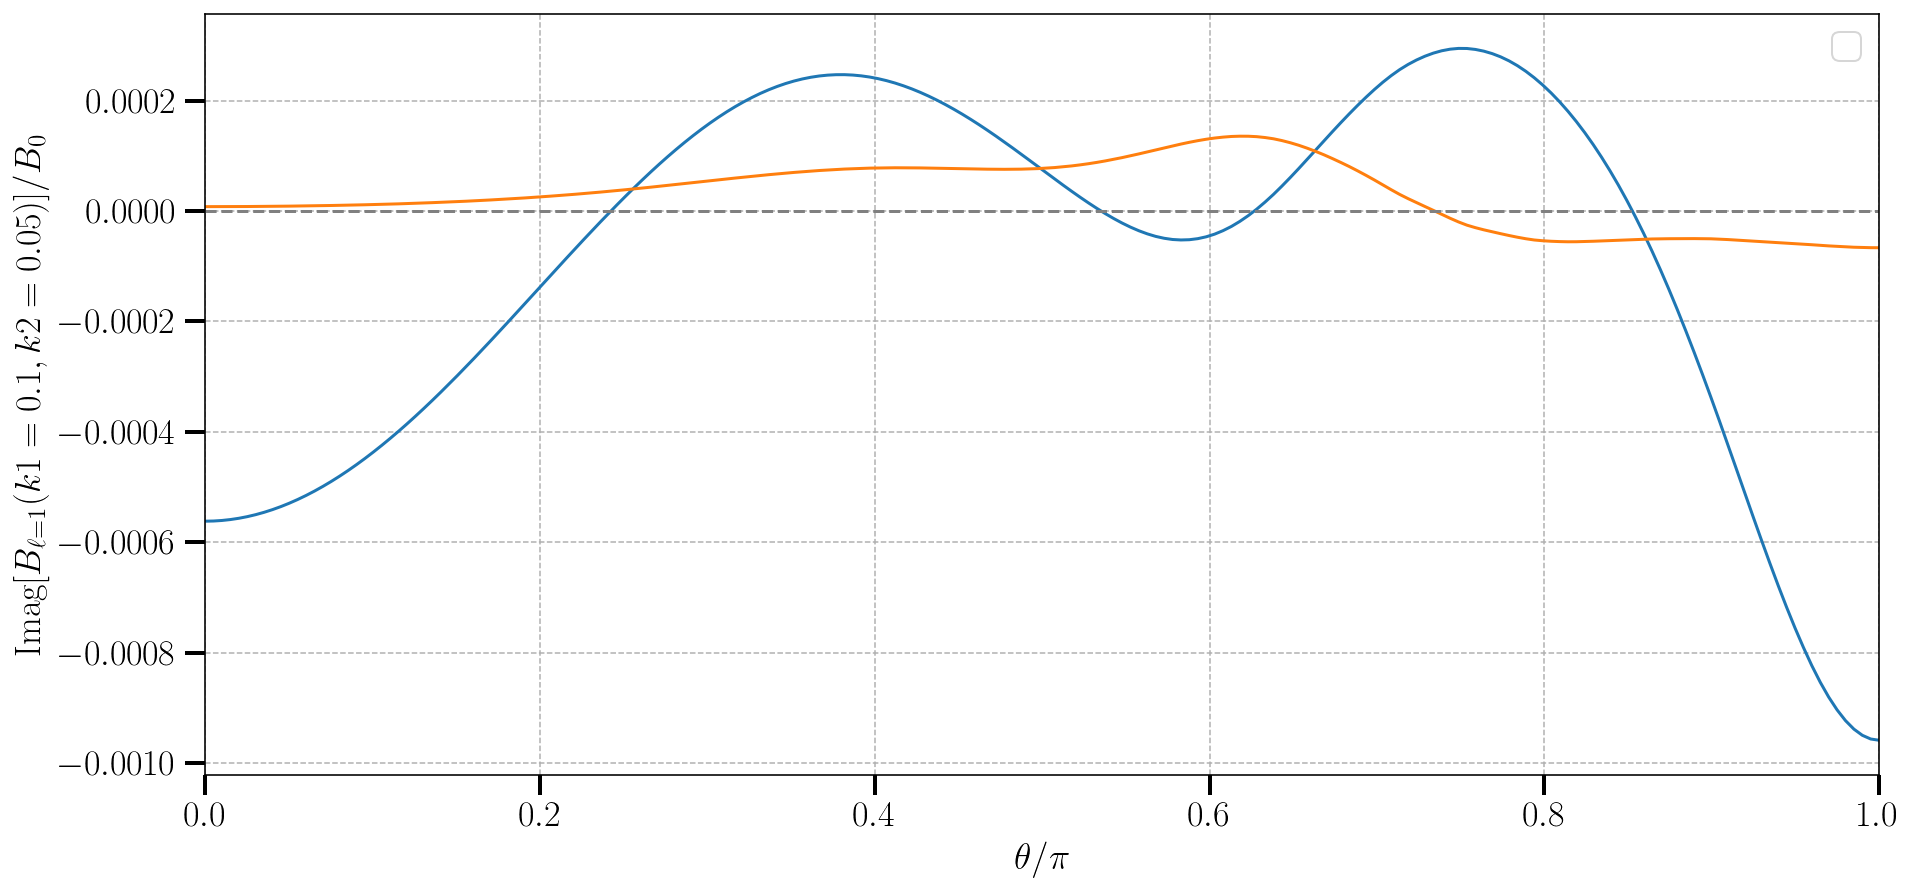

In [408]:
plt.figure(figsize=(15,7))
#plt.ylim(-0.7,0.2)
plt.xlim(0,1)
plt.grid(ls='--',lw=0.75)

#plt.plot(theta/np.pi,Bk_wideangle1/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
#plt.plot(theta/np.pi,Bk_wideangle2/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
#plt.plot(theta/np.pi,Bk_wideangle3/bkmono,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')

plt.plot(theta/np.pi,WA2.l0(params,1/3,1/3)/GR0.l0(params))
plt.plot(theta/np.pi,Der2.l0(params,derivs,1/3,1/3)/GR0.l0(params))
#plt.plot(theta/np.pi,Mix.l0(params,derivs,1/3,1/3)/GR0.l0(params))
plt.plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')

plt.legend()
plt.xlabel(r'$\theta/ \pi\,$')
plt.ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
plt.savefig('wrong_wide_angle_theory.png')

In [204]:
#So we need average (1/d) over redshift bin...
rout = comoving_dist(0.35)#1.2#
rmin = comoving_dist(0.15)#0.8#

d_plot = (3/2)*(rout**2-rmin**2)/(rout**3-rmin**3)
print(1/d_plot)

728.5929127055081


<Figure size 792x360 with 0 Axes>

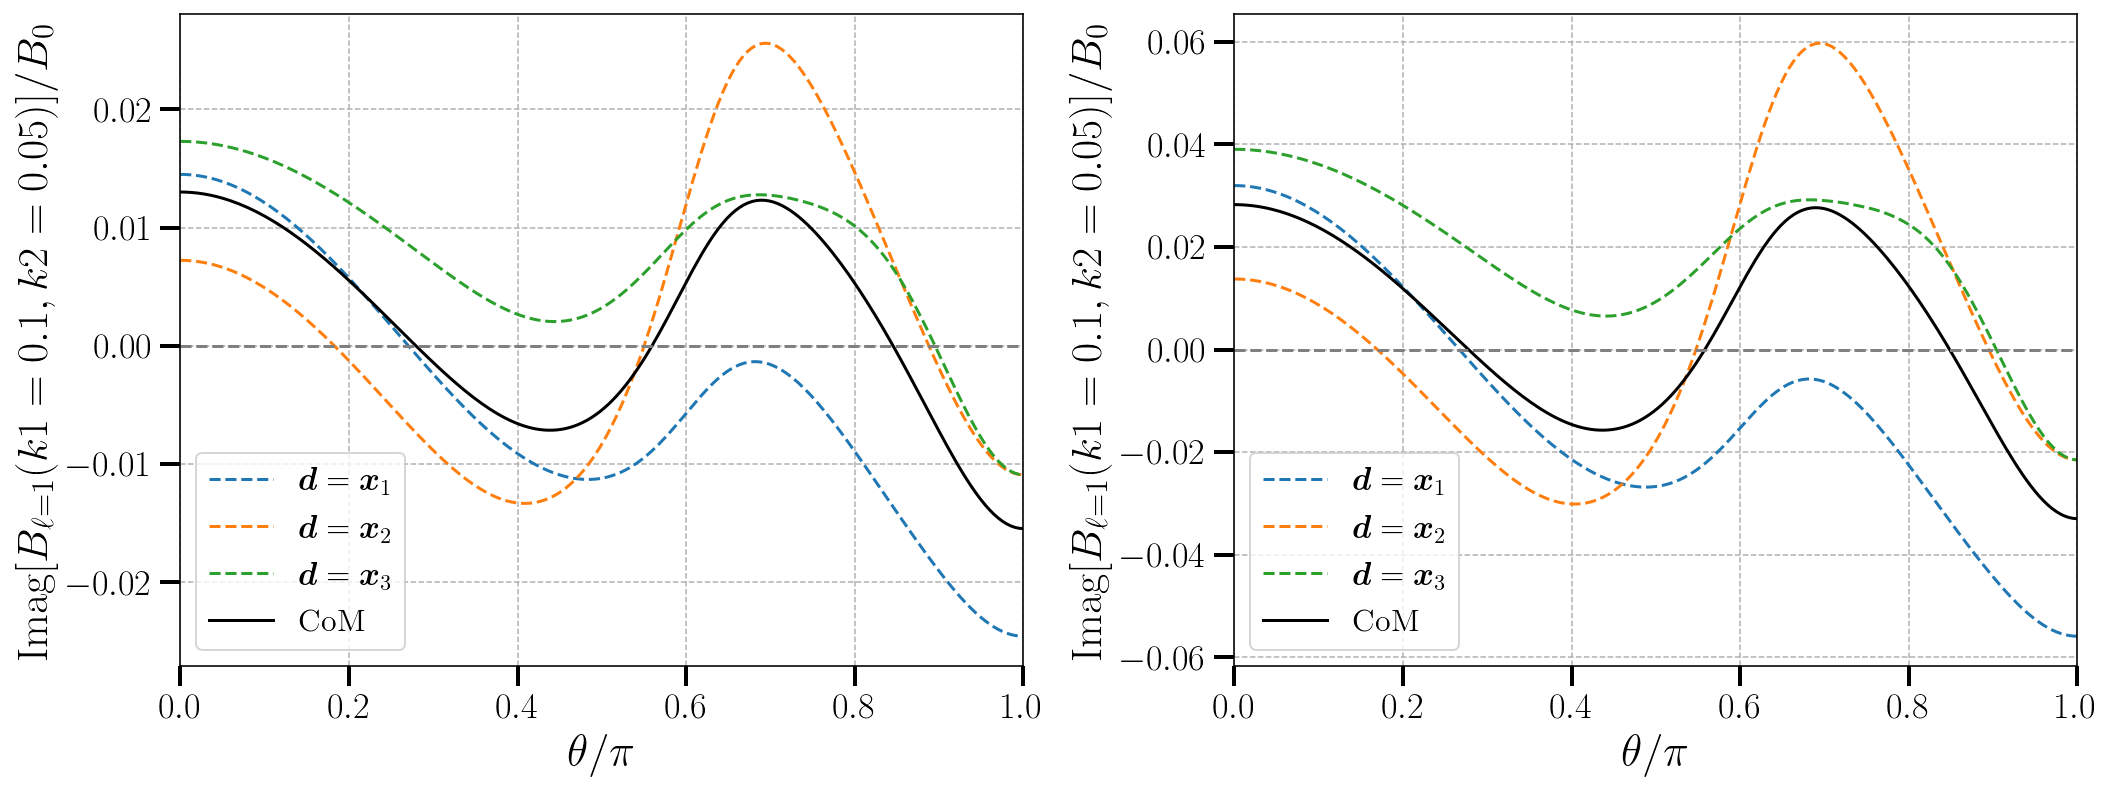

In [796]:
fig = plt.figure(figsize=(11, 5))

# Define gridspec with 4 rows and 3 columns
#gs = GridSpec(1, 2,width_ratios=[3, 3])

# Create subplots with custom aspect ratios
#axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(2)]  # Subplots in the first row

fig, axs = plt.subplots(1, 2,figsize=(17,6))
fig.subplots_adjust(wspace=0.25)
# Create the colormap plot
#im0 = axs[0].imshow(np.abs(bk0.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im1 = axs[1].imshow(np.abs(bk1.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
#im2 = axs[2].imshow(np.abs(bk2.T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='viridis',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

axs[0].plot(theta/np.pi,z1x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[0].plot(theta/np.pi,z1x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[0].plot(theta/np.pi,z1x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[0].plot(theta/np.pi,z1xmid,'k',label=r'$\text{CoM}$')
axs[0].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[0].legend(fontsize =16)
axs[0].set_xlim(0,1)
#axs[0].set_ylim(-0.07,0.07)
axs[0].set_xlabel(r'$\theta/ \pi\,$')
axs[0].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[0].grid(ls='--',lw=0.75)


axs[1].plot(theta/np.pi,z2x1,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_1$')
axs[1].plot(theta/np.pi,z2x2,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_2$')
axs[1].plot(theta/np.pi,z2x3,'--',label=r'$\boldsymbol{d}=\boldsymbol{x}_3$')
axs[1].plot(theta/np.pi,z2xmid,'k',label=r'$\text{CoM}$')
axs[1].plot(theta/np.pi,np.zeros_like(theta),color='grey',linestyle='--')
axs[1].legend(fontsize =16)
axs[1].set_xlim(0,1)
#axs[1].set_ylim(-0.07,0.07)

axs[1].set_xlabel(r'$\theta/ \pi\,$')
axs[1].set_ylabel(r'$ \text{Imag}[B_{\ell=1}(k1=0.1,k2=0.05)]/B_0 $')
axs[1].grid(ls='--',lw=0.75)

plt.savefig('Milad_plot.png', bbox_inches='tight', dpi=400)
#axs[1].yaxis.set_major_locator(plt.NullLocator())


In [2316]:
#so data storage format
#bk_0 = {}
#bk_wa1 = {}
#bk_der1 = {}
bk_rad2 = {}

In [2317]:
from tqdm import tqdm
# Define the function
#@jit
def triangle_plot(x, y, zz,r=0,s=0):
    """Get array of"""
    bk = np.zeros((len(x),len(y)))
    d_z = comoving_dist(zz)
    #so only do select values of bispectrum...
    for i in tqdm(range(len(x))):
        #array version:
        k1 = 0.05
        k2 = y*k1
        k3 = x[i]*k1
        
        which_k2 = np.logical_and((y > 1 - x[i]), (y>x[i]))#restrict to closed triangles
        k2_= k2[which_k2]
        #get theta from triagle condition
        theta = np.arccos((k3**2 -k1**2 - k2_**2)/(2*k1*k2_))
        
        derivs = get_derivs(zz)
        fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1 = derivs
        params = get_params(k1,k2_,theta,zz)
        k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2 = params
        #D1=1
        #K=3/7
        #C=3/7
        derivs = fd,Dd,gd2,bd2,bd1,fdd,Ddd,gdd2,bdd2,bdd1
        params = (k1,k2,k3,theta,Pk1,Pk2,Pk3,Pkd1,Pkd2,Pkd3,Pkdd1,Pkdd2,Pkdd3,d,K,C,f,D1,b1,b2,g2)
        
        #bk[i][which_k2] = Der1.l1(params,derivs, r, s).imag
        #bk[i][which_k2] = WA1.l1(params, r, s).imag
        #bk[i][which_k2] = GR0.l0(params).real
        
        
        #bk[i][which_k2] = Mix.l0(params,derivs, r, s).imag
        bk[i][which_k2] = Der2.l0(params,derivs, r, s).real
        
    return bk


xx = np.linspace(0.01, 1, 300)
yy = np.linspace(0.5, 1, 300)

zz=0.5
r=0;s=0

#so lets get key 

r=0;s=0
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)
r=1;s=0
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)
r=0;s=1
key = "z=%.2f, r=%d, s=%d"% (zz, r, s)
bk_rad2[key] = triangle_plot(xx,yy,zz,r,s)


mono_key = "z=%.2f"% (zz)
#bk_0[mono_key] = triangle_plot(xx,yy,zz,r,s)

100%|██████████| 300/300 [09:31<00:00,  1.91s/it]


In [2191]:
print(bk_der1.keys())
print(bk_wa1.keys())
print(bk_0.keys())

dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=1.00, r=1, s=0', 'z=1.00, r=0, s=1', 'z=0.20, r=0, s=0', 'z=0.20, r=1, s=0', 'z=0.20, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60, r=1, s=0', 'z=0.60, r=0, s=1'])
dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=1.00, r=1, s=0', 'z=1.00, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60, r=1, s=0', 'z=0.60, r=0, s=1'])
dict_keys(['z=0.10, r=0, s=0', 'z=1.00, r=0, s=0', 'z=0.60, r=0, s=1', 'z=0.60, r=0, s=0', 'z=0.60', 'z=1.00', 'z=2.00', 'z=0.50'])


In [382]:
def plot_triangle(bk,vmax,vmin=1): #plot triangle with mask!
    plt.figure(figsize=(8,3.5))
    # Create the colormap plot
    im = plt.imshow(np.abs(bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(vmin, vmax=vmax))#,vmin=0,vmax=vmax)#
    #im = plt.imshow((bk.T), extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#
    
    cbar = plt.colorbar(im)#format='%.0e'
    cbar.set_label(r"$B_{\ell=1}(k_1=0.1,k_2,k_3)$")#P_{HI}(k1=0.05, \mu_1)P_{HI}(k2, \mu_2)P_{HI}(k3, \mu_3)B_{\text{Gravitational}(k1=0.05)}

    # Add labels and title
    plt.xlabel('$k_3/k_1$')
    plt.ylabel('$k_2/k_1$')

    #so masking 
    # Create a mask for the triangular region
    size = int(1e+3)
    x = np.linspace(0.0, 1, size,dtype=np.float32)
    y = np.linspace(0.5, 1,  size,dtype=np.float32)
    xx,yy = np.meshgrid(x,y)
    mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
    im = plt.imshow(mask, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='binary')
    
    plt.grid(ls='--',lw=0.75,color='k',alpha=0.1)
    
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    plt.text(0.06,0.55,'$r=s=1/3$')
    plt.plot(x_bound,y_bound,'k',linewidth=3)
    # Show the plot
    plt.savefig('B_var60.png', bbox_inches='tight', dpi=400)
    plt.show()

<ipython-input-2291-23375cfc3999>:2: RuntimeWarning: invalid value encountered in divide
  plot_triangle(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)#d = x1


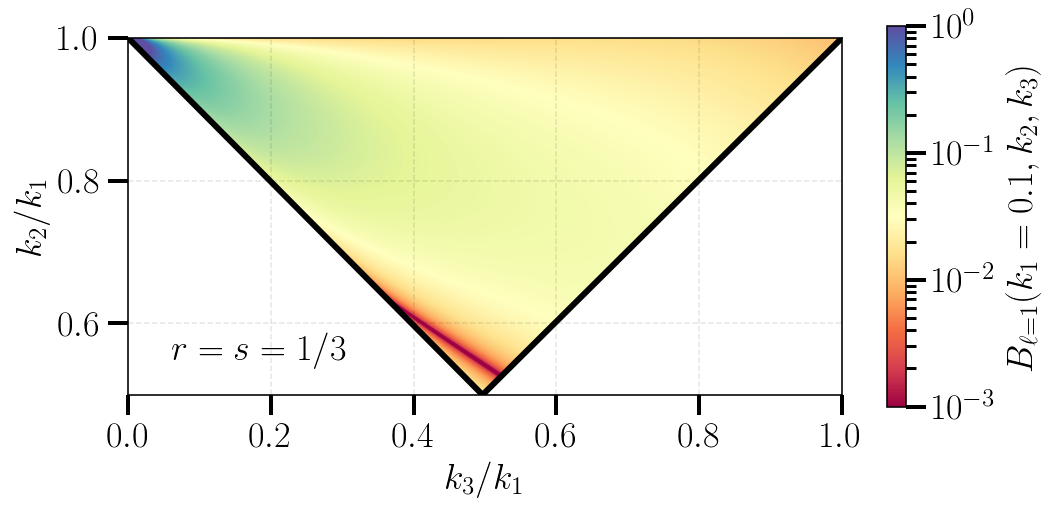

<ipython-input-2291-23375cfc3999>:3: RuntimeWarning: invalid value encountered in divide
  plot_triangle(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)


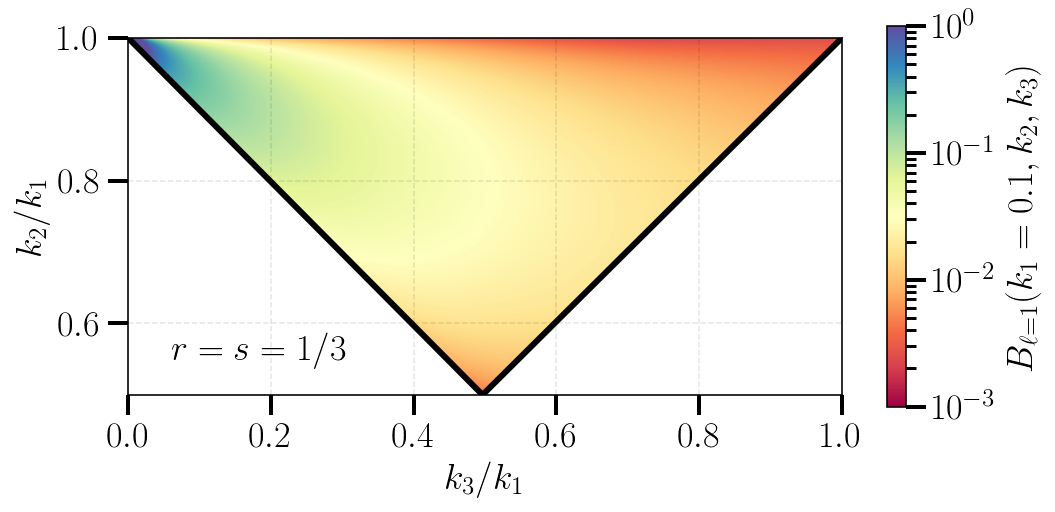

In [2291]:
#plot_triangle(bk_0['z=1.00, r=0, s=0'],1e+10,1e+8)
plot_triangle(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)#d = x1
plot_triangle(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],1,1e-3)

In [2312]:
def plot_triangle_multi(bk0,bk1,bk2,vmax): #plot triangle with mask!   
        
    fig = plt.figure(figsize=(12, 5))

    # Define gridspec with 1 rows and 3 columns
    gs = GridSpec(1, 3, width_ratios=[3, 3, 3])

    # Create subplots with custom aspect ratios
    axs = [fig.add_subplot(gs[0, i], aspect='10') for i in range(3)]  # Subplots in the first row

    #fig, axs = plt.subplots(1, 3,figsize=(14,5),sharey=True)
    fig.subplots_adjust(wspace=0)
    # Create the colormap plot
    im0 = axs[0].imshow(np.abs((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im1 = axs[1].imshow(np.abs((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#
    im2 = axs[2].imshow(np.abs((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='Spectral',norm=mpl.colors.LogNorm(1e-2, vmax=vmax))#,vmin=0,vmax=vmax)#

    #im0 = axs[0].imshow(((bk0).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im1 = axs[1].imshow(((bk1).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#
    #im2 = axs[2].imshow(((bk2).T),aspect=1.5, extent=[0, 1, 0.5, 1], interpolation='bilinear', origin='lower', cmap='RdBu',vmin=-vmax,vmax=vmax)#,vmin=0,vmax=vmax)#

    #divider = make_axes_locatable(axs[2])
    #colorbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    #cbar = plt.colorbar(im2, cax=colorbar_ax)
    #
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.4])
    cbar = fig.colorbar(im2, cax=cbar_ax,ticks=[0.01, 0.1, 1])
    #cbar.set_label(r"$ |B^{\rm wa}_{\ell=1}(k_1=0.05)|/B^{\rm pp}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    cbar.set_label(r"$ |B^{\rm red}_{\ell=1}(k_1=0.05)|/B^{\rm wa}_{\ell=0}$")#"$ |B_{\ell=1}(k_1=0.05)|/B_0 $"
    x_bound = [0,0.4965,1]
    y_bound = [1,0.50,1]#
    #so masking 
    # Create a mask for the triangular region
    for i in range(3):
        #axs[i].set_aspect(10)  # Adjust aspect ratio manually
        if i ==0:
            #axs[i].set_yticks(np.arange(0, 0.5, 0.1))
            axs[i].set_ylabel('$k_2/k_1$')
        #size = int(1e+3)
        #x = np.linspace(0.0, 1, size,dtype=np.float32)
        #y = np.linspace(0.5, 1,  size,dtype=np.float32)
        #xx,yy = np.meshgrid(x,y)
        #mask = np.where(np.logical_and((yy > 1 - xx), (yy>xx)),np.nan,1)
        #axs[i].imshow(mask, aspect=1.5, interpolation='bilinear', origin='lower', cmap='binary')
        axs[i].plot(x_bound,y_bound,'k',linewidth=3)
        axs[i].text(0.08,0.55,r'$\boldsymbol{d}=\boldsymbol{x}_%d$'%(i+1),fontsize=20)
        axs[i].set_xlabel('$k_3/k_1$')
        axs[i].set_xticks(np.arange(0.1, 0.91, 0.2))
        #axs[i].set_box_aspect(aspect=0.8)
        #axs[i].set_xlim(0,1)
        #axs[i].set_ylim(0.5,1)
        #axs[i].grid(ls='--',lw=0.75,color='k',alpha=0.1)
        
        if i!=0:
            axs[i].yaxis.set_major_locator(plt.NullLocator())
    
    # Show the plot
    plt.savefig('endpoint_traingles.png', bbox_inches='tight', dpi=400)
    plt.show()

<ipython-input-2313-17e6a40c8381>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)


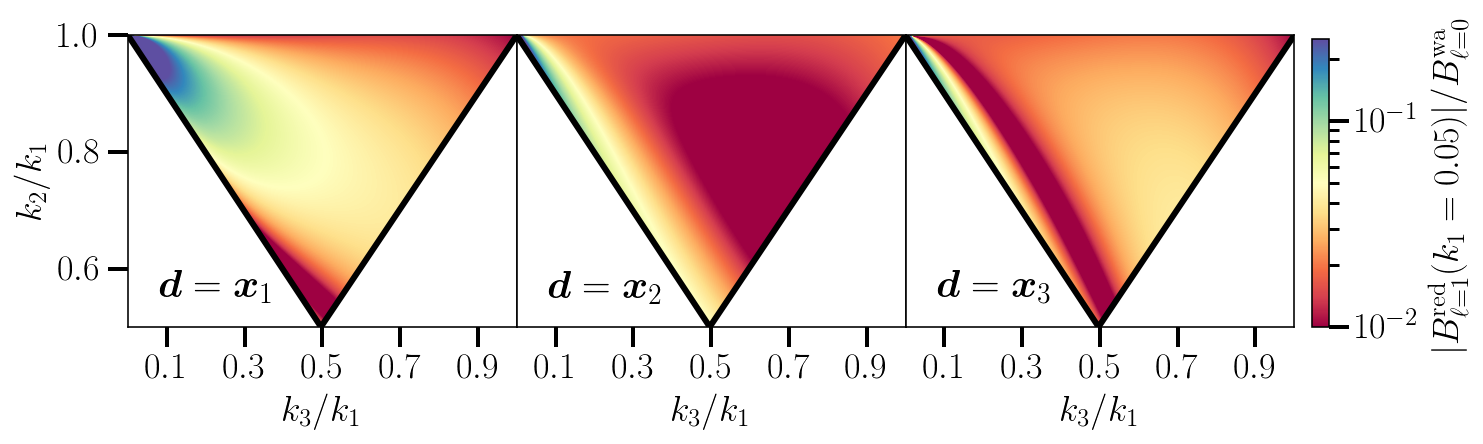

In [2313]:
plot_triangle_multi(bk_wa1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_wa1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)

<ipython-input-2314-21821a36bdc0>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)


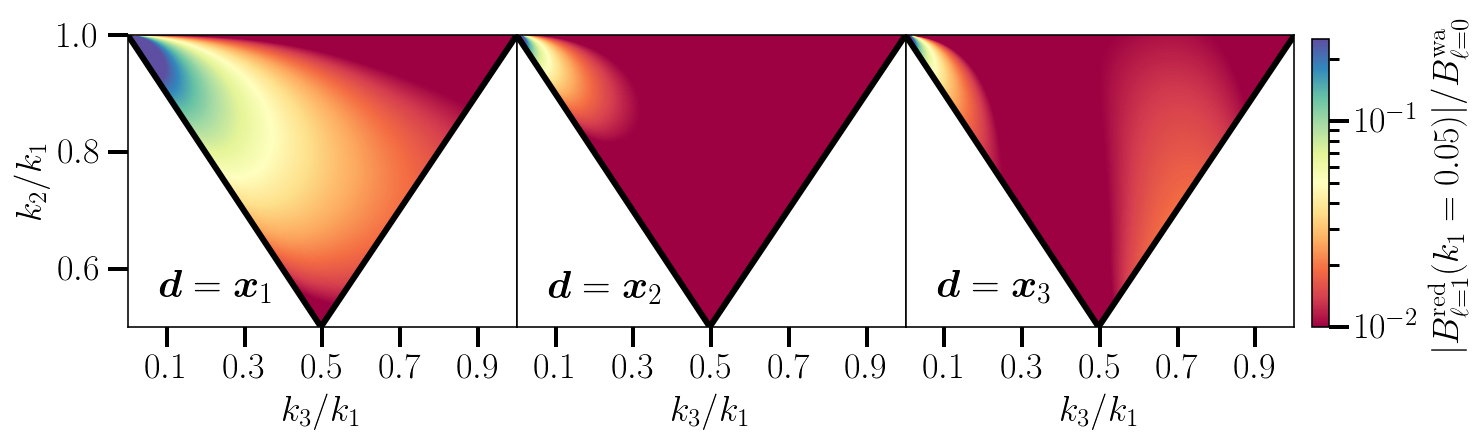

In [2314]:
plot_triangle_multi(bk_der1['z=1.00, r=0, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=1, s=0']/bk_0['z=1.00'],bk_der1['z=1.00, r=0, s=1']/bk_0['z=1.00'],0.25)

<ipython-input-2315-ba182e99cd10>:1: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_wa1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)


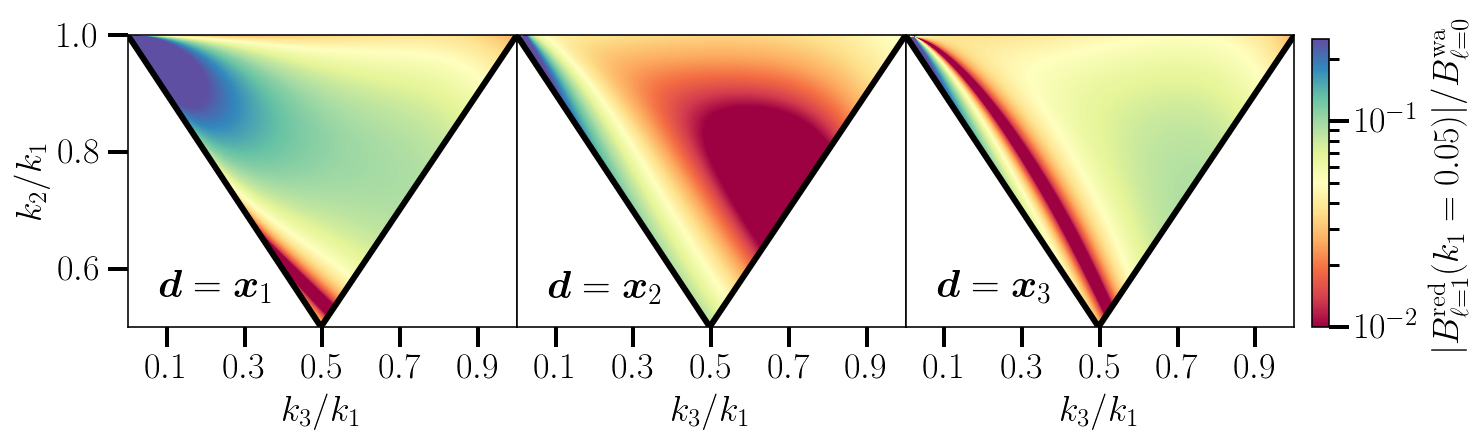

<ipython-input-2315-ba182e99cd10>:2: RuntimeWarning: invalid value encountered in divide
  plot_triangle_multi(bk_der1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)


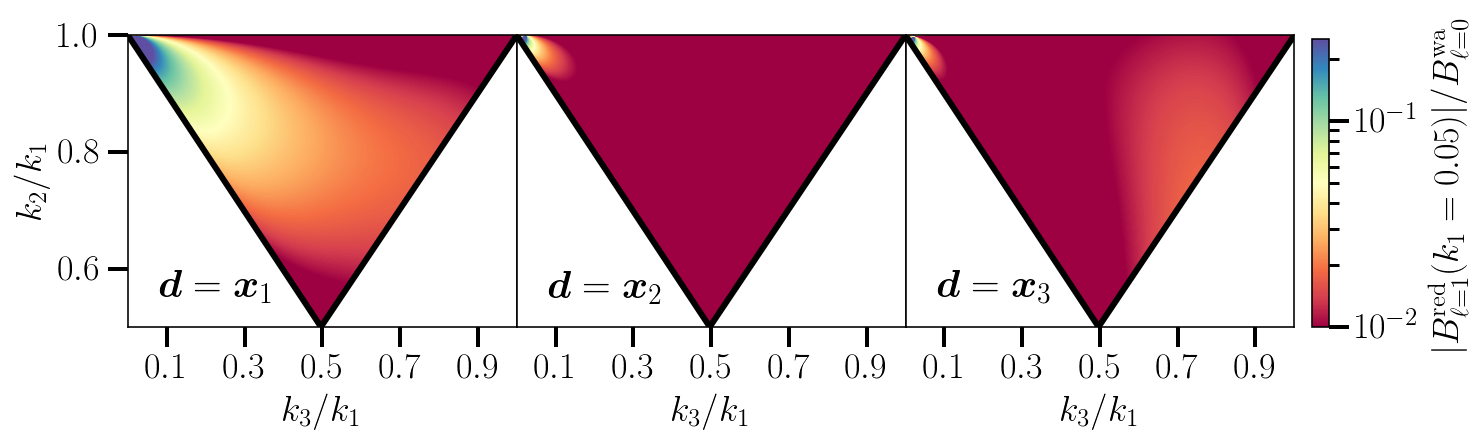

In [2315]:
plot_triangle_multi(bk_wa1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_wa1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)
plot_triangle_multi(bk_der1['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der1['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)

In [ ]:
plot_triangle_multi(bk_der2['z=0.50, r=0, s=0']/bk_0['z=0.50'],bk_der2['z=0.50, r=1, s=0']/bk_0['z=0.50'],bk_der2['z=0.50, r=0, s=1']/bk_0['z=0.50'],0.25)

In [1318]:
def add_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict
def minus_dict(dict1,dict2,key):
    new_dict = {}
    new_dict[key] = dict1[key]+dict2[key]
    return new_dict

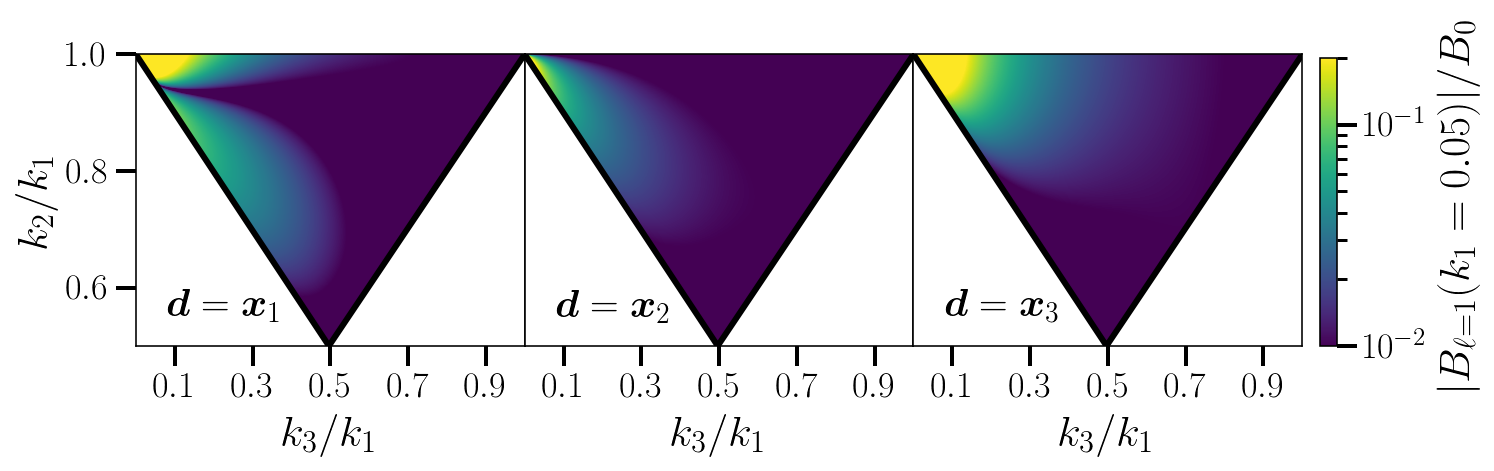

In [1332]:
plot_triangle_multi(bk1_deriv['0.1']/bk_mono['0.1'],bk2_deriv['0.1']/bk_mono['0.1'],bk3_deriv['0.1']/bk_mono['0.1'],0.2)

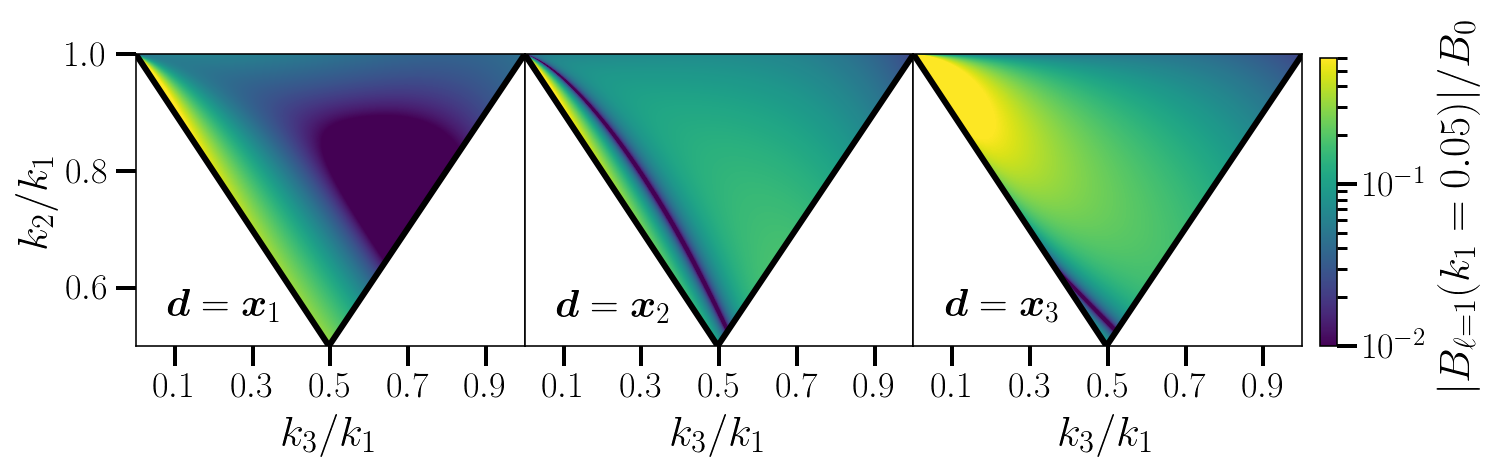

In [1304]:
plot_triangle_multi(bk1,bk2,bk3,0.6)